In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import time

In [ ]:

def compute_cap_transmission(image, omega=0.95):
    image = image.astype(np.float32) / 255.0
    hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    brightness = hsv[:, :, 2] / 255.0
    saturation = hsv[:, :, 1] / 255.0
    beta = np.max(brightness) + 1e-5
    transmission = 1 - omega * (beta - saturation)
    return np.clip(transmission, 0, 1)

def compute_dcp_transmission(image, omega=0.95, patch_size=15):
    image = image.astype(np.float32) / 255.0
    min_channel = np.min(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size, patch_size))
    dark_channel = cv2.erode(min_channel, kernel)
    transmission = 1 - omega * dark_channel
    return np.clip(transmission, 0, 1)

def compute_haze_line_transmission(image, omega=0.95):
    image = image.astype(np.float32) / 255.0
    mean_intensity = np.mean(image, axis=2)
    beta = np.max(mean_intensity) + 1e-5
    transmission = 1 - omega * (beta - mean_intensity)
    return np.clip(transmission, 0, 1)

def create_guidance_image(image, omega=0.95, patch_size=15):
    cap_transmission = compute_cap_transmission(image, omega)
    dcp_transmission = compute_dcp_transmission(image, omega, patch_size)
    haze_line_transmission = compute_haze_line_transmission(image, omega)
    guidance_image = (cap_transmission + dcp_transmission + haze_line_transmission) / 3.0
    return guidance_image

In [ ]:


def process_and_save_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".JPG") or filename.endswith(".jpg"):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            guidance_image = create_guidance_image(image)
            
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, (guidance_image * 255).astype(np.uint8))
            print(f"Processed and saved: {output_path}")

# Process train and test datasets
process_and_save_images("dataset/base/train", "dataset/guided/train")
process_and_save_images("dataset/base/test", "dataset/guided/test")


Processed and saved: dataset/guided/train/1.jpg
Processed and saved: dataset/guided/train/10.jpg
Processed and saved: dataset/guided/train/100.jpg
Processed and saved: dataset/guided/train/10003688883_be11839091_z.jpg
Processed and saved: dataset/guided/train/10020320283_83b1514ef4_z.jpg
Processed and saved: dataset/guided/train/100309892_94978cd79e_z.jpg
Processed and saved: dataset/guided/train/100412171_55555c1ce0_z.jpg
Processed and saved: dataset/guided/train/101.jpg
Processed and saved: dataset/guided/train/101039_5ab416185b_z.jpg
Processed and saved: dataset/guided/train/102.jpg
Processed and saved: dataset/guided/train/10278173383_990d01a5eb_z.jpg
Processed and saved: dataset/guided/train/10367996104_44d1937338_z.jpg
Processed and saved: dataset/guided/train/1055104210_c386d6111c_z.jpg
Processed and saved: dataset/guided/train/10560349313_689e068235_z.jpg
Processed and saved: dataset/guided/train/10677419946_15c3d79e45_z.jpg
Processed and saved: dataset/guided/train/10750317316

## Utility Functions

In [9]:
def getStructuringElement(shape, ksize):
    if shape == 0:  
        return np.ones(ksize, dtype=np.uint8)

def erode(image, kernel):
    """Erosion operation using custom structuring element."""
    """Grayscale input image and binary kernel."""
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    
    # Pad the image to handle border effects
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)
    eroded_image = np.zeros_like(image)

    # Perform erosion: Removes small structures, refines edges
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+k_h, j:j+k_w]
            # The kernel slides across the image, and the pixel value under the anchor point is replaced with the minimal pixel value overlapped by the kernel. 
            eroded_image[i, j] = np.min(region[kernel == 1])  # Apply erosion
    
    return eroded_image

## Dark Channel

In [8]:
def dark_channel(img, size=15):
    """Computes the dark channel of an image."""
    min_channel = np.min(img, axis=2)  # Find the minimum across color channels
    kernel = getStructuringElement(0, (size, size))  # Custom structuring element
    dark = erode(min_channel, kernel)  # Custom erosion function
    return dark

## Atmospheric Light

In [7]:
def atmospheric_light(img, dark):
    """Estimates the atmospheric light by finding the brightest pixels in the dark channel."""
    h, w = img.shape[:2]
    num_pixels = h * w // 1000  # Take top 0.1% brightest pixels
    dark_vec = dark.reshape(h * w)
    img_vec = img.reshape(h * w, 3)
    indices = np.argsort(dark_vec)[-num_pixels:]  # Get indices of top pixels
    atmo_light = np.mean(img_vec[indices], axis=0)  # Compute mean of brightest pixels
    return atmo_light

## Transmission Estimate

In [6]:
def transmission_estimate(img, atmo_light, omega=0.95, size=15):
    """Estimates the transmission map."""
    norm_img = img / atmo_light
    transmission = 1 - omega * dark_channel(norm_img, size)
    return transmission

## Recover Image

In [ ]:
def recover_image(img, t, atmo_light, t0=0.1):
    """Recovers the haze-free image using the estimated transmission map."""
    t = np.maximum(t, t0)  # Avoid division by zero
    J = (img - atmo_light) / t[:, :, None] + atmo_light
    return np.clip(J, 0, 1)

def guided_filter(I, p, r, eps):
    """Guided filter for refining the transmission map."""
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    corr_I = cv2.boxFilter(I * I, cv2.CV_64F, (r, r))
    corr_Ip = cv2.boxFilter(I * p, cv2.CV_64F, (r, r))

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    q = mean_a * I + mean_b
    return q

def dehaze(img_path):
    """Complete dehazing pipeline using Dark Channel Prior."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image at path {img_path} could not be loaded.")
    img = img / 255.0  # Normalize image

    dark = dark_channel(img)
    atmo_light = atmospheric_light(img, dark)
    transmission = transmission_estimate(img, atmo_light)
    
    # Refining transmission map using guided filter
    gray_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if gray_img is None:
        raise ValueError("Conversion to grayscale failed.")
    gray_img = gray_img / 255.0
    
    refined_t = guided_filter(gray_img, transmission, r=60, eps=1e-3)
    
    dehazed_img = recover_image(img, refined_t, atmo_light)
    return (dehazed_img * 255).astype(np.uint8)

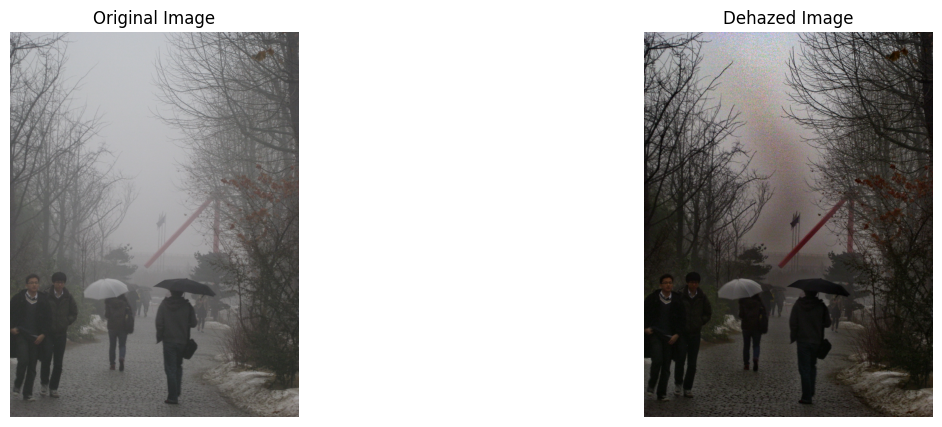

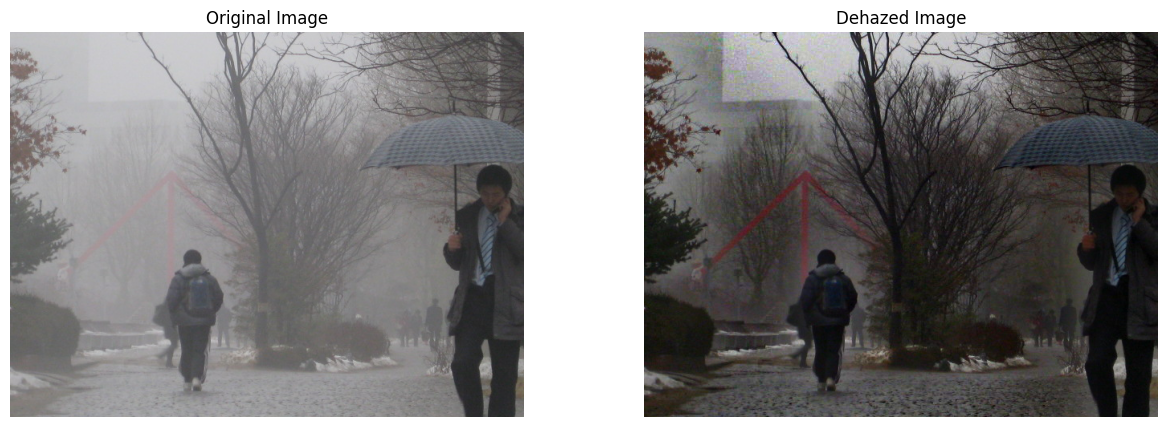

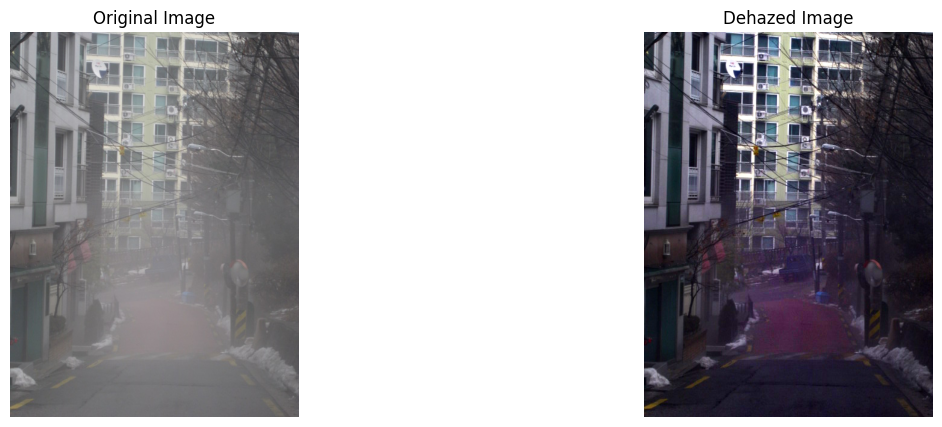

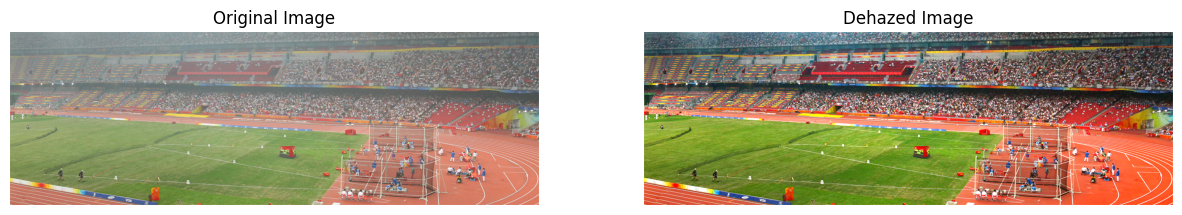

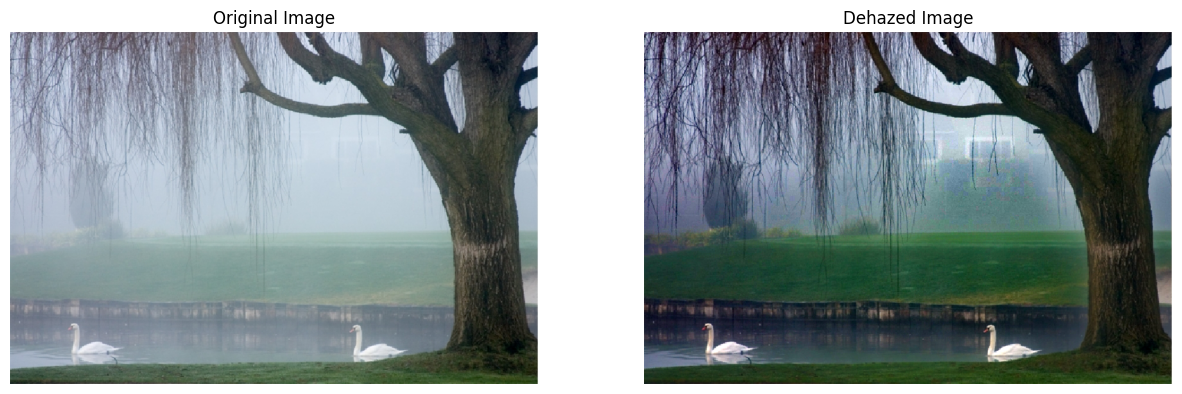

In [ ]:
image_paths = ["dataset/base/train/St_Wf_D_L__033.JPG"
    , "dataset/base/train/St_Wf_D_L__029.JPG"
    , "dataset/base/train/St_Wf_D_L__009.JPG"
    , "dataset/base/test/91.jpg"
    , "dataset/base/test/92.jpg"]
for image_path in image_paths:
    dehazed_img = dehaze(image_path)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(dehazed_img, cv2.COLOR_BGR2RGB))
    plt.title('Dehazed Image')
    plt.axis('off')

    plt.show()


# Process and Store Images

In [31]:
# dehaze image in dataset/base/train/ and dataset/base/test/ and store in dataset/dehazed/train/ and dataset/dehazed/test/
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

def dehaze_image(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".JPG") or filename.endswith(".jpg"):
            image_path = os.path.join(input_dir, filename)
            dehazed_image = dehaze(image_path)
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, dehazed_image)
            print(f"Processed and saved: {output_path}")

# Process train and test datasets
dehaze_image("dataset/base/train", "dataset/dehazed/train")
dehaze_image("dataset/base/test", "dataset/dehazed/test")


Processed and saved: dataset/dehazed/train/1.jpg
Processed and saved: dataset/dehazed/train/10.jpg
Processed and saved: dataset/dehazed/train/100.jpg
Processed and saved: dataset/dehazed/train/10003688883_be11839091_z.jpg
Processed and saved: dataset/dehazed/train/10020320283_83b1514ef4_z.jpg
Processed and saved: dataset/dehazed/train/100309892_94978cd79e_z.jpg
Processed and saved: dataset/dehazed/train/100412171_55555c1ce0_z.jpg
Processed and saved: dataset/dehazed/train/101.jpg
Processed and saved: dataset/dehazed/train/101039_5ab416185b_z.jpg
Processed and saved: dataset/dehazed/train/102.jpg
Processed and saved: dataset/dehazed/train/10278173383_990d01a5eb_z.jpg
Processed and saved: dataset/dehazed/train/10367996104_44d1937338_z.jpg
Processed and saved: dataset/dehazed/train/1055104210_c386d6111c_z.jpg
Processed and saved: dataset/dehazed/train/10560349313_689e068235_z.jpg
Processed and saved: dataset/dehazed/train/10677419946_15c3d79e45_z.jpg
Processed and saved: dataset/dehazed/t

In [13]:
from tqdm import tqdm

def dehaze_image(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    image_files = [f for f in os.listdir(input_dir) if f.endswith(".JPG") or f.endswith(".jpg")]
    
    for filename in tqdm(image_files, desc="Dehazing Images"):
        image_path = os.path.join(input_dir, filename)
        dehazed_image = dehaze(image_path)
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, dehazed_image)
        print(f"Processed and saved: {output_path}")

In [14]:
# Process train and test datasets
dehaze_image("dataset/RESIDE-6K/train/hazy", "dataset/RESIDE-6K/train/dehazed")
dehaze_image("dataset/RESIDE-6K/test/hazy", "dataset/RESIDE-6K/test/dehazed")

Dehazing Images:   0%|          | 1/6000 [00:00<1:30:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1.jpg


Dehazing Images:   0%|          | 2/6000 [00:01<1:27:58,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/10.jpg


Dehazing Images:   0%|          | 3/6000 [00:02<1:27:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/100.jpg


Dehazing Images:   0%|          | 4/6000 [00:03<1:27:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1000.jpg


Dehazing Images:   0%|          | 5/6000 [00:04<1:26:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1001.jpg


Dehazing Images:   0%|          | 6/6000 [00:05<1:27:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1002.jpg


Dehazing Images:   0%|          | 7/6000 [00:06<1:27:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1003.jpg


Dehazing Images:   0%|          | 8/6000 [00:06<1:26:31,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1004.jpg


Dehazing Images:   0%|          | 9/6000 [00:07<1:26:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1005.jpg


Dehazing Images:   0%|          | 10/6000 [00:08<1:26:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1006.jpg


Dehazing Images:   0%|          | 11/6000 [00:09<1:25:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1007.jpg


Dehazing Images:   0%|          | 12/6000 [00:10<1:25:30,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1008.jpg


Dehazing Images:   0%|          | 13/6000 [00:11<1:25:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1009.jpg


Dehazing Images:   0%|          | 14/6000 [00:12<1:26:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/101.jpg


Dehazing Images:   0%|          | 15/6000 [00:12<1:26:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1010.jpg


Dehazing Images:   0%|          | 16/6000 [00:13<1:26:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1011.jpg


Dehazing Images:   0%|          | 17/6000 [00:14<1:25:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1012.jpg


Dehazing Images:   0%|          | 18/6000 [00:15<1:25:30,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1013.jpg


Dehazing Images:   0%|          | 19/6000 [00:16<1:25:21,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1014.jpg


Dehazing Images:   0%|          | 20/6000 [00:17<1:25:23,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1015.jpg


Dehazing Images:   0%|          | 21/6000 [00:18<1:26:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1016.jpg


Dehazing Images:   0%|          | 22/6000 [00:19<1:26:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1017.jpg


Dehazing Images:   0%|          | 23/6000 [00:19<1:25:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1018.jpg


Dehazing Images:   0%|          | 24/6000 [00:20<1:25:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1019.jpg


Dehazing Images:   0%|          | 25/6000 [00:21<1:25:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/102.jpg


Dehazing Images:   0%|          | 26/6000 [00:22<1:25:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1020.jpg


Dehazing Images:   0%|          | 27/6000 [00:23<1:25:24,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1021.jpg


Dehazing Images:   0%|          | 28/6000 [00:24<1:25:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1022.jpg


Dehazing Images:   0%|          | 29/6000 [00:25<1:26:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1023.jpg


Dehazing Images:   0%|          | 30/6000 [00:25<1:25:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1024.jpg


Dehazing Images:   1%|          | 31/6000 [00:26<1:25:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1025.jpg


Dehazing Images:   1%|          | 32/6000 [00:27<1:25:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1026.jpg


Dehazing Images:   1%|          | 33/6000 [00:28<1:25:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1027.jpg


Dehazing Images:   1%|          | 34/6000 [00:29<1:25:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1028.jpg


Dehazing Images:   1%|          | 35/6000 [00:30<1:25:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1029.jpg


Dehazing Images:   1%|          | 36/6000 [00:31<1:26:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/103.jpg


Dehazing Images:   1%|          | 37/6000 [00:31<1:25:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1030.jpg


Dehazing Images:   1%|          | 38/6000 [00:32<1:25:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1031.jpg


Dehazing Images:   1%|          | 39/6000 [00:33<1:25:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1032.jpg


Dehazing Images:   1%|          | 40/6000 [00:34<1:26:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1033.jpg


Dehazing Images:   1%|          | 41/6000 [00:35<1:25:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1034.jpg


Dehazing Images:   1%|          | 42/6000 [00:36<1:25:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1035.jpg


Dehazing Images:   1%|          | 43/6000 [00:37<1:25:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1036.jpg


Dehazing Images:   1%|          | 44/6000 [00:37<1:26:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1037.jpg


Dehazing Images:   1%|          | 45/6000 [00:38<1:25:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1038.jpg


Dehazing Images:   1%|          | 46/6000 [00:39<1:25:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1039.jpg


Dehazing Images:   1%|          | 47/6000 [00:40<1:25:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/104.jpg


Dehazing Images:   1%|          | 48/6000 [00:41<1:25:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1040.jpg


Dehazing Images:   1%|          | 49/6000 [00:42<1:24:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1041.jpg


Dehazing Images:   1%|          | 50/6000 [00:43<1:24:39,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1042.jpg


Dehazing Images:   1%|          | 51/6000 [00:43<1:25:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1043.jpg


Dehazing Images:   1%|          | 52/6000 [00:44<1:25:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1044.jpg


Dehazing Images:   1%|          | 53/6000 [00:45<1:25:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1045.jpg


Dehazing Images:   1%|          | 54/6000 [00:46<1:24:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1046.jpg


Dehazing Images:   1%|          | 55/6000 [00:47<1:24:41,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1047.jpg


Dehazing Images:   1%|          | 56/6000 [00:48<1:24:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1048.jpg


Dehazing Images:   1%|          | 57/6000 [00:49<1:24:36,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1049.jpg


Dehazing Images:   1%|          | 58/6000 [00:49<1:25:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/105.jpg


Dehazing Images:   1%|          | 59/6000 [00:50<1:25:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1050.jpg


Dehazing Images:   1%|          | 60/6000 [00:51<1:25:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1051.jpg


Dehazing Images:   1%|          | 61/6000 [00:52<1:25:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1052.jpg


Dehazing Images:   1%|          | 62/6000 [00:53<1:24:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1053.jpg


Dehazing Images:   1%|          | 63/6000 [00:54<1:24:40,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1054.jpg


Dehazing Images:   1%|          | 64/6000 [00:55<1:24:37,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1055.jpg


Dehazing Images:   1%|          | 65/6000 [00:56<1:25:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1056.jpg


Dehazing Images:   1%|          | 66/6000 [00:56<1:25:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1057.jpg


Dehazing Images:   1%|          | 67/6000 [00:57<1:25:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1058.jpg


Dehazing Images:   1%|          | 68/6000 [00:58<1:25:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1059.jpg


Dehazing Images:   1%|          | 69/6000 [00:59<1:25:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/106.jpg


Dehazing Images:   1%|          | 70/6000 [01:00<1:24:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1060.jpg


Dehazing Images:   1%|          | 71/6000 [01:01<1:24:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1061.jpg


Dehazing Images:   1%|          | 72/6000 [01:02<1:25:42,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1062.jpg


Dehazing Images:   1%|          | 73/6000 [01:02<1:25:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1063.jpg


Dehazing Images:   1%|          | 74/6000 [01:03<1:24:54,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1064.jpg


Dehazing Images:   1%|▏         | 75/6000 [01:04<1:25:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1065.jpg


Dehazing Images:   1%|▏         | 76/6000 [01:05<1:25:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1066.jpg


Dehazing Images:   1%|▏         | 77/6000 [01:06<1:24:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1067.jpg


Dehazing Images:   1%|▏         | 78/6000 [01:07<1:24:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1068.jpg


Dehazing Images:   1%|▏         | 79/6000 [01:08<1:25:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1069.jpg


Dehazing Images:   1%|▏         | 80/6000 [01:08<1:25:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/107.jpg


Dehazing Images:   1%|▏         | 81/6000 [01:09<1:25:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1070.jpg


Dehazing Images:   1%|▏         | 82/6000 [01:10<1:24:48,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1071.jpg


Dehazing Images:   1%|▏         | 83/6000 [01:11<1:24:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1072.jpg


Dehazing Images:   1%|▏         | 84/6000 [01:12<1:24:32,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1073.jpg


Dehazing Images:   1%|▏         | 85/6000 [01:13<1:24:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1074.jpg


Dehazing Images:   1%|▏         | 86/6000 [01:14<1:25:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1075.jpg


Dehazing Images:   1%|▏         | 87/6000 [01:14<1:25:06,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1076.jpg


Dehazing Images:   1%|▏         | 88/6000 [01:15<1:24:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1077.jpg


Dehazing Images:   1%|▏         | 89/6000 [01:16<1:24:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1078.jpg


Dehazing Images:   2%|▏         | 90/6000 [01:17<1:24:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1079.jpg


Dehazing Images:   2%|▏         | 91/6000 [01:18<1:24:30,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/108.jpg


Dehazing Images:   2%|▏         | 92/6000 [01:19<1:24:27,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1080.jpg


Dehazing Images:   2%|▏         | 93/6000 [01:20<1:25:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1081.jpg


Dehazing Images:   2%|▏         | 94/6000 [01:21<1:25:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1082.jpg


Dehazing Images:   2%|▏         | 95/6000 [01:21<1:24:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1083.jpg


Dehazing Images:   2%|▏         | 96/6000 [01:22<1:24:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1084.jpg


Dehazing Images:   2%|▏         | 97/6000 [01:23<1:24:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1085.jpg


Dehazing Images:   2%|▏         | 98/6000 [01:24<1:24:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1086.jpg


Dehazing Images:   2%|▏         | 99/6000 [01:25<1:24:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1087.jpg


Dehazing Images:   2%|▏         | 100/6000 [01:26<1:25:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1088.jpg


Dehazing Images:   2%|▏         | 101/6000 [01:27<1:25:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1089.jpg


Dehazing Images:   2%|▏         | 102/6000 [01:27<1:25:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/109.jpg


Dehazing Images:   2%|▏         | 103/6000 [01:28<1:24:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1090.jpg


Dehazing Images:   2%|▏         | 104/6000 [01:29<1:25:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1091.jpg


Dehazing Images:   2%|▏         | 105/6000 [01:30<1:25:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1092.jpg


Dehazing Images:   2%|▏         | 106/6000 [01:31<1:25:31,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1093.jpg


Dehazing Images:   2%|▏         | 107/6000 [01:32<1:26:32,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1094.jpg


Dehazing Images:   2%|▏         | 108/6000 [01:33<1:25:58,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1095.jpg


Dehazing Images:   2%|▏         | 109/6000 [01:34<1:25:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1096.jpg


Dehazing Images:   2%|▏         | 110/6000 [01:34<1:25:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1097.jpg


Dehazing Images:   2%|▏         | 111/6000 [01:35<1:25:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1098.jpg


Dehazing Images:   2%|▏         | 112/6000 [01:36<1:25:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1099.jpg


Dehazing Images:   2%|▏         | 113/6000 [01:37<1:25:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/11.jpg


Dehazing Images:   2%|▏         | 114/6000 [01:38<1:26:07,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/110.jpg


Dehazing Images:   2%|▏         | 115/6000 [01:39<1:25:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1100.jpg


Dehazing Images:   2%|▏         | 116/6000 [01:40<1:25:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1101.jpg


Dehazing Images:   2%|▏         | 117/6000 [01:40<1:25:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1102.jpg


Dehazing Images:   2%|▏         | 118/6000 [01:41<1:24:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1103.jpg


Dehazing Images:   2%|▏         | 119/6000 [01:42<1:24:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1104.jpg


Dehazing Images:   2%|▏         | 120/6000 [01:43<1:24:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1105.jpg


Dehazing Images:   2%|▏         | 121/6000 [01:44<1:25:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1106.jpg


Dehazing Images:   2%|▏         | 122/6000 [01:45<1:25:16,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1107.jpg


Dehazing Images:   2%|▏         | 123/6000 [01:46<1:24:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1108.jpg


Dehazing Images:   2%|▏         | 124/6000 [01:47<1:24:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1109.jpg


Dehazing Images:   2%|▏         | 125/6000 [01:47<1:24:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/111.jpg


Dehazing Images:   2%|▏         | 126/6000 [01:48<1:24:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1110.jpg


Dehazing Images:   2%|▏         | 127/6000 [01:49<1:24:16,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1111.jpg


Dehazing Images:   2%|▏         | 128/6000 [01:50<1:25:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1112.jpg


Dehazing Images:   2%|▏         | 129/6000 [01:51<1:24:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1113.jpg


Dehazing Images:   2%|▏         | 130/6000 [01:52<1:24:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1114.jpg


Dehazing Images:   2%|▏         | 131/6000 [01:53<1:24:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1115.jpg


Dehazing Images:   2%|▏         | 132/6000 [01:53<1:24:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1116.jpg


Dehazing Images:   2%|▏         | 133/6000 [01:54<1:24:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1117.jpg


Dehazing Images:   2%|▏         | 134/6000 [01:55<1:24:16,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1118.jpg


Dehazing Images:   2%|▏         | 135/6000 [01:56<1:25:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1119.jpg


Dehazing Images:   2%|▏         | 136/6000 [01:57<1:25:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/112.jpg


Dehazing Images:   2%|▏         | 137/6000 [01:58<1:24:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1120.jpg


Dehazing Images:   2%|▏         | 138/6000 [01:59<1:24:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1121.jpg


Dehazing Images:   2%|▏         | 139/6000 [02:00<1:24:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1122.jpg


Dehazing Images:   2%|▏         | 140/6000 [02:00<1:24:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1123.jpg


Dehazing Images:   2%|▏         | 141/6000 [02:01<1:24:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1124.jpg


Dehazing Images:   2%|▏         | 142/6000 [02:02<1:25:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1125.jpg


Dehazing Images:   2%|▏         | 143/6000 [02:03<1:24:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1126.jpg


Dehazing Images:   2%|▏         | 144/6000 [02:04<1:24:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1127.jpg


Dehazing Images:   2%|▏         | 145/6000 [02:05<1:24:16,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1128.jpg


Dehazing Images:   2%|▏         | 146/6000 [02:06<1:24:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1129.jpg


Dehazing Images:   2%|▏         | 147/6000 [02:06<1:24:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/113.jpg


Dehazing Images:   2%|▏         | 148/6000 [02:07<1:25:16,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1130.jpg


Dehazing Images:   2%|▏         | 149/6000 [02:08<1:25:12,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1131.jpg


Dehazing Images:   2%|▎         | 150/6000 [02:09<1:24:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1132.jpg


Dehazing Images:   3%|▎         | 151/6000 [02:10<1:24:25,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1133.jpg


Dehazing Images:   3%|▎         | 152/6000 [02:11<1:24:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1134.jpg


Dehazing Images:   3%|▎         | 153/6000 [02:12<1:24:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1135.jpg


Dehazing Images:   3%|▎         | 154/6000 [02:12<1:23:58,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1136.jpg


Dehazing Images:   3%|▎         | 155/6000 [02:13<1:24:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1137.jpg


Dehazing Images:   3%|▎         | 156/6000 [02:14<1:24:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1138.jpg


Dehazing Images:   3%|▎         | 157/6000 [02:15<1:24:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1139.jpg


Dehazing Images:   3%|▎         | 158/6000 [02:16<1:25:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/114.jpg


Dehazing Images:   3%|▎         | 159/6000 [02:17<1:25:55,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1140.jpg


Dehazing Images:   3%|▎         | 160/6000 [02:18<1:25:07,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1141.jpg


Dehazing Images:   3%|▎         | 161/6000 [02:19<1:25:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1142.jpg


Dehazing Images:   3%|▎         | 162/6000 [02:19<1:24:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1143.jpg


Dehazing Images:   3%|▎         | 163/6000 [02:20<1:24:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1144.jpg


Dehazing Images:   3%|▎         | 164/6000 [02:21<1:24:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1145.jpg


Dehazing Images:   3%|▎         | 165/6000 [02:22<1:23:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1146.jpg


Dehazing Images:   3%|▎         | 166/6000 [02:23<1:23:23,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1147.jpg


Dehazing Images:   3%|▎         | 167/6000 [02:24<1:23:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1148.jpg


Dehazing Images:   3%|▎         | 168/6000 [02:25<1:23:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1149.jpg


Dehazing Images:   3%|▎         | 169/6000 [02:26<1:23:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/115.jpg


Dehazing Images:   3%|▎         | 170/6000 [02:26<1:24:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1150.jpg


Dehazing Images:   3%|▎         | 171/6000 [02:27<1:23:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1151.jpg


Dehazing Images:   3%|▎         | 172/6000 [02:28<1:24:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1152.jpg


Dehazing Images:   3%|▎         | 173/6000 [02:29<1:24:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1153.jpg


Dehazing Images:   3%|▎         | 174/6000 [02:30<1:23:54,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1154.jpg


Dehazing Images:   3%|▎         | 175/6000 [02:31<1:24:35,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1155.jpg


Dehazing Images:   3%|▎         | 176/6000 [02:32<1:23:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1156.jpg


Dehazing Images:   3%|▎         | 177/6000 [02:32<1:23:48,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1157.jpg


Dehazing Images:   3%|▎         | 178/6000 [02:33<1:23:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1158.jpg


Dehazing Images:   3%|▎         | 179/6000 [02:34<1:23:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1159.jpg


Dehazing Images:   3%|▎         | 180/6000 [02:35<1:23:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/116.jpg


Dehazing Images:   3%|▎         | 181/6000 [02:36<1:24:31,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1160.jpg


Dehazing Images:   3%|▎         | 182/6000 [02:37<1:23:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1161.jpg


Dehazing Images:   3%|▎         | 183/6000 [02:38<1:23:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1162.jpg


Dehazing Images:   3%|▎         | 184/6000 [02:38<1:23:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1163.jpg


Dehazing Images:   3%|▎         | 185/6000 [02:39<1:22:58,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1164.jpg


Dehazing Images:   3%|▎         | 186/6000 [02:40<1:22:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1165.jpg


Dehazing Images:   3%|▎         | 187/6000 [02:41<1:23:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1166.jpg


Dehazing Images:   3%|▎         | 188/6000 [02:42<1:23:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1167.jpg


Dehazing Images:   3%|▎         | 189/6000 [02:43<1:23:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1168.jpg


Dehazing Images:   3%|▎         | 190/6000 [02:44<1:24:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1169.jpg


Dehazing Images:   3%|▎         | 191/6000 [02:45<1:24:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/117.jpg


Dehazing Images:   3%|▎         | 192/6000 [02:45<1:23:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1170.jpg


Dehazing Images:   3%|▎         | 193/6000 [02:46<1:23:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1171.jpg


Dehazing Images:   3%|▎         | 194/6000 [02:47<1:24:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1172.jpg


Dehazing Images:   3%|▎         | 195/6000 [02:48<1:23:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1173.jpg


Dehazing Images:   3%|▎         | 196/6000 [02:49<1:23:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1174.jpg


Dehazing Images:   3%|▎         | 197/6000 [02:50<1:22:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1175.jpg


Dehazing Images:   3%|▎         | 198/6000 [02:51<1:22:37,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1176.jpg


Dehazing Images:   3%|▎         | 199/6000 [02:51<1:22:17,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1177.jpg


Dehazing Images:   3%|▎         | 200/6000 [02:52<1:22:24,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1178.jpg


Dehazing Images:   3%|▎         | 201/6000 [02:53<1:23:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1179.jpg


Dehazing Images:   3%|▎         | 202/6000 [02:54<1:23:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/118.jpg


Dehazing Images:   3%|▎         | 203/6000 [02:55<1:23:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1180.jpg


Dehazing Images:   3%|▎         | 204/6000 [02:56<1:24:35,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1181.jpg


Dehazing Images:   3%|▎         | 205/6000 [02:57<1:25:18,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1182.jpg


Dehazing Images:   3%|▎         | 206/6000 [02:58<1:26:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1183.jpg


Dehazing Images:   3%|▎         | 207/6000 [02:58<1:26:25,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1184.jpg


Dehazing Images:   3%|▎         | 208/6000 [02:59<1:27:59,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1185.jpg


Dehazing Images:   3%|▎         | 209/6000 [03:00<1:27:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1186.jpg


Dehazing Images:   4%|▎         | 210/6000 [03:01<1:25:42,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1187.jpg


Dehazing Images:   4%|▎         | 211/6000 [03:02<1:24:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1188.jpg


Dehazing Images:   4%|▎         | 212/6000 [03:03<1:23:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1189.jpg


Dehazing Images:   4%|▎         | 213/6000 [03:04<1:22:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/119.jpg


Dehazing Images:   4%|▎         | 214/6000 [03:05<1:23:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1190.jpg


Dehazing Images:   4%|▎         | 215/6000 [03:05<1:23:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1191.jpg


Dehazing Images:   4%|▎         | 216/6000 [03:06<1:23:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1192.jpg


Dehazing Images:   4%|▎         | 217/6000 [03:07<1:22:30,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1193.jpg


Dehazing Images:   4%|▎         | 218/6000 [03:08<1:22:17,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1194.jpg


Dehazing Images:   4%|▎         | 219/6000 [03:09<1:22:01,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1195.jpg


Dehazing Images:   4%|▎         | 220/6000 [03:10<1:22:00,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1196.jpg


Dehazing Images:   4%|▎         | 221/6000 [03:11<1:22:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1197.jpg


Dehazing Images:   4%|▎         | 222/6000 [03:11<1:22:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1198.jpg


Dehazing Images:   4%|▎         | 223/6000 [03:12<1:22:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1199.jpg


Dehazing Images:   4%|▎         | 224/6000 [03:13<1:21:53,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/12.jpg


Dehazing Images:   4%|▍         | 225/6000 [03:14<1:21:50,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/120.jpg


Dehazing Images:   4%|▍         | 226/6000 [03:15<1:22:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1200.jpg


Dehazing Images:   4%|▍         | 227/6000 [03:16<1:21:50,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1201.jpg


Dehazing Images:   4%|▍         | 228/6000 [03:17<1:25:21,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1202.jpg


Dehazing Images:   4%|▍         | 229/6000 [03:18<1:26:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1203.jpg


Dehazing Images:   4%|▍         | 230/6000 [03:18<1:26:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1204.jpg


Dehazing Images:   4%|▍         | 231/6000 [03:19<1:27:03,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1205.jpg


Dehazing Images:   4%|▍         | 232/6000 [03:20<1:26:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1206.jpg


Dehazing Images:   4%|▍         | 233/6000 [03:21<1:27:04,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1207.jpg


Dehazing Images:   4%|▍         | 234/6000 [03:22<1:27:02,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1208.jpg


Dehazing Images:   4%|▍         | 235/6000 [03:23<1:28:32,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1209.jpg


Dehazing Images:   4%|▍         | 236/6000 [03:24<1:28:03,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/121.jpg


Dehazing Images:   4%|▍         | 237/6000 [03:25<1:27:42,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1210.jpg


Dehazing Images:   4%|▍         | 238/6000 [03:26<1:27:12,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1211.jpg


Dehazing Images:   4%|▍         | 239/6000 [03:27<1:27:44,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1212.jpg


Dehazing Images:   4%|▍         | 240/6000 [03:28<1:27:17,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1213.jpg


Dehazing Images:   4%|▍         | 241/6000 [03:29<1:28:30,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1214.jpg


Dehazing Images:   4%|▍         | 242/6000 [03:29<1:28:57,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1215.jpg


Dehazing Images:   4%|▍         | 243/6000 [03:30<1:28:37,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1216.jpg


Dehazing Images:   4%|▍         | 244/6000 [03:31<1:28:08,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1217.jpg


Dehazing Images:   4%|▍         | 245/6000 [03:32<1:28:23,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1218.jpg


Dehazing Images:   4%|▍         | 246/6000 [03:33<1:27:59,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1219.jpg


Dehazing Images:   4%|▍         | 247/6000 [03:34<1:27:33,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/122.jpg


Dehazing Images:   4%|▍         | 248/6000 [03:35<1:28:38,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1220.jpg


Dehazing Images:   4%|▍         | 249/6000 [03:36<1:27:50,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1221.jpg


Dehazing Images:   4%|▍         | 250/6000 [03:37<1:27:30,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1222.jpg


Dehazing Images:   4%|▍         | 251/6000 [03:38<1:27:57,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1223.jpg


Dehazing Images:   4%|▍         | 252/6000 [03:39<1:27:14,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1224.jpg


Dehazing Images:   4%|▍         | 253/6000 [03:39<1:26:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1225.jpg


Dehazing Images:   4%|▍         | 254/6000 [03:40<1:26:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1226.jpg


Dehazing Images:   4%|▍         | 255/6000 [03:41<1:26:45,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1227.jpg


Dehazing Images:   4%|▍         | 256/6000 [03:42<1:27:20,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1228.jpg


Dehazing Images:   4%|▍         | 257/6000 [03:43<1:26:47,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1229.jpg


Dehazing Images:   4%|▍         | 258/6000 [03:44<1:26:41,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/123.jpg


Dehazing Images:   4%|▍         | 259/6000 [03:45<1:26:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1230.jpg


Dehazing Images:   4%|▍         | 260/6000 [03:46<1:27:11,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1231.jpg


Dehazing Images:   4%|▍         | 261/6000 [03:47<1:27:01,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1232.jpg


Dehazing Images:   4%|▍         | 262/6000 [03:48<1:26:41,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1233.jpg


Dehazing Images:   4%|▍         | 263/6000 [03:49<1:26:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1234.jpg


Dehazing Images:   4%|▍         | 264/6000 [03:49<1:25:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1235.jpg


Dehazing Images:   4%|▍         | 265/6000 [03:50<1:24:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1236.jpg


Dehazing Images:   4%|▍         | 266/6000 [03:51<1:24:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1237.jpg


Dehazing Images:   4%|▍         | 267/6000 [03:52<1:23:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1238.jpg


Dehazing Images:   4%|▍         | 268/6000 [03:53<1:22:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1239.jpg


Dehazing Images:   4%|▍         | 269/6000 [03:54<1:22:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/124.jpg


Dehazing Images:   4%|▍         | 270/6000 [03:55<1:21:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1240.jpg


Dehazing Images:   5%|▍         | 271/6000 [03:55<1:22:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1241.jpg


Dehazing Images:   5%|▍         | 272/6000 [03:56<1:23:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1242.jpg


Dehazing Images:   5%|▍         | 273/6000 [03:57<1:24:13,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1243.jpg


Dehazing Images:   5%|▍         | 274/6000 [03:58<1:24:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1244.jpg


Dehazing Images:   5%|▍         | 275/6000 [03:59<1:23:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1245.jpg


Dehazing Images:   5%|▍         | 276/6000 [04:00<1:24:24,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1246.jpg


Dehazing Images:   5%|▍         | 277/6000 [04:01<1:24:42,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1247.jpg


Dehazing Images:   5%|▍         | 278/6000 [04:02<1:23:23,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1248.jpg


Dehazing Images:   5%|▍         | 279/6000 [04:02<1:22:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1249.jpg


Dehazing Images:   5%|▍         | 280/6000 [04:03<1:21:58,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/125.jpg


Dehazing Images:   5%|▍         | 281/6000 [04:04<1:21:31,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1250.jpg


Dehazing Images:   5%|▍         | 282/6000 [04:05<1:21:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1251.jpg


Dehazing Images:   5%|▍         | 283/6000 [04:06<1:20:49,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1252.jpg


Dehazing Images:   5%|▍         | 284/6000 [04:07<1:20:39,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1253.jpg


Dehazing Images:   5%|▍         | 285/6000 [04:08<1:21:31,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1254.jpg


Dehazing Images:   5%|▍         | 286/6000 [04:08<1:21:26,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1255.jpg


Dehazing Images:   5%|▍         | 287/6000 [04:09<1:21:00,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1256.jpg


Dehazing Images:   5%|▍         | 288/6000 [04:10<1:20:43,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1257.jpg


Dehazing Images:   5%|▍         | 289/6000 [04:11<1:20:29,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1258.jpg


Dehazing Images:   5%|▍         | 290/6000 [04:12<1:20:16,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1259.jpg


Dehazing Images:   5%|▍         | 291/6000 [04:13<1:20:07,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/126.jpg


Dehazing Images:   5%|▍         | 292/6000 [04:13<1:20:12,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1260.jpg


Dehazing Images:   5%|▍         | 293/6000 [04:14<1:20:05,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1261.jpg


Dehazing Images:   5%|▍         | 294/6000 [04:15<1:20:04,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1262.jpg


Dehazing Images:   5%|▍         | 295/6000 [04:16<1:20:53,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1263.jpg


Dehazing Images:   5%|▍         | 296/6000 [04:17<1:20:58,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1264.jpg


Dehazing Images:   5%|▍         | 297/6000 [04:18<1:20:35,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1265.jpg


Dehazing Images:   5%|▍         | 298/6000 [04:19<1:20:21,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1266.jpg


Dehazing Images:   5%|▍         | 299/6000 [04:19<1:20:08,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1267.jpg


Dehazing Images:   5%|▌         | 300/6000 [04:20<1:20:01,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1268.jpg


Dehazing Images:   5%|▌         | 301/6000 [04:21<1:19:54,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1269.jpg


Dehazing Images:   5%|▌         | 302/6000 [04:22<1:19:52,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/127.jpg


Dehazing Images:   5%|▌         | 303/6000 [04:23<1:19:48,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1270.jpg


Dehazing Images:   5%|▌         | 304/6000 [04:24<1:19:48,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1271.jpg


Dehazing Images:   5%|▌         | 305/6000 [04:24<1:20:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1272.jpg


Dehazing Images:   5%|▌         | 306/6000 [04:25<1:20:35,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1273.jpg


Dehazing Images:   5%|▌         | 307/6000 [04:26<1:20:21,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1274.jpg


Dehazing Images:   5%|▌         | 308/6000 [04:27<1:20:07,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1275.jpg


Dehazing Images:   5%|▌         | 309/6000 [04:28<1:19:56,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1276.jpg


Dehazing Images:   5%|▌         | 310/6000 [04:29<1:19:50,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1277.jpg


Dehazing Images:   5%|▌         | 311/6000 [04:30<1:19:56,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1278.jpg


Dehazing Images:   5%|▌         | 312/6000 [04:30<1:19:51,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1279.jpg


Dehazing Images:   5%|▌         | 313/6000 [04:31<1:19:53,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/128.jpg


Dehazing Images:   5%|▌         | 314/6000 [04:32<1:19:46,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1280.jpg


Dehazing Images:   5%|▌         | 315/6000 [04:33<1:20:53,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1281.jpg


Dehazing Images:   5%|▌         | 316/6000 [04:34<1:20:32,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1282.jpg


Dehazing Images:   5%|▌         | 317/6000 [04:35<1:20:19,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1283.jpg


Dehazing Images:   5%|▌         | 318/6000 [04:35<1:20:05,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1284.jpg


Dehazing Images:   5%|▌         | 319/6000 [04:36<1:21:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1285.jpg


Dehazing Images:   5%|▌         | 320/6000 [04:37<1:20:45,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1286.jpg


Dehazing Images:   5%|▌         | 321/6000 [04:38<1:20:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1287.jpg


Dehazing Images:   5%|▌         | 322/6000 [04:39<1:20:18,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1288.jpg


Dehazing Images:   5%|▌         | 323/6000 [04:40<1:20:09,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1289.jpg


Dehazing Images:   5%|▌         | 324/6000 [04:41<1:20:50,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/129.jpg


Dehazing Images:   5%|▌         | 325/6000 [04:41<1:20:18,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1290.jpg


Dehazing Images:   5%|▌         | 326/6000 [04:42<1:19:59,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1291.jpg


Dehazing Images:   5%|▌         | 327/6000 [04:43<1:19:48,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1292.jpg


Dehazing Images:   5%|▌         | 328/6000 [04:44<1:19:46,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1293.jpg


Dehazing Images:   5%|▌         | 329/6000 [04:45<1:19:37,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1294.jpg


Dehazing Images:   6%|▌         | 330/6000 [04:46<1:19:33,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1295.jpg


Dehazing Images:   6%|▌         | 331/6000 [04:46<1:19:37,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1296.jpg


Dehazing Images:   6%|▌         | 332/6000 [04:47<1:19:31,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1297.jpg


Dehazing Images:   6%|▌         | 333/6000 [04:48<1:19:31,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1298.jpg


Dehazing Images:   6%|▌         | 334/6000 [04:49<1:20:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1299.jpg


Dehazing Images:   6%|▌         | 335/6000 [04:50<1:20:13,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/13.jpg


Dehazing Images:   6%|▌         | 336/6000 [04:51<1:19:57,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/130.jpg


Dehazing Images:   6%|▌         | 337/6000 [04:52<1:19:56,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1300.jpg


Dehazing Images:   6%|▌         | 338/6000 [04:52<1:19:43,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1301.jpg


Dehazing Images:   6%|▌         | 339/6000 [04:53<1:19:42,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1302.jpg


Dehazing Images:   6%|▌         | 340/6000 [04:54<1:19:33,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1303.jpg


Dehazing Images:   6%|▌         | 341/6000 [04:55<1:19:35,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1304.jpg


Dehazing Images:   6%|▌         | 342/6000 [04:56<1:19:25,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1305.jpg


Dehazing Images:   6%|▌         | 343/6000 [04:57<1:20:30,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1306.jpg


Dehazing Images:   6%|▌         | 344/6000 [04:58<1:20:01,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1307.jpg


Dehazing Images:   6%|▌         | 345/6000 [04:58<1:19:51,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1308.jpg


Dehazing Images:   6%|▌         | 346/6000 [04:59<1:19:35,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1309.jpg


Dehazing Images:   6%|▌         | 347/6000 [05:00<1:19:40,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/131.jpg


Dehazing Images:   6%|▌         | 348/6000 [05:01<1:19:31,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1310.jpg


Dehazing Images:   6%|▌         | 349/6000 [05:02<1:19:42,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1311.jpg


Dehazing Images:   6%|▌         | 350/6000 [05:03<1:19:34,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1312.jpg


Dehazing Images:   6%|▌         | 351/6000 [05:03<1:19:32,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1313.jpg


Dehazing Images:   6%|▌         | 352/6000 [05:04<1:21:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1314.jpg


Dehazing Images:   6%|▌         | 353/6000 [05:05<1:20:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1315.jpg


Dehazing Images:   6%|▌         | 354/6000 [05:06<1:20:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1316.jpg


Dehazing Images:   6%|▌         | 355/6000 [05:07<1:21:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1317.jpg


Dehazing Images:   6%|▌         | 356/6000 [05:08<1:20:33,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1318.jpg


Dehazing Images:   6%|▌         | 357/6000 [05:09<1:20:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1319.jpg


Dehazing Images:   6%|▌         | 358/6000 [05:10<1:22:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/132.jpg


Dehazing Images:   6%|▌         | 359/6000 [05:10<1:22:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1320.jpg


Dehazing Images:   6%|▌         | 360/6000 [05:11<1:23:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1321.jpg


Dehazing Images:   6%|▌         | 361/6000 [05:12<1:24:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1322.jpg


Dehazing Images:   6%|▌         | 362/6000 [05:13<1:22:58,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1323.jpg


Dehazing Images:   6%|▌         | 363/6000 [05:14<1:22:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1324.jpg


Dehazing Images:   6%|▌         | 364/6000 [05:15<1:21:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1325.jpg


Dehazing Images:   6%|▌         | 365/6000 [05:16<1:20:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1326.jpg


Dehazing Images:   6%|▌         | 366/6000 [05:16<1:20:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1327.jpg


Dehazing Images:   6%|▌         | 367/6000 [05:17<1:19:58,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1328.jpg


Dehazing Images:   6%|▌         | 368/6000 [05:18<1:20:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1329.jpg


Dehazing Images:   6%|▌         | 369/6000 [05:19<1:19:49,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/133.jpg


Dehazing Images:   6%|▌         | 370/6000 [05:20<1:20:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1330.jpg


Dehazing Images:   6%|▌         | 371/6000 [05:21<1:20:19,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1331.jpg


Dehazing Images:   6%|▌         | 372/6000 [05:22<1:20:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1332.jpg


Dehazing Images:   6%|▌         | 373/6000 [05:22<1:20:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1333.jpg


Dehazing Images:   6%|▌         | 374/6000 [05:23<1:20:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1334.jpg


Dehazing Images:   6%|▋         | 375/6000 [05:24<1:20:26,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1335.jpg


Dehazing Images:   6%|▋         | 376/6000 [05:25<1:20:24,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1336.jpg


Dehazing Images:   6%|▋         | 377/6000 [05:26<1:19:58,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1337.jpg


Dehazing Images:   6%|▋         | 378/6000 [05:27<1:19:39,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1338.jpg


Dehazing Images:   6%|▋         | 379/6000 [05:28<1:20:19,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1339.jpg


Dehazing Images:   6%|▋         | 380/6000 [05:28<1:19:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/134.jpg


Dehazing Images:   6%|▋         | 381/6000 [05:29<1:19:33,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1340.jpg


Dehazing Images:   6%|▋         | 382/6000 [05:30<1:19:35,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1341.jpg


Dehazing Images:   6%|▋         | 383/6000 [05:31<1:19:16,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1342.jpg


Dehazing Images:   6%|▋         | 384/6000 [05:32<1:19:39,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1343.jpg


Dehazing Images:   6%|▋         | 385/6000 [05:33<1:19:27,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1344.jpg


Dehazing Images:   6%|▋         | 386/6000 [05:34<1:19:29,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1345.jpg


Dehazing Images:   6%|▋         | 387/6000 [05:34<1:19:34,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1346.jpg


Dehazing Images:   6%|▋         | 388/6000 [05:35<1:20:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1347.jpg


Dehazing Images:   6%|▋         | 389/6000 [05:36<1:20:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1348.jpg


Dehazing Images:   6%|▋         | 390/6000 [05:37<1:21:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1349.jpg


Dehazing Images:   7%|▋         | 391/6000 [05:38<1:21:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/135.jpg


Dehazing Images:   7%|▋         | 392/6000 [05:39<1:22:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1350.jpg


Dehazing Images:   7%|▋         | 393/6000 [05:40<1:22:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1351.jpg


Dehazing Images:   7%|▋         | 394/6000 [05:41<1:22:30,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1352.jpg


Dehazing Images:   7%|▋         | 395/6000 [05:41<1:21:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1353.jpg


Dehazing Images:   7%|▋         | 396/6000 [05:42<1:20:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1354.jpg


Dehazing Images:   7%|▋         | 397/6000 [05:43<1:21:38,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1355.jpg


Dehazing Images:   7%|▋         | 398/6000 [05:44<1:21:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1356.jpg


Dehazing Images:   7%|▋         | 399/6000 [05:45<1:22:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1357.jpg


Dehazing Images:   7%|▋         | 400/6000 [05:46<1:22:41,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1358.jpg


Dehazing Images:   7%|▋         | 401/6000 [05:47<1:23:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1359.jpg


Dehazing Images:   7%|▋         | 402/6000 [05:48<1:23:12,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/136.jpg


Dehazing Images:   7%|▋         | 403/6000 [05:48<1:22:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1360.jpg


Dehazing Images:   7%|▋         | 404/6000 [05:49<1:21:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1361.jpg


Dehazing Images:   7%|▋         | 405/6000 [05:50<1:21:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1362.jpg


Dehazing Images:   7%|▋         | 406/6000 [05:51<1:21:21,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1363.jpg


Dehazing Images:   7%|▋         | 407/6000 [05:52<1:20:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1364.jpg


Dehazing Images:   7%|▋         | 408/6000 [05:53<1:19:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1365.jpg


Dehazing Images:   7%|▋         | 409/6000 [05:54<1:19:24,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1366.jpg


Dehazing Images:   7%|▋         | 410/6000 [05:54<1:19:03,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1367.jpg


Dehazing Images:   7%|▋         | 411/6000 [05:55<1:18:49,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1368.jpg


Dehazing Images:   7%|▋         | 412/6000 [05:56<1:18:52,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1369.jpg


Dehazing Images:   7%|▋         | 413/6000 [05:57<1:18:44,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/137.jpg


Dehazing Images:   7%|▋         | 414/6000 [05:58<1:19:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1370.jpg


Dehazing Images:   7%|▋         | 415/6000 [05:59<1:20:16,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1371.jpg


Dehazing Images:   7%|▋         | 416/6000 [06:00<1:20:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1372.jpg


Dehazing Images:   7%|▋         | 417/6000 [06:00<1:21:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1373.jpg


Dehazing Images:   7%|▋         | 418/6000 [06:01<1:21:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1374.jpg


Dehazing Images:   7%|▋         | 419/6000 [06:02<1:22:04,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1375.jpg


Dehazing Images:   7%|▋         | 420/6000 [06:03<1:22:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1376.jpg


Dehazing Images:   7%|▋         | 421/6000 [06:04<1:22:52,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1377.jpg


Dehazing Images:   7%|▋         | 422/6000 [06:05<1:23:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1378.jpg


Dehazing Images:   7%|▋         | 423/6000 [06:06<1:23:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1379.jpg


Dehazing Images:   7%|▋         | 424/6000 [06:07<1:25:33,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/138.jpg


Dehazing Images:   7%|▋         | 425/6000 [06:08<1:24:07,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1380.jpg


Dehazing Images:   7%|▋         | 426/6000 [06:09<1:22:31,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1381.jpg


Dehazing Images:   7%|▋         | 427/6000 [06:09<1:21:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1382.jpg


Dehazing Images:   7%|▋         | 428/6000 [06:10<1:20:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1383.jpg


Dehazing Images:   7%|▋         | 429/6000 [06:11<1:19:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1384.jpg


Dehazing Images:   7%|▋         | 430/6000 [06:12<1:19:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1385.jpg


Dehazing Images:   7%|▋         | 431/6000 [06:13<1:19:01,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1386.jpg


Dehazing Images:   7%|▋         | 432/6000 [06:14<1:18:58,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1387.jpg


Dehazing Images:   7%|▋         | 433/6000 [06:14<1:19:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1388.jpg


Dehazing Images:   7%|▋         | 434/6000 [06:15<1:19:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1389.jpg


Dehazing Images:   7%|▋         | 435/6000 [06:16<1:18:56,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/139.jpg


Dehazing Images:   7%|▋         | 436/6000 [06:17<1:18:49,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1390.jpg


Dehazing Images:   7%|▋         | 437/6000 [06:18<1:18:36,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1391.jpg


Dehazing Images:   7%|▋         | 438/6000 [06:19<1:18:26,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1392.jpg


Dehazing Images:   7%|▋         | 439/6000 [06:20<1:18:22,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1393.jpg


Dehazing Images:   7%|▋         | 440/6000 [06:20<1:18:22,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1394.jpg


Dehazing Images:   7%|▋         | 441/6000 [06:21<1:18:29,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1395.jpg


Dehazing Images:   7%|▋         | 442/6000 [06:22<1:19:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1396.jpg


Dehazing Images:   7%|▋         | 443/6000 [06:23<1:19:22,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1397.jpg


Dehazing Images:   7%|▋         | 444/6000 [06:24<1:20:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1398.jpg


Dehazing Images:   7%|▋         | 445/6000 [06:25<1:19:45,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1399.jpg


Dehazing Images:   7%|▋         | 446/6000 [06:26<1:19:17,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/14.jpg


Dehazing Images:   7%|▋         | 447/6000 [06:26<1:18:56,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/140.jpg


Dehazing Images:   7%|▋         | 448/6000 [06:27<1:18:44,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1400.jpg


Dehazing Images:   7%|▋         | 449/6000 [06:28<1:18:31,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1401.jpg


Dehazing Images:   8%|▊         | 450/6000 [06:29<1:18:30,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1402.jpg


Dehazing Images:   8%|▊         | 451/6000 [06:30<1:20:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1403.jpg


Dehazing Images:   8%|▊         | 452/6000 [06:31<1:19:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1404.jpg


Dehazing Images:   8%|▊         | 453/6000 [06:32<1:19:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1405.jpg


Dehazing Images:   8%|▊         | 454/6000 [06:32<1:18:56,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1406.jpg


Dehazing Images:   8%|▊         | 455/6000 [06:33<1:18:41,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1407.jpg


Dehazing Images:   8%|▊         | 456/6000 [06:34<1:18:28,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1408.jpg


Dehazing Images:   8%|▊         | 457/6000 [06:35<1:18:26,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1409.jpg


Dehazing Images:   8%|▊         | 458/6000 [06:36<1:18:21,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/141.jpg


Dehazing Images:   8%|▊         | 459/6000 [06:37<1:18:25,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1410.jpg


Dehazing Images:   8%|▊         | 460/6000 [06:38<1:21:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1411.jpg


Dehazing Images:   8%|▊         | 461/6000 [06:39<1:21:58,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1412.jpg


Dehazing Images:   8%|▊         | 462/6000 [06:39<1:21:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1413.jpg


Dehazing Images:   8%|▊         | 463/6000 [06:40<1:21:55,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1414.jpg


Dehazing Images:   8%|▊         | 464/6000 [06:41<1:22:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1415.jpg


Dehazing Images:   8%|▊         | 465/6000 [06:42<1:21:21,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1416.jpg


Dehazing Images:   8%|▊         | 466/6000 [06:43<1:21:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1417.jpg


Dehazing Images:   8%|▊         | 467/6000 [06:44<1:20:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1418.jpg


Dehazing Images:   8%|▊         | 468/6000 [06:45<1:19:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1419.jpg


Dehazing Images:   8%|▊         | 469/6000 [06:46<1:20:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/142.jpg


Dehazing Images:   8%|▊         | 470/6000 [06:46<1:19:17,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1420.jpg


Dehazing Images:   8%|▊         | 471/6000 [06:47<1:18:53,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1421.jpg


Dehazing Images:   8%|▊         | 472/6000 [06:48<1:18:22,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1422.jpg


Dehazing Images:   8%|▊         | 473/6000 [06:49<1:18:10,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1423.jpg


Dehazing Images:   8%|▊         | 474/6000 [06:50<1:18:00,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1424.jpg


Dehazing Images:   8%|▊         | 475/6000 [06:51<1:17:51,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1425.jpg


Dehazing Images:   8%|▊         | 476/6000 [06:51<1:17:48,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1426.jpg


Dehazing Images:   8%|▊         | 477/6000 [06:52<1:17:41,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1427.jpg


Dehazing Images:   8%|▊         | 478/6000 [06:53<1:18:34,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1428.jpg


Dehazing Images:   8%|▊         | 479/6000 [06:54<1:18:22,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1429.jpg


Dehazing Images:   8%|▊         | 480/6000 [06:55<1:18:06,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/143.jpg


Dehazing Images:   8%|▊         | 481/6000 [06:56<1:17:54,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1430.jpg


Dehazing Images:   8%|▊         | 482/6000 [06:56<1:17:45,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1431.jpg


Dehazing Images:   8%|▊         | 483/6000 [06:57<1:17:38,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1432.jpg


Dehazing Images:   8%|▊         | 484/6000 [06:58<1:17:29,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1433.jpg


Dehazing Images:   8%|▊         | 485/6000 [06:59<1:17:25,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1434.jpg


Dehazing Images:   8%|▊         | 486/6000 [07:00<1:18:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1435.jpg


Dehazing Images:   8%|▊         | 487/6000 [07:01<1:18:06,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1436.jpg


Dehazing Images:   8%|▊         | 488/6000 [07:02<1:17:52,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1437.jpg


Dehazing Images:   8%|▊         | 489/6000 [07:02<1:17:37,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1438.jpg


Dehazing Images:   8%|▊         | 490/6000 [07:03<1:17:27,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1439.jpg


Dehazing Images:   8%|▊         | 491/6000 [07:04<1:17:24,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/144.jpg


Dehazing Images:   8%|▊         | 492/6000 [07:05<1:17:11,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1440.jpg


Dehazing Images:   8%|▊         | 493/6000 [07:06<1:17:11,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1441.jpg


Dehazing Images:   8%|▊         | 494/6000 [07:07<1:17:11,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1442.jpg


Dehazing Images:   8%|▊         | 495/6000 [07:08<1:18:36,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1443.jpg


Dehazing Images:   8%|▊         | 496/6000 [07:08<1:18:05,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1444.jpg


Dehazing Images:   8%|▊         | 497/6000 [07:09<1:17:44,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1445.jpg


Dehazing Images:   8%|▊         | 498/6000 [07:10<1:17:31,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1446.jpg


Dehazing Images:   8%|▊         | 499/6000 [07:11<1:17:23,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1447.jpg


Dehazing Images:   8%|▊         | 500/6000 [07:12<1:17:19,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1448.jpg


Dehazing Images:   8%|▊         | 501/6000 [07:13<1:17:14,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1449.jpg


Dehazing Images:   8%|▊         | 502/6000 [07:13<1:17:05,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/145.jpg


Dehazing Images:   8%|▊         | 503/6000 [07:14<1:18:14,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1450.jpg


Dehazing Images:   8%|▊         | 504/6000 [07:15<1:17:58,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1451.jpg


Dehazing Images:   8%|▊         | 505/6000 [07:16<1:17:41,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1452.jpg


Dehazing Images:   8%|▊         | 506/6000 [07:17<1:17:36,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1453.jpg


Dehazing Images:   8%|▊         | 507/6000 [07:18<1:17:20,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1454.jpg


Dehazing Images:   8%|▊         | 508/6000 [07:18<1:17:09,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1455.jpg


Dehazing Images:   8%|▊         | 509/6000 [07:19<1:17:11,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1456.jpg


Dehazing Images:   8%|▊         | 510/6000 [07:20<1:17:04,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1457.jpg


Dehazing Images:   9%|▊         | 511/6000 [07:21<1:16:57,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1458.jpg


Dehazing Images:   9%|▊         | 512/6000 [07:22<1:17:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1459.jpg


Dehazing Images:   9%|▊         | 513/6000 [07:23<1:17:28,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/146.jpg


Dehazing Images:   9%|▊         | 514/6000 [07:24<1:17:16,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1460.jpg


Dehazing Images:   9%|▊         | 515/6000 [07:24<1:17:10,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1461.jpg


Dehazing Images:   9%|▊         | 516/6000 [07:25<1:16:58,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1462.jpg


Dehazing Images:   9%|▊         | 517/6000 [07:26<1:16:50,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1463.jpg


Dehazing Images:   9%|▊         | 518/6000 [07:27<1:16:45,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1464.jpg


Dehazing Images:   9%|▊         | 519/6000 [07:28<1:16:42,  1.19it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1465.jpg


Dehazing Images:   9%|▊         | 520/6000 [07:29<1:17:41,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1466.jpg


Dehazing Images:   9%|▊         | 521/6000 [07:29<1:17:42,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1467.jpg


Dehazing Images:   9%|▊         | 522/6000 [07:30<1:17:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1468.jpg


Dehazing Images:   9%|▊         | 523/6000 [07:31<1:17:37,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1469.jpg


Dehazing Images:   9%|▊         | 524/6000 [07:32<1:17:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/147.jpg


Dehazing Images:   9%|▉         | 525/6000 [07:33<1:17:49,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1470.jpg


Dehazing Images:   9%|▉         | 526/6000 [07:34<1:17:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1471.jpg


Dehazing Images:   9%|▉         | 527/6000 [07:35<1:17:37,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1472.jpg


Dehazing Images:   9%|▉         | 528/6000 [07:35<1:18:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1473.jpg


Dehazing Images:   9%|▉         | 529/6000 [07:36<1:18:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1474.jpg


Dehazing Images:   9%|▉         | 530/6000 [07:37<1:17:46,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1475.jpg


Dehazing Images:   9%|▉         | 531/6000 [07:38<1:17:33,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1476.jpg


Dehazing Images:   9%|▉         | 532/6000 [07:39<1:17:22,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1477.jpg


Dehazing Images:   9%|▉         | 533/6000 [07:40<1:17:26,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1478.jpg


Dehazing Images:   9%|▉         | 534/6000 [07:41<1:17:25,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1479.jpg


Dehazing Images:   9%|▉         | 535/6000 [07:41<1:18:21,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/148.jpg


Dehazing Images:   9%|▉         | 536/6000 [07:42<1:18:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1480.jpg


Dehazing Images:   9%|▉         | 537/6000 [07:43<1:17:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1481.jpg


Dehazing Images:   9%|▉         | 538/6000 [07:44<1:17:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1482.jpg


Dehazing Images:   9%|▉         | 539/6000 [07:45<1:18:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1483.jpg


Dehazing Images:   9%|▉         | 540/6000 [07:46<1:17:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1484.jpg


Dehazing Images:   9%|▉         | 541/6000 [07:47<1:17:37,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1485.jpg


Dehazing Images:   9%|▉         | 542/6000 [07:47<1:17:19,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1486.jpg


Dehazing Images:   9%|▉         | 543/6000 [07:48<1:18:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1487.jpg


Dehazing Images:   9%|▉         | 544/6000 [07:49<1:17:38,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1488.jpg


Dehazing Images:   9%|▉         | 545/6000 [07:50<1:17:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1489.jpg


Dehazing Images:   9%|▉         | 546/6000 [07:51<1:17:14,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/149.jpg


Dehazing Images:   9%|▉         | 547/6000 [07:52<1:17:05,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1490.jpg


Dehazing Images:   9%|▉         | 548/6000 [07:53<1:17:34,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1491.jpg


Dehazing Images:   9%|▉         | 549/6000 [07:53<1:17:19,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1492.jpg


Dehazing Images:   9%|▉         | 550/6000 [07:54<1:17:10,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1493.jpg


Dehazing Images:   9%|▉         | 551/6000 [07:55<1:17:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1494.jpg


Dehazing Images:   9%|▉         | 552/6000 [07:56<1:17:37,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1495.jpg


Dehazing Images:   9%|▉         | 553/6000 [07:57<1:17:19,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1496.jpg


Dehazing Images:   9%|▉         | 554/6000 [07:58<1:17:08,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1497.jpg


Dehazing Images:   9%|▉         | 555/6000 [07:58<1:17:00,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1498.jpg


Dehazing Images:   9%|▉         | 556/6000 [07:59<1:16:51,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1499.jpg


Dehazing Images:   9%|▉         | 557/6000 [08:00<1:17:03,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/15.jpg


Dehazing Images:   9%|▉         | 558/6000 [08:01<1:17:04,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/150.jpg


Dehazing Images:   9%|▉         | 559/6000 [08:02<1:18:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1500.jpg


Dehazing Images:   9%|▉         | 560/6000 [08:03<1:17:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1501.jpg


Dehazing Images:   9%|▉         | 561/6000 [08:04<1:17:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1502.jpg


Dehazing Images:   9%|▉         | 562/6000 [08:04<1:17:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1503.jpg


Dehazing Images:   9%|▉         | 563/6000 [08:05<1:17:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1504.jpg


Dehazing Images:   9%|▉         | 564/6000 [08:06<1:16:59,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1505.jpg


Dehazing Images:   9%|▉         | 565/6000 [08:07<1:16:50,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1506.jpg


Dehazing Images:   9%|▉         | 566/6000 [08:08<1:16:44,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1507.jpg


Dehazing Images:   9%|▉         | 567/6000 [08:09<1:17:33,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1508.jpg


Dehazing Images:   9%|▉         | 568/6000 [08:10<1:17:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1509.jpg


Dehazing Images:   9%|▉         | 569/6000 [08:10<1:17:19,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/151.jpg


Dehazing Images:  10%|▉         | 570/6000 [08:11<1:17:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1510.jpg


Dehazing Images:  10%|▉         | 571/6000 [08:12<1:16:45,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1511.jpg


Dehazing Images:  10%|▉         | 572/6000 [08:13<1:16:37,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1512.jpg


Dehazing Images:  10%|▉         | 573/6000 [08:14<1:16:38,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1513.jpg


Dehazing Images:  10%|▉         | 574/6000 [08:15<1:16:32,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1514.jpg


Dehazing Images:  10%|▉         | 575/6000 [08:16<1:19:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1515.jpg


Dehazing Images:  10%|▉         | 576/6000 [08:17<1:19:35,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1516.jpg


Dehazing Images:  10%|▉         | 577/6000 [08:17<1:19:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1517.jpg


Dehazing Images:  10%|▉         | 578/6000 [08:18<1:20:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1518.jpg


Dehazing Images:  10%|▉         | 579/6000 [08:19<1:20:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1519.jpg


Dehazing Images:  10%|▉         | 580/6000 [08:20<1:19:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/152.jpg


Dehazing Images:  10%|▉         | 581/6000 [08:21<1:18:57,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1520.jpg


Dehazing Images:  10%|▉         | 582/6000 [08:22<1:18:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1521.jpg


Dehazing Images:  10%|▉         | 583/6000 [08:23<1:18:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1522.jpg


Dehazing Images:  10%|▉         | 584/6000 [08:23<1:17:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1523.jpg


Dehazing Images:  10%|▉         | 585/6000 [08:24<1:17:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1524.jpg


Dehazing Images:  10%|▉         | 586/6000 [08:25<1:16:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1525.jpg


Dehazing Images:  10%|▉         | 587/6000 [08:26<1:16:40,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1526.jpg


Dehazing Images:  10%|▉         | 588/6000 [08:27<1:16:22,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1527.jpg


Dehazing Images:  10%|▉         | 589/6000 [08:28<1:16:15,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1528.jpg


Dehazing Images:  10%|▉         | 590/6000 [08:29<1:16:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1529.jpg


Dehazing Images:  10%|▉         | 591/6000 [08:29<1:17:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/153.jpg


Dehazing Images:  10%|▉         | 592/6000 [08:30<1:17:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1530.jpg


Dehazing Images:  10%|▉         | 593/6000 [08:31<1:17:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1531.jpg


Dehazing Images:  10%|▉         | 594/6000 [08:32<1:17:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1532.jpg


Dehazing Images:  10%|▉         | 595/6000 [08:33<1:16:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1533.jpg


Dehazing Images:  10%|▉         | 596/6000 [08:34<1:17:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1534.jpg


Dehazing Images:  10%|▉         | 597/6000 [08:35<1:16:56,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1535.jpg


Dehazing Images:  10%|▉         | 598/6000 [08:35<1:16:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1536.jpg


Dehazing Images:  10%|▉         | 599/6000 [08:36<1:17:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1537.jpg


Dehazing Images:  10%|█         | 600/6000 [08:37<1:17:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1538.jpg


Dehazing Images:  10%|█         | 601/6000 [08:38<1:17:48,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1539.jpg


Dehazing Images:  10%|█         | 602/6000 [08:39<1:17:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/154.jpg


Dehazing Images:  10%|█         | 603/6000 [08:40<1:17:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1540.jpg


Dehazing Images:  10%|█         | 604/6000 [08:41<1:17:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1541.jpg


Dehazing Images:  10%|█         | 605/6000 [08:41<1:17:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1542.jpg


Dehazing Images:  10%|█         | 606/6000 [08:42<1:18:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1543.jpg


Dehazing Images:  10%|█         | 607/6000 [08:43<1:18:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1544.jpg


Dehazing Images:  10%|█         | 608/6000 [08:44<1:18:41,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1545.jpg


Dehazing Images:  10%|█         | 609/6000 [08:45<1:22:44,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1546.jpg


Dehazing Images:  10%|█         | 610/6000 [08:46<1:22:41,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1547.jpg


Dehazing Images:  10%|█         | 611/6000 [08:47<1:21:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1548.jpg


Dehazing Images:  10%|█         | 612/6000 [08:48<1:19:52,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1549.jpg


Dehazing Images:  10%|█         | 613/6000 [08:49<1:19:31,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/155.jpg


Dehazing Images:  10%|█         | 614/6000 [08:49<1:18:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1550.jpg


Dehazing Images:  10%|█         | 615/6000 [08:50<1:18:42,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1551.jpg


Dehazing Images:  10%|█         | 616/6000 [08:51<1:17:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1552.jpg


Dehazing Images:  10%|█         | 617/6000 [08:52<1:17:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1553.jpg


Dehazing Images:  10%|█         | 618/6000 [08:53<1:17:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1554.jpg


Dehazing Images:  10%|█         | 619/6000 [08:54<1:16:43,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1555.jpg


Dehazing Images:  10%|█         | 620/6000 [08:55<1:16:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1556.jpg


Dehazing Images:  10%|█         | 621/6000 [08:55<1:16:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1557.jpg


Dehazing Images:  10%|█         | 622/6000 [08:56<1:16:15,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1558.jpg


Dehazing Images:  10%|█         | 623/6000 [08:57<1:17:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1559.jpg


Dehazing Images:  10%|█         | 624/6000 [08:58<1:17:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/156.jpg


Dehazing Images:  10%|█         | 625/6000 [08:59<1:17:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1560.jpg


Dehazing Images:  10%|█         | 626/6000 [09:00<1:17:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1561.jpg


Dehazing Images:  10%|█         | 627/6000 [09:01<1:17:36,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1562.jpg


Dehazing Images:  10%|█         | 628/6000 [09:02<1:19:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1563.jpg


Dehazing Images:  10%|█         | 629/6000 [09:02<1:18:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1564.jpg


Dehazing Images:  10%|█         | 630/6000 [09:03<1:17:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1565.jpg


Dehazing Images:  11%|█         | 631/6000 [09:04<1:18:12,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1566.jpg


Dehazing Images:  11%|█         | 632/6000 [09:05<1:17:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1567.jpg


Dehazing Images:  11%|█         | 633/6000 [09:06<1:17:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1568.jpg


Dehazing Images:  11%|█         | 634/6000 [09:07<1:17:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1569.jpg


Dehazing Images:  11%|█         | 635/6000 [09:08<1:16:34,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/157.jpg


Dehazing Images:  11%|█         | 636/6000 [09:08<1:16:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1570.jpg


Dehazing Images:  11%|█         | 637/6000 [09:09<1:16:27,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1571.jpg


Dehazing Images:  11%|█         | 638/6000 [09:10<1:16:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1572.jpg


Dehazing Images:  11%|█         | 639/6000 [09:11<1:16:45,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1573.jpg


Dehazing Images:  11%|█         | 640/6000 [09:12<1:16:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1574.jpg


Dehazing Images:  11%|█         | 641/6000 [09:13<1:15:57,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1575.jpg


Dehazing Images:  11%|█         | 642/6000 [09:14<1:15:47,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1576.jpg


Dehazing Images:  11%|█         | 643/6000 [09:14<1:15:58,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1577.jpg


Dehazing Images:  11%|█         | 644/6000 [09:15<1:15:57,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1578.jpg


Dehazing Images:  11%|█         | 645/6000 [09:16<1:16:48,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1579.jpg


Dehazing Images:  11%|█         | 646/6000 [09:17<1:17:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/158.jpg


Dehazing Images:  11%|█         | 647/6000 [09:18<1:16:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1580.jpg


Dehazing Images:  11%|█         | 648/6000 [09:19<1:16:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1581.jpg


Dehazing Images:  11%|█         | 649/6000 [09:20<1:15:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1582.jpg


Dehazing Images:  11%|█         | 650/6000 [09:20<1:17:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1583.jpg


Dehazing Images:  11%|█         | 651/6000 [09:21<1:16:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1584.jpg


Dehazing Images:  11%|█         | 652/6000 [09:22<1:16:17,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1585.jpg


Dehazing Images:  11%|█         | 653/6000 [09:23<1:15:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1586.jpg


Dehazing Images:  11%|█         | 654/6000 [09:24<1:16:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1587.jpg


Dehazing Images:  11%|█         | 655/6000 [09:25<1:16:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1588.jpg


Dehazing Images:  11%|█         | 656/6000 [09:26<1:16:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1589.jpg


Dehazing Images:  11%|█         | 657/6000 [09:26<1:17:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/159.jpg


Dehazing Images:  11%|█         | 658/6000 [09:27<1:16:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1590.jpg


Dehazing Images:  11%|█         | 659/6000 [09:28<1:16:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1591.jpg


Dehazing Images:  11%|█         | 660/6000 [09:29<1:16:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1592.jpg


Dehazing Images:  11%|█         | 661/6000 [09:30<1:15:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1593.jpg


Dehazing Images:  11%|█         | 662/6000 [09:31<1:16:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1594.jpg


Dehazing Images:  11%|█         | 663/6000 [09:32<1:16:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1595.jpg


Dehazing Images:  11%|█         | 664/6000 [09:32<1:16:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1596.jpg


Dehazing Images:  11%|█         | 665/6000 [09:33<1:16:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1597.jpg


Dehazing Images:  11%|█         | 666/6000 [09:34<1:15:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1598.jpg


Dehazing Images:  11%|█         | 667/6000 [09:35<1:15:39,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1599.jpg


Dehazing Images:  11%|█         | 668/6000 [09:36<1:15:30,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/16.jpg


Dehazing Images:  11%|█         | 669/6000 [09:37<1:15:21,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/160.jpg


Dehazing Images:  11%|█         | 670/6000 [09:38<1:16:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1600.jpg


Dehazing Images:  11%|█         | 671/6000 [09:38<1:16:57,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1601.jpg


Dehazing Images:  11%|█         | 672/6000 [09:39<1:16:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1602.jpg


Dehazing Images:  11%|█         | 673/6000 [09:40<1:16:17,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1603.jpg


Dehazing Images:  11%|█         | 674/6000 [09:41<1:16:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1604.jpg


Dehazing Images:  11%|█▏        | 675/6000 [09:42<1:17:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1605.jpg


Dehazing Images:  11%|█▏        | 676/6000 [09:43<1:16:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1606.jpg


Dehazing Images:  11%|█▏        | 677/6000 [09:44<1:16:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1607.jpg


Dehazing Images:  11%|█▏        | 678/6000 [09:45<1:18:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1608.jpg


Dehazing Images:  11%|█▏        | 679/6000 [09:45<1:17:47,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1609.jpg


Dehazing Images:  11%|█▏        | 680/6000 [09:46<1:18:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/161.jpg


Dehazing Images:  11%|█▏        | 681/6000 [09:47<1:17:44,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1610.jpg


Dehazing Images:  11%|█▏        | 682/6000 [09:48<1:17:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1611.jpg


Dehazing Images:  11%|█▏        | 683/6000 [09:49<1:17:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1612.jpg


Dehazing Images:  11%|█▏        | 684/6000 [09:50<1:17:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1613.jpg


Dehazing Images:  11%|█▏        | 685/6000 [09:51<1:17:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1614.jpg


Dehazing Images:  11%|█▏        | 686/6000 [09:52<1:17:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1615.jpg


Dehazing Images:  11%|█▏        | 687/6000 [09:52<1:17:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1616.jpg


Dehazing Images:  11%|█▏        | 688/6000 [09:53<1:17:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1617.jpg


Dehazing Images:  11%|█▏        | 689/6000 [09:54<1:17:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1618.jpg


Dehazing Images:  12%|█▏        | 690/6000 [09:55<1:17:16,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1619.jpg


Dehazing Images:  12%|█▏        | 691/6000 [09:56<1:17:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/162.jpg


Dehazing Images:  12%|█▏        | 692/6000 [09:57<1:18:05,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1620.jpg


Dehazing Images:  12%|█▏        | 693/6000 [09:58<1:17:59,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1621.jpg


Dehazing Images:  12%|█▏        | 694/6000 [09:59<1:17:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1622.jpg


Dehazing Images:  12%|█▏        | 695/6000 [09:59<1:18:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1623.jpg


Dehazing Images:  12%|█▏        | 696/6000 [10:00<1:17:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1624.jpg


Dehazing Images:  12%|█▏        | 697/6000 [10:01<1:16:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1625.jpg


Dehazing Images:  12%|█▏        | 698/6000 [10:02<1:16:16,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1626.jpg


Dehazing Images:  12%|█▏        | 699/6000 [10:03<1:16:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1627.jpg


Dehazing Images:  12%|█▏        | 700/6000 [10:04<1:16:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1628.jpg


Dehazing Images:  12%|█▏        | 701/6000 [10:05<1:16:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1629.jpg


Dehazing Images:  12%|█▏        | 702/6000 [10:06<1:16:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/163.jpg


Dehazing Images:  12%|█▏        | 703/6000 [10:06<1:16:17,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1630.jpg


Dehazing Images:  12%|█▏        | 704/6000 [10:07<1:16:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1631.jpg


Dehazing Images:  12%|█▏        | 705/6000 [10:08<1:16:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1632.jpg


Dehazing Images:  12%|█▏        | 706/6000 [10:09<1:16:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1633.jpg


Dehazing Images:  12%|█▏        | 707/6000 [10:10<1:17:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1634.jpg


Dehazing Images:  12%|█▏        | 708/6000 [10:11<1:17:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1635.jpg


Dehazing Images:  12%|█▏        | 709/6000 [10:12<1:17:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1636.jpg


Dehazing Images:  12%|█▏        | 710/6000 [10:12<1:17:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1637.jpg


Dehazing Images:  12%|█▏        | 711/6000 [10:13<1:16:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1638.jpg


Dehazing Images:  12%|█▏        | 712/6000 [10:14<1:16:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1639.jpg


Dehazing Images:  12%|█▏        | 713/6000 [10:15<1:16:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/164.jpg


Dehazing Images:  12%|█▏        | 714/6000 [10:16<1:17:33,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1640.jpg


Dehazing Images:  12%|█▏        | 715/6000 [10:17<1:17:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1641.jpg


Dehazing Images:  12%|█▏        | 716/6000 [10:18<1:17:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1642.jpg


Dehazing Images:  12%|█▏        | 717/6000 [10:19<1:17:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1643.jpg


Dehazing Images:  12%|█▏        | 718/6000 [10:19<1:17:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1644.jpg


Dehazing Images:  12%|█▏        | 719/6000 [10:20<1:16:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1645.jpg


Dehazing Images:  12%|█▏        | 720/6000 [10:21<1:16:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1646.jpg


Dehazing Images:  12%|█▏        | 721/6000 [10:22<1:17:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1647.jpg


Dehazing Images:  12%|█▏        | 722/6000 [10:23<1:18:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1648.jpg


Dehazing Images:  12%|█▏        | 723/6000 [10:24<1:17:36,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1649.jpg


Dehazing Images:  12%|█▏        | 724/6000 [10:25<1:17:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/165.jpg


Dehazing Images:  12%|█▏        | 725/6000 [10:26<1:16:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1650.jpg


Dehazing Images:  12%|█▏        | 726/6000 [10:27<1:16:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1651.jpg


Dehazing Images:  12%|█▏        | 727/6000 [10:27<1:16:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1652.jpg


Dehazing Images:  12%|█▏        | 728/6000 [10:28<1:16:59,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1653.jpg


Dehazing Images:  12%|█▏        | 729/6000 [10:29<1:17:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1654.jpg


Dehazing Images:  12%|█▏        | 730/6000 [10:30<1:16:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1655.jpg


Dehazing Images:  12%|█▏        | 731/6000 [10:31<1:15:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1656.jpg


Dehazing Images:  12%|█▏        | 732/6000 [10:32<1:15:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1657.jpg


Dehazing Images:  12%|█▏        | 733/6000 [10:33<1:15:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1658.jpg


Dehazing Images:  12%|█▏        | 734/6000 [10:33<1:14:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1659.jpg


Dehazing Images:  12%|█▏        | 735/6000 [10:34<1:15:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/166.jpg


Dehazing Images:  12%|█▏        | 736/6000 [10:35<1:15:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1660.jpg


Dehazing Images:  12%|█▏        | 737/6000 [10:36<1:15:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1661.jpg


Dehazing Images:  12%|█▏        | 738/6000 [10:37<1:15:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1662.jpg


Dehazing Images:  12%|█▏        | 739/6000 [10:38<1:15:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1663.jpg


Dehazing Images:  12%|█▏        | 740/6000 [10:39<1:14:49,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1664.jpg


Dehazing Images:  12%|█▏        | 741/6000 [10:39<1:15:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1665.jpg


Dehazing Images:  12%|█▏        | 742/6000 [10:40<1:16:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1666.jpg


Dehazing Images:  12%|█▏        | 743/6000 [10:41<1:15:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1667.jpg


Dehazing Images:  12%|█▏        | 744/6000 [10:42<1:15:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1668.jpg


Dehazing Images:  12%|█▏        | 745/6000 [10:43<1:15:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1669.jpg


Dehazing Images:  12%|█▏        | 746/6000 [10:44<1:14:43,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/167.jpg


Dehazing Images:  12%|█▏        | 747/6000 [10:45<1:14:33,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1670.jpg


Dehazing Images:  12%|█▏        | 748/6000 [10:45<1:14:29,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1671.jpg


Dehazing Images:  12%|█▏        | 749/6000 [10:46<1:15:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1672.jpg


Dehazing Images:  12%|█▎        | 750/6000 [10:47<1:15:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1673.jpg


Dehazing Images:  13%|█▎        | 751/6000 [10:48<1:14:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1674.jpg


Dehazing Images:  13%|█▎        | 752/6000 [10:49<1:14:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1675.jpg


Dehazing Images:  13%|█▎        | 753/6000 [10:50<1:14:36,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1676.jpg


Dehazing Images:  13%|█▎        | 754/6000 [10:51<1:15:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1677.jpg


Dehazing Images:  13%|█▎        | 755/6000 [10:51<1:16:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1678.jpg


Dehazing Images:  13%|█▎        | 756/6000 [10:52<1:18:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1679.jpg


Dehazing Images:  13%|█▎        | 757/6000 [10:53<1:18:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/168.jpg


Dehazing Images:  13%|█▎        | 758/6000 [10:54<1:18:38,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1680.jpg


Dehazing Images:  13%|█▎        | 759/6000 [10:55<1:18:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1681.jpg


Dehazing Images:  13%|█▎        | 760/6000 [10:56<1:18:26,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1682.jpg


Dehazing Images:  13%|█▎        | 761/6000 [10:57<1:17:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1683.jpg


Dehazing Images:  13%|█▎        | 762/6000 [10:58<1:17:22,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1684.jpg


Dehazing Images:  13%|█▎        | 763/6000 [10:59<1:17:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1685.jpg


Dehazing Images:  13%|█▎        | 764/6000 [10:59<1:16:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1686.jpg


Dehazing Images:  13%|█▎        | 765/6000 [11:00<1:15:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1687.jpg


Dehazing Images:  13%|█▎        | 766/6000 [11:01<1:15:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1688.jpg


Dehazing Images:  13%|█▎        | 767/6000 [11:02<1:14:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1689.jpg


Dehazing Images:  13%|█▎        | 768/6000 [11:03<1:14:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/169.jpg


Dehazing Images:  13%|█▎        | 769/6000 [11:04<1:14:17,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1690.jpg


Dehazing Images:  13%|█▎        | 770/6000 [11:05<1:15:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1691.jpg


Dehazing Images:  13%|█▎        | 771/6000 [11:05<1:15:16,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1692.jpg


Dehazing Images:  13%|█▎        | 772/6000 [11:06<1:14:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1693.jpg


Dehazing Images:  13%|█▎        | 773/6000 [11:07<1:14:37,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1694.jpg


Dehazing Images:  13%|█▎        | 774/6000 [11:08<1:14:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1695.jpg


Dehazing Images:  13%|█▎        | 775/6000 [11:09<1:15:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1696.jpg


Dehazing Images:  13%|█▎        | 776/6000 [11:10<1:16:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1697.jpg


Dehazing Images:  13%|█▎        | 777/6000 [11:11<1:16:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1698.jpg


Dehazing Images:  13%|█▎        | 778/6000 [11:12<1:16:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1699.jpg


Dehazing Images:  13%|█▎        | 779/6000 [11:12<1:15:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/17.jpg


Dehazing Images:  13%|█▎        | 780/6000 [11:13<1:14:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/170.jpg


Dehazing Images:  13%|█▎        | 781/6000 [11:14<1:14:34,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1700.jpg


Dehazing Images:  13%|█▎        | 782/6000 [11:15<1:14:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1701.jpg


Dehazing Images:  13%|█▎        | 783/6000 [11:16<1:14:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1702.jpg


Dehazing Images:  13%|█▎        | 784/6000 [11:17<1:14:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1703.jpg


Dehazing Images:  13%|█▎        | 785/6000 [11:18<1:14:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1704.jpg


Dehazing Images:  13%|█▎        | 786/6000 [11:18<1:14:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1705.jpg


Dehazing Images:  13%|█▎        | 787/6000 [11:19<1:14:09,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1706.jpg


Dehazing Images:  13%|█▎        | 788/6000 [11:20<1:14:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1707.jpg


Dehazing Images:  13%|█▎        | 789/6000 [11:21<1:13:53,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1708.jpg


Dehazing Images:  13%|█▎        | 790/6000 [11:22<1:13:48,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1709.jpg


Dehazing Images:  13%|█▎        | 791/6000 [11:23<1:14:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/171.jpg


Dehazing Images:  13%|█▎        | 792/6000 [11:24<1:14:11,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1710.jpg


Dehazing Images:  13%|█▎        | 793/6000 [11:24<1:13:56,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1711.jpg


Dehazing Images:  13%|█▎        | 794/6000 [11:25<1:13:45,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1712.jpg


Dehazing Images:  13%|█▎        | 795/6000 [11:26<1:13:42,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1713.jpg


Dehazing Images:  13%|█▎        | 796/6000 [11:27<1:13:33,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1714.jpg


Dehazing Images:  13%|█▎        | 797/6000 [11:28<1:13:34,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1715.jpg


Dehazing Images:  13%|█▎        | 798/6000 [11:29<1:14:21,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1716.jpg


Dehazing Images:  13%|█▎        | 799/6000 [11:29<1:13:59,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1717.jpg


Dehazing Images:  13%|█▎        | 800/6000 [11:30<1:13:46,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1718.jpg


Dehazing Images:  13%|█▎        | 801/6000 [11:31<1:13:41,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1719.jpg


Dehazing Images:  13%|█▎        | 802/6000 [11:32<1:13:32,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/172.jpg


Dehazing Images:  13%|█▎        | 803/6000 [11:33<1:13:26,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1720.jpg


Dehazing Images:  13%|█▎        | 804/6000 [11:34<1:13:21,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1721.jpg


Dehazing Images:  13%|█▎        | 805/6000 [11:35<1:14:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1722.jpg


Dehazing Images:  13%|█▎        | 806/6000 [11:35<1:13:47,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1723.jpg


Dehazing Images:  13%|█▎        | 807/6000 [11:36<1:13:31,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1724.jpg


Dehazing Images:  13%|█▎        | 808/6000 [11:37<1:13:24,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1725.jpg


Dehazing Images:  13%|█▎        | 809/6000 [11:38<1:13:19,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1726.jpg


Dehazing Images:  14%|█▎        | 810/6000 [11:39<1:13:14,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1727.jpg


Dehazing Images:  14%|█▎        | 811/6000 [11:40<1:13:10,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1728.jpg


Dehazing Images:  14%|█▎        | 812/6000 [11:41<1:14:05,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1729.jpg


Dehazing Images:  14%|█▎        | 813/6000 [11:41<1:13:45,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/173.jpg


Dehazing Images:  14%|█▎        | 814/6000 [11:42<1:13:36,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1730.jpg


Dehazing Images:  14%|█▎        | 815/6000 [11:43<1:13:26,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1731.jpg


Dehazing Images:  14%|█▎        | 816/6000 [11:44<1:13:16,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1732.jpg


Dehazing Images:  14%|█▎        | 817/6000 [11:45<1:13:15,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1733.jpg


Dehazing Images:  14%|█▎        | 818/6000 [11:46<1:13:11,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1734.jpg


Dehazing Images:  14%|█▎        | 819/6000 [11:47<1:14:16,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1735.jpg


Dehazing Images:  14%|█▎        | 820/6000 [11:47<1:14:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1736.jpg


Dehazing Images:  14%|█▎        | 821/6000 [11:48<1:13:45,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1737.jpg


Dehazing Images:  14%|█▎        | 822/6000 [11:49<1:13:30,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1738.jpg


Dehazing Images:  14%|█▎        | 823/6000 [11:50<1:13:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1739.jpg


Dehazing Images:  14%|█▎        | 824/6000 [11:51<1:13:31,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/174.jpg


Dehazing Images:  14%|█▍        | 825/6000 [11:52<1:13:18,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1740.jpg


Dehazing Images:  14%|█▍        | 826/6000 [11:53<1:14:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1741.jpg


Dehazing Images:  14%|█▍        | 827/6000 [11:53<1:13:53,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1742.jpg


Dehazing Images:  14%|█▍        | 828/6000 [11:54<1:13:33,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1743.jpg


Dehazing Images:  14%|█▍        | 829/6000 [11:55<1:13:31,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1744.jpg


Dehazing Images:  14%|█▍        | 830/6000 [11:56<1:13:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1745.jpg


Dehazing Images:  14%|█▍        | 831/6000 [11:57<1:13:15,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1746.jpg


Dehazing Images:  14%|█▍        | 832/6000 [11:58<1:13:13,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1747.jpg


Dehazing Images:  14%|█▍        | 833/6000 [11:58<1:13:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1748.jpg


Dehazing Images:  14%|█▍        | 834/6000 [11:59<1:13:36,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1749.jpg


Dehazing Images:  14%|█▍        | 835/6000 [12:00<1:13:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/175.jpg


Dehazing Images:  14%|█▍        | 836/6000 [12:01<1:13:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1750.jpg


Dehazing Images:  14%|█▍        | 837/6000 [12:02<1:13:11,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1751.jpg


Dehazing Images:  14%|█▍        | 838/6000 [12:03<1:13:14,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1752.jpg


Dehazing Images:  14%|█▍        | 839/6000 [12:04<1:13:04,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1753.jpg


Dehazing Images:  14%|█▍        | 840/6000 [12:04<1:14:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1754.jpg


Dehazing Images:  14%|█▍        | 841/6000 [12:05<1:15:16,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1755.jpg


Dehazing Images:  14%|█▍        | 842/6000 [12:06<1:15:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1756.jpg


Dehazing Images:  14%|█▍        | 843/6000 [12:07<1:15:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1757.jpg


Dehazing Images:  14%|█▍        | 844/6000 [12:08<1:16:06,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1758.jpg


Dehazing Images:  14%|█▍        | 845/6000 [12:09<1:16:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1759.jpg


Dehazing Images:  14%|█▍        | 846/6000 [12:10<1:17:26,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/176.jpg


Dehazing Images:  14%|█▍        | 847/6000 [12:11<1:17:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1760.jpg


Dehazing Images:  14%|█▍        | 848/6000 [12:12<1:15:42,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1761.jpg


Dehazing Images:  14%|█▍        | 849/6000 [12:13<1:16:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1762.jpg


Dehazing Images:  14%|█▍        | 850/6000 [12:13<1:16:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1763.jpg


Dehazing Images:  14%|█▍        | 851/6000 [12:14<1:16:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1764.jpg


Dehazing Images:  14%|█▍        | 852/6000 [12:15<1:16:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1765.jpg


Dehazing Images:  14%|█▍        | 853/6000 [12:16<1:17:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1766.jpg


Dehazing Images:  14%|█▍        | 854/6000 [12:17<1:16:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1767.jpg


Dehazing Images:  14%|█▍        | 855/6000 [12:18<1:15:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1768.jpg


Dehazing Images:  14%|█▍        | 856/6000 [12:19<1:14:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1769.jpg


Dehazing Images:  14%|█▍        | 857/6000 [12:20<1:14:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/177.jpg


Dehazing Images:  14%|█▍        | 858/6000 [12:20<1:13:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1770.jpg


Dehazing Images:  14%|█▍        | 859/6000 [12:21<1:13:24,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1771.jpg


Dehazing Images:  14%|█▍        | 860/6000 [12:22<1:14:06,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1772.jpg


Dehazing Images:  14%|█▍        | 861/6000 [12:23<1:14:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1773.jpg


Dehazing Images:  14%|█▍        | 862/6000 [12:24<1:15:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1774.jpg


Dehazing Images:  14%|█▍        | 863/6000 [12:25<1:16:00,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1775.jpg


Dehazing Images:  14%|█▍        | 864/6000 [12:26<1:16:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1776.jpg


Dehazing Images:  14%|█▍        | 865/6000 [12:27<1:18:49,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1777.jpg


Dehazing Images:  14%|█▍        | 866/6000 [12:28<1:17:35,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1778.jpg


Dehazing Images:  14%|█▍        | 867/6000 [12:28<1:17:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1779.jpg


Dehazing Images:  14%|█▍        | 868/6000 [12:29<1:16:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/178.jpg


Dehazing Images:  14%|█▍        | 869/6000 [12:30<1:16:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1780.jpg


Dehazing Images:  14%|█▍        | 870/6000 [12:31<1:16:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1781.jpg


Dehazing Images:  15%|█▍        | 871/6000 [12:32<1:16:33,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1782.jpg


Dehazing Images:  15%|█▍        | 872/6000 [12:33<1:16:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1783.jpg


Dehazing Images:  15%|█▍        | 873/6000 [12:34<1:17:34,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1784.jpg


Dehazing Images:  15%|█▍        | 874/6000 [12:35<1:17:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1785.jpg


Dehazing Images:  15%|█▍        | 875/6000 [12:36<1:17:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1786.jpg


Dehazing Images:  15%|█▍        | 876/6000 [12:37<1:15:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1787.jpg


Dehazing Images:  15%|█▍        | 877/6000 [12:37<1:14:57,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1788.jpg


Dehazing Images:  15%|█▍        | 878/6000 [12:38<1:14:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1789.jpg


Dehazing Images:  15%|█▍        | 879/6000 [12:39<1:14:47,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/179.jpg


Dehazing Images:  15%|█▍        | 880/6000 [12:40<1:16:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1790.jpg


Dehazing Images:  15%|█▍        | 881/6000 [12:41<1:17:12,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1791.jpg


Dehazing Images:  15%|█▍        | 882/6000 [12:42<1:17:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1792.jpg


Dehazing Images:  15%|█▍        | 883/6000 [12:43<1:17:26,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1793.jpg


Dehazing Images:  15%|█▍        | 884/6000 [12:44<1:17:10,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1794.jpg


Dehazing Images:  15%|█▍        | 885/6000 [12:45<1:18:45,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1795.jpg


Dehazing Images:  15%|█▍        | 886/6000 [12:46<1:17:59,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1796.jpg


Dehazing Images:  15%|█▍        | 887/6000 [12:46<1:16:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1797.jpg


Dehazing Images:  15%|█▍        | 888/6000 [12:47<1:16:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1798.jpg


Dehazing Images:  15%|█▍        | 889/6000 [12:48<1:15:06,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1799.jpg


Dehazing Images:  15%|█▍        | 890/6000 [12:49<1:15:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/18.jpg


Dehazing Images:  15%|█▍        | 891/6000 [12:50<1:15:44,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/180.jpg


Dehazing Images:  15%|█▍        | 892/6000 [12:51<1:17:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1800.jpg


Dehazing Images:  15%|█▍        | 893/6000 [12:52<1:15:36,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1801.jpg


Dehazing Images:  15%|█▍        | 894/6000 [12:53<1:14:45,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1802.jpg


Dehazing Images:  15%|█▍        | 895/6000 [12:53<1:14:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1803.jpg


Dehazing Images:  15%|█▍        | 896/6000 [12:54<1:13:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1804.jpg


Dehazing Images:  15%|█▍        | 897/6000 [12:55<1:13:06,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1805.jpg


Dehazing Images:  15%|█▍        | 898/6000 [12:56<1:13:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1806.jpg


Dehazing Images:  15%|█▍        | 899/6000 [12:57<1:14:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1807.jpg


Dehazing Images:  15%|█▌        | 900/6000 [12:58<1:13:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1808.jpg


Dehazing Images:  15%|█▌        | 901/6000 [12:59<1:13:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1809.jpg


Dehazing Images:  15%|█▌        | 902/6000 [12:59<1:12:50,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/181.jpg


Dehazing Images:  15%|█▌        | 903/6000 [13:00<1:12:43,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1810.jpg


Dehazing Images:  15%|█▌        | 904/6000 [13:01<1:12:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1811.jpg


Dehazing Images:  15%|█▌        | 905/6000 [13:02<1:13:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1812.jpg


Dehazing Images:  15%|█▌        | 906/6000 [13:03<1:13:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1813.jpg


Dehazing Images:  15%|█▌        | 907/6000 [13:04<1:13:17,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1814.jpg


Dehazing Images:  15%|█▌        | 908/6000 [13:05<1:12:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1815.jpg


Dehazing Images:  15%|█▌        | 909/6000 [13:05<1:12:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1816.jpg


Dehazing Images:  15%|█▌        | 910/6000 [13:06<1:12:24,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1817.jpg


Dehazing Images:  15%|█▌        | 911/6000 [13:07<1:12:09,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1818.jpg


Dehazing Images:  15%|█▌        | 912/6000 [13:08<1:12:00,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1819.jpg


Dehazing Images:  15%|█▌        | 913/6000 [13:09<1:12:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/182.jpg


Dehazing Images:  15%|█▌        | 914/6000 [13:10<1:12:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1820.jpg


Dehazing Images:  15%|█▌        | 915/6000 [13:11<1:12:09,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1821.jpg


Dehazing Images:  15%|█▌        | 916/6000 [13:11<1:12:21,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1822.jpg


Dehazing Images:  15%|█▌        | 917/6000 [13:12<1:12:39,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1823.jpg


Dehazing Images:  15%|█▌        | 918/6000 [13:13<1:15:10,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1824.jpg


Dehazing Images:  15%|█▌        | 919/6000 [13:14<1:15:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1825.jpg


Dehazing Images:  15%|█▌        | 920/6000 [13:15<1:14:08,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1826.jpg


Dehazing Images:  15%|█▌        | 921/6000 [13:16<1:13:21,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1827.jpg


Dehazing Images:  15%|█▌        | 922/6000 [13:17<1:13:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1828.jpg


Dehazing Images:  15%|█▌        | 923/6000 [13:18<1:14:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1829.jpg


Dehazing Images:  15%|█▌        | 924/6000 [13:19<1:14:32,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/183.jpg


Dehazing Images:  15%|█▌        | 925/6000 [13:19<1:13:58,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1830.jpg


Dehazing Images:  15%|█▌        | 926/6000 [13:20<1:14:41,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1831.jpg


Dehazing Images:  15%|█▌        | 927/6000 [13:21<1:13:55,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1832.jpg


Dehazing Images:  15%|█▌        | 928/6000 [13:22<1:13:21,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1833.jpg


Dehazing Images:  15%|█▌        | 929/6000 [13:23<1:12:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1834.jpg


Dehazing Images:  16%|█▌        | 930/6000 [13:24<1:12:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1835.jpg


Dehazing Images:  16%|█▌        | 931/6000 [13:25<1:12:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1836.jpg


Dehazing Images:  16%|█▌        | 932/6000 [13:25<1:13:06,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1837.jpg


Dehazing Images:  16%|█▌        | 933/6000 [13:26<1:12:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1838.jpg


Dehazing Images:  16%|█▌        | 934/6000 [13:27<1:12:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1839.jpg


Dehazing Images:  16%|█▌        | 935/6000 [13:28<1:12:01,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/184.jpg


Dehazing Images:  16%|█▌        | 936/6000 [13:29<1:11:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1840.jpg


Dehazing Images:  16%|█▌        | 937/6000 [13:30<1:11:41,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1841.jpg


Dehazing Images:  16%|█▌        | 938/6000 [13:30<1:11:34,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1842.jpg


Dehazing Images:  16%|█▌        | 939/6000 [13:31<1:13:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1843.jpg


Dehazing Images:  16%|█▌        | 940/6000 [13:32<1:12:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1844.jpg


Dehazing Images:  16%|█▌        | 941/6000 [13:33<1:12:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1845.jpg


Dehazing Images:  16%|█▌        | 942/6000 [13:34<1:11:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1846.jpg


Dehazing Images:  16%|█▌        | 943/6000 [13:35<1:11:38,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1847.jpg


Dehazing Images:  16%|█▌        | 944/6000 [13:36<1:11:28,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1848.jpg


Dehazing Images:  16%|█▌        | 945/6000 [13:36<1:11:19,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1849.jpg


Dehazing Images:  16%|█▌        | 946/6000 [13:37<1:12:15,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/185.jpg


Dehazing Images:  16%|█▌        | 947/6000 [13:38<1:12:01,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1850.jpg


Dehazing Images:  16%|█▌        | 948/6000 [13:39<1:11:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1851.jpg


Dehazing Images:  16%|█▌        | 949/6000 [13:40<1:12:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1852.jpg


Dehazing Images:  16%|█▌        | 950/6000 [13:41<1:11:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1853.jpg


Dehazing Images:  16%|█▌        | 951/6000 [13:42<1:11:45,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1854.jpg


Dehazing Images:  16%|█▌        | 952/6000 [13:43<1:12:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1855.jpg


Dehazing Images:  16%|█▌        | 953/6000 [13:43<1:12:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1856.jpg


Dehazing Images:  16%|█▌        | 954/6000 [13:44<1:12:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1857.jpg


Dehazing Images:  16%|█▌        | 955/6000 [13:45<1:12:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1858.jpg


Dehazing Images:  16%|█▌        | 956/6000 [13:46<1:12:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1859.jpg


Dehazing Images:  16%|█▌        | 957/6000 [13:47<1:12:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/186.jpg


Dehazing Images:  16%|█▌        | 958/6000 [13:48<1:11:56,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1860.jpg


Dehazing Images:  16%|█▌        | 959/6000 [13:49<1:12:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1861.jpg


Dehazing Images:  16%|█▌        | 960/6000 [13:49<1:12:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1862.jpg


Dehazing Images:  16%|█▌        | 961/6000 [13:50<1:12:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1863.jpg


Dehazing Images:  16%|█▌        | 962/6000 [13:51<1:11:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1864.jpg


Dehazing Images:  16%|█▌        | 963/6000 [13:52<1:11:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1865.jpg


Dehazing Images:  16%|█▌        | 964/6000 [13:53<1:11:50,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1866.jpg


Dehazing Images:  16%|█▌        | 965/6000 [13:54<1:13:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1867.jpg


Dehazing Images:  16%|█▌        | 966/6000 [13:55<1:12:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1868.jpg


Dehazing Images:  16%|█▌        | 967/6000 [13:55<1:12:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1869.jpg


Dehazing Images:  16%|█▌        | 968/6000 [13:56<1:12:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/187.jpg


Dehazing Images:  16%|█▌        | 969/6000 [13:57<1:11:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1870.jpg


Dehazing Images:  16%|█▌        | 970/6000 [13:58<1:11:43,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1871.jpg


Dehazing Images:  16%|█▌        | 971/6000 [13:59<1:12:49,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1872.jpg


Dehazing Images:  16%|█▌        | 972/6000 [14:00<1:12:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1873.jpg


Dehazing Images:  16%|█▌        | 973/6000 [14:01<1:12:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1874.jpg


Dehazing Images:  16%|█▌        | 974/6000 [14:01<1:12:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1875.jpg


Dehazing Images:  16%|█▋        | 975/6000 [14:02<1:12:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1876.jpg


Dehazing Images:  16%|█▋        | 976/6000 [14:03<1:11:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1877.jpg


Dehazing Images:  16%|█▋        | 977/6000 [14:04<1:12:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1878.jpg


Dehazing Images:  16%|█▋        | 978/6000 [14:05<1:12:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1879.jpg


Dehazing Images:  16%|█▋        | 979/6000 [14:06<1:12:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/188.jpg


Dehazing Images:  16%|█▋        | 980/6000 [14:07<1:12:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1880.jpg


Dehazing Images:  16%|█▋        | 981/6000 [14:07<1:11:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1881.jpg


Dehazing Images:  16%|█▋        | 982/6000 [14:08<1:12:57,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1882.jpg


Dehazing Images:  16%|█▋        | 983/6000 [14:09<1:14:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1883.jpg


Dehazing Images:  16%|█▋        | 984/6000 [14:10<1:14:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1884.jpg


Dehazing Images:  16%|█▋        | 985/6000 [14:11<1:15:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1885.jpg


Dehazing Images:  16%|█▋        | 986/6000 [14:12<1:14:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1886.jpg


Dehazing Images:  16%|█▋        | 987/6000 [14:13<1:13:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1887.jpg


Dehazing Images:  16%|█▋        | 988/6000 [14:14<1:12:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1888.jpg


Dehazing Images:  16%|█▋        | 989/6000 [14:15<1:12:59,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1889.jpg


Dehazing Images:  16%|█▋        | 990/6000 [14:15<1:12:26,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/189.jpg


Dehazing Images:  17%|█▋        | 991/6000 [14:16<1:12:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1890.jpg


Dehazing Images:  17%|█▋        | 992/6000 [14:17<1:11:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1891.jpg


Dehazing Images:  17%|█▋        | 993/6000 [14:18<1:12:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1892.jpg


Dehazing Images:  17%|█▋        | 994/6000 [14:19<1:11:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1893.jpg


Dehazing Images:  17%|█▋        | 995/6000 [14:20<1:12:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1894.jpg


Dehazing Images:  17%|█▋        | 996/6000 [14:21<1:12:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1895.jpg


Dehazing Images:  17%|█▋        | 997/6000 [14:21<1:12:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1896.jpg


Dehazing Images:  17%|█▋        | 998/6000 [14:22<1:12:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1897.jpg


Dehazing Images:  17%|█▋        | 999/6000 [14:23<1:11:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1898.jpg


Dehazing Images:  17%|█▋        | 1000/6000 [14:24<1:11:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1899.jpg


Dehazing Images:  17%|█▋        | 1001/6000 [14:25<1:12:06,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/19.jpg


Dehazing Images:  17%|█▋        | 1002/6000 [14:26<1:11:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/190.jpg


Dehazing Images:  17%|█▋        | 1003/6000 [14:27<1:11:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1900.jpg


Dehazing Images:  17%|█▋        | 1004/6000 [14:27<1:11:11,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1901.jpg


Dehazing Images:  17%|█▋        | 1005/6000 [14:28<1:11:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1902.jpg


Dehazing Images:  17%|█▋        | 1006/6000 [14:29<1:10:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1903.jpg


Dehazing Images:  17%|█▋        | 1007/6000 [14:30<1:12:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1904.jpg


Dehazing Images:  17%|█▋        | 1008/6000 [14:31<1:12:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1905.jpg


Dehazing Images:  17%|█▋        | 1009/6000 [14:32<1:11:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1906.jpg


Dehazing Images:  17%|█▋        | 1010/6000 [14:33<1:11:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1907.jpg


Dehazing Images:  17%|█▋        | 1011/6000 [14:33<1:11:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1908.jpg


Dehazing Images:  17%|█▋        | 1012/6000 [14:34<1:11:00,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1909.jpg


Dehazing Images:  17%|█▋        | 1013/6000 [14:35<1:11:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/191.jpg


Dehazing Images:  17%|█▋        | 1014/6000 [14:36<1:11:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1910.jpg


Dehazing Images:  17%|█▋        | 1015/6000 [14:37<1:10:59,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1911.jpg


Dehazing Images:  17%|█▋        | 1016/6000 [14:38<1:10:50,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1912.jpg


Dehazing Images:  17%|█▋        | 1017/6000 [14:39<1:10:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1913.jpg


Dehazing Images:  17%|█▋        | 1018/6000 [14:39<1:10:40,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1914.jpg


Dehazing Images:  17%|█▋        | 1019/6000 [14:40<1:11:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1915.jpg


Dehazing Images:  17%|█▋        | 1020/6000 [14:41<1:12:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1916.jpg


Dehazing Images:  17%|█▋        | 1021/6000 [14:42<1:11:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1917.jpg


Dehazing Images:  17%|█▋        | 1022/6000 [14:43<1:11:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1918.jpg


Dehazing Images:  17%|█▋        | 1023/6000 [14:44<1:10:53,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1919.jpg


Dehazing Images:  17%|█▋        | 1024/6000 [14:45<1:10:45,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/192.jpg


Dehazing Images:  17%|█▋        | 1025/6000 [14:46<1:11:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1920.jpg


Dehazing Images:  17%|█▋        | 1026/6000 [14:46<1:11:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1921.jpg


Dehazing Images:  17%|█▋        | 1027/6000 [14:47<1:11:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1922.jpg


Dehazing Images:  17%|█▋        | 1028/6000 [14:48<1:11:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1923.jpg


Dehazing Images:  17%|█▋        | 1029/6000 [14:49<1:11:44,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1924.jpg


Dehazing Images:  17%|█▋        | 1030/6000 [14:50<1:11:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1925.jpg


Dehazing Images:  17%|█▋        | 1031/6000 [14:51<1:12:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1926.jpg


Dehazing Images:  17%|█▋        | 1032/6000 [14:52<1:13:14,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1927.jpg


Dehazing Images:  17%|█▋        | 1033/6000 [14:53<1:12:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1928.jpg


Dehazing Images:  17%|█▋        | 1034/6000 [14:53<1:11:57,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1929.jpg


Dehazing Images:  17%|█▋        | 1035/6000 [14:54<1:11:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/193.jpg


Dehazing Images:  17%|█▋        | 1036/6000 [14:55<1:11:11,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1930.jpg


Dehazing Images:  17%|█▋        | 1037/6000 [14:56<1:11:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1931.jpg


Dehazing Images:  17%|█▋        | 1038/6000 [14:57<1:12:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1932.jpg


Dehazing Images:  17%|█▋        | 1039/6000 [14:58<1:11:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1933.jpg


Dehazing Images:  17%|█▋        | 1040/6000 [14:59<1:11:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1934.jpg


Dehazing Images:  17%|█▋        | 1041/6000 [14:59<1:11:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1935.jpg


Dehazing Images:  17%|█▋        | 1042/6000 [15:00<1:10:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1936.jpg


Dehazing Images:  17%|█▋        | 1043/6000 [15:01<1:11:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1937.jpg


Dehazing Images:  17%|█▋        | 1044/6000 [15:02<1:11:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1938.jpg


Dehazing Images:  17%|█▋        | 1045/6000 [15:03<1:10:50,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1939.jpg


Dehazing Images:  17%|█▋        | 1046/6000 [15:04<1:10:32,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/194.jpg


Dehazing Images:  17%|█▋        | 1047/6000 [15:05<1:10:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1940.jpg


Dehazing Images:  17%|█▋        | 1048/6000 [15:05<1:10:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1941.jpg


Dehazing Images:  17%|█▋        | 1049/6000 [15:06<1:11:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1942.jpg


Dehazing Images:  18%|█▊        | 1050/6000 [15:07<1:10:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1943.jpg


Dehazing Images:  18%|█▊        | 1051/6000 [15:08<1:10:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1944.jpg


Dehazing Images:  18%|█▊        | 1052/6000 [15:09<1:10:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1945.jpg


Dehazing Images:  18%|█▊        | 1053/6000 [15:10<1:10:09,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1946.jpg


Dehazing Images:  18%|█▊        | 1054/6000 [15:10<1:09:58,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1947.jpg


Dehazing Images:  18%|█▊        | 1055/6000 [15:11<1:11:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1948.jpg


Dehazing Images:  18%|█▊        | 1056/6000 [15:12<1:10:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1949.jpg


Dehazing Images:  18%|█▊        | 1057/6000 [15:13<1:10:23,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/195.jpg


Dehazing Images:  18%|█▊        | 1058/6000 [15:14<1:10:12,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1950.jpg


Dehazing Images:  18%|█▊        | 1059/6000 [15:15<1:10:02,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1951.jpg


Dehazing Images:  18%|█▊        | 1060/6000 [15:16<1:09:57,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1952.jpg


Dehazing Images:  18%|█▊        | 1061/6000 [15:17<1:10:38,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1953.jpg


Dehazing Images:  18%|█▊        | 1062/6000 [15:17<1:10:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1954.jpg


Dehazing Images:  18%|█▊        | 1063/6000 [15:18<1:10:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1955.jpg


Dehazing Images:  18%|█▊        | 1064/6000 [15:19<1:10:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1956.jpg


Dehazing Images:  18%|█▊        | 1065/6000 [15:20<1:09:57,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1957.jpg


Dehazing Images:  18%|█▊        | 1066/6000 [15:21<1:09:48,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1958.jpg


Dehazing Images:  18%|█▊        | 1067/6000 [15:22<1:10:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1959.jpg


Dehazing Images:  18%|█▊        | 1068/6000 [15:22<1:10:11,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/196.jpg


Dehazing Images:  18%|█▊        | 1069/6000 [15:23<1:10:00,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1960.jpg


Dehazing Images:  18%|█▊        | 1070/6000 [15:24<1:09:49,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1961.jpg


Dehazing Images:  18%|█▊        | 1071/6000 [15:25<1:09:38,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1962.jpg


Dehazing Images:  18%|█▊        | 1072/6000 [15:26<1:09:33,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1963.jpg


Dehazing Images:  18%|█▊        | 1073/6000 [15:27<1:10:22,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1964.jpg


Dehazing Images:  18%|█▊        | 1074/6000 [15:28<1:10:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1965.jpg


Dehazing Images:  18%|█▊        | 1075/6000 [15:28<1:10:12,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1966.jpg


Dehazing Images:  18%|█▊        | 1076/6000 [15:29<1:09:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1967.jpg


Dehazing Images:  18%|█▊        | 1077/6000 [15:30<1:09:45,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1968.jpg


Dehazing Images:  18%|█▊        | 1078/6000 [15:31<1:09:43,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1969.jpg


Dehazing Images:  18%|█▊        | 1079/6000 [15:32<1:10:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/197.jpg


Dehazing Images:  18%|█▊        | 1080/6000 [15:33<1:10:09,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1970.jpg


Dehazing Images:  18%|█▊        | 1081/6000 [15:34<1:09:56,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1971.jpg


Dehazing Images:  18%|█▊        | 1082/6000 [15:34<1:09:46,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1972.jpg


Dehazing Images:  18%|█▊        | 1083/6000 [15:35<1:09:39,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1973.jpg


Dehazing Images:  18%|█▊        | 1084/6000 [15:36<1:09:32,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1974.jpg


Dehazing Images:  18%|█▊        | 1085/6000 [15:37<1:10:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1975.jpg


Dehazing Images:  18%|█▊        | 1086/6000 [15:38<1:10:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1976.jpg


Dehazing Images:  18%|█▊        | 1087/6000 [15:39<1:09:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1977.jpg


Dehazing Images:  18%|█▊        | 1088/6000 [15:40<1:09:39,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1978.jpg


Dehazing Images:  18%|█▊        | 1089/6000 [15:40<1:09:35,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1979.jpg


Dehazing Images:  18%|█▊        | 1090/6000 [15:41<1:09:32,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/198.jpg


Dehazing Images:  18%|█▊        | 1091/6000 [15:42<1:10:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1980.jpg


Dehazing Images:  18%|█▊        | 1092/6000 [15:43<1:10:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1981.jpg


Dehazing Images:  18%|█▊        | 1093/6000 [15:44<1:10:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1982.jpg


Dehazing Images:  18%|█▊        | 1094/6000 [15:45<1:09:49,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1983.jpg


Dehazing Images:  18%|█▊        | 1095/6000 [15:46<1:09:40,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1984.jpg


Dehazing Images:  18%|█▊        | 1096/6000 [15:46<1:09:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1985.jpg


Dehazing Images:  18%|█▊        | 1097/6000 [15:47<1:10:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1986.jpg


Dehazing Images:  18%|█▊        | 1098/6000 [15:48<1:10:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1987.jpg


Dehazing Images:  18%|█▊        | 1099/6000 [15:49<1:09:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1988.jpg


Dehazing Images:  18%|█▊        | 1100/6000 [15:50<1:09:38,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1989.jpg


Dehazing Images:  18%|█▊        | 1101/6000 [15:51<1:09:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/199.jpg


Dehazing Images:  18%|█▊        | 1102/6000 [15:51<1:09:38,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1990.jpg


Dehazing Images:  18%|█▊        | 1103/6000 [15:52<1:10:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1991.jpg


Dehazing Images:  18%|█▊        | 1104/6000 [15:53<1:09:59,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1992.jpg


Dehazing Images:  18%|█▊        | 1105/6000 [15:54<1:09:45,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1993.jpg


Dehazing Images:  18%|█▊        | 1106/6000 [15:55<1:09:31,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1994.jpg


Dehazing Images:  18%|█▊        | 1107/6000 [15:56<1:09:17,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1995.jpg


Dehazing Images:  18%|█▊        | 1108/6000 [15:57<1:09:20,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1996.jpg


Dehazing Images:  18%|█▊        | 1109/6000 [15:57<1:10:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1997.jpg


Dehazing Images:  18%|█▊        | 1110/6000 [15:58<1:09:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1998.jpg


Dehazing Images:  19%|█▊        | 1111/6000 [15:59<1:09:32,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/1999.jpg


Dehazing Images:  19%|█▊        | 1112/6000 [16:00<1:09:19,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2.jpg


Dehazing Images:  19%|█▊        | 1113/6000 [16:01<1:09:13,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/20.jpg


Dehazing Images:  19%|█▊        | 1114/6000 [16:02<1:09:06,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/200.jpg


Dehazing Images:  19%|█▊        | 1115/6000 [16:03<1:09:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2000.jpg


Dehazing Images:  19%|█▊        | 1116/6000 [16:03<1:09:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2001.jpg


Dehazing Images:  19%|█▊        | 1117/6000 [16:04<1:09:45,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2002.jpg


Dehazing Images:  19%|█▊        | 1118/6000 [16:05<1:10:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2003.jpg


Dehazing Images:  19%|█▊        | 1119/6000 [16:06<1:09:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2004.jpg


Dehazing Images:  19%|█▊        | 1120/6000 [16:07<1:09:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2005.jpg


Dehazing Images:  19%|█▊        | 1121/6000 [16:08<1:12:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2006.jpg


Dehazing Images:  19%|█▊        | 1122/6000 [16:09<1:12:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2007.jpg


Dehazing Images:  19%|█▊        | 1123/6000 [16:10<1:12:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2008.jpg


Dehazing Images:  19%|█▊        | 1124/6000 [16:11<1:12:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2009.jpg


Dehazing Images:  19%|█▉        | 1125/6000 [16:11<1:12:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/201.jpg


Dehazing Images:  19%|█▉        | 1126/6000 [16:12<1:11:41,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2010.jpg


Dehazing Images:  19%|█▉        | 1127/6000 [16:13<1:11:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2011.jpg


Dehazing Images:  19%|█▉        | 1128/6000 [16:14<1:11:06,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2012.jpg


Dehazing Images:  19%|█▉        | 1129/6000 [16:15<1:10:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2013.jpg


Dehazing Images:  19%|█▉        | 1130/6000 [16:16<1:10:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2014.jpg


Dehazing Images:  19%|█▉        | 1131/6000 [16:17<1:09:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2015.jpg


Dehazing Images:  19%|█▉        | 1132/6000 [16:17<1:09:54,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2016.jpg


Dehazing Images:  19%|█▉        | 1133/6000 [16:18<1:10:36,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2017.jpg


Dehazing Images:  19%|█▉        | 1134/6000 [16:19<1:10:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2018.jpg


Dehazing Images:  19%|█▉        | 1135/6000 [16:20<1:09:48,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2019.jpg


Dehazing Images:  19%|█▉        | 1136/6000 [16:21<1:09:34,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/202.jpg


Dehazing Images:  19%|█▉        | 1137/6000 [16:22<1:09:21,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2020.jpg


Dehazing Images:  19%|█▉        | 1138/6000 [16:23<1:09:11,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2021.jpg


Dehazing Images:  19%|█▉        | 1139/6000 [16:24<1:09:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2022.jpg


Dehazing Images:  19%|█▉        | 1140/6000 [16:24<1:09:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2023.jpg


Dehazing Images:  19%|█▉        | 1141/6000 [16:25<1:09:19,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2024.jpg


Dehazing Images:  19%|█▉        | 1142/6000 [16:26<1:09:14,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2025.jpg


Dehazing Images:  19%|█▉        | 1143/6000 [16:27<1:09:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2026.jpg


Dehazing Images:  19%|█▉        | 1144/6000 [16:28<1:08:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2027.jpg


Dehazing Images:  19%|█▉        | 1145/6000 [16:29<1:09:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2028.jpg


Dehazing Images:  19%|█▉        | 1146/6000 [16:30<1:09:26,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2029.jpg


Dehazing Images:  19%|█▉        | 1147/6000 [16:30<1:09:15,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/203.jpg


Dehazing Images:  19%|█▉        | 1148/6000 [16:31<1:09:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2030.jpg


Dehazing Images:  19%|█▉        | 1149/6000 [16:32<1:09:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2031.jpg


Dehazing Images:  19%|█▉        | 1150/6000 [16:33<1:09:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2032.jpg


Dehazing Images:  19%|█▉        | 1151/6000 [16:34<1:10:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2033.jpg


Dehazing Images:  19%|█▉        | 1152/6000 [16:35<1:09:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2034.jpg


Dehazing Images:  19%|█▉        | 1153/6000 [16:36<1:09:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2035.jpg


Dehazing Images:  19%|█▉        | 1154/6000 [16:36<1:09:15,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2036.jpg


Dehazing Images:  19%|█▉        | 1155/6000 [16:37<1:09:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2037.jpg


Dehazing Images:  19%|█▉        | 1156/6000 [16:38<1:09:21,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2038.jpg


Dehazing Images:  19%|█▉        | 1157/6000 [16:39<1:10:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2039.jpg


Dehazing Images:  19%|█▉        | 1158/6000 [16:40<1:09:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/204.jpg


Dehazing Images:  19%|█▉        | 1159/6000 [16:41<1:09:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2040.jpg


Dehazing Images:  19%|█▉        | 1160/6000 [16:42<1:09:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2041.jpg


Dehazing Images:  19%|█▉        | 1161/6000 [16:42<1:10:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2042.jpg


Dehazing Images:  19%|█▉        | 1162/6000 [16:43<1:09:45,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2043.jpg


Dehazing Images:  19%|█▉        | 1163/6000 [16:44<1:10:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2044.jpg


Dehazing Images:  19%|█▉        | 1164/6000 [16:45<1:09:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2045.jpg


Dehazing Images:  19%|█▉        | 1165/6000 [16:46<1:09:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2046.jpg


Dehazing Images:  19%|█▉        | 1166/6000 [16:47<1:09:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2047.jpg


Dehazing Images:  19%|█▉        | 1167/6000 [16:48<1:09:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2048.jpg


Dehazing Images:  19%|█▉        | 1168/6000 [16:48<1:09:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2049.jpg


Dehazing Images:  19%|█▉        | 1169/6000 [16:49<1:10:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/205.jpg


Dehazing Images:  20%|█▉        | 1170/6000 [16:50<1:09:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2050.jpg


Dehazing Images:  20%|█▉        | 1171/6000 [16:51<1:09:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2051.jpg


Dehazing Images:  20%|█▉        | 1172/6000 [16:52<1:08:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2052.jpg


Dehazing Images:  20%|█▉        | 1173/6000 [16:53<1:08:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2053.jpg


Dehazing Images:  20%|█▉        | 1174/6000 [16:54<1:08:38,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2054.jpg


Dehazing Images:  20%|█▉        | 1175/6000 [16:55<1:10:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2055.jpg


Dehazing Images:  20%|█▉        | 1176/6000 [16:55<1:09:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2056.jpg


Dehazing Images:  20%|█▉        | 1177/6000 [16:56<1:09:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2057.jpg


Dehazing Images:  20%|█▉        | 1178/6000 [16:57<1:09:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2058.jpg


Dehazing Images:  20%|█▉        | 1179/6000 [16:58<1:09:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2059.jpg


Dehazing Images:  20%|█▉        | 1180/6000 [16:59<1:09:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/206.jpg


Dehazing Images:  20%|█▉        | 1181/6000 [17:00<1:10:59,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2060.jpg


Dehazing Images:  20%|█▉        | 1182/6000 [17:01<1:10:23,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2061.jpg


Dehazing Images:  20%|█▉        | 1183/6000 [17:02<1:10:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2062.jpg


Dehazing Images:  20%|█▉        | 1184/6000 [17:02<1:10:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2063.jpg


Dehazing Images:  20%|█▉        | 1185/6000 [17:03<1:09:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2064.jpg


Dehazing Images:  20%|█▉        | 1186/6000 [17:04<1:09:56,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2065.jpg


Dehazing Images:  20%|█▉        | 1187/6000 [17:05<1:10:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2066.jpg


Dehazing Images:  20%|█▉        | 1188/6000 [17:06<1:10:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2067.jpg


Dehazing Images:  20%|█▉        | 1189/6000 [17:07<1:10:12,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2068.jpg


Dehazing Images:  20%|█▉        | 1190/6000 [17:08<1:09:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2069.jpg


Dehazing Images:  20%|█▉        | 1191/6000 [17:09<1:10:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/207.jpg


Dehazing Images:  20%|█▉        | 1192/6000 [17:09<1:10:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2070.jpg


Dehazing Images:  20%|█▉        | 1193/6000 [17:10<1:10:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2071.jpg


Dehazing Images:  20%|█▉        | 1194/6000 [17:11<1:10:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2072.jpg


Dehazing Images:  20%|█▉        | 1195/6000 [17:12<1:10:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2073.jpg


Dehazing Images:  20%|█▉        | 1196/6000 [17:13<1:09:58,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2074.jpg


Dehazing Images:  20%|█▉        | 1197/6000 [17:14<1:09:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2075.jpg


Dehazing Images:  20%|█▉        | 1198/6000 [17:15<1:09:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2076.jpg


Dehazing Images:  20%|█▉        | 1199/6000 [17:16<1:09:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2077.jpg


Dehazing Images:  20%|██        | 1200/6000 [17:16<1:09:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2078.jpg


Dehazing Images:  20%|██        | 1201/6000 [17:17<1:09:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2079.jpg


Dehazing Images:  20%|██        | 1202/6000 [17:18<1:08:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/208.jpg


Dehazing Images:  20%|██        | 1203/6000 [17:19<1:08:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2080.jpg


Dehazing Images:  20%|██        | 1204/6000 [17:20<1:08:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2081.jpg


Dehazing Images:  20%|██        | 1205/6000 [17:21<1:09:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2082.jpg


Dehazing Images:  20%|██        | 1206/6000 [17:22<1:09:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2083.jpg


Dehazing Images:  20%|██        | 1207/6000 [17:22<1:09:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2084.jpg


Dehazing Images:  20%|██        | 1208/6000 [17:23<1:08:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2085.jpg


Dehazing Images:  20%|██        | 1209/6000 [17:24<1:08:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2086.jpg


Dehazing Images:  20%|██        | 1210/6000 [17:25<1:08:24,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2087.jpg


Dehazing Images:  20%|██        | 1211/6000 [17:26<1:09:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2088.jpg


Dehazing Images:  20%|██        | 1212/6000 [17:27<1:08:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2089.jpg


Dehazing Images:  20%|██        | 1213/6000 [17:28<1:08:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/209.jpg


Dehazing Images:  20%|██        | 1214/6000 [17:28<1:08:23,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2090.jpg


Dehazing Images:  20%|██        | 1215/6000 [17:29<1:08:11,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2091.jpg


Dehazing Images:  20%|██        | 1216/6000 [17:30<1:09:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2092.jpg


Dehazing Images:  20%|██        | 1217/6000 [17:31<1:08:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2093.jpg


Dehazing Images:  20%|██        | 1218/6000 [17:32<1:08:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2094.jpg


Dehazing Images:  20%|██        | 1219/6000 [17:33<1:08:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2095.jpg


Dehazing Images:  20%|██        | 1220/6000 [17:34<1:08:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2096.jpg


Dehazing Images:  20%|██        | 1221/6000 [17:34<1:08:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2097.jpg


Dehazing Images:  20%|██        | 1222/6000 [17:35<1:08:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2098.jpg


Dehazing Images:  20%|██        | 1223/6000 [17:36<1:08:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2099.jpg


Dehazing Images:  20%|██        | 1224/6000 [17:37<1:08:09,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/21.jpg


Dehazing Images:  20%|██        | 1225/6000 [17:38<1:07:58,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/210.jpg


Dehazing Images:  20%|██        | 1226/6000 [17:39<1:07:49,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2100.jpg


Dehazing Images:  20%|██        | 1227/6000 [17:40<1:07:41,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2101.jpg


Dehazing Images:  20%|██        | 1228/6000 [17:40<1:08:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2102.jpg


Dehazing Images:  20%|██        | 1229/6000 [17:41<1:08:14,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2103.jpg


Dehazing Images:  20%|██        | 1230/6000 [17:42<1:07:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2104.jpg


Dehazing Images:  21%|██        | 1231/6000 [17:43<1:08:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2105.jpg


Dehazing Images:  21%|██        | 1232/6000 [17:44<1:07:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2106.jpg


Dehazing Images:  21%|██        | 1233/6000 [17:45<1:09:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2107.jpg


Dehazing Images:  21%|██        | 1234/6000 [17:46<1:08:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2108.jpg


Dehazing Images:  21%|██        | 1235/6000 [17:46<1:08:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2109.jpg


Dehazing Images:  21%|██        | 1236/6000 [17:47<1:08:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/211.jpg


Dehazing Images:  21%|██        | 1237/6000 [17:48<1:07:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2110.jpg


Dehazing Images:  21%|██        | 1238/6000 [17:49<1:07:37,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2111.jpg


Dehazing Images:  21%|██        | 1239/6000 [17:50<1:08:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2112.jpg


Dehazing Images:  21%|██        | 1240/6000 [17:51<1:08:00,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2113.jpg


Dehazing Images:  21%|██        | 1241/6000 [17:52<1:07:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2114.jpg


Dehazing Images:  21%|██        | 1242/6000 [17:52<1:07:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2115.jpg


Dehazing Images:  21%|██        | 1243/6000 [17:53<1:07:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2116.jpg


Dehazing Images:  21%|██        | 1244/6000 [17:54<1:07:23,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2117.jpg


Dehazing Images:  21%|██        | 1245/6000 [17:55<1:08:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2118.jpg


Dehazing Images:  21%|██        | 1246/6000 [17:56<1:07:46,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2119.jpg


Dehazing Images:  21%|██        | 1247/6000 [17:57<1:08:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/212.jpg


Dehazing Images:  21%|██        | 1248/6000 [17:58<1:07:46,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2120.jpg


Dehazing Images:  21%|██        | 1249/6000 [17:58<1:07:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2121.jpg


Dehazing Images:  21%|██        | 1250/6000 [17:59<1:07:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2122.jpg


Dehazing Images:  21%|██        | 1251/6000 [18:00<1:08:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2123.jpg


Dehazing Images:  21%|██        | 1252/6000 [18:01<1:07:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2124.jpg


Dehazing Images:  21%|██        | 1253/6000 [18:02<1:07:39,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2125.jpg


Dehazing Images:  21%|██        | 1254/6000 [18:03<1:07:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2126.jpg


Dehazing Images:  21%|██        | 1255/6000 [18:04<1:07:18,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2127.jpg


Dehazing Images:  21%|██        | 1256/6000 [18:04<1:07:09,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2128.jpg


Dehazing Images:  21%|██        | 1257/6000 [18:05<1:07:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2129.jpg


Dehazing Images:  21%|██        | 1258/6000 [18:06<1:07:41,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/213.jpg


Dehazing Images:  21%|██        | 1259/6000 [18:07<1:07:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2130.jpg


Dehazing Images:  21%|██        | 1260/6000 [18:08<1:07:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2131.jpg


Dehazing Images:  21%|██        | 1261/6000 [18:09<1:07:15,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2132.jpg


Dehazing Images:  21%|██        | 1262/6000 [18:09<1:07:10,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2133.jpg


Dehazing Images:  21%|██        | 1263/6000 [18:10<1:07:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2134.jpg


Dehazing Images:  21%|██        | 1264/6000 [18:11<1:07:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2135.jpg


Dehazing Images:  21%|██        | 1265/6000 [18:12<1:07:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2136.jpg


Dehazing Images:  21%|██        | 1266/6000 [18:13<1:07:08,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2137.jpg


Dehazing Images:  21%|██        | 1267/6000 [18:14<1:07:03,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2138.jpg


Dehazing Images:  21%|██        | 1268/6000 [18:15<1:06:56,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2139.jpg


Dehazing Images:  21%|██        | 1269/6000 [18:15<1:07:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/214.jpg


Dehazing Images:  21%|██        | 1270/6000 [18:16<1:07:27,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2140.jpg


Dehazing Images:  21%|██        | 1271/6000 [18:17<1:07:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2141.jpg


Dehazing Images:  21%|██        | 1272/6000 [18:18<1:07:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2142.jpg


Dehazing Images:  21%|██        | 1273/6000 [18:19<1:07:05,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2143.jpg


Dehazing Images:  21%|██        | 1274/6000 [18:20<1:07:00,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2144.jpg


Dehazing Images:  21%|██▏       | 1275/6000 [18:21<1:07:46,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2145.jpg


Dehazing Images:  21%|██▏       | 1276/6000 [18:21<1:07:26,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2146.jpg


Dehazing Images:  21%|██▏       | 1277/6000 [18:22<1:07:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2147.jpg


Dehazing Images:  21%|██▏       | 1278/6000 [18:23<1:07:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2148.jpg


Dehazing Images:  21%|██▏       | 1279/6000 [18:24<1:07:00,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2149.jpg


Dehazing Images:  21%|██▏       | 1280/6000 [18:25<1:07:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/215.jpg


Dehazing Images:  21%|██▏       | 1281/6000 [18:26<1:07:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2150.jpg


Dehazing Images:  21%|██▏       | 1282/6000 [18:27<1:07:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2151.jpg


Dehazing Images:  21%|██▏       | 1283/6000 [18:27<1:07:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2152.jpg


Dehazing Images:  21%|██▏       | 1284/6000 [18:28<1:06:51,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2153.jpg


Dehazing Images:  21%|██▏       | 1285/6000 [18:29<1:06:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2154.jpg


Dehazing Images:  21%|██▏       | 1286/6000 [18:30<1:07:54,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2155.jpg


Dehazing Images:  21%|██▏       | 1287/6000 [18:31<1:07:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2156.jpg


Dehazing Images:  21%|██▏       | 1288/6000 [18:32<1:07:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2157.jpg


Dehazing Images:  21%|██▏       | 1289/6000 [18:33<1:07:14,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2158.jpg


Dehazing Images:  22%|██▏       | 1290/6000 [18:33<1:07:11,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2159.jpg


Dehazing Images:  22%|██▏       | 1291/6000 [18:34<1:07:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/216.jpg


Dehazing Images:  22%|██▏       | 1292/6000 [18:35<1:07:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2160.jpg


Dehazing Images:  22%|██▏       | 1293/6000 [18:36<1:07:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2161.jpg


Dehazing Images:  22%|██▏       | 1294/6000 [18:37<1:07:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2162.jpg


Dehazing Images:  22%|██▏       | 1295/6000 [18:38<1:07:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2163.jpg


Dehazing Images:  22%|██▏       | 1296/6000 [18:39<1:07:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2164.jpg


Dehazing Images:  22%|██▏       | 1297/6000 [18:39<1:08:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2165.jpg


Dehazing Images:  22%|██▏       | 1298/6000 [18:40<1:07:46,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2166.jpg


Dehazing Images:  22%|██▏       | 1299/6000 [18:41<1:07:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2167.jpg


Dehazing Images:  22%|██▏       | 1300/6000 [18:42<1:07:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2168.jpg


Dehazing Images:  22%|██▏       | 1301/6000 [18:43<1:07:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2169.jpg


Dehazing Images:  22%|██▏       | 1302/6000 [18:44<1:08:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/217.jpg


Dehazing Images:  22%|██▏       | 1303/6000 [18:45<1:08:42,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2170.jpg


Dehazing Images:  22%|██▏       | 1304/6000 [18:46<1:08:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2171.jpg


Dehazing Images:  22%|██▏       | 1305/6000 [18:46<1:07:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2172.jpg


Dehazing Images:  22%|██▏       | 1306/6000 [18:47<1:07:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2173.jpg


Dehazing Images:  22%|██▏       | 1307/6000 [18:48<1:07:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2174.jpg


Dehazing Images:  22%|██▏       | 1308/6000 [18:49<1:07:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2175.jpg


Dehazing Images:  22%|██▏       | 1309/6000 [18:50<1:07:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2176.jpg


Dehazing Images:  22%|██▏       | 1310/6000 [18:51<1:07:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2177.jpg


Dehazing Images:  22%|██▏       | 1311/6000 [18:52<1:07:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2178.jpg


Dehazing Images:  22%|██▏       | 1312/6000 [18:52<1:07:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2179.jpg


Dehazing Images:  22%|██▏       | 1313/6000 [18:53<1:07:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/218.jpg


Dehazing Images:  22%|██▏       | 1314/6000 [18:54<1:07:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2180.jpg


Dehazing Images:  22%|██▏       | 1315/6000 [18:55<1:07:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2181.jpg


Dehazing Images:  22%|██▏       | 1316/6000 [18:56<1:07:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2182.jpg


Dehazing Images:  22%|██▏       | 1317/6000 [18:57<1:07:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2183.jpg


Dehazing Images:  22%|██▏       | 1318/6000 [18:58<1:07:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2184.jpg


Dehazing Images:  22%|██▏       | 1319/6000 [18:59<1:07:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2185.jpg


Dehazing Images:  22%|██▏       | 1320/6000 [18:59<1:07:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2186.jpg


Dehazing Images:  22%|██▏       | 1321/6000 [19:00<1:06:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2187.jpg


Dehazing Images:  22%|██▏       | 1322/6000 [19:01<1:06:36,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2188.jpg


Dehazing Images:  22%|██▏       | 1323/6000 [19:02<1:07:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2189.jpg


Dehazing Images:  22%|██▏       | 1324/6000 [19:03<1:06:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/219.jpg


Dehazing Images:  22%|██▏       | 1325/6000 [19:04<1:06:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2190.jpg


Dehazing Images:  22%|██▏       | 1326/6000 [19:04<1:06:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2191.jpg


Dehazing Images:  22%|██▏       | 1327/6000 [19:05<1:06:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2192.jpg


Dehazing Images:  22%|██▏       | 1328/6000 [19:06<1:07:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2193.jpg


Dehazing Images:  22%|██▏       | 1329/6000 [19:07<1:06:49,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2194.jpg


Dehazing Images:  22%|██▏       | 1330/6000 [19:08<1:06:40,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2195.jpg


Dehazing Images:  22%|██▏       | 1331/6000 [19:09<1:06:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2196.jpg


Dehazing Images:  22%|██▏       | 1332/6000 [19:10<1:06:15,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2197.jpg


Dehazing Images:  22%|██▏       | 1333/6000 [19:10<1:06:10,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2198.jpg


Dehazing Images:  22%|██▏       | 1334/6000 [19:11<1:06:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2199.jpg


Dehazing Images:  22%|██▏       | 1335/6000 [19:12<1:06:36,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/22.jpg


Dehazing Images:  22%|██▏       | 1336/6000 [19:13<1:06:58,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/220.jpg


Dehazing Images:  22%|██▏       | 1337/6000 [19:14<1:06:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2200.jpg


Dehazing Images:  22%|██▏       | 1338/6000 [19:15<1:07:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2201.jpg


Dehazing Images:  22%|██▏       | 1339/6000 [19:16<1:07:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2202.jpg


Dehazing Images:  22%|██▏       | 1340/6000 [19:17<1:07:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2203.jpg


Dehazing Images:  22%|██▏       | 1341/6000 [19:17<1:06:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2204.jpg


Dehazing Images:  22%|██▏       | 1342/6000 [19:18<1:06:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2205.jpg


Dehazing Images:  22%|██▏       | 1343/6000 [19:19<1:06:27,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2206.jpg


Dehazing Images:  22%|██▏       | 1344/6000 [19:20<1:07:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2207.jpg


Dehazing Images:  22%|██▏       | 1345/6000 [19:21<1:06:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2208.jpg


Dehazing Images:  22%|██▏       | 1346/6000 [19:22<1:06:26,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2209.jpg


Dehazing Images:  22%|██▏       | 1347/6000 [19:23<1:06:15,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/221.jpg


Dehazing Images:  22%|██▏       | 1348/6000 [19:23<1:06:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2210.jpg


Dehazing Images:  22%|██▏       | 1349/6000 [19:24<1:06:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2211.jpg


Dehazing Images:  22%|██▎       | 1350/6000 [19:25<1:06:30,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2212.jpg


Dehazing Images:  23%|██▎       | 1351/6000 [19:26<1:06:19,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2213.jpg


Dehazing Images:  23%|██▎       | 1352/6000 [19:27<1:06:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2214.jpg


Dehazing Images:  23%|██▎       | 1353/6000 [19:28<1:06:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2215.jpg


Dehazing Images:  23%|██▎       | 1354/6000 [19:29<1:06:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2216.jpg


Dehazing Images:  23%|██▎       | 1355/6000 [19:29<1:06:22,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2217.jpg


Dehazing Images:  23%|██▎       | 1356/6000 [19:30<1:06:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2218.jpg


Dehazing Images:  23%|██▎       | 1357/6000 [19:31<1:06:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2219.jpg


Dehazing Images:  23%|██▎       | 1358/6000 [19:32<1:05:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/222.jpg


Dehazing Images:  23%|██▎       | 1359/6000 [19:33<1:06:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2220.jpg


Dehazing Images:  23%|██▎       | 1360/6000 [19:34<1:06:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2221.jpg


Dehazing Images:  23%|██▎       | 1361/6000 [19:35<1:06:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2222.jpg


Dehazing Images:  23%|██▎       | 1362/6000 [19:35<1:05:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2223.jpg


Dehazing Images:  23%|██▎       | 1363/6000 [19:36<1:05:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2224.jpg


Dehazing Images:  23%|██▎       | 1364/6000 [19:37<1:06:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2225.jpg


Dehazing Images:  23%|██▎       | 1365/6000 [19:38<1:06:21,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2226.jpg


Dehazing Images:  23%|██▎       | 1366/6000 [19:39<1:06:12,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2227.jpg


Dehazing Images:  23%|██▎       | 1367/6000 [19:40<1:06:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2228.jpg


Dehazing Images:  23%|██▎       | 1368/6000 [19:41<1:05:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2229.jpg


Dehazing Images:  23%|██▎       | 1369/6000 [19:41<1:06:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/223.jpg


Dehazing Images:  23%|██▎       | 1370/6000 [19:42<1:06:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2230.jpg


Dehazing Images:  23%|██▎       | 1371/6000 [19:43<1:06:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2231.jpg


Dehazing Images:  23%|██▎       | 1372/6000 [19:44<1:06:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2232.jpg


Dehazing Images:  23%|██▎       | 1373/6000 [19:45<1:06:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2233.jpg


Dehazing Images:  23%|██▎       | 1374/6000 [19:46<1:06:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2234.jpg


Dehazing Images:  23%|██▎       | 1375/6000 [19:47<1:06:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2235.jpg


Dehazing Images:  23%|██▎       | 1376/6000 [19:47<1:06:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2236.jpg


Dehazing Images:  23%|██▎       | 1377/6000 [19:48<1:06:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2237.jpg


Dehazing Images:  23%|██▎       | 1378/6000 [19:49<1:06:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2238.jpg


Dehazing Images:  23%|██▎       | 1379/6000 [19:50<1:06:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2239.jpg


Dehazing Images:  23%|██▎       | 1380/6000 [19:51<1:06:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/224.jpg


Dehazing Images:  23%|██▎       | 1381/6000 [19:52<1:06:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2240.jpg


Dehazing Images:  23%|██▎       | 1382/6000 [19:53<1:06:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2241.jpg


Dehazing Images:  23%|██▎       | 1383/6000 [19:53<1:05:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2242.jpg


Dehazing Images:  23%|██▎       | 1384/6000 [19:54<1:06:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2243.jpg


Dehazing Images:  23%|██▎       | 1385/6000 [19:55<1:06:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2244.jpg


Dehazing Images:  23%|██▎       | 1386/6000 [19:56<1:06:11,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2245.jpg


Dehazing Images:  23%|██▎       | 1387/6000 [19:57<1:06:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2246.jpg


Dehazing Images:  23%|██▎       | 1388/6000 [19:58<1:05:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2247.jpg


Dehazing Images:  23%|██▎       | 1389/6000 [19:59<1:06:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2248.jpg


Dehazing Images:  23%|██▎       | 1390/6000 [19:59<1:06:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2249.jpg


Dehazing Images:  23%|██▎       | 1391/6000 [20:00<1:05:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/225.jpg


Dehazing Images:  23%|██▎       | 1392/6000 [20:01<1:05:32,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2250.jpg


Dehazing Images:  23%|██▎       | 1393/6000 [20:02<1:05:27,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2251.jpg


Dehazing Images:  23%|██▎       | 1394/6000 [20:03<1:06:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2252.jpg


Dehazing Images:  23%|██▎       | 1395/6000 [20:04<1:05:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2253.jpg


Dehazing Images:  23%|██▎       | 1396/6000 [20:05<1:05:38,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2254.jpg


Dehazing Images:  23%|██▎       | 1397/6000 [20:05<1:05:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2255.jpg


Dehazing Images:  23%|██▎       | 1398/6000 [20:06<1:05:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2256.jpg


Dehazing Images:  23%|██▎       | 1399/6000 [20:07<1:06:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2257.jpg


Dehazing Images:  23%|██▎       | 1400/6000 [20:08<1:05:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2258.jpg


Dehazing Images:  23%|██▎       | 1401/6000 [20:09<1:05:28,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2259.jpg


Dehazing Images:  23%|██▎       | 1402/6000 [20:10<1:05:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/226.jpg


Dehazing Images:  23%|██▎       | 1403/6000 [20:11<1:05:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2260.jpg


Dehazing Images:  23%|██▎       | 1404/6000 [20:11<1:06:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2261.jpg


Dehazing Images:  23%|██▎       | 1405/6000 [20:12<1:05:40,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2262.jpg


Dehazing Images:  23%|██▎       | 1406/6000 [20:13<1:05:27,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2263.jpg


Dehazing Images:  23%|██▎       | 1407/6000 [20:14<1:05:15,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2264.jpg


Dehazing Images:  23%|██▎       | 1408/6000 [20:15<1:05:03,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2265.jpg


Dehazing Images:  23%|██▎       | 1409/6000 [20:16<1:05:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2266.jpg


Dehazing Images:  24%|██▎       | 1410/6000 [20:17<1:05:31,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2267.jpg


Dehazing Images:  24%|██▎       | 1411/6000 [20:17<1:05:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2268.jpg


Dehazing Images:  24%|██▎       | 1412/6000 [20:18<1:05:09,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2269.jpg


Dehazing Images:  24%|██▎       | 1413/6000 [20:19<1:05:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/227.jpg


Dehazing Images:  24%|██▎       | 1414/6000 [20:20<1:05:45,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2270.jpg


Dehazing Images:  24%|██▎       | 1415/6000 [20:21<1:05:23,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2271.jpg


Dehazing Images:  24%|██▎       | 1416/6000 [20:22<1:05:11,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2272.jpg


Dehazing Images:  24%|██▎       | 1417/6000 [20:23<1:05:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2273.jpg


Dehazing Images:  24%|██▎       | 1418/6000 [20:23<1:04:56,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2274.jpg


Dehazing Images:  24%|██▎       | 1419/6000 [20:24<1:05:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2275.jpg


Dehazing Images:  24%|██▎       | 1420/6000 [20:25<1:05:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2276.jpg


Dehazing Images:  24%|██▎       | 1421/6000 [20:26<1:05:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2277.jpg


Dehazing Images:  24%|██▎       | 1422/6000 [20:27<1:05:11,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2278.jpg


Dehazing Images:  24%|██▎       | 1423/6000 [20:28<1:05:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2279.jpg


Dehazing Images:  24%|██▎       | 1424/6000 [20:29<1:05:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/228.jpg


Dehazing Images:  24%|██▍       | 1425/6000 [20:29<1:05:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2280.jpg


Dehazing Images:  24%|██▍       | 1426/6000 [20:30<1:05:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2281.jpg


Dehazing Images:  24%|██▍       | 1427/6000 [20:31<1:05:01,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2282.jpg


Dehazing Images:  24%|██▍       | 1428/6000 [20:32<1:04:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2283.jpg


Dehazing Images:  24%|██▍       | 1429/6000 [20:33<1:05:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2284.jpg


Dehazing Images:  24%|██▍       | 1430/6000 [20:34<1:05:21,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2285.jpg


Dehazing Images:  24%|██▍       | 1431/6000 [20:35<1:05:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2286.jpg


Dehazing Images:  24%|██▍       | 1432/6000 [20:35<1:04:59,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2287.jpg


Dehazing Images:  24%|██▍       | 1433/6000 [20:36<1:04:45,  1.18it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2288.jpg


Dehazing Images:  24%|██▍       | 1434/6000 [20:37<1:05:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2289.jpg


Dehazing Images:  24%|██▍       | 1435/6000 [20:38<1:05:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/229.jpg


Dehazing Images:  24%|██▍       | 1436/6000 [20:39<1:05:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2290.jpg


Dehazing Images:  24%|██▍       | 1437/6000 [20:40<1:04:56,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2291.jpg


Dehazing Images:  24%|██▍       | 1438/6000 [20:41<1:04:47,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2292.jpg


Dehazing Images:  24%|██▍       | 1439/6000 [20:41<1:05:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2293.jpg


Dehazing Images:  24%|██▍       | 1440/6000 [20:42<1:05:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2294.jpg


Dehazing Images:  24%|██▍       | 1441/6000 [20:43<1:04:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2295.jpg


Dehazing Images:  24%|██▍       | 1442/6000 [20:44<1:05:49,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2296.jpg


Dehazing Images:  24%|██▍       | 1443/6000 [20:45<1:05:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2297.jpg


Dehazing Images:  24%|██▍       | 1444/6000 [20:46<1:06:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2298.jpg


Dehazing Images:  24%|██▍       | 1445/6000 [20:47<1:05:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2299.jpg


Dehazing Images:  24%|██▍       | 1446/6000 [20:47<1:05:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/23.jpg


Dehazing Images:  24%|██▍       | 1447/6000 [20:48<1:05:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/230.jpg


Dehazing Images:  24%|██▍       | 1448/6000 [20:49<1:04:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2300.jpg


Dehazing Images:  24%|██▍       | 1449/6000 [20:50<1:05:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2301.jpg


Dehazing Images:  24%|██▍       | 1450/6000 [20:51<1:05:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2302.jpg


Dehazing Images:  24%|██▍       | 1451/6000 [20:52<1:04:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2303.jpg


Dehazing Images:  24%|██▍       | 1452/6000 [20:53<1:04:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2304.jpg


Dehazing Images:  24%|██▍       | 1453/6000 [20:53<1:04:37,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2305.jpg


Dehazing Images:  24%|██▍       | 1454/6000 [20:54<1:05:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2306.jpg


Dehazing Images:  24%|██▍       | 1455/6000 [20:55<1:05:11,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2307.jpg


Dehazing Images:  24%|██▍       | 1456/6000 [20:56<1:05:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2308.jpg


Dehazing Images:  24%|██▍       | 1457/6000 [20:57<1:05:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2309.jpg


Dehazing Images:  24%|██▍       | 1458/6000 [20:58<1:04:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/231.jpg


Dehazing Images:  24%|██▍       | 1459/6000 [20:59<1:05:49,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2310.jpg


Dehazing Images:  24%|██▍       | 1460/6000 [21:00<1:06:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2311.jpg


Dehazing Images:  24%|██▍       | 1461/6000 [21:00<1:06:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2312.jpg


Dehazing Images:  24%|██▍       | 1462/6000 [21:01<1:06:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2313.jpg


Dehazing Images:  24%|██▍       | 1463/6000 [21:02<1:05:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2314.jpg


Dehazing Images:  24%|██▍       | 1464/6000 [21:03<1:07:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2315.jpg


Dehazing Images:  24%|██▍       | 1465/6000 [21:04<1:07:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2316.jpg


Dehazing Images:  24%|██▍       | 1466/6000 [21:05<1:07:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2317.jpg


Dehazing Images:  24%|██▍       | 1467/6000 [21:06<1:08:30,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2318.jpg


Dehazing Images:  24%|██▍       | 1468/6000 [21:07<1:08:27,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2319.jpg


Dehazing Images:  24%|██▍       | 1469/6000 [21:08<1:07:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/232.jpg


Dehazing Images:  24%|██▍       | 1470/6000 [21:08<1:07:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2320.jpg


Dehazing Images:  25%|██▍       | 1471/6000 [21:09<1:06:22,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2321.jpg


Dehazing Images:  25%|██▍       | 1472/6000 [21:10<1:05:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2322.jpg


Dehazing Images:  25%|██▍       | 1473/6000 [21:11<1:05:21,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2323.jpg


Dehazing Images:  25%|██▍       | 1474/6000 [21:12<1:05:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2324.jpg


Dehazing Images:  25%|██▍       | 1475/6000 [21:13<1:05:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2325.jpg


Dehazing Images:  25%|██▍       | 1476/6000 [21:14<1:05:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2326.jpg


Dehazing Images:  25%|██▍       | 1477/6000 [21:15<1:06:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2327.jpg


Dehazing Images:  25%|██▍       | 1478/6000 [21:15<1:06:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2328.jpg


Dehazing Images:  25%|██▍       | 1479/6000 [21:16<1:07:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2329.jpg


Dehazing Images:  25%|██▍       | 1480/6000 [21:17<1:07:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/233.jpg


Dehazing Images:  25%|██▍       | 1481/6000 [21:18<1:06:50,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2330.jpg


Dehazing Images:  25%|██▍       | 1482/6000 [21:19<1:05:59,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2331.jpg


Dehazing Images:  25%|██▍       | 1483/6000 [21:20<1:05:52,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2332.jpg


Dehazing Images:  25%|██▍       | 1484/6000 [21:21<1:06:07,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2333.jpg


Dehazing Images:  25%|██▍       | 1485/6000 [21:22<1:05:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2334.jpg


Dehazing Images:  25%|██▍       | 1486/6000 [21:22<1:05:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2335.jpg


Dehazing Images:  25%|██▍       | 1487/6000 [21:23<1:05:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2336.jpg


Dehazing Images:  25%|██▍       | 1488/6000 [21:24<1:05:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2337.jpg


Dehazing Images:  25%|██▍       | 1489/6000 [21:25<1:05:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2338.jpg


Dehazing Images:  25%|██▍       | 1490/6000 [21:26<1:05:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2339.jpg


Dehazing Images:  25%|██▍       | 1491/6000 [21:27<1:04:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/234.jpg


Dehazing Images:  25%|██▍       | 1492/6000 [21:28<1:06:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2340.jpg


Dehazing Images:  25%|██▍       | 1493/6000 [21:29<1:06:24,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2341.jpg


Dehazing Images:  25%|██▍       | 1494/6000 [21:30<1:07:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2342.jpg


Dehazing Images:  25%|██▍       | 1495/6000 [21:30<1:07:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2343.jpg


Dehazing Images:  25%|██▍       | 1496/6000 [21:31<1:06:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2344.jpg


Dehazing Images:  25%|██▍       | 1497/6000 [21:32<1:06:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2345.jpg


Dehazing Images:  25%|██▍       | 1498/6000 [21:33<1:05:55,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2346.jpg


Dehazing Images:  25%|██▍       | 1499/6000 [21:34<1:06:09,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2347.jpg


Dehazing Images:  25%|██▌       | 1500/6000 [21:35<1:05:25,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2348.jpg


Dehazing Images:  25%|██▌       | 1501/6000 [21:36<1:04:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2349.jpg


Dehazing Images:  25%|██▌       | 1502/6000 [21:36<1:04:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/235.jpg


Dehazing Images:  25%|██▌       | 1503/6000 [21:37<1:04:19,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2350.jpg


Dehazing Images:  25%|██▌       | 1504/6000 [21:38<1:04:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2351.jpg


Dehazing Images:  25%|██▌       | 1505/6000 [21:39<1:04:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2352.jpg


Dehazing Images:  25%|██▌       | 1506/6000 [21:40<1:04:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2353.jpg


Dehazing Images:  25%|██▌       | 1507/6000 [21:41<1:04:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2354.jpg


Dehazing Images:  25%|██▌       | 1508/6000 [21:42<1:04:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2355.jpg


Dehazing Images:  25%|██▌       | 1509/6000 [21:43<1:05:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2356.jpg


Dehazing Images:  25%|██▌       | 1510/6000 [21:43<1:04:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2357.jpg


Dehazing Images:  25%|██▌       | 1511/6000 [21:44<1:04:17,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2358.jpg


Dehazing Images:  25%|██▌       | 1512/6000 [21:45<1:04:01,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2359.jpg


Dehazing Images:  25%|██▌       | 1513/6000 [21:46<1:03:53,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/236.jpg


Dehazing Images:  25%|██▌       | 1514/6000 [21:47<1:04:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2360.jpg


Dehazing Images:  25%|██▌       | 1515/6000 [21:48<1:04:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2361.jpg


Dehazing Images:  25%|██▌       | 1516/6000 [21:49<1:04:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2362.jpg


Dehazing Images:  25%|██▌       | 1517/6000 [21:49<1:04:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2363.jpg


Dehazing Images:  25%|██▌       | 1518/6000 [21:50<1:03:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2364.jpg


Dehazing Images:  25%|██▌       | 1519/6000 [21:51<1:04:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2365.jpg


Dehazing Images:  25%|██▌       | 1520/6000 [21:52<1:04:21,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2366.jpg


Dehazing Images:  25%|██▌       | 1521/6000 [21:53<1:04:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2367.jpg


Dehazing Images:  25%|██▌       | 1522/6000 [21:54<1:03:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2368.jpg


Dehazing Images:  25%|██▌       | 1523/6000 [21:55<1:03:53,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2369.jpg


Dehazing Images:  25%|██▌       | 1524/6000 [21:55<1:04:36,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/237.jpg


Dehazing Images:  25%|██▌       | 1525/6000 [21:56<1:04:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2370.jpg


Dehazing Images:  25%|██▌       | 1526/6000 [21:57<1:04:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2371.jpg


Dehazing Images:  25%|██▌       | 1527/6000 [21:58<1:03:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2372.jpg


Dehazing Images:  25%|██▌       | 1528/6000 [21:59<1:03:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2373.jpg


Dehazing Images:  25%|██▌       | 1529/6000 [22:00<1:04:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2374.jpg


Dehazing Images:  26%|██▌       | 1530/6000 [22:01<1:04:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2375.jpg


Dehazing Images:  26%|██▌       | 1531/6000 [22:01<1:04:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2376.jpg


Dehazing Images:  26%|██▌       | 1532/6000 [22:02<1:04:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2377.jpg


Dehazing Images:  26%|██▌       | 1533/6000 [22:03<1:03:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2378.jpg


Dehazing Images:  26%|██▌       | 1534/6000 [22:04<1:04:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2379.jpg


Dehazing Images:  26%|██▌       | 1535/6000 [22:05<1:04:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/238.jpg


Dehazing Images:  26%|██▌       | 1536/6000 [22:06<1:03:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2380.jpg


Dehazing Images:  26%|██▌       | 1537/6000 [22:07<1:03:40,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2381.jpg


Dehazing Images:  26%|██▌       | 1538/6000 [22:07<1:03:32,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2382.jpg


Dehazing Images:  26%|██▌       | 1539/6000 [22:08<1:04:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2383.jpg


Dehazing Images:  26%|██▌       | 1540/6000 [22:09<1:04:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2384.jpg


Dehazing Images:  26%|██▌       | 1541/6000 [22:10<1:04:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2385.jpg


Dehazing Images:  26%|██▌       | 1542/6000 [22:11<1:03:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2386.jpg


Dehazing Images:  26%|██▌       | 1543/6000 [22:12<1:03:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2387.jpg


Dehazing Images:  26%|██▌       | 1544/6000 [22:13<1:04:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2388.jpg


Dehazing Images:  26%|██▌       | 1545/6000 [22:13<1:04:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2389.jpg


Dehazing Images:  26%|██▌       | 1546/6000 [22:14<1:03:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/239.jpg


Dehazing Images:  26%|██▌       | 1547/6000 [22:15<1:03:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2390.jpg


Dehazing Images:  26%|██▌       | 1548/6000 [22:16<1:03:38,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2391.jpg


Dehazing Images:  26%|██▌       | 1549/6000 [22:17<1:04:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2392.jpg


Dehazing Images:  26%|██▌       | 1550/6000 [22:18<1:04:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2393.jpg


Dehazing Images:  26%|██▌       | 1551/6000 [22:19<1:04:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2394.jpg


Dehazing Images:  26%|██▌       | 1552/6000 [22:20<1:03:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2395.jpg


Dehazing Images:  26%|██▌       | 1553/6000 [22:20<1:03:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2396.jpg


Dehazing Images:  26%|██▌       | 1554/6000 [22:21<1:04:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2397.jpg


Dehazing Images:  26%|██▌       | 1555/6000 [22:22<1:03:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2398.jpg


Dehazing Images:  26%|██▌       | 1556/6000 [22:23<1:03:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2399.jpg


Dehazing Images:  26%|██▌       | 1557/6000 [22:24<1:03:17,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/24.jpg


Dehazing Images:  26%|██▌       | 1558/6000 [22:25<1:03:08,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/240.jpg


Dehazing Images:  26%|██▌       | 1559/6000 [22:26<1:03:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2400.jpg


Dehazing Images:  26%|██▌       | 1560/6000 [22:26<1:03:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2401.jpg


Dehazing Images:  26%|██▌       | 1561/6000 [22:27<1:03:26,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2402.jpg


Dehazing Images:  26%|██▌       | 1562/6000 [22:28<1:03:15,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2403.jpg


Dehazing Images:  26%|██▌       | 1563/6000 [22:29<1:03:09,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2404.jpg


Dehazing Images:  26%|██▌       | 1564/6000 [22:30<1:03:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2405.jpg


Dehazing Images:  26%|██▌       | 1565/6000 [22:31<1:03:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2406.jpg


Dehazing Images:  26%|██▌       | 1566/6000 [22:32<1:03:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2407.jpg


Dehazing Images:  26%|██▌       | 1567/6000 [22:32<1:03:12,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2408.jpg


Dehazing Images:  26%|██▌       | 1568/6000 [22:33<1:03:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2409.jpg


Dehazing Images:  26%|██▌       | 1569/6000 [22:34<1:04:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/241.jpg


Dehazing Images:  26%|██▌       | 1570/6000 [22:35<1:03:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2410.jpg


Dehazing Images:  26%|██▌       | 1571/6000 [22:36<1:03:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2411.jpg


Dehazing Images:  26%|██▌       | 1572/6000 [22:37<1:03:11,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2412.jpg


Dehazing Images:  26%|██▌       | 1573/6000 [22:38<1:03:00,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2413.jpg


Dehazing Images:  26%|██▌       | 1574/6000 [22:38<1:03:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2414.jpg


Dehazing Images:  26%|██▋       | 1575/6000 [22:39<1:03:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2415.jpg


Dehazing Images:  26%|██▋       | 1576/6000 [22:40<1:03:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2416.jpg


Dehazing Images:  26%|██▋       | 1577/6000 [22:41<1:02:56,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2417.jpg


Dehazing Images:  26%|██▋       | 1578/6000 [22:42<1:03:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2418.jpg


Dehazing Images:  26%|██▋       | 1579/6000 [22:43<1:03:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2419.jpg


Dehazing Images:  26%|██▋       | 1580/6000 [22:44<1:03:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/242.jpg


Dehazing Images:  26%|██▋       | 1581/6000 [22:44<1:03:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2420.jpg


Dehazing Images:  26%|██▋       | 1582/6000 [22:45<1:04:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2421.jpg


Dehazing Images:  26%|██▋       | 1583/6000 [22:46<1:04:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2422.jpg


Dehazing Images:  26%|██▋       | 1584/6000 [22:47<1:03:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2423.jpg


Dehazing Images:  26%|██▋       | 1585/6000 [22:48<1:03:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2424.jpg


Dehazing Images:  26%|██▋       | 1586/6000 [22:49<1:03:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2425.jpg


Dehazing Images:  26%|██▋       | 1587/6000 [22:50<1:03:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2426.jpg


Dehazing Images:  26%|██▋       | 1588/6000 [22:51<1:03:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2427.jpg


Dehazing Images:  26%|██▋       | 1589/6000 [22:51<1:03:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2428.jpg


Dehazing Images:  26%|██▋       | 1590/6000 [22:52<1:03:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2429.jpg


Dehazing Images:  27%|██▋       | 1591/6000 [22:53<1:02:51,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/243.jpg


Dehazing Images:  27%|██▋       | 1592/6000 [22:54<1:02:40,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2430.jpg


Dehazing Images:  27%|██▋       | 1593/6000 [22:55<1:03:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2431.jpg


Dehazing Images:  27%|██▋       | 1594/6000 [22:56<1:03:00,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2432.jpg


Dehazing Images:  27%|██▋       | 1595/6000 [22:56<1:02:49,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2433.jpg


Dehazing Images:  27%|██▋       | 1596/6000 [22:57<1:02:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2434.jpg


Dehazing Images:  27%|██▋       | 1597/6000 [22:58<1:02:33,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2435.jpg


Dehazing Images:  27%|██▋       | 1598/6000 [22:59<1:03:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2436.jpg


Dehazing Images:  27%|██▋       | 1599/6000 [23:00<1:02:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2437.jpg


Dehazing Images:  27%|██▋       | 1600/6000 [23:01<1:02:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2438.jpg


Dehazing Images:  27%|██▋       | 1601/6000 [23:02<1:02:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2439.jpg


Dehazing Images:  27%|██▋       | 1602/6000 [23:03<1:02:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/244.jpg


Dehazing Images:  27%|██▋       | 1603/6000 [23:03<1:03:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2440.jpg


Dehazing Images:  27%|██▋       | 1604/6000 [23:04<1:03:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2441.jpg


Dehazing Images:  27%|██▋       | 1605/6000 [23:05<1:02:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2442.jpg


Dehazing Images:  27%|██▋       | 1606/6000 [23:06<1:02:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2443.jpg


Dehazing Images:  27%|██▋       | 1607/6000 [23:07<1:02:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2444.jpg


Dehazing Images:  27%|██▋       | 1608/6000 [23:08<1:03:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2445.jpg


Dehazing Images:  27%|██▋       | 1609/6000 [23:09<1:02:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2446.jpg


Dehazing Images:  27%|██▋       | 1610/6000 [23:09<1:02:33,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2447.jpg


Dehazing Images:  27%|██▋       | 1611/6000 [23:10<1:02:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2448.jpg


Dehazing Images:  27%|██▋       | 1612/6000 [23:11<1:02:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2449.jpg


Dehazing Images:  27%|██▋       | 1613/6000 [23:12<1:03:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/245.jpg


Dehazing Images:  27%|██▋       | 1614/6000 [23:13<1:02:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2450.jpg


Dehazing Images:  27%|██▋       | 1615/6000 [23:14<1:02:26,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2451.jpg


Dehazing Images:  27%|██▋       | 1616/6000 [23:14<1:02:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2452.jpg


Dehazing Images:  27%|██▋       | 1617/6000 [23:15<1:03:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2453.jpg


Dehazing Images:  27%|██▋       | 1618/6000 [23:16<1:03:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2454.jpg


Dehazing Images:  27%|██▋       | 1619/6000 [23:17<1:03:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2455.jpg


Dehazing Images:  27%|██▋       | 1620/6000 [23:18<1:02:54,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2456.jpg


Dehazing Images:  27%|██▋       | 1621/6000 [23:19<1:02:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2457.jpg


Dehazing Images:  27%|██▋       | 1622/6000 [23:20<1:02:22,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2458.jpg


Dehazing Images:  27%|██▋       | 1623/6000 [23:21<1:03:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2459.jpg


Dehazing Images:  27%|██▋       | 1624/6000 [23:21<1:02:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/246.jpg


Dehazing Images:  27%|██▋       | 1625/6000 [23:22<1:02:32,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2460.jpg


Dehazing Images:  27%|██▋       | 1626/6000 [23:23<1:02:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2461.jpg


Dehazing Images:  27%|██▋       | 1627/6000 [23:24<1:02:31,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2462.jpg


Dehazing Images:  27%|██▋       | 1628/6000 [23:25<1:03:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2463.jpg


Dehazing Images:  27%|██▋       | 1629/6000 [23:26<1:02:58,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2464.jpg


Dehazing Images:  27%|██▋       | 1630/6000 [23:27<1:03:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2465.jpg


Dehazing Images:  27%|██▋       | 1631/6000 [23:27<1:03:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2466.jpg


Dehazing Images:  27%|██▋       | 1632/6000 [23:28<1:02:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2467.jpg


Dehazing Images:  27%|██▋       | 1633/6000 [23:29<1:03:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2468.jpg


Dehazing Images:  27%|██▋       | 1634/6000 [23:30<1:03:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2469.jpg


Dehazing Images:  27%|██▋       | 1635/6000 [23:31<1:02:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/247.jpg


Dehazing Images:  27%|██▋       | 1636/6000 [23:32<1:02:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2470.jpg


Dehazing Images:  27%|██▋       | 1637/6000 [23:33<1:02:21,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2471.jpg


Dehazing Images:  27%|██▋       | 1638/6000 [23:34<1:02:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2472.jpg


Dehazing Images:  27%|██▋       | 1639/6000 [23:34<1:02:45,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2473.jpg


Dehazing Images:  27%|██▋       | 1640/6000 [23:35<1:02:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2474.jpg


Dehazing Images:  27%|██▋       | 1641/6000 [23:36<1:02:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2475.jpg


Dehazing Images:  27%|██▋       | 1642/6000 [23:37<1:02:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2476.jpg


Dehazing Images:  27%|██▋       | 1643/6000 [23:38<1:03:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2477.jpg


Dehazing Images:  27%|██▋       | 1644/6000 [23:39<1:03:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2478.jpg


Dehazing Images:  27%|██▋       | 1645/6000 [23:40<1:02:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2479.jpg


Dehazing Images:  27%|██▋       | 1646/6000 [23:40<1:02:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/248.jpg


Dehazing Images:  27%|██▋       | 1647/6000 [23:41<1:02:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2480.jpg


Dehazing Images:  27%|██▋       | 1648/6000 [23:42<1:02:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2481.jpg


Dehazing Images:  27%|██▋       | 1649/6000 [23:43<1:02:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2482.jpg


Dehazing Images:  28%|██▊       | 1650/6000 [23:44<1:02:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2483.jpg


Dehazing Images:  28%|██▊       | 1651/6000 [23:45<1:02:12,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2484.jpg


Dehazing Images:  28%|██▊       | 1652/6000 [23:46<1:02:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2485.jpg


Dehazing Images:  28%|██▊       | 1653/6000 [23:46<1:02:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2486.jpg


Dehazing Images:  28%|██▊       | 1654/6000 [23:47<1:02:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2487.jpg


Dehazing Images:  28%|██▊       | 1655/6000 [23:48<1:02:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2488.jpg


Dehazing Images:  28%|██▊       | 1656/6000 [23:49<1:02:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2489.jpg


Dehazing Images:  28%|██▊       | 1657/6000 [23:50<1:02:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/249.jpg


Dehazing Images:  28%|██▊       | 1658/6000 [23:51<1:02:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2490.jpg


Dehazing Images:  28%|██▊       | 1659/6000 [23:52<1:02:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2491.jpg


Dehazing Images:  28%|██▊       | 1660/6000 [23:52<1:02:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2492.jpg


Dehazing Images:  28%|██▊       | 1661/6000 [23:53<1:01:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2493.jpg


Dehazing Images:  28%|██▊       | 1662/6000 [23:54<1:01:47,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2494.jpg


Dehazing Images:  28%|██▊       | 1663/6000 [23:55<1:02:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2495.jpg


Dehazing Images:  28%|██▊       | 1664/6000 [23:56<1:02:11,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2496.jpg


Dehazing Images:  28%|██▊       | 1665/6000 [23:57<1:02:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2497.jpg


Dehazing Images:  28%|██▊       | 1666/6000 [23:58<1:02:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2498.jpg


Dehazing Images:  28%|██▊       | 1667/6000 [23:58<1:02:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2499.jpg


Dehazing Images:  28%|██▊       | 1668/6000 [23:59<1:02:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/25.jpg


Dehazing Images:  28%|██▊       | 1669/6000 [24:00<1:02:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/250.jpg


Dehazing Images:  28%|██▊       | 1670/6000 [24:01<1:02:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2500.jpg


Dehazing Images:  28%|██▊       | 1671/6000 [24:02<1:01:53,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2501.jpg


Dehazing Images:  28%|██▊       | 1672/6000 [24:03<1:01:46,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2502.jpg


Dehazing Images:  28%|██▊       | 1673/6000 [24:04<1:02:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2503.jpg


Dehazing Images:  28%|██▊       | 1674/6000 [24:05<1:02:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2504.jpg


Dehazing Images:  28%|██▊       | 1675/6000 [24:05<1:02:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2505.jpg


Dehazing Images:  28%|██▊       | 1676/6000 [24:06<1:02:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2506.jpg


Dehazing Images:  28%|██▊       | 1677/6000 [24:07<1:01:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2507.jpg


Dehazing Images:  28%|██▊       | 1678/6000 [24:08<1:02:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2508.jpg


Dehazing Images:  28%|██▊       | 1679/6000 [24:09<1:02:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2509.jpg


Dehazing Images:  28%|██▊       | 1680/6000 [24:10<1:01:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/251.jpg


Dehazing Images:  28%|██▊       | 1681/6000 [24:11<1:01:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2510.jpg


Dehazing Images:  28%|██▊       | 1682/6000 [24:11<1:01:36,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2511.jpg


Dehazing Images:  28%|██▊       | 1683/6000 [24:12<1:02:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2512.jpg


Dehazing Images:  28%|██▊       | 1684/6000 [24:13<1:01:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2513.jpg


Dehazing Images:  28%|██▊       | 1685/6000 [24:14<1:02:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2514.jpg


Dehazing Images:  28%|██▊       | 1686/6000 [24:15<1:01:45,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2515.jpg


Dehazing Images:  28%|██▊       | 1687/6000 [24:16<1:01:32,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2516.jpg


Dehazing Images:  28%|██▊       | 1688/6000 [24:17<1:02:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2517.jpg


Dehazing Images:  28%|██▊       | 1689/6000 [24:17<1:01:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2518.jpg


Dehazing Images:  28%|██▊       | 1690/6000 [24:18<1:01:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2519.jpg


Dehazing Images:  28%|██▊       | 1691/6000 [24:19<1:01:30,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/252.jpg


Dehazing Images:  28%|██▊       | 1692/6000 [24:20<1:01:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2520.jpg


Dehazing Images:  28%|██▊       | 1693/6000 [24:21<1:02:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2521.jpg


Dehazing Images:  28%|██▊       | 1694/6000 [24:22<1:01:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2522.jpg


Dehazing Images:  28%|██▊       | 1695/6000 [24:23<1:02:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2523.jpg


Dehazing Images:  28%|██▊       | 1696/6000 [24:23<1:01:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2524.jpg


Dehazing Images:  28%|██▊       | 1697/6000 [24:24<1:01:30,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2525.jpg


Dehazing Images:  28%|██▊       | 1698/6000 [24:25<1:02:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2526.jpg


Dehazing Images:  28%|██▊       | 1699/6000 [24:26<1:01:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2527.jpg


Dehazing Images:  28%|██▊       | 1700/6000 [24:27<1:01:23,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2528.jpg


Dehazing Images:  28%|██▊       | 1701/6000 [24:28<1:01:23,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2529.jpg


Dehazing Images:  28%|██▊       | 1702/6000 [24:29<1:01:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/253.jpg


Dehazing Images:  28%|██▊       | 1703/6000 [24:29<1:01:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2530.jpg


Dehazing Images:  28%|██▊       | 1704/6000 [24:30<1:01:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2531.jpg


Dehazing Images:  28%|██▊       | 1705/6000 [24:31<1:01:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2532.jpg


Dehazing Images:  28%|██▊       | 1706/6000 [24:32<1:01:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2533.jpg


Dehazing Images:  28%|██▊       | 1707/6000 [24:33<1:01:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2534.jpg


Dehazing Images:  28%|██▊       | 1708/6000 [24:34<1:01:45,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2535.jpg


Dehazing Images:  28%|██▊       | 1709/6000 [24:35<1:01:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2536.jpg


Dehazing Images:  28%|██▊       | 1710/6000 [24:35<1:01:21,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2537.jpg


Dehazing Images:  29%|██▊       | 1711/6000 [24:36<1:01:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2538.jpg


Dehazing Images:  29%|██▊       | 1712/6000 [24:37<1:01:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2539.jpg


Dehazing Images:  29%|██▊       | 1713/6000 [24:38<1:01:56,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/254.jpg


Dehazing Images:  29%|██▊       | 1714/6000 [24:39<1:02:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2540.jpg


Dehazing Images:  29%|██▊       | 1715/6000 [24:40<1:02:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2541.jpg


Dehazing Images:  29%|██▊       | 1716/6000 [24:41<1:01:56,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2542.jpg


Dehazing Images:  29%|██▊       | 1717/6000 [24:42<1:01:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2543.jpg


Dehazing Images:  29%|██▊       | 1718/6000 [24:42<1:02:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2544.jpg


Dehazing Images:  29%|██▊       | 1719/6000 [24:43<1:01:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2545.jpg


Dehazing Images:  29%|██▊       | 1720/6000 [24:44<1:01:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2546.jpg


Dehazing Images:  29%|██▊       | 1721/6000 [24:45<1:01:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2547.jpg


Dehazing Images:  29%|██▊       | 1722/6000 [24:46<1:01:03,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2548.jpg


Dehazing Images:  29%|██▊       | 1723/6000 [24:47<1:02:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2549.jpg


Dehazing Images:  29%|██▊       | 1724/6000 [24:48<1:01:56,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/255.jpg


Dehazing Images:  29%|██▉       | 1725/6000 [24:49<1:02:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2550.jpg


Dehazing Images:  29%|██▉       | 1726/6000 [24:49<1:01:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2551.jpg


Dehazing Images:  29%|██▉       | 1727/6000 [24:50<1:01:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2552.jpg


Dehazing Images:  29%|██▉       | 1728/6000 [24:51<1:01:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2553.jpg


Dehazing Images:  29%|██▉       | 1729/6000 [24:52<1:01:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2554.jpg


Dehazing Images:  29%|██▉       | 1730/6000 [24:53<1:01:17,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2555.jpg


Dehazing Images:  29%|██▉       | 1731/6000 [24:54<1:01:00,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2556.jpg


Dehazing Images:  29%|██▉       | 1732/6000 [24:55<1:00:58,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2557.jpg


Dehazing Images:  29%|██▉       | 1733/6000 [24:55<1:01:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2558.jpg


Dehazing Images:  29%|██▉       | 1734/6000 [24:56<1:01:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2559.jpg


Dehazing Images:  29%|██▉       | 1735/6000 [24:57<1:00:59,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/256.jpg


Dehazing Images:  29%|██▉       | 1736/6000 [24:58<1:00:57,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2560.jpg


Dehazing Images:  29%|██▉       | 1737/6000 [24:59<1:00:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2561.jpg


Dehazing Images:  29%|██▉       | 1738/6000 [25:00<1:01:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2562.jpg


Dehazing Images:  29%|██▉       | 1739/6000 [25:01<1:01:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2563.jpg


Dehazing Images:  29%|██▉       | 1740/6000 [25:01<1:00:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2564.jpg


Dehazing Images:  29%|██▉       | 1741/6000 [25:02<1:00:43,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2565.jpg


Dehazing Images:  29%|██▉       | 1742/6000 [25:03<1:00:32,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2566.jpg


Dehazing Images:  29%|██▉       | 1743/6000 [25:04<1:01:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2567.jpg


Dehazing Images:  29%|██▉       | 1744/6000 [25:05<1:01:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2568.jpg


Dehazing Images:  29%|██▉       | 1745/6000 [25:06<1:00:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2569.jpg


Dehazing Images:  29%|██▉       | 1746/6000 [25:07<1:00:40,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/257.jpg


Dehazing Images:  29%|██▉       | 1747/6000 [25:07<1:00:27,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2570.jpg


Dehazing Images:  29%|██▉       | 1748/6000 [25:08<1:01:06,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2571.jpg


Dehazing Images:  29%|██▉       | 1749/6000 [25:09<1:00:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2572.jpg


Dehazing Images:  29%|██▉       | 1750/6000 [25:10<1:00:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2573.jpg


Dehazing Images:  29%|██▉       | 1751/6000 [25:11<1:00:25,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2574.jpg


Dehazing Images:  29%|██▉       | 1752/6000 [25:12<1:00:23,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2575.jpg


Dehazing Images:  29%|██▉       | 1753/6000 [25:13<1:01:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2576.jpg


Dehazing Images:  29%|██▉       | 1754/6000 [25:13<1:00:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2577.jpg


Dehazing Images:  29%|██▉       | 1755/6000 [25:14<1:00:40,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2578.jpg


Dehazing Images:  29%|██▉       | 1756/6000 [25:15<1:00:31,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2579.jpg


Dehazing Images:  29%|██▉       | 1757/6000 [25:16<1:00:22,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/258.jpg


Dehazing Images:  29%|██▉       | 1758/6000 [25:17<1:01:31,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2580.jpg


Dehazing Images:  29%|██▉       | 1759/6000 [25:18<1:01:06,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2581.jpg


Dehazing Images:  29%|██▉       | 1760/6000 [25:19<1:00:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2582.jpg


Dehazing Images:  29%|██▉       | 1761/6000 [25:19<1:01:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2583.jpg


Dehazing Images:  29%|██▉       | 1762/6000 [25:20<1:01:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2584.jpg


Dehazing Images:  29%|██▉       | 1763/6000 [25:21<1:01:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2585.jpg


Dehazing Images:  29%|██▉       | 1764/6000 [25:22<1:00:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2586.jpg


Dehazing Images:  29%|██▉       | 1765/6000 [25:23<1:00:34,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2587.jpg


Dehazing Images:  29%|██▉       | 1766/6000 [25:24<1:00:24,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2588.jpg


Dehazing Images:  29%|██▉       | 1767/6000 [25:25<1:00:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2589.jpg


Dehazing Images:  29%|██▉       | 1768/6000 [25:25<1:00:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/259.jpg


Dehazing Images:  29%|██▉       | 1769/6000 [25:26<1:00:24,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2590.jpg


Dehazing Images:  30%|██▉       | 1770/6000 [25:27<1:00:13,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2591.jpg


Dehazing Images:  30%|██▉       | 1771/6000 [25:28<1:01:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2592.jpg


Dehazing Images:  30%|██▉       | 1772/6000 [25:29<1:00:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2593.jpg


Dehazing Images:  30%|██▉       | 1773/6000 [25:30<1:00:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2594.jpg


Dehazing Images:  30%|██▉       | 1774/6000 [25:31<1:00:20,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2595.jpg


Dehazing Images:  30%|██▉       | 1775/6000 [25:31<1:00:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2596.jpg


Dehazing Images:  30%|██▉       | 1776/6000 [25:32<1:00:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2597.jpg


Dehazing Images:  30%|██▉       | 1777/6000 [25:33<1:00:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2598.jpg


Dehazing Images:  30%|██▉       | 1778/6000 [25:34<1:00:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2599.jpg


Dehazing Images:  30%|██▉       | 1779/6000 [25:35<1:00:10,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/26.jpg


Dehazing Images:  30%|██▉       | 1780/6000 [25:36<1:01:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/260.jpg


Dehazing Images:  30%|██▉       | 1781/6000 [25:37<1:00:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2600.jpg


Dehazing Images:  30%|██▉       | 1782/6000 [25:38<1:00:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2601.jpg


Dehazing Images:  30%|██▉       | 1783/6000 [25:38<1:00:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2602.jpg


Dehazing Images:  30%|██▉       | 1784/6000 [25:39<1:00:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2603.jpg


Dehazing Images:  30%|██▉       | 1785/6000 [25:40<1:00:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2604.jpg


Dehazing Images:  30%|██▉       | 1786/6000 [25:41<1:00:14,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2605.jpg


Dehazing Images:  30%|██▉       | 1787/6000 [25:42<59:59,  1.17it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2606.jpg


Dehazing Images:  30%|██▉       | 1788/6000 [25:43<59:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2607.jpg


Dehazing Images:  30%|██▉       | 1789/6000 [25:44<1:00:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2608.jpg


Dehazing Images:  30%|██▉       | 1790/6000 [25:44<1:00:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2609.jpg


Dehazing Images:  30%|██▉       | 1791/6000 [25:45<1:00:05,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/261.jpg


Dehazing Images:  30%|██▉       | 1792/6000 [25:46<59:56,  1.17it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2610.jpg


Dehazing Images:  30%|██▉       | 1793/6000 [25:47<1:00:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2611.jpg


Dehazing Images:  30%|██▉       | 1794/6000 [25:48<1:00:21,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2612.jpg


Dehazing Images:  30%|██▉       | 1795/6000 [25:49<1:00:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2613.jpg


Dehazing Images:  30%|██▉       | 1796/6000 [25:50<1:00:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2614.jpg


Dehazing Images:  30%|██▉       | 1797/6000 [25:50<1:01:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2615.jpg


Dehazing Images:  30%|██▉       | 1798/6000 [25:51<1:00:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2616.jpg


Dehazing Images:  30%|██▉       | 1799/6000 [25:52<1:00:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2617.jpg


Dehazing Images:  30%|███       | 1800/6000 [25:53<1:00:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2618.jpg


Dehazing Images:  30%|███       | 1801/6000 [25:54<1:00:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2619.jpg


Dehazing Images:  30%|███       | 1802/6000 [25:55<1:00:44,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/262.jpg


Dehazing Images:  30%|███       | 1803/6000 [25:56<1:00:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2620.jpg


Dehazing Images:  30%|███       | 1804/6000 [25:56<1:00:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2621.jpg


Dehazing Images:  30%|███       | 1805/6000 [25:57<1:00:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2622.jpg


Dehazing Images:  30%|███       | 1806/6000 [25:58<1:00:42,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2623.jpg


Dehazing Images:  30%|███       | 1807/6000 [25:59<1:00:21,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2624.jpg


Dehazing Images:  30%|███       | 1808/6000 [26:00<1:00:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2625.jpg


Dehazing Images:  30%|███       | 1809/6000 [26:01<59:55,  1.17it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2626.jpg


Dehazing Images:  30%|███       | 1810/6000 [26:02<1:00:31,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2627.jpg


Dehazing Images:  30%|███       | 1811/6000 [26:03<1:00:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2628.jpg


Dehazing Images:  30%|███       | 1812/6000 [26:03<59:54,  1.17it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2629.jpg


Dehazing Images:  30%|███       | 1813/6000 [26:04<59:48,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/263.jpg


Dehazing Images:  30%|███       | 1814/6000 [26:05<1:00:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2630.jpg


Dehazing Images:  30%|███       | 1815/6000 [26:06<1:00:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2631.jpg


Dehazing Images:  30%|███       | 1816/6000 [26:07<59:49,  1.17it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2632.jpg


Dehazing Images:  30%|███       | 1817/6000 [26:08<59:43,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2633.jpg


Dehazing Images:  30%|███       | 1818/6000 [26:09<1:00:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2634.jpg


Dehazing Images:  30%|███       | 1819/6000 [26:09<59:58,  1.16it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2635.jpg


Dehazing Images:  30%|███       | 1820/6000 [26:10<59:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2636.jpg


Dehazing Images:  30%|███       | 1821/6000 [26:11<59:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2637.jpg


Dehazing Images:  30%|███       | 1822/6000 [26:12<1:00:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2638.jpg


Dehazing Images:  30%|███       | 1823/6000 [26:13<59:59,  1.16it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2639.jpg


Dehazing Images:  30%|███       | 1824/6000 [26:14<59:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/264.jpg


Dehazing Images:  30%|███       | 1825/6000 [26:15<59:39,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2640.jpg


Dehazing Images:  30%|███       | 1826/6000 [26:15<1:00:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2641.jpg


Dehazing Images:  30%|███       | 1827/6000 [26:16<59:51,  1.16it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2642.jpg


Dehazing Images:  30%|███       | 1828/6000 [26:17<59:39,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2643.jpg


Dehazing Images:  30%|███       | 1829/6000 [26:18<59:36,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2644.jpg


Dehazing Images:  30%|███       | 1830/6000 [26:19<1:00:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2645.jpg


Dehazing Images:  31%|███       | 1831/6000 [26:20<59:50,  1.16it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2646.jpg


Dehazing Images:  31%|███       | 1832/6000 [26:21<59:33,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2647.jpg


Dehazing Images:  31%|███       | 1833/6000 [26:21<59:27,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2648.jpg


Dehazing Images:  31%|███       | 1834/6000 [26:22<1:00:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2649.jpg


Dehazing Images:  31%|███       | 1835/6000 [26:23<59:43,  1.16it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/265.jpg


Dehazing Images:  31%|███       | 1836/6000 [26:24<59:29,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2650.jpg


Dehazing Images:  31%|███       | 1837/6000 [26:25<59:23,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2651.jpg


Dehazing Images:  31%|███       | 1838/6000 [26:26<59:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2652.jpg


Dehazing Images:  31%|███       | 1839/6000 [26:27<59:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2653.jpg


Dehazing Images:  31%|███       | 1840/6000 [26:27<59:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2654.jpg


Dehazing Images:  31%|███       | 1841/6000 [26:28<59:16,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2655.jpg


Dehazing Images:  31%|███       | 1842/6000 [26:29<59:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2656.jpg


Dehazing Images:  31%|███       | 1843/6000 [26:30<59:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2657.jpg


Dehazing Images:  31%|███       | 1844/6000 [26:31<59:18,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2658.jpg


Dehazing Images:  31%|███       | 1845/6000 [26:32<59:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2659.jpg


Dehazing Images:  31%|███       | 1846/6000 [26:33<59:00,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/266.jpg


Dehazing Images:  31%|███       | 1847/6000 [26:33<59:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2660.jpg


Dehazing Images:  31%|███       | 1848/6000 [26:34<59:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2661.jpg


Dehazing Images:  31%|███       | 1849/6000 [26:35<59:09,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2662.jpg


Dehazing Images:  31%|███       | 1850/6000 [26:36<59:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2663.jpg


Dehazing Images:  31%|███       | 1851/6000 [26:37<59:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2664.jpg


Dehazing Images:  31%|███       | 1852/6000 [26:38<59:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2665.jpg


Dehazing Images:  31%|███       | 1853/6000 [26:39<59:07,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2666.jpg


Dehazing Images:  31%|███       | 1854/6000 [26:39<58:54,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2667.jpg


Dehazing Images:  31%|███       | 1855/6000 [26:40<59:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2668.jpg


Dehazing Images:  31%|███       | 1856/6000 [26:41<59:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2669.jpg


Dehazing Images:  31%|███       | 1857/6000 [26:42<59:06,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/267.jpg


Dehazing Images:  31%|███       | 1858/6000 [26:43<59:02,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2670.jpg


Dehazing Images:  31%|███       | 1859/6000 [26:44<59:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2671.jpg


Dehazing Images:  31%|███       | 1860/6000 [26:45<59:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2672.jpg


Dehazing Images:  31%|███       | 1861/6000 [26:45<59:04,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2673.jpg


Dehazing Images:  31%|███       | 1862/6000 [26:46<58:53,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2674.jpg


Dehazing Images:  31%|███       | 1863/6000 [26:47<59:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2675.jpg


Dehazing Images:  31%|███       | 1864/6000 [26:48<1:00:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2676.jpg


Dehazing Images:  31%|███       | 1865/6000 [26:49<59:48,  1.15it/s]  

Processed and saved: dataset/RESIDE-6K/train/dehazed/2677.jpg


Dehazing Images:  31%|███       | 1866/6000 [26:50<59:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2678.jpg


Dehazing Images:  31%|███       | 1867/6000 [26:51<59:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2679.jpg


Dehazing Images:  31%|███       | 1868/6000 [26:52<59:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/268.jpg


Dehazing Images:  31%|███       | 1869/6000 [26:52<59:06,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2680.jpg


Dehazing Images:  31%|███       | 1870/6000 [26:53<58:55,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2681.jpg


Dehazing Images:  31%|███       | 1871/6000 [26:54<59:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2682.jpg


Dehazing Images:  31%|███       | 1872/6000 [26:55<59:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2683.jpg


Dehazing Images:  31%|███       | 1873/6000 [26:56<58:58,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2684.jpg


Dehazing Images:  31%|███       | 1874/6000 [26:57<58:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2685.jpg


Dehazing Images:  31%|███▏      | 1875/6000 [26:58<59:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2686.jpg


Dehazing Images:  31%|███▏      | 1876/6000 [26:58<59:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2687.jpg


Dehazing Images:  31%|███▏      | 1877/6000 [26:59<59:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2688.jpg


Dehazing Images:  31%|███▏      | 1878/6000 [27:00<58:46,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2689.jpg


Dehazing Images:  31%|███▏      | 1879/6000 [27:01<59:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/269.jpg


Dehazing Images:  31%|███▏      | 1880/6000 [27:02<59:17,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2690.jpg


Dehazing Images:  31%|███▏      | 1881/6000 [27:03<59:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2691.jpg


Dehazing Images:  31%|███▏      | 1882/6000 [27:04<59:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2692.jpg


Dehazing Images:  31%|███▏      | 1883/6000 [27:04<59:42,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2693.jpg


Dehazing Images:  31%|███▏      | 1884/6000 [27:05<59:21,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2694.jpg


Dehazing Images:  31%|███▏      | 1885/6000 [27:06<59:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2695.jpg


Dehazing Images:  31%|███▏      | 1886/6000 [27:07<58:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2696.jpg


Dehazing Images:  31%|███▏      | 1887/6000 [27:08<59:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2697.jpg


Dehazing Images:  31%|███▏      | 1888/6000 [27:09<59:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2698.jpg


Dehazing Images:  31%|███▏      | 1889/6000 [27:10<59:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2699.jpg


Dehazing Images:  32%|███▏      | 1890/6000 [27:11<58:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/27.jpg


Dehazing Images:  32%|███▏      | 1891/6000 [27:11<59:35,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/270.jpg


Dehazing Images:  32%|███▏      | 1892/6000 [27:12<59:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2700.jpg


Dehazing Images:  32%|███▏      | 1893/6000 [27:13<58:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2701.jpg


Dehazing Images:  32%|███▏      | 1894/6000 [27:14<58:42,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2702.jpg


Dehazing Images:  32%|███▏      | 1895/6000 [27:15<59:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2703.jpg


Dehazing Images:  32%|███▏      | 1896/6000 [27:16<59:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2704.jpg


Dehazing Images:  32%|███▏      | 1897/6000 [27:17<58:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2705.jpg


Dehazing Images:  32%|███▏      | 1898/6000 [27:17<59:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2706.jpg


Dehazing Images:  32%|███▏      | 1899/6000 [27:18<59:55,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2707.jpg


Dehazing Images:  32%|███▏      | 1900/6000 [27:19<59:25,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2708.jpg


Dehazing Images:  32%|███▏      | 1901/6000 [27:20<59:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2709.jpg


Dehazing Images:  32%|███▏      | 1902/6000 [27:21<58:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/271.jpg


Dehazing Images:  32%|███▏      | 1903/6000 [27:22<59:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2710.jpg


Dehazing Images:  32%|███▏      | 1904/6000 [27:23<58:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2711.jpg


Dehazing Images:  32%|███▏      | 1905/6000 [27:23<58:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2712.jpg


Dehazing Images:  32%|███▏      | 1906/6000 [27:24<58:31,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2713.jpg


Dehazing Images:  32%|███▏      | 1907/6000 [27:25<59:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2714.jpg


Dehazing Images:  32%|███▏      | 1908/6000 [27:26<58:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2715.jpg


Dehazing Images:  32%|███▏      | 1909/6000 [27:27<58:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2716.jpg


Dehazing Images:  32%|███▏      | 1910/6000 [27:28<58:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2717.jpg


Dehazing Images:  32%|███▏      | 1911/6000 [27:29<59:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2718.jpg


Dehazing Images:  32%|███▏      | 1912/6000 [27:30<58:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2719.jpg


Dehazing Images:  32%|███▏      | 1913/6000 [27:30<58:38,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/272.jpg


Dehazing Images:  32%|███▏      | 1914/6000 [27:31<58:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2720.jpg


Dehazing Images:  32%|███▏      | 1915/6000 [27:32<59:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2721.jpg


Dehazing Images:  32%|███▏      | 1916/6000 [27:33<58:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2722.jpg


Dehazing Images:  32%|███▏      | 1917/6000 [27:34<58:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2723.jpg


Dehazing Images:  32%|███▏      | 1918/6000 [27:35<58:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2724.jpg


Dehazing Images:  32%|███▏      | 1919/6000 [27:36<59:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2725.jpg


Dehazing Images:  32%|███▏      | 1920/6000 [27:36<58:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2726.jpg


Dehazing Images:  32%|███▏      | 1921/6000 [27:37<58:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2727.jpg


Dehazing Images:  32%|███▏      | 1922/6000 [27:38<58:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2728.jpg


Dehazing Images:  32%|███▏      | 1923/6000 [27:39<58:56,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2729.jpg


Dehazing Images:  32%|███▏      | 1924/6000 [27:40<58:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/273.jpg


Dehazing Images:  32%|███▏      | 1925/6000 [27:41<58:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2730.jpg


Dehazing Images:  32%|███▏      | 1926/6000 [27:42<58:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2731.jpg


Dehazing Images:  32%|███▏      | 1927/6000 [27:43<59:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2732.jpg


Dehazing Images:  32%|███▏      | 1928/6000 [27:43<58:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2733.jpg


Dehazing Images:  32%|███▏      | 1929/6000 [27:44<58:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2734.jpg


Dehazing Images:  32%|███▏      | 1930/6000 [27:45<59:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2735.jpg


Dehazing Images:  32%|███▏      | 1931/6000 [27:46<59:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2736.jpg


Dehazing Images:  32%|███▏      | 1932/6000 [27:47<58:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2737.jpg


Dehazing Images:  32%|███▏      | 1933/6000 [27:48<58:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2738.jpg


Dehazing Images:  32%|███▏      | 1934/6000 [27:49<58:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2739.jpg


Dehazing Images:  32%|███▏      | 1935/6000 [27:49<58:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/274.jpg


Dehazing Images:  32%|███▏      | 1936/6000 [27:50<58:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2740.jpg


Dehazing Images:  32%|███▏      | 1937/6000 [27:51<58:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2741.jpg


Dehazing Images:  32%|███▏      | 1938/6000 [27:52<58:11,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2742.jpg


Dehazing Images:  32%|███▏      | 1939/6000 [27:53<58:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2743.jpg


Dehazing Images:  32%|███▏      | 1940/6000 [27:54<58:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2744.jpg


Dehazing Images:  32%|███▏      | 1941/6000 [27:55<58:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2745.jpg


Dehazing Images:  32%|███▏      | 1942/6000 [27:55<58:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2746.jpg


Dehazing Images:  32%|███▏      | 1943/6000 [27:56<58:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2747.jpg


Dehazing Images:  32%|███▏      | 1944/6000 [27:57<58:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2748.jpg


Dehazing Images:  32%|███▏      | 1945/6000 [27:58<58:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2749.jpg


Dehazing Images:  32%|███▏      | 1946/6000 [27:59<58:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/275.jpg


Dehazing Images:  32%|███▏      | 1947/6000 [28:00<58:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2750.jpg


Dehazing Images:  32%|███▏      | 1948/6000 [28:01<58:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2751.jpg


Dehazing Images:  32%|███▏      | 1949/6000 [28:02<57:58,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2752.jpg


Dehazing Images:  32%|███▎      | 1950/6000 [28:02<57:50,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2753.jpg


Dehazing Images:  33%|███▎      | 1951/6000 [28:03<58:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2754.jpg


Dehazing Images:  33%|███▎      | 1952/6000 [28:04<58:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2755.jpg


Dehazing Images:  33%|███▎      | 1953/6000 [28:05<57:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2756.jpg


Dehazing Images:  33%|███▎      | 1954/6000 [28:06<57:49,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2757.jpg


Dehazing Images:  33%|███▎      | 1955/6000 [28:07<58:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2758.jpg


Dehazing Images:  33%|███▎      | 1956/6000 [28:08<58:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2759.jpg


Dehazing Images:  33%|███▎      | 1957/6000 [28:08<58:08,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/276.jpg


Dehazing Images:  33%|███▎      | 1958/6000 [28:09<57:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2760.jpg


Dehazing Images:  33%|███▎      | 1959/6000 [28:10<58:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2761.jpg


Dehazing Images:  33%|███▎      | 1960/6000 [28:11<58:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2762.jpg


Dehazing Images:  33%|███▎      | 1961/6000 [28:12<57:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2763.jpg


Dehazing Images:  33%|███▎      | 1962/6000 [28:13<57:35,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2764.jpg


Dehazing Images:  33%|███▎      | 1963/6000 [28:14<58:11,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2765.jpg


Dehazing Images:  33%|███▎      | 1964/6000 [28:14<57:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2766.jpg


Dehazing Images:  33%|███▎      | 1965/6000 [28:15<57:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2767.jpg


Dehazing Images:  33%|███▎      | 1966/6000 [28:16<57:48,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2768.jpg


Dehazing Images:  33%|███▎      | 1967/6000 [28:17<58:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2769.jpg


Dehazing Images:  33%|███▎      | 1968/6000 [28:18<58:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/277.jpg


Dehazing Images:  33%|███▎      | 1969/6000 [28:19<58:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2770.jpg


Dehazing Images:  33%|███▎      | 1970/6000 [28:20<57:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2771.jpg


Dehazing Images:  33%|███▎      | 1971/6000 [28:21<58:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2772.jpg


Dehazing Images:  33%|███▎      | 1972/6000 [28:21<58:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2773.jpg


Dehazing Images:  33%|███▎      | 1973/6000 [28:22<58:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2774.jpg


Dehazing Images:  33%|███▎      | 1974/6000 [28:23<57:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2775.jpg


Dehazing Images:  33%|███▎      | 1975/6000 [28:24<58:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2776.jpg


Dehazing Images:  33%|███▎      | 1976/6000 [28:25<58:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2777.jpg


Dehazing Images:  33%|███▎      | 1977/6000 [28:26<57:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2778.jpg


Dehazing Images:  33%|███▎      | 1978/6000 [28:27<57:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2779.jpg


Dehazing Images:  33%|███▎      | 1979/6000 [28:27<58:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/278.jpg


Dehazing Images:  33%|███▎      | 1980/6000 [28:28<57:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2780.jpg


Dehazing Images:  33%|███▎      | 1981/6000 [28:29<57:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2781.jpg


Dehazing Images:  33%|███▎      | 1982/6000 [28:30<57:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2782.jpg


Dehazing Images:  33%|███▎      | 1983/6000 [28:31<58:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2783.jpg


Dehazing Images:  33%|███▎      | 1984/6000 [28:32<57:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2784.jpg


Dehazing Images:  33%|███▎      | 1985/6000 [28:33<57:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2785.jpg


Dehazing Images:  33%|███▎      | 1986/6000 [28:33<57:29,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2786.jpg


Dehazing Images:  33%|███▎      | 1987/6000 [28:34<58:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2787.jpg


Dehazing Images:  33%|███▎      | 1988/6000 [28:35<57:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2788.jpg


Dehazing Images:  33%|███▎      | 1989/6000 [28:36<57:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2789.jpg


Dehazing Images:  33%|███▎      | 1990/6000 [28:37<57:21,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/279.jpg


Dehazing Images:  33%|███▎      | 1991/6000 [28:38<57:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2790.jpg


Dehazing Images:  33%|███▎      | 1992/6000 [28:39<57:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2791.jpg


Dehazing Images:  33%|███▎      | 1993/6000 [28:40<57:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2792.jpg


Dehazing Images:  33%|███▎      | 1994/6000 [28:40<57:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2793.jpg


Dehazing Images:  33%|███▎      | 1995/6000 [28:41<57:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2794.jpg


Dehazing Images:  33%|███▎      | 1996/6000 [28:42<57:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2795.jpg


Dehazing Images:  33%|███▎      | 1997/6000 [28:43<57:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2796.jpg


Dehazing Images:  33%|███▎      | 1998/6000 [28:44<57:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2797.jpg


Dehazing Images:  33%|███▎      | 1999/6000 [28:45<57:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2798.jpg


Dehazing Images:  33%|███▎      | 2000/6000 [28:46<57:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2799.jpg


Dehazing Images:  33%|███▎      | 2001/6000 [28:46<57:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/28.jpg


Dehazing Images:  33%|███▎      | 2002/6000 [28:47<57:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/280.jpg


Dehazing Images:  33%|███▎      | 2003/6000 [28:48<59:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2800.jpg


Dehazing Images:  33%|███▎      | 2004/6000 [28:49<58:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2801.jpg


Dehazing Images:  33%|███▎      | 2005/6000 [28:50<57:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2802.jpg


Dehazing Images:  33%|███▎      | 2006/6000 [28:51<57:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2803.jpg


Dehazing Images:  33%|███▎      | 2007/6000 [28:52<58:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2804.jpg


Dehazing Images:  33%|███▎      | 2008/6000 [28:53<58:07,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2805.jpg


Dehazing Images:  33%|███▎      | 2009/6000 [28:53<58:18,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2806.jpg


Dehazing Images:  34%|███▎      | 2010/6000 [28:54<58:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2807.jpg


Dehazing Images:  34%|███▎      | 2011/6000 [28:55<58:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2808.jpg


Dehazing Images:  34%|███▎      | 2012/6000 [28:56<58:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2809.jpg


Dehazing Images:  34%|███▎      | 2013/6000 [28:57<58:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/281.jpg


Dehazing Images:  34%|███▎      | 2014/6000 [28:58<57:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2810.jpg


Dehazing Images:  34%|███▎      | 2015/6000 [28:59<58:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2811.jpg


Dehazing Images:  34%|███▎      | 2016/6000 [29:00<57:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2812.jpg


Dehazing Images:  34%|███▎      | 2017/6000 [29:00<57:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2813.jpg


Dehazing Images:  34%|███▎      | 2018/6000 [29:01<57:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2814.jpg


Dehazing Images:  34%|███▎      | 2019/6000 [29:02<57:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2815.jpg


Dehazing Images:  34%|███▎      | 2020/6000 [29:03<57:21,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2816.jpg


Dehazing Images:  34%|███▎      | 2021/6000 [29:04<57:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2817.jpg


Dehazing Images:  34%|███▎      | 2022/6000 [29:05<56:52,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2818.jpg


Dehazing Images:  34%|███▎      | 2023/6000 [29:06<57:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2819.jpg


Dehazing Images:  34%|███▎      | 2024/6000 [29:06<57:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/282.jpg


Dehazing Images:  34%|███▍      | 2025/6000 [29:07<56:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2820.jpg


Dehazing Images:  34%|███▍      | 2026/6000 [29:08<56:44,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2821.jpg


Dehazing Images:  34%|███▍      | 2027/6000 [29:09<57:25,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2822.jpg


Dehazing Images:  34%|███▍      | 2028/6000 [29:10<57:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2823.jpg


Dehazing Images:  34%|███▍      | 2029/6000 [29:11<56:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2824.jpg


Dehazing Images:  34%|███▍      | 2030/6000 [29:12<56:46,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2825.jpg


Dehazing Images:  34%|███▍      | 2031/6000 [29:12<57:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2826.jpg


Dehazing Images:  34%|███▍      | 2032/6000 [29:13<57:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2827.jpg


Dehazing Images:  34%|███▍      | 2033/6000 [29:14<56:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2828.jpg


Dehazing Images:  34%|███▍      | 2034/6000 [29:15<56:43,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2829.jpg


Dehazing Images:  34%|███▍      | 2035/6000 [29:16<57:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/283.jpg


Dehazing Images:  34%|███▍      | 2036/6000 [29:17<57:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2830.jpg


Dehazing Images:  34%|███▍      | 2037/6000 [29:18<56:48,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2831.jpg


Dehazing Images:  34%|███▍      | 2038/6000 [29:19<57:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2832.jpg


Dehazing Images:  34%|███▍      | 2039/6000 [29:19<57:42,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2833.jpg


Dehazing Images:  34%|███▍      | 2040/6000 [29:20<57:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2834.jpg


Dehazing Images:  34%|███▍      | 2041/6000 [29:21<57:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2835.jpg


Dehazing Images:  34%|███▍      | 2042/6000 [29:22<56:54,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2836.jpg


Dehazing Images:  34%|███▍      | 2043/6000 [29:23<57:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2837.jpg


Dehazing Images:  34%|███▍      | 2044/6000 [29:24<57:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2838.jpg


Dehazing Images:  34%|███▍      | 2045/6000 [29:25<56:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2839.jpg


Dehazing Images:  34%|███▍      | 2046/6000 [29:25<56:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/284.jpg


Dehazing Images:  34%|███▍      | 2047/6000 [29:26<57:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2840.jpg


Dehazing Images:  34%|███▍      | 2048/6000 [29:27<57:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2841.jpg


Dehazing Images:  34%|███▍      | 2049/6000 [29:28<56:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2842.jpg


Dehazing Images:  34%|███▍      | 2050/6000 [29:29<56:45,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2843.jpg


Dehazing Images:  34%|███▍      | 2051/6000 [29:30<57:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2844.jpg


Dehazing Images:  34%|███▍      | 2052/6000 [29:31<57:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2845.jpg


Dehazing Images:  34%|███▍      | 2053/6000 [29:32<57:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2846.jpg


Dehazing Images:  34%|███▍      | 2054/6000 [29:32<57:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2847.jpg


Dehazing Images:  34%|███▍      | 2055/6000 [29:33<57:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2848.jpg


Dehazing Images:  34%|███▍      | 2056/6000 [29:34<58:03,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2849.jpg


Dehazing Images:  34%|███▍      | 2057/6000 [29:35<57:38,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/285.jpg


Dehazing Images:  34%|███▍      | 2058/6000 [29:36<57:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2850.jpg


Dehazing Images:  34%|███▍      | 2059/6000 [29:37<58:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2851.jpg


Dehazing Images:  34%|███▍      | 2060/6000 [29:38<57:46,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2852.jpg


Dehazing Images:  34%|███▍      | 2061/6000 [29:39<57:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2853.jpg


Dehazing Images:  34%|███▍      | 2062/6000 [29:40<58:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2854.jpg


Dehazing Images:  34%|███▍      | 2063/6000 [29:40<59:44,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2855.jpg


Dehazing Images:  34%|███▍      | 2064/6000 [29:41<59:43,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2856.jpg


Dehazing Images:  34%|███▍      | 2065/6000 [29:42<59:28,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2857.jpg


Dehazing Images:  34%|███▍      | 2066/6000 [29:43<58:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2858.jpg


Dehazing Images:  34%|███▍      | 2067/6000 [29:44<58:25,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2859.jpg


Dehazing Images:  34%|███▍      | 2068/6000 [29:45<57:54,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/286.jpg


Dehazing Images:  34%|███▍      | 2069/6000 [29:46<57:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2860.jpg


Dehazing Images:  34%|███▍      | 2070/6000 [29:47<57:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2861.jpg


Dehazing Images:  35%|███▍      | 2071/6000 [29:48<57:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2862.jpg


Dehazing Images:  35%|███▍      | 2072/6000 [29:48<57:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2863.jpg


Dehazing Images:  35%|███▍      | 2073/6000 [29:49<56:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2864.jpg


Dehazing Images:  35%|███▍      | 2074/6000 [29:50<56:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2865.jpg


Dehazing Images:  35%|███▍      | 2075/6000 [29:51<57:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2866.jpg


Dehazing Images:  35%|███▍      | 2076/6000 [29:52<56:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2867.jpg


Dehazing Images:  35%|███▍      | 2077/6000 [29:53<56:42,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2868.jpg


Dehazing Images:  35%|███▍      | 2078/6000 [29:54<57:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2869.jpg


Dehazing Images:  35%|███▍      | 2079/6000 [29:55<58:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/287.jpg


Dehazing Images:  35%|███▍      | 2080/6000 [29:55<59:19,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2870.jpg


Dehazing Images:  35%|███▍      | 2081/6000 [29:56<59:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2871.jpg


Dehazing Images:  35%|███▍      | 2082/6000 [29:57<58:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2872.jpg


Dehazing Images:  35%|███▍      | 2083/6000 [29:58<59:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2873.jpg


Dehazing Images:  35%|███▍      | 2084/6000 [29:59<58:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2874.jpg


Dehazing Images:  35%|███▍      | 2085/6000 [30:00<57:32,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2875.jpg


Dehazing Images:  35%|███▍      | 2086/6000 [30:01<56:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2876.jpg


Dehazing Images:  35%|███▍      | 2087/6000 [30:02<57:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2877.jpg


Dehazing Images:  35%|███▍      | 2088/6000 [30:02<56:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2878.jpg


Dehazing Images:  35%|███▍      | 2089/6000 [30:03<56:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2879.jpg


Dehazing Images:  35%|███▍      | 2090/6000 [30:04<56:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/288.jpg


Dehazing Images:  35%|███▍      | 2091/6000 [30:05<57:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2880.jpg


Dehazing Images:  35%|███▍      | 2092/6000 [30:06<56:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2881.jpg


Dehazing Images:  35%|███▍      | 2093/6000 [30:07<56:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2882.jpg


Dehazing Images:  35%|███▍      | 2094/6000 [30:08<56:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2883.jpg


Dehazing Images:  35%|███▍      | 2095/6000 [30:09<57:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2884.jpg


Dehazing Images:  35%|███▍      | 2096/6000 [30:09<56:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2885.jpg


Dehazing Images:  35%|███▍      | 2097/6000 [30:10<56:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2886.jpg


Dehazing Images:  35%|███▍      | 2098/6000 [30:11<56:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2887.jpg


Dehazing Images:  35%|███▍      | 2099/6000 [30:12<56:35,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2888.jpg


Dehazing Images:  35%|███▌      | 2100/6000 [30:13<56:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2889.jpg


Dehazing Images:  35%|███▌      | 2101/6000 [30:14<56:16,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/289.jpg


Dehazing Images:  35%|███▌      | 2102/6000 [30:15<56:44,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2890.jpg


Dehazing Images:  35%|███▌      | 2103/6000 [30:16<57:14,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2891.jpg


Dehazing Images:  35%|███▌      | 2104/6000 [30:16<57:06,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2892.jpg


Dehazing Images:  35%|███▌      | 2105/6000 [30:17<57:00,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2893.jpg


Dehazing Images:  35%|███▌      | 2106/6000 [30:18<56:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2894.jpg


Dehazing Images:  35%|███▌      | 2107/6000 [30:19<57:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2895.jpg


Dehazing Images:  35%|███▌      | 2108/6000 [30:20<57:09,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2896.jpg


Dehazing Images:  35%|███▌      | 2109/6000 [30:21<56:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2897.jpg


Dehazing Images:  35%|███▌      | 2110/6000 [30:22<56:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2898.jpg


Dehazing Images:  35%|███▌      | 2111/6000 [30:23<56:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2899.jpg


Dehazing Images:  35%|███▌      | 2112/6000 [30:23<56:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/29.jpg


Dehazing Images:  35%|███▌      | 2113/6000 [30:24<55:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/290.jpg


Dehazing Images:  35%|███▌      | 2114/6000 [30:25<55:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2900.jpg


Dehazing Images:  35%|███▌      | 2115/6000 [30:26<56:41,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2901.jpg


Dehazing Images:  35%|███▌      | 2116/6000 [30:27<56:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2902.jpg


Dehazing Images:  35%|███▌      | 2117/6000 [30:28<55:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2903.jpg


Dehazing Images:  35%|███▌      | 2118/6000 [30:29<55:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2904.jpg


Dehazing Images:  35%|███▌      | 2119/6000 [30:29<56:26,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2905.jpg


Dehazing Images:  35%|███▌      | 2120/6000 [30:30<56:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2906.jpg


Dehazing Images:  35%|███▌      | 2121/6000 [30:31<55:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2907.jpg


Dehazing Images:  35%|███▌      | 2122/6000 [30:32<55:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2908.jpg


Dehazing Images:  35%|███▌      | 2123/6000 [30:33<56:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2909.jpg


Dehazing Images:  35%|███▌      | 2124/6000 [30:34<55:57,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/291.jpg


Dehazing Images:  35%|███▌      | 2125/6000 [30:35<55:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2910.jpg


Dehazing Images:  35%|███▌      | 2126/6000 [30:36<55:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2911.jpg


Dehazing Images:  35%|███▌      | 2127/6000 [30:36<56:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2912.jpg


Dehazing Images:  35%|███▌      | 2128/6000 [30:37<55:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2913.jpg


Dehazing Images:  35%|███▌      | 2129/6000 [30:38<55:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2914.jpg


Dehazing Images:  36%|███▌      | 2130/6000 [30:39<55:21,  1.17it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2915.jpg


Dehazing Images:  36%|███▌      | 2131/6000 [30:40<56:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2916.jpg


Dehazing Images:  36%|███▌      | 2132/6000 [30:41<56:15,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2917.jpg


Dehazing Images:  36%|███▌      | 2133/6000 [30:42<55:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2918.jpg


Dehazing Images:  36%|███▌      | 2134/6000 [30:42<55:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2919.jpg


Dehazing Images:  36%|███▌      | 2135/6000 [30:43<56:42,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/292.jpg


Dehazing Images:  36%|███▌      | 2136/6000 [30:44<56:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2920.jpg


Dehazing Images:  36%|███▌      | 2137/6000 [30:45<56:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2921.jpg


Dehazing Images:  36%|███▌      | 2138/6000 [30:46<56:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2922.jpg


Dehazing Images:  36%|███▌      | 2139/6000 [30:47<56:42,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2923.jpg


Dehazing Images:  36%|███▌      | 2140/6000 [30:48<56:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2924.jpg


Dehazing Images:  36%|███▌      | 2141/6000 [30:49<56:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2925.jpg


Dehazing Images:  36%|███▌      | 2142/6000 [30:50<56:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2926.jpg


Dehazing Images:  36%|███▌      | 2143/6000 [30:50<57:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2927.jpg


Dehazing Images:  36%|███▌      | 2144/6000 [30:51<56:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2928.jpg


Dehazing Images:  36%|███▌      | 2145/6000 [30:52<56:55,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2929.jpg


Dehazing Images:  36%|███▌      | 2146/6000 [30:53<56:31,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/293.jpg


Dehazing Images:  36%|███▌      | 2147/6000 [30:54<56:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2930.jpg


Dehazing Images:  36%|███▌      | 2148/6000 [30:55<57:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2931.jpg


Dehazing Images:  36%|███▌      | 2149/6000 [30:56<56:37,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2932.jpg


Dehazing Images:  36%|███▌      | 2150/6000 [30:57<56:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2933.jpg


Dehazing Images:  36%|███▌      | 2151/6000 [30:57<57:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2934.jpg


Dehazing Images:  36%|███▌      | 2152/6000 [30:58<56:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2935.jpg


Dehazing Images:  36%|███▌      | 2153/6000 [30:59<56:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2936.jpg


Dehazing Images:  36%|███▌      | 2154/6000 [31:00<55:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2937.jpg


Dehazing Images:  36%|███▌      | 2155/6000 [31:01<56:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2938.jpg


Dehazing Images:  36%|███▌      | 2156/6000 [31:02<55:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2939.jpg


Dehazing Images:  36%|███▌      | 2157/6000 [31:03<55:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/294.jpg


Dehazing Images:  36%|███▌      | 2158/6000 [31:04<55:16,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2940.jpg


Dehazing Images:  36%|███▌      | 2159/6000 [31:04<56:12,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2941.jpg


Dehazing Images:  36%|███▌      | 2160/6000 [31:05<55:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2942.jpg


Dehazing Images:  36%|███▌      | 2161/6000 [31:06<55:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2943.jpg


Dehazing Images:  36%|███▌      | 2162/6000 [31:07<55:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2944.jpg


Dehazing Images:  36%|███▌      | 2163/6000 [31:08<55:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2945.jpg


Dehazing Images:  36%|███▌      | 2164/6000 [31:09<55:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2946.jpg


Dehazing Images:  36%|███▌      | 2165/6000 [31:10<55:07,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2947.jpg


Dehazing Images:  36%|███▌      | 2166/6000 [31:10<54:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2948.jpg


Dehazing Images:  36%|███▌      | 2167/6000 [31:11<55:58,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2949.jpg


Dehazing Images:  36%|███▌      | 2168/6000 [31:12<55:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/295.jpg


Dehazing Images:  36%|███▌      | 2169/6000 [31:13<55:11,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2950.jpg


Dehazing Images:  36%|███▌      | 2170/6000 [31:14<54:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2951.jpg


Dehazing Images:  36%|███▌      | 2171/6000 [31:15<55:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2952.jpg


Dehazing Images:  36%|███▌      | 2172/6000 [31:16<55:10,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2953.jpg


Dehazing Images:  36%|███▌      | 2173/6000 [31:17<54:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2954.jpg


Dehazing Images:  36%|███▌      | 2174/6000 [31:17<54:46,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2955.jpg


Dehazing Images:  36%|███▋      | 2175/6000 [31:18<55:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2956.jpg


Dehazing Images:  36%|███▋      | 2176/6000 [31:19<55:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2957.jpg


Dehazing Images:  36%|███▋      | 2177/6000 [31:20<55:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2958.jpg


Dehazing Images:  36%|███▋      | 2178/6000 [31:21<55:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2959.jpg


Dehazing Images:  36%|███▋      | 2179/6000 [31:22<55:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/296.jpg


Dehazing Images:  36%|███▋      | 2180/6000 [31:23<55:15,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2960.jpg


Dehazing Images:  36%|███▋      | 2181/6000 [31:24<55:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2961.jpg


Dehazing Images:  36%|███▋      | 2182/6000 [31:24<54:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2962.jpg


Dehazing Images:  36%|███▋      | 2183/6000 [31:25<55:47,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2963.jpg


Dehazing Images:  36%|███▋      | 2184/6000 [31:26<55:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2964.jpg


Dehazing Images:  36%|███▋      | 2185/6000 [31:27<54:58,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2965.jpg


Dehazing Images:  36%|███▋      | 2186/6000 [31:28<54:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2966.jpg


Dehazing Images:  36%|███▋      | 2187/6000 [31:29<55:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2967.jpg


Dehazing Images:  36%|███▋      | 2188/6000 [31:30<55:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2968.jpg


Dehazing Images:  36%|███▋      | 2189/6000 [31:30<54:46,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2969.jpg


Dehazing Images:  36%|███▋      | 2190/6000 [31:31<54:40,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/297.jpg


Dehazing Images:  37%|███▋      | 2191/6000 [31:32<55:40,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2970.jpg


Dehazing Images:  37%|███▋      | 2192/6000 [31:33<55:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2971.jpg


Dehazing Images:  37%|███▋      | 2193/6000 [31:34<55:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2972.jpg


Dehazing Images:  37%|███▋      | 2194/6000 [31:35<55:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2973.jpg


Dehazing Images:  37%|███▋      | 2195/6000 [31:36<55:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2974.jpg


Dehazing Images:  37%|███▋      | 2196/6000 [31:37<55:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2975.jpg


Dehazing Images:  37%|███▋      | 2197/6000 [31:37<54:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2976.jpg


Dehazing Images:  37%|███▋      | 2198/6000 [31:38<54:31,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2977.jpg


Dehazing Images:  37%|███▋      | 2199/6000 [31:39<55:33,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2978.jpg


Dehazing Images:  37%|███▋      | 2200/6000 [31:40<55:35,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2979.jpg


Dehazing Images:  37%|███▋      | 2201/6000 [31:41<55:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/298.jpg


Dehazing Images:  37%|███▋      | 2202/6000 [31:42<55:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2980.jpg


Dehazing Images:  37%|███▋      | 2203/6000 [31:43<57:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2981.jpg


Dehazing Images:  37%|███▋      | 2204/6000 [31:44<57:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2982.jpg


Dehazing Images:  37%|███▋      | 2205/6000 [31:45<58:07,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2983.jpg


Dehazing Images:  37%|███▋      | 2206/6000 [31:46<58:44,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2984.jpg


Dehazing Images:  37%|███▋      | 2207/6000 [31:46<58:42,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2985.jpg


Dehazing Images:  37%|███▋      | 2208/6000 [31:47<58:06,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2986.jpg


Dehazing Images:  37%|███▋      | 2209/6000 [31:48<56:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2987.jpg


Dehazing Images:  37%|███▋      | 2210/6000 [31:49<56:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2988.jpg


Dehazing Images:  37%|███▋      | 2211/6000 [31:50<56:25,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2989.jpg


Dehazing Images:  37%|███▋      | 2212/6000 [31:51<56:04,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/299.jpg


Dehazing Images:  37%|███▋      | 2213/6000 [31:52<55:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2990.jpg


Dehazing Images:  37%|███▋      | 2214/6000 [31:53<54:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2991.jpg


Dehazing Images:  37%|███▋      | 2215/6000 [31:54<55:52,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2992.jpg


Dehazing Images:  37%|███▋      | 2216/6000 [31:54<55:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2993.jpg


Dehazing Images:  37%|███▋      | 2217/6000 [31:55<55:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2994.jpg


Dehazing Images:  37%|███▋      | 2218/6000 [31:56<54:42,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2995.jpg


Dehazing Images:  37%|███▋      | 2219/6000 [31:57<55:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2996.jpg


Dehazing Images:  37%|███▋      | 2220/6000 [31:58<54:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2997.jpg


Dehazing Images:  37%|███▋      | 2221/6000 [31:59<54:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2998.jpg


Dehazing Images:  37%|███▋      | 2222/6000 [32:00<54:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/2999.jpg


Dehazing Images:  37%|███▋      | 2223/6000 [32:00<55:18,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3.jpg


Dehazing Images:  37%|███▋      | 2224/6000 [32:01<54:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/30.jpg


Dehazing Images:  37%|███▋      | 2225/6000 [32:02<54:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/300.jpg


Dehazing Images:  37%|███▋      | 2226/6000 [32:03<54:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3000.jpg


Dehazing Images:  37%|███▋      | 2227/6000 [32:04<55:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3001.jpg


Dehazing Images:  37%|███▋      | 2228/6000 [32:05<54:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3002.jpg


Dehazing Images:  37%|███▋      | 2229/6000 [32:06<54:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3003.jpg


Dehazing Images:  37%|███▋      | 2230/6000 [32:07<54:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3004.jpg


Dehazing Images:  37%|███▋      | 2231/6000 [32:07<55:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3005.jpg


Dehazing Images:  37%|███▋      | 2232/6000 [32:08<55:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3006.jpg


Dehazing Images:  37%|███▋      | 2233/6000 [32:09<54:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3007.jpg


Dehazing Images:  37%|███▋      | 2234/6000 [32:10<54:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3008.jpg


Dehazing Images:  37%|███▋      | 2235/6000 [32:11<54:51,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3009.jpg


Dehazing Images:  37%|███▋      | 2236/6000 [32:12<54:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/301.jpg


Dehazing Images:  37%|███▋      | 2237/6000 [32:13<54:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3010.jpg


Dehazing Images:  37%|███▋      | 2238/6000 [32:13<54:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3011.jpg


Dehazing Images:  37%|███▋      | 2239/6000 [32:14<55:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3012.jpg


Dehazing Images:  37%|███▋      | 2240/6000 [32:15<54:35,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3013.jpg


Dehazing Images:  37%|███▋      | 2241/6000 [32:16<54:16,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3014.jpg


Dehazing Images:  37%|███▋      | 2242/6000 [32:17<54:05,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3015.jpg


Dehazing Images:  37%|███▋      | 2243/6000 [32:18<54:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3016.jpg


Dehazing Images:  37%|███▋      | 2244/6000 [32:19<54:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3017.jpg


Dehazing Images:  37%|███▋      | 2245/6000 [32:20<54:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3018.jpg


Dehazing Images:  37%|███▋      | 2246/6000 [32:20<54:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3019.jpg


Dehazing Images:  37%|███▋      | 2247/6000 [32:21<54:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/302.jpg


Dehazing Images:  37%|███▋      | 2248/6000 [32:22<54:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3020.jpg


Dehazing Images:  37%|███▋      | 2249/6000 [32:23<53:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3021.jpg


Dehazing Images:  38%|███▊      | 2250/6000 [32:24<53:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3022.jpg


Dehazing Images:  38%|███▊      | 2251/6000 [32:25<54:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3023.jpg


Dehazing Images:  38%|███▊      | 2252/6000 [32:26<53:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3024.jpg


Dehazing Images:  38%|███▊      | 2253/6000 [32:27<53:45,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3025.jpg


Dehazing Images:  38%|███▊      | 2254/6000 [32:27<54:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3026.jpg


Dehazing Images:  38%|███▊      | 2255/6000 [32:28<54:42,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3027.jpg


Dehazing Images:  38%|███▊      | 2256/6000 [32:29<54:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3028.jpg


Dehazing Images:  38%|███▊      | 2257/6000 [32:30<53:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3029.jpg


Dehazing Images:  38%|███▊      | 2258/6000 [32:31<53:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/303.jpg


Dehazing Images:  38%|███▊      | 2259/6000 [32:32<54:21,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3030.jpg


Dehazing Images:  38%|███▊      | 2260/6000 [32:33<53:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3031.jpg


Dehazing Images:  38%|███▊      | 2261/6000 [32:33<54:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3032.jpg


Dehazing Images:  38%|███▊      | 2262/6000 [32:34<53:46,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3033.jpg


Dehazing Images:  38%|███▊      | 2263/6000 [32:35<54:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3034.jpg


Dehazing Images:  38%|███▊      | 2264/6000 [32:36<54:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3035.jpg


Dehazing Images:  38%|███▊      | 2265/6000 [32:37<53:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3036.jpg


Dehazing Images:  38%|███▊      | 2266/6000 [32:38<53:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3037.jpg


Dehazing Images:  38%|███▊      | 2267/6000 [32:39<53:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3038.jpg


Dehazing Images:  38%|███▊      | 2268/6000 [32:40<53:43,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3039.jpg


Dehazing Images:  38%|███▊      | 2269/6000 [32:40<53:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/304.jpg


Dehazing Images:  38%|███▊      | 2270/6000 [32:41<53:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3040.jpg


Dehazing Images:  38%|███▊      | 2271/6000 [32:42<54:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3041.jpg


Dehazing Images:  38%|███▊      | 2272/6000 [32:43<54:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3042.jpg


Dehazing Images:  38%|███▊      | 2273/6000 [32:44<53:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3043.jpg


Dehazing Images:  38%|███▊      | 2274/6000 [32:45<53:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3044.jpg


Dehazing Images:  38%|███▊      | 2275/6000 [32:46<54:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3045.jpg


Dehazing Images:  38%|███▊      | 2276/6000 [32:46<54:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3046.jpg


Dehazing Images:  38%|███▊      | 2277/6000 [32:47<53:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3047.jpg


Dehazing Images:  38%|███▊      | 2278/6000 [32:48<53:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3048.jpg


Dehazing Images:  38%|███▊      | 2279/6000 [32:49<54:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3049.jpg


Dehazing Images:  38%|███▊      | 2280/6000 [32:50<54:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/305.jpg


Dehazing Images:  38%|███▊      | 2281/6000 [32:51<54:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3050.jpg


Dehazing Images:  38%|███▊      | 2282/6000 [32:52<54:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3051.jpg


Dehazing Images:  38%|███▊      | 2283/6000 [32:53<54:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3052.jpg


Dehazing Images:  38%|███▊      | 2284/6000 [32:53<53:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3053.jpg


Dehazing Images:  38%|███▊      | 2285/6000 [32:54<53:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3054.jpg


Dehazing Images:  38%|███▊      | 2286/6000 [32:55<54:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3055.jpg


Dehazing Images:  38%|███▊      | 2287/6000 [32:56<53:42,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3056.jpg


Dehazing Images:  38%|███▊      | 2288/6000 [32:57<53:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3057.jpg


Dehazing Images:  38%|███▊      | 2289/6000 [32:58<53:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3058.jpg


Dehazing Images:  38%|███▊      | 2290/6000 [32:59<53:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3059.jpg


Dehazing Images:  38%|███▊      | 2291/6000 [33:00<53:49,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/306.jpg


Dehazing Images:  38%|███▊      | 2292/6000 [33:00<53:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3060.jpg


Dehazing Images:  38%|███▊      | 2293/6000 [33:01<53:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3061.jpg


Dehazing Images:  38%|███▊      | 2294/6000 [33:02<53:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3062.jpg


Dehazing Images:  38%|███▊      | 2295/6000 [33:03<53:26,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3063.jpg


Dehazing Images:  38%|███▊      | 2296/6000 [33:04<53:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3064.jpg


Dehazing Images:  38%|███▊      | 2297/6000 [33:05<53:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3065.jpg


Dehazing Images:  38%|███▊      | 2298/6000 [33:06<53:59,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3066.jpg


Dehazing Images:  38%|███▊      | 2299/6000 [33:06<53:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3067.jpg


Dehazing Images:  38%|███▊      | 2300/6000 [33:07<53:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3068.jpg


Dehazing Images:  38%|███▊      | 2301/6000 [33:08<53:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3069.jpg


Dehazing Images:  38%|███▊      | 2302/6000 [33:09<53:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/307.jpg


Dehazing Images:  38%|███▊      | 2303/6000 [33:10<53:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3070.jpg


Dehazing Images:  38%|███▊      | 2304/6000 [33:11<52:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3071.jpg


Dehazing Images:  38%|███▊      | 2305/6000 [33:12<53:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3072.jpg


Dehazing Images:  38%|███▊      | 2306/6000 [33:13<54:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3073.jpg


Dehazing Images:  38%|███▊      | 2307/6000 [33:13<53:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3074.jpg


Dehazing Images:  38%|███▊      | 2308/6000 [33:14<53:25,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3075.jpg


Dehazing Images:  38%|███▊      | 2309/6000 [33:15<53:16,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3076.jpg


Dehazing Images:  38%|███▊      | 2310/6000 [33:16<53:52,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3077.jpg


Dehazing Images:  39%|███▊      | 2311/6000 [33:17<53:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3078.jpg


Dehazing Images:  39%|███▊      | 2312/6000 [33:18<53:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3079.jpg


Dehazing Images:  39%|███▊      | 2313/6000 [33:19<53:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/308.jpg


Dehazing Images:  39%|███▊      | 2314/6000 [33:20<53:55,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3080.jpg


Dehazing Images:  39%|███▊      | 2315/6000 [33:20<54:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3081.jpg


Dehazing Images:  39%|███▊      | 2316/6000 [33:21<53:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3082.jpg


Dehazing Images:  39%|███▊      | 2317/6000 [33:22<53:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3083.jpg


Dehazing Images:  39%|███▊      | 2318/6000 [33:23<53:44,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3084.jpg


Dehazing Images:  39%|███▊      | 2319/6000 [33:24<53:45,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3085.jpg


Dehazing Images:  39%|███▊      | 2320/6000 [33:25<53:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3086.jpg


Dehazing Images:  39%|███▊      | 2321/6000 [33:26<53:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3087.jpg


Dehazing Images:  39%|███▊      | 2322/6000 [33:26<53:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3088.jpg


Dehazing Images:  39%|███▊      | 2323/6000 [33:27<53:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3089.jpg


Dehazing Images:  39%|███▊      | 2324/6000 [33:28<53:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/309.jpg


Dehazing Images:  39%|███▉      | 2325/6000 [33:29<52:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3090.jpg


Dehazing Images:  39%|███▉      | 2326/6000 [33:30<53:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3091.jpg


Dehazing Images:  39%|███▉      | 2327/6000 [33:31<53:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3092.jpg


Dehazing Images:  39%|███▉      | 2328/6000 [33:32<52:58,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3093.jpg


Dehazing Images:  39%|███▉      | 2329/6000 [33:33<52:48,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3094.jpg


Dehazing Images:  39%|███▉      | 2330/6000 [33:33<53:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3095.jpg


Dehazing Images:  39%|███▉      | 2331/6000 [33:34<53:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3096.jpg


Dehazing Images:  39%|███▉      | 2332/6000 [33:35<52:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3097.jpg


Dehazing Images:  39%|███▉      | 2333/6000 [33:36<53:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3098.jpg


Dehazing Images:  39%|███▉      | 2334/6000 [33:37<53:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3099.jpg


Dehazing Images:  39%|███▉      | 2335/6000 [33:38<53:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/31.jpg


Dehazing Images:  39%|███▉      | 2336/6000 [33:39<52:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/310.jpg


Dehazing Images:  39%|███▉      | 2337/6000 [33:39<52:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3100.jpg


Dehazing Images:  39%|███▉      | 2338/6000 [33:40<53:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3101.jpg


Dehazing Images:  39%|███▉      | 2339/6000 [33:41<52:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3102.jpg


Dehazing Images:  39%|███▉      | 2340/6000 [33:42<53:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3103.jpg


Dehazing Images:  39%|███▉      | 2341/6000 [33:43<52:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3104.jpg


Dehazing Images:  39%|███▉      | 2342/6000 [33:44<53:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3105.jpg


Dehazing Images:  39%|███▉      | 2343/6000 [33:45<52:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3106.jpg


Dehazing Images:  39%|███▉      | 2344/6000 [33:46<52:34,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3107.jpg


Dehazing Images:  39%|███▉      | 2345/6000 [33:46<52:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3108.jpg


Dehazing Images:  39%|███▉      | 2346/6000 [33:47<52:56,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3109.jpg


Dehazing Images:  39%|███▉      | 2347/6000 [33:48<53:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/311.jpg


Dehazing Images:  39%|███▉      | 2348/6000 [33:49<52:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3110.jpg


Dehazing Images:  39%|███▉      | 2349/6000 [33:50<52:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3111.jpg


Dehazing Images:  39%|███▉      | 2350/6000 [33:51<53:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3112.jpg


Dehazing Images:  39%|███▉      | 2351/6000 [33:52<52:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3113.jpg


Dehazing Images:  39%|███▉      | 2352/6000 [33:52<52:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3114.jpg


Dehazing Images:  39%|███▉      | 2353/6000 [33:53<52:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3115.jpg


Dehazing Images:  39%|███▉      | 2354/6000 [33:54<53:12,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3116.jpg


Dehazing Images:  39%|███▉      | 2355/6000 [33:55<52:49,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3117.jpg


Dehazing Images:  39%|███▉      | 2356/6000 [33:56<52:32,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3118.jpg


Dehazing Images:  39%|███▉      | 2357/6000 [33:57<52:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3119.jpg


Dehazing Images:  39%|███▉      | 2358/6000 [33:58<52:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/312.jpg


Dehazing Images:  39%|███▉      | 2359/6000 [33:59<52:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3120.jpg


Dehazing Images:  39%|███▉      | 2360/6000 [33:59<52:24,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3121.jpg


Dehazing Images:  39%|███▉      | 2361/6000 [34:00<52:35,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3122.jpg


Dehazing Images:  39%|███▉      | 2362/6000 [34:01<53:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3123.jpg


Dehazing Images:  39%|███▉      | 2363/6000 [34:02<52:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3124.jpg


Dehazing Images:  39%|███▉      | 2364/6000 [34:03<52:21,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3125.jpg


Dehazing Images:  39%|███▉      | 2365/6000 [34:04<52:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3126.jpg


Dehazing Images:  39%|███▉      | 2366/6000 [34:05<52:49,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3127.jpg


Dehazing Images:  39%|███▉      | 2367/6000 [34:06<52:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3128.jpg


Dehazing Images:  39%|███▉      | 2368/6000 [34:06<52:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3129.jpg


Dehazing Images:  39%|███▉      | 2369/6000 [34:07<52:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/313.jpg


Dehazing Images:  40%|███▉      | 2370/6000 [34:08<52:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3130.jpg


Dehazing Images:  40%|███▉      | 2371/6000 [34:09<52:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3131.jpg


Dehazing Images:  40%|███▉      | 2372/6000 [34:10<52:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3132.jpg


Dehazing Images:  40%|███▉      | 2373/6000 [34:11<52:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3133.jpg


Dehazing Images:  40%|███▉      | 2374/6000 [34:12<52:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3134.jpg


Dehazing Images:  40%|███▉      | 2375/6000 [34:12<52:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3135.jpg


Dehazing Images:  40%|███▉      | 2376/6000 [34:13<52:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3136.jpg


Dehazing Images:  40%|███▉      | 2377/6000 [34:14<52:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3137.jpg


Dehazing Images:  40%|███▉      | 2378/6000 [34:15<52:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3138.jpg


Dehazing Images:  40%|███▉      | 2379/6000 [34:16<52:15,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3139.jpg


Dehazing Images:  40%|███▉      | 2380/6000 [34:17<52:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/314.jpg


Dehazing Images:  40%|███▉      | 2381/6000 [34:18<51:53,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3140.jpg


Dehazing Images:  40%|███▉      | 2382/6000 [34:19<52:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3141.jpg


Dehazing Images:  40%|███▉      | 2383/6000 [34:19<52:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3142.jpg


Dehazing Images:  40%|███▉      | 2384/6000 [34:20<52:16,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3143.jpg


Dehazing Images:  40%|███▉      | 2385/6000 [34:21<52:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3144.jpg


Dehazing Images:  40%|███▉      | 2386/6000 [34:22<52:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3145.jpg


Dehazing Images:  40%|███▉      | 2387/6000 [34:23<52:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3146.jpg


Dehazing Images:  40%|███▉      | 2388/6000 [34:24<52:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3147.jpg


Dehazing Images:  40%|███▉      | 2389/6000 [34:25<52:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3148.jpg


Dehazing Images:  40%|███▉      | 2390/6000 [34:26<52:47,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3149.jpg


Dehazing Images:  40%|███▉      | 2391/6000 [34:26<52:31,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/315.jpg


Dehazing Images:  40%|███▉      | 2392/6000 [34:27<52:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3150.jpg


Dehazing Images:  40%|███▉      | 2393/6000 [34:28<52:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3151.jpg


Dehazing Images:  40%|███▉      | 2394/6000 [34:29<52:40,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3152.jpg


Dehazing Images:  40%|███▉      | 2395/6000 [34:30<52:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3153.jpg


Dehazing Images:  40%|███▉      | 2396/6000 [34:31<52:29,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3154.jpg


Dehazing Images:  40%|███▉      | 2397/6000 [34:32<52:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3155.jpg


Dehazing Images:  40%|███▉      | 2398/6000 [34:32<52:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3156.jpg


Dehazing Images:  40%|███▉      | 2399/6000 [34:33<52:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3157.jpg


Dehazing Images:  40%|████      | 2400/6000 [34:34<52:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3158.jpg


Dehazing Images:  40%|████      | 2401/6000 [34:35<51:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3159.jpg


Dehazing Images:  40%|████      | 2402/6000 [34:36<52:51,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/316.jpg


Dehazing Images:  40%|████      | 2403/6000 [34:37<52:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3160.jpg


Dehazing Images:  40%|████      | 2404/6000 [34:38<52:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3161.jpg


Dehazing Images:  40%|████      | 2405/6000 [34:39<51:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3162.jpg


Dehazing Images:  40%|████      | 2406/6000 [34:39<52:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3163.jpg


Dehazing Images:  40%|████      | 2407/6000 [34:40<52:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3164.jpg


Dehazing Images:  40%|████      | 2408/6000 [34:41<51:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3165.jpg


Dehazing Images:  40%|████      | 2409/6000 [34:42<51:57,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3166.jpg


Dehazing Images:  40%|████      | 2410/6000 [34:43<52:22,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3167.jpg


Dehazing Images:  40%|████      | 2411/6000 [34:44<52:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3168.jpg


Dehazing Images:  40%|████      | 2412/6000 [34:45<51:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3169.jpg


Dehazing Images:  40%|████      | 2413/6000 [34:46<51:33,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/317.jpg


Dehazing Images:  40%|████      | 2414/6000 [34:46<52:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3170.jpg


Dehazing Images:  40%|████      | 2415/6000 [34:47<51:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3171.jpg


Dehazing Images:  40%|████      | 2416/6000 [34:48<51:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3172.jpg


Dehazing Images:  40%|████      | 2417/6000 [34:49<51:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3173.jpg


Dehazing Images:  40%|████      | 2418/6000 [34:50<52:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3174.jpg


Dehazing Images:  40%|████      | 2419/6000 [34:51<51:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3175.jpg


Dehazing Images:  40%|████      | 2420/6000 [34:52<52:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3176.jpg


Dehazing Images:  40%|████      | 2421/6000 [34:52<51:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3177.jpg


Dehazing Images:  40%|████      | 2422/6000 [34:53<52:11,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3178.jpg


Dehazing Images:  40%|████      | 2423/6000 [34:54<51:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3179.jpg


Dehazing Images:  40%|████      | 2424/6000 [34:55<51:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/318.jpg


Dehazing Images:  40%|████      | 2425/6000 [34:56<51:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3180.jpg


Dehazing Images:  40%|████      | 2426/6000 [34:57<51:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3181.jpg


Dehazing Images:  40%|████      | 2427/6000 [34:58<51:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3182.jpg


Dehazing Images:  40%|████      | 2428/6000 [34:59<51:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3183.jpg


Dehazing Images:  40%|████      | 2429/6000 [34:59<51:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3184.jpg


Dehazing Images:  40%|████      | 2430/6000 [35:00<52:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3185.jpg


Dehazing Images:  41%|████      | 2431/6000 [35:01<51:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3186.jpg


Dehazing Images:  41%|████      | 2432/6000 [35:02<51:28,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3187.jpg


Dehazing Images:  41%|████      | 2433/6000 [35:03<51:14,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3188.jpg


Dehazing Images:  41%|████      | 2434/6000 [35:04<51:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3189.jpg


Dehazing Images:  41%|████      | 2435/6000 [35:05<51:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/319.jpg


Dehazing Images:  41%|████      | 2436/6000 [35:05<51:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3190.jpg


Dehazing Images:  41%|████      | 2437/6000 [35:06<51:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3191.jpg


Dehazing Images:  41%|████      | 2438/6000 [35:07<51:56,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3192.jpg


Dehazing Images:  41%|████      | 2439/6000 [35:08<51:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3193.jpg


Dehazing Images:  41%|████      | 2440/6000 [35:09<51:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3194.jpg


Dehazing Images:  41%|████      | 2441/6000 [35:10<51:06,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3195.jpg


Dehazing Images:  41%|████      | 2442/6000 [35:11<51:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3196.jpg


Dehazing Images:  41%|████      | 2443/6000 [35:12<51:18,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3197.jpg


Dehazing Images:  41%|████      | 2444/6000 [35:12<51:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3198.jpg


Dehazing Images:  41%|████      | 2445/6000 [35:13<51:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3199.jpg


Dehazing Images:  41%|████      | 2446/6000 [35:14<51:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/32.jpg


Dehazing Images:  41%|████      | 2447/6000 [35:15<51:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/320.jpg


Dehazing Images:  41%|████      | 2448/6000 [35:16<51:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3200.jpg


Dehazing Images:  41%|████      | 2449/6000 [35:17<50:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3201.jpg


Dehazing Images:  41%|████      | 2450/6000 [35:18<51:49,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3202.jpg


Dehazing Images:  41%|████      | 2451/6000 [35:19<51:25,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3203.jpg


Dehazing Images:  41%|████      | 2452/6000 [35:19<51:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3204.jpg


Dehazing Images:  41%|████      | 2453/6000 [35:20<51:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3205.jpg


Dehazing Images:  41%|████      | 2454/6000 [35:21<52:00,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3206.jpg


Dehazing Images:  41%|████      | 2455/6000 [35:22<51:35,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3207.jpg


Dehazing Images:  41%|████      | 2456/6000 [35:23<51:15,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3208.jpg


Dehazing Images:  41%|████      | 2457/6000 [35:24<51:21,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3209.jpg


Dehazing Images:  41%|████      | 2458/6000 [35:25<51:46,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/321.jpg


Dehazing Images:  41%|████      | 2459/6000 [35:25<51:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3210.jpg


Dehazing Images:  41%|████      | 2460/6000 [35:26<51:00,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3211.jpg


Dehazing Images:  41%|████      | 2461/6000 [35:27<50:48,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3212.jpg


Dehazing Images:  41%|████      | 2462/6000 [35:28<51:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3213.jpg


Dehazing Images:  41%|████      | 2463/6000 [35:29<51:29,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3214.jpg


Dehazing Images:  41%|████      | 2464/6000 [35:30<51:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3215.jpg


Dehazing Images:  41%|████      | 2465/6000 [35:31<50:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3216.jpg


Dehazing Images:  41%|████      | 2466/6000 [35:32<51:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3217.jpg


Dehazing Images:  41%|████      | 2467/6000 [35:32<51:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3218.jpg


Dehazing Images:  41%|████      | 2468/6000 [35:33<50:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3219.jpg


Dehazing Images:  41%|████      | 2469/6000 [35:34<50:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/322.jpg


Dehazing Images:  41%|████      | 2470/6000 [35:35<51:35,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3220.jpg


Dehazing Images:  41%|████      | 2471/6000 [35:36<51:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3221.jpg


Dehazing Images:  41%|████      | 2472/6000 [35:37<50:51,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3222.jpg


Dehazing Images:  41%|████      | 2473/6000 [35:38<50:37,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3223.jpg


Dehazing Images:  41%|████      | 2474/6000 [35:39<51:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3224.jpg


Dehazing Images:  41%|████▏     | 2475/6000 [35:39<51:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3225.jpg


Dehazing Images:  41%|████▏     | 2476/6000 [35:40<51:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3226.jpg


Dehazing Images:  41%|████▏     | 2477/6000 [35:41<51:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3227.jpg


Dehazing Images:  41%|████▏     | 2478/6000 [35:42<51:29,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3228.jpg


Dehazing Images:  41%|████▏     | 2479/6000 [35:43<51:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3229.jpg


Dehazing Images:  41%|████▏     | 2480/6000 [35:44<50:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/323.jpg


Dehazing Images:  41%|████▏     | 2481/6000 [35:45<50:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3230.jpg


Dehazing Images:  41%|████▏     | 2482/6000 [35:45<51:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3231.jpg


Dehazing Images:  41%|████▏     | 2483/6000 [35:46<51:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3232.jpg


Dehazing Images:  41%|████▏     | 2484/6000 [35:47<51:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3233.jpg


Dehazing Images:  41%|████▏     | 2485/6000 [35:48<50:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3234.jpg


Dehazing Images:  41%|████▏     | 2486/6000 [35:49<51:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3235.jpg


Dehazing Images:  41%|████▏     | 2487/6000 [35:50<51:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3236.jpg


Dehazing Images:  41%|████▏     | 2488/6000 [35:51<50:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3237.jpg


Dehazing Images:  41%|████▏     | 2489/6000 [35:52<50:57,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3238.jpg


Dehazing Images:  42%|████▏     | 2490/6000 [35:52<51:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3239.jpg


Dehazing Images:  42%|████▏     | 2491/6000 [35:53<50:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/324.jpg


Dehazing Images:  42%|████▏     | 2492/6000 [35:54<50:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3240.jpg


Dehazing Images:  42%|████▏     | 2493/6000 [35:55<50:27,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3241.jpg


Dehazing Images:  42%|████▏     | 2494/6000 [35:56<50:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3242.jpg


Dehazing Images:  42%|████▏     | 2495/6000 [35:57<50:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3243.jpg


Dehazing Images:  42%|████▏     | 2496/6000 [35:58<50:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3244.jpg


Dehazing Images:  42%|████▏     | 2497/6000 [35:59<50:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3245.jpg


Dehazing Images:  42%|████▏     | 2498/6000 [35:59<51:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3246.jpg


Dehazing Images:  42%|████▏     | 2499/6000 [36:00<50:42,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3247.jpg


Dehazing Images:  42%|████▏     | 2500/6000 [36:01<50:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3248.jpg


Dehazing Images:  42%|████▏     | 2501/6000 [36:02<50:13,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3249.jpg


Dehazing Images:  42%|████▏     | 2502/6000 [36:03<51:08,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/325.jpg


Dehazing Images:  42%|████▏     | 2503/6000 [36:04<50:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3250.jpg


Dehazing Images:  42%|████▏     | 2504/6000 [36:05<50:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3251.jpg


Dehazing Images:  42%|████▏     | 2505/6000 [36:05<50:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3252.jpg


Dehazing Images:  42%|████▏     | 2506/6000 [36:06<50:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3253.jpg


Dehazing Images:  42%|████▏     | 2507/6000 [36:07<50:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3254.jpg


Dehazing Images:  42%|████▏     | 2508/6000 [36:08<50:11,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3255.jpg


Dehazing Images:  42%|████▏     | 2509/6000 [36:09<50:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3256.jpg


Dehazing Images:  42%|████▏     | 2510/6000 [36:10<50:49,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3257.jpg


Dehazing Images:  42%|████▏     | 2511/6000 [36:11<50:52,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3258.jpg


Dehazing Images:  42%|████▏     | 2512/6000 [36:12<50:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3259.jpg


Dehazing Images:  42%|████▏     | 2513/6000 [36:12<50:12,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/326.jpg


Dehazing Images:  42%|████▏     | 2514/6000 [36:13<50:36,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3260.jpg


Dehazing Images:  42%|████▏     | 2515/6000 [36:14<50:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3261.jpg


Dehazing Images:  42%|████▏     | 2516/6000 [36:15<50:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3262.jpg


Dehazing Images:  42%|████▏     | 2517/6000 [36:16<49:52,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3263.jpg


Dehazing Images:  42%|████▏     | 2518/6000 [36:17<50:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3264.jpg


Dehazing Images:  42%|████▏     | 2519/6000 [36:18<50:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3265.jpg


Dehazing Images:  42%|████▏     | 2520/6000 [36:18<50:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3266.jpg


Dehazing Images:  42%|████▏     | 2521/6000 [36:19<50:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3267.jpg


Dehazing Images:  42%|████▏     | 2522/6000 [36:20<50:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3268.jpg


Dehazing Images:  42%|████▏     | 2523/6000 [36:21<50:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3269.jpg


Dehazing Images:  42%|████▏     | 2524/6000 [36:22<49:56,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/327.jpg


Dehazing Images:  42%|████▏     | 2525/6000 [36:23<49:47,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3270.jpg


Dehazing Images:  42%|████▏     | 2526/6000 [36:24<50:15,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3271.jpg


Dehazing Images:  42%|████▏     | 2527/6000 [36:25<50:02,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3272.jpg


Dehazing Images:  42%|████▏     | 2528/6000 [36:25<50:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3273.jpg


Dehazing Images:  42%|████▏     | 2529/6000 [36:26<49:58,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3274.jpg


Dehazing Images:  42%|████▏     | 2530/6000 [36:27<50:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3275.jpg


Dehazing Images:  42%|████▏     | 2531/6000 [36:28<50:03,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3276.jpg


Dehazing Images:  42%|████▏     | 2532/6000 [36:29<49:55,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3277.jpg


Dehazing Images:  42%|████▏     | 2533/6000 [36:30<50:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3278.jpg


Dehazing Images:  42%|████▏     | 2534/6000 [36:31<50:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3279.jpg


Dehazing Images:  42%|████▏     | 2535/6000 [36:31<50:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/328.jpg


Dehazing Images:  42%|████▏     | 2536/6000 [36:32<49:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3280.jpg


Dehazing Images:  42%|████▏     | 2537/6000 [36:33<50:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3281.jpg


Dehazing Images:  42%|████▏     | 2538/6000 [36:34<49:57,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3282.jpg


Dehazing Images:  42%|████▏     | 2539/6000 [36:35<49:42,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3283.jpg


Dehazing Images:  42%|████▏     | 2540/6000 [36:36<50:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3284.jpg


Dehazing Images:  42%|████▏     | 2541/6000 [36:37<50:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3285.jpg


Dehazing Images:  42%|████▏     | 2542/6000 [36:38<49:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3286.jpg


Dehazing Images:  42%|████▏     | 2543/6000 [36:38<49:41,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3287.jpg


Dehazing Images:  42%|████▏     | 2544/6000 [36:39<50:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3288.jpg


Dehazing Images:  42%|████▏     | 2545/6000 [36:40<49:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3289.jpg


Dehazing Images:  42%|████▏     | 2546/6000 [36:41<49:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/329.jpg


Dehazing Images:  42%|████▏     | 2547/6000 [36:42<50:23,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3290.jpg


Dehazing Images:  42%|████▏     | 2548/6000 [36:43<50:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3291.jpg


Dehazing Images:  42%|████▏     | 2549/6000 [36:44<49:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3292.jpg


Dehazing Images:  42%|████▎     | 2550/6000 [36:44<49:36,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3293.jpg


Dehazing Images:  43%|████▎     | 2551/6000 [36:45<50:12,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3294.jpg


Dehazing Images:  43%|████▎     | 2552/6000 [36:46<50:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3295.jpg


Dehazing Images:  43%|████▎     | 2553/6000 [36:47<49:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3296.jpg


Dehazing Images:  43%|████▎     | 2554/6000 [36:48<49:39,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3297.jpg


Dehazing Images:  43%|████▎     | 2555/6000 [36:49<50:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3298.jpg


Dehazing Images:  43%|████▎     | 2556/6000 [36:50<49:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3299.jpg


Dehazing Images:  43%|████▎     | 2557/6000 [36:51<49:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/33.jpg


Dehazing Images:  43%|████▎     | 2558/6000 [36:51<49:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/330.jpg


Dehazing Images:  43%|████▎     | 2559/6000 [36:52<51:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3300.jpg


Dehazing Images:  43%|████▎     | 2560/6000 [36:53<50:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3301.jpg


Dehazing Images:  43%|████▎     | 2561/6000 [36:54<50:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3302.jpg


Dehazing Images:  43%|████▎     | 2562/6000 [36:55<50:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3303.jpg


Dehazing Images:  43%|████▎     | 2563/6000 [36:56<50:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3304.jpg


Dehazing Images:  43%|████▎     | 2564/6000 [36:57<50:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3305.jpg


Dehazing Images:  43%|████▎     | 2565/6000 [36:58<49:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3306.jpg


Dehazing Images:  43%|████▎     | 2566/6000 [36:59<50:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3307.jpg


Dehazing Images:  43%|████▎     | 2567/6000 [36:59<50:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3308.jpg


Dehazing Images:  43%|████▎     | 2568/6000 [37:00<49:57,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3309.jpg


Dehazing Images:  43%|████▎     | 2569/6000 [37:01<49:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/331.jpg


Dehazing Images:  43%|████▎     | 2570/6000 [37:02<50:26,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3310.jpg


Dehazing Images:  43%|████▎     | 2571/6000 [37:03<50:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3311.jpg


Dehazing Images:  43%|████▎     | 2572/6000 [37:04<49:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3312.jpg


Dehazing Images:  43%|████▎     | 2573/6000 [37:05<49:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3313.jpg


Dehazing Images:  43%|████▎     | 2574/6000 [37:06<49:59,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3314.jpg


Dehazing Images:  43%|████▎     | 2575/6000 [37:06<49:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3315.jpg


Dehazing Images:  43%|████▎     | 2576/6000 [37:07<49:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3316.jpg


Dehazing Images:  43%|████▎     | 2577/6000 [37:08<49:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3317.jpg


Dehazing Images:  43%|████▎     | 2578/6000 [37:09<49:55,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3318.jpg


Dehazing Images:  43%|████▎     | 2579/6000 [37:10<49:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3319.jpg


Dehazing Images:  43%|████▎     | 2580/6000 [37:11<49:19,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/332.jpg


Dehazing Images:  43%|████▎     | 2581/6000 [37:12<49:46,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3320.jpg


Dehazing Images:  43%|████▎     | 2582/6000 [37:12<49:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3321.jpg


Dehazing Images:  43%|████▎     | 2583/6000 [37:13<49:36,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3322.jpg


Dehazing Images:  43%|████▎     | 2584/6000 [37:14<49:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3323.jpg


Dehazing Images:  43%|████▎     | 2585/6000 [37:15<49:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3324.jpg


Dehazing Images:  43%|████▎     | 2586/6000 [37:16<49:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3325.jpg


Dehazing Images:  43%|████▎     | 2587/6000 [37:17<49:15,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3326.jpg


Dehazing Images:  43%|████▎     | 2588/6000 [37:18<49:41,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3327.jpg


Dehazing Images:  43%|████▎     | 2589/6000 [37:19<49:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3328.jpg


Dehazing Images:  43%|████▎     | 2590/6000 [37:19<49:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3329.jpg


Dehazing Images:  43%|████▎     | 2591/6000 [37:20<49:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/333.jpg


Dehazing Images:  43%|████▎     | 2592/6000 [37:21<49:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3330.jpg


Dehazing Images:  43%|████▎     | 2593/6000 [37:22<49:51,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3331.jpg


Dehazing Images:  43%|████▎     | 2594/6000 [37:23<49:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3332.jpg


Dehazing Images:  43%|████▎     | 2595/6000 [37:24<49:49,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3333.jpg


Dehazing Images:  43%|████▎     | 2596/6000 [37:25<49:26,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3334.jpg


Dehazing Images:  43%|████▎     | 2597/6000 [37:26<49:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3335.jpg


Dehazing Images:  43%|████▎     | 2598/6000 [37:26<49:15,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3336.jpg


Dehazing Images:  43%|████▎     | 2599/6000 [37:27<49:41,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3337.jpg


Dehazing Images:  43%|████▎     | 2600/6000 [37:28<49:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3338.jpg


Dehazing Images:  43%|████▎     | 2601/6000 [37:29<49:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3339.jpg


Dehazing Images:  43%|████▎     | 2602/6000 [37:30<49:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/334.jpg


Dehazing Images:  43%|████▎     | 2603/6000 [37:31<49:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3340.jpg


Dehazing Images:  43%|████▎     | 2604/6000 [37:32<49:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3341.jpg


Dehazing Images:  43%|████▎     | 2605/6000 [37:33<49:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3342.jpg


Dehazing Images:  43%|████▎     | 2606/6000 [37:33<49:35,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3343.jpg


Dehazing Images:  43%|████▎     | 2607/6000 [37:34<49:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3344.jpg


Dehazing Images:  43%|████▎     | 2608/6000 [37:35<49:21,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3345.jpg


Dehazing Images:  43%|████▎     | 2609/6000 [37:36<49:44,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3346.jpg


Dehazing Images:  44%|████▎     | 2610/6000 [37:37<49:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3347.jpg


Dehazing Images:  44%|████▎     | 2611/6000 [37:38<49:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3348.jpg


Dehazing Images:  44%|████▎     | 2612/6000 [37:39<48:50,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3349.jpg


Dehazing Images:  44%|████▎     | 2613/6000 [37:40<49:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/335.jpg


Dehazing Images:  44%|████▎     | 2614/6000 [37:40<49:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3350.jpg


Dehazing Images:  44%|████▎     | 2615/6000 [37:41<49:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3351.jpg


Dehazing Images:  44%|████▎     | 2616/6000 [37:42<49:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3352.jpg


Dehazing Images:  44%|████▎     | 2617/6000 [37:43<49:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3353.jpg


Dehazing Images:  44%|████▎     | 2618/6000 [37:44<49:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3354.jpg


Dehazing Images:  44%|████▎     | 2619/6000 [37:45<49:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3355.jpg


Dehazing Images:  44%|████▎     | 2620/6000 [37:46<49:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3356.jpg


Dehazing Images:  44%|████▎     | 2621/6000 [37:46<48:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3357.jpg


Dehazing Images:  44%|████▎     | 2622/6000 [37:47<49:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3358.jpg


Dehazing Images:  44%|████▎     | 2623/6000 [37:48<49:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3359.jpg


Dehazing Images:  44%|████▎     | 2624/6000 [37:49<48:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/336.jpg


Dehazing Images:  44%|████▍     | 2625/6000 [37:50<48:49,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3360.jpg


Dehazing Images:  44%|████▍     | 2626/6000 [37:51<49:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3361.jpg


Dehazing Images:  44%|████▍     | 2627/6000 [37:52<48:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3362.jpg


Dehazing Images:  44%|████▍     | 2628/6000 [37:53<48:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3363.jpg


Dehazing Images:  44%|████▍     | 2629/6000 [37:53<49:08,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3364.jpg


Dehazing Images:  44%|████▍     | 2630/6000 [37:54<49:11,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3365.jpg


Dehazing Images:  44%|████▍     | 2631/6000 [37:55<48:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3366.jpg


Dehazing Images:  44%|████▍     | 2632/6000 [37:56<48:35,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3367.jpg


Dehazing Images:  44%|████▍     | 2633/6000 [37:57<49:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3368.jpg


Dehazing Images:  44%|████▍     | 2634/6000 [37:58<48:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3369.jpg


Dehazing Images:  44%|████▍     | 2635/6000 [37:59<48:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/337.jpg


Dehazing Images:  44%|████▍     | 2636/6000 [38:00<48:22,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3370.jpg


Dehazing Images:  44%|████▍     | 2637/6000 [38:00<49:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3371.jpg


Dehazing Images:  44%|████▍     | 2638/6000 [38:01<49:12,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3372.jpg


Dehazing Images:  44%|████▍     | 2639/6000 [38:02<48:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3373.jpg


Dehazing Images:  44%|████▍     | 2640/6000 [38:03<49:11,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3374.jpg


Dehazing Images:  44%|████▍     | 2641/6000 [38:04<48:42,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3375.jpg


Dehazing Images:  44%|████▍     | 2642/6000 [38:05<48:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3376.jpg


Dehazing Images:  44%|████▍     | 2643/6000 [38:06<48:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3377.jpg


Dehazing Images:  44%|████▍     | 2644/6000 [38:07<49:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3378.jpg


Dehazing Images:  44%|████▍     | 2645/6000 [38:07<48:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3379.jpg


Dehazing Images:  44%|████▍     | 2646/6000 [38:08<48:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/338.jpg


Dehazing Images:  44%|████▍     | 2647/6000 [38:09<49:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3380.jpg


Dehazing Images:  44%|████▍     | 2648/6000 [38:10<48:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3381.jpg


Dehazing Images:  44%|████▍     | 2649/6000 [38:11<48:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3382.jpg


Dehazing Images:  44%|████▍     | 2650/6000 [38:12<48:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3383.jpg


Dehazing Images:  44%|████▍     | 2651/6000 [38:13<49:12,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3384.jpg


Dehazing Images:  44%|████▍     | 2652/6000 [38:14<48:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3385.jpg


Dehazing Images:  44%|████▍     | 2653/6000 [38:14<48:36,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3386.jpg


Dehazing Images:  44%|████▍     | 2654/6000 [38:15<49:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3387.jpg


Dehazing Images:  44%|████▍     | 2655/6000 [38:16<48:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3388.jpg


Dehazing Images:  44%|████▍     | 2656/6000 [38:17<48:45,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3389.jpg


Dehazing Images:  44%|████▍     | 2657/6000 [38:18<48:31,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/339.jpg


Dehazing Images:  44%|████▍     | 2658/6000 [38:19<48:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3390.jpg


Dehazing Images:  44%|████▍     | 2659/6000 [38:20<48:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3391.jpg


Dehazing Images:  44%|████▍     | 2660/6000 [38:21<48:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3392.jpg


Dehazing Images:  44%|████▍     | 2661/6000 [38:21<49:08,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3393.jpg


Dehazing Images:  44%|████▍     | 2662/6000 [38:22<48:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3394.jpg


Dehazing Images:  44%|████▍     | 2663/6000 [38:23<48:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3395.jpg


Dehazing Images:  44%|████▍     | 2664/6000 [38:24<48:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3396.jpg


Dehazing Images:  44%|████▍     | 2665/6000 [38:25<48:40,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3397.jpg


Dehazing Images:  44%|████▍     | 2666/6000 [38:26<48:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3398.jpg


Dehazing Images:  44%|████▍     | 2667/6000 [38:27<48:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3399.jpg


Dehazing Images:  44%|████▍     | 2668/6000 [38:28<48:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/34.jpg


Dehazing Images:  44%|████▍     | 2669/6000 [38:28<48:23,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/340.jpg


Dehazing Images:  44%|████▍     | 2670/6000 [38:29<48:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3400.jpg


Dehazing Images:  45%|████▍     | 2671/6000 [38:30<48:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3401.jpg


Dehazing Images:  45%|████▍     | 2672/6000 [38:31<48:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3402.jpg


Dehazing Images:  45%|████▍     | 2673/6000 [38:32<48:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3403.jpg


Dehazing Images:  45%|████▍     | 2674/6000 [38:33<48:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3404.jpg


Dehazing Images:  45%|████▍     | 2675/6000 [38:34<48:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3405.jpg


Dehazing Images:  45%|████▍     | 2676/6000 [38:34<48:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3406.jpg


Dehazing Images:  45%|████▍     | 2677/6000 [38:35<47:49,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3407.jpg


Dehazing Images:  45%|████▍     | 2678/6000 [38:36<48:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3408.jpg


Dehazing Images:  45%|████▍     | 2679/6000 [38:37<48:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3409.jpg


Dehazing Images:  45%|████▍     | 2680/6000 [38:38<48:10,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/341.jpg


Dehazing Images:  45%|████▍     | 2681/6000 [38:39<47:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3410.jpg


Dehazing Images:  45%|████▍     | 2682/6000 [38:40<48:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3411.jpg


Dehazing Images:  45%|████▍     | 2683/6000 [38:41<48:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3412.jpg


Dehazing Images:  45%|████▍     | 2684/6000 [38:41<48:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3413.jpg


Dehazing Images:  45%|████▍     | 2685/6000 [38:42<47:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3414.jpg


Dehazing Images:  45%|████▍     | 2686/6000 [38:43<48:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3415.jpg


Dehazing Images:  45%|████▍     | 2687/6000 [38:44<47:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3416.jpg


Dehazing Images:  45%|████▍     | 2688/6000 [38:45<47:44,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3417.jpg


Dehazing Images:  45%|████▍     | 2689/6000 [38:46<48:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3418.jpg


Dehazing Images:  45%|████▍     | 2690/6000 [38:47<47:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3419.jpg


Dehazing Images:  45%|████▍     | 2691/6000 [38:48<48:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/342.jpg


Dehazing Images:  45%|████▍     | 2692/6000 [38:48<47:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3420.jpg


Dehazing Images:  45%|████▍     | 2693/6000 [38:49<48:11,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3421.jpg


Dehazing Images:  45%|████▍     | 2694/6000 [38:50<48:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3422.jpg


Dehazing Images:  45%|████▍     | 2695/6000 [38:51<47:44,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3423.jpg


Dehazing Images:  45%|████▍     | 2696/6000 [38:52<48:04,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3424.jpg


Dehazing Images:  45%|████▍     | 2697/6000 [38:53<48:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3425.jpg


Dehazing Images:  45%|████▍     | 2698/6000 [38:54<48:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3426.jpg


Dehazing Images:  45%|████▍     | 2699/6000 [38:55<48:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3427.jpg


Dehazing Images:  45%|████▌     | 2700/6000 [38:55<48:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3428.jpg


Dehazing Images:  45%|████▌     | 2701/6000 [38:56<48:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3429.jpg


Dehazing Images:  45%|████▌     | 2702/6000 [38:57<47:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/343.jpg


Dehazing Images:  45%|████▌     | 2703/6000 [38:58<48:06,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3430.jpg


Dehazing Images:  45%|████▌     | 2704/6000 [38:59<48:16,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3431.jpg


Dehazing Images:  45%|████▌     | 2705/6000 [39:00<47:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3432.jpg


Dehazing Images:  45%|████▌     | 2706/6000 [39:01<47:35,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3433.jpg


Dehazing Images:  45%|████▌     | 2707/6000 [39:02<48:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3434.jpg


Dehazing Images:  45%|████▌     | 2708/6000 [39:02<47:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3435.jpg


Dehazing Images:  45%|████▌     | 2709/6000 [39:03<47:25,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3436.jpg


Dehazing Images:  45%|████▌     | 2710/6000 [39:04<47:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3437.jpg


Dehazing Images:  45%|████▌     | 2711/6000 [39:05<47:56,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3438.jpg


Dehazing Images:  45%|████▌     | 2712/6000 [39:06<47:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3439.jpg


Dehazing Images:  45%|████▌     | 2713/6000 [39:07<47:23,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/344.jpg


Dehazing Images:  45%|████▌     | 2714/6000 [39:08<47:51,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3440.jpg


Dehazing Images:  45%|████▌     | 2715/6000 [39:08<47:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3441.jpg


Dehazing Images:  45%|████▌     | 2716/6000 [39:09<47:20,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3442.jpg


Dehazing Images:  45%|████▌     | 2717/6000 [39:10<47:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3443.jpg


Dehazing Images:  45%|████▌     | 2718/6000 [39:11<47:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3444.jpg


Dehazing Images:  45%|████▌     | 2719/6000 [39:12<47:42,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3445.jpg


Dehazing Images:  45%|████▌     | 2720/6000 [39:13<47:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3446.jpg


Dehazing Images:  45%|████▌     | 2721/6000 [39:14<47:52,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3447.jpg


Dehazing Images:  45%|████▌     | 2722/6000 [39:15<47:31,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3448.jpg


Dehazing Images:  45%|████▌     | 2723/6000 [39:15<47:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3449.jpg


Dehazing Images:  45%|████▌     | 2724/6000 [39:16<47:04,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/345.jpg


Dehazing Images:  45%|████▌     | 2725/6000 [39:17<47:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3450.jpg


Dehazing Images:  45%|████▌     | 2726/6000 [39:18<47:36,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3451.jpg


Dehazing Images:  45%|████▌     | 2727/6000 [39:19<47:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3452.jpg


Dehazing Images:  45%|████▌     | 2728/6000 [39:20<47:55,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3453.jpg


Dehazing Images:  45%|████▌     | 2729/6000 [39:21<47:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3454.jpg


Dehazing Images:  46%|████▌     | 2730/6000 [39:22<47:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3455.jpg


Dehazing Images:  46%|████▌     | 2731/6000 [39:22<47:16,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3456.jpg


Dehazing Images:  46%|████▌     | 2732/6000 [39:23<48:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3457.jpg


Dehazing Images:  46%|████▌     | 2733/6000 [39:24<48:09,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3458.jpg


Dehazing Images:  46%|████▌     | 2734/6000 [39:25<47:49,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3459.jpg


Dehazing Images:  46%|████▌     | 2735/6000 [39:26<48:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/346.jpg


Dehazing Images:  46%|████▌     | 2736/6000 [39:27<47:41,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3460.jpg


Dehazing Images:  46%|████▌     | 2737/6000 [39:28<47:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3461.jpg


Dehazing Images:  46%|████▌     | 2738/6000 [39:29<47:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3462.jpg


Dehazing Images:  46%|████▌     | 2739/6000 [39:29<48:08,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3463.jpg


Dehazing Images:  46%|████▌     | 2740/6000 [39:30<47:45,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3464.jpg


Dehazing Images:  46%|████▌     | 2741/6000 [39:31<47:29,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3465.jpg


Dehazing Images:  46%|████▌     | 2742/6000 [39:32<47:52,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3466.jpg


Dehazing Images:  46%|████▌     | 2743/6000 [39:33<47:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3467.jpg


Dehazing Images:  46%|████▌     | 2744/6000 [39:34<47:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3468.jpg


Dehazing Images:  46%|████▌     | 2745/6000 [39:35<47:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3469.jpg


Dehazing Images:  46%|████▌     | 2746/6000 [39:36<47:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/347.jpg


Dehazing Images:  46%|████▌     | 2747/6000 [39:36<47:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3470.jpg


Dehazing Images:  46%|████▌     | 2748/6000 [39:37<47:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3471.jpg


Dehazing Images:  46%|████▌     | 2749/6000 [39:38<47:31,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3472.jpg


Dehazing Images:  46%|████▌     | 2750/6000 [39:39<47:16,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3473.jpg


Dehazing Images:  46%|████▌     | 2751/6000 [39:40<47:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3474.jpg


Dehazing Images:  46%|████▌     | 2752/6000 [39:41<46:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3475.jpg


Dehazing Images:  46%|████▌     | 2753/6000 [39:42<47:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3476.jpg


Dehazing Images:  46%|████▌     | 2754/6000 [39:43<47:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3477.jpg


Dehazing Images:  46%|████▌     | 2755/6000 [39:43<47:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3478.jpg


Dehazing Images:  46%|████▌     | 2756/6000 [39:44<47:29,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3479.jpg


Dehazing Images:  46%|████▌     | 2757/6000 [39:45<47:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/348.jpg


Dehazing Images:  46%|████▌     | 2758/6000 [39:46<46:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3480.jpg


Dehazing Images:  46%|████▌     | 2759/6000 [39:47<46:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3481.jpg


Dehazing Images:  46%|████▌     | 2760/6000 [39:48<47:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3482.jpg


Dehazing Images:  46%|████▌     | 2761/6000 [39:49<47:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3483.jpg


Dehazing Images:  46%|████▌     | 2762/6000 [39:50<47:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3484.jpg


Dehazing Images:  46%|████▌     | 2763/6000 [39:50<47:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3485.jpg


Dehazing Images:  46%|████▌     | 2764/6000 [39:51<47:06,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3486.jpg


Dehazing Images:  46%|████▌     | 2765/6000 [39:52<46:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3487.jpg


Dehazing Images:  46%|████▌     | 2766/6000 [39:53<46:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3488.jpg


Dehazing Images:  46%|████▌     | 2767/6000 [39:54<47:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3489.jpg


Dehazing Images:  46%|████▌     | 2768/6000 [39:55<47:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/349.jpg


Dehazing Images:  46%|████▌     | 2769/6000 [39:56<46:52,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3490.jpg


Dehazing Images:  46%|████▌     | 2770/6000 [39:57<47:16,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3491.jpg


Dehazing Images:  46%|████▌     | 2771/6000 [39:57<46:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3492.jpg


Dehazing Images:  46%|████▌     | 2772/6000 [39:58<46:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3493.jpg


Dehazing Images:  46%|████▌     | 2773/6000 [39:59<46:30,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3494.jpg


Dehazing Images:  46%|████▌     | 2774/6000 [40:00<47:00,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3495.jpg


Dehazing Images:  46%|████▋     | 2775/6000 [40:01<47:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3496.jpg


Dehazing Images:  46%|████▋     | 2776/6000 [40:02<46:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3497.jpg


Dehazing Images:  46%|████▋     | 2777/6000 [40:03<46:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3498.jpg


Dehazing Images:  46%|████▋     | 2778/6000 [40:04<47:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3499.jpg


Dehazing Images:  46%|████▋     | 2779/6000 [40:04<46:48,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/35.jpg


Dehazing Images:  46%|████▋     | 2780/6000 [40:05<46:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/350.jpg


Dehazing Images:  46%|████▋     | 2781/6000 [40:06<47:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3500.jpg


Dehazing Images:  46%|████▋     | 2782/6000 [40:07<46:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3501.jpg


Dehazing Images:  46%|████▋     | 2783/6000 [40:08<46:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3502.jpg


Dehazing Images:  46%|████▋     | 2784/6000 [40:09<46:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3503.jpg


Dehazing Images:  46%|████▋     | 2785/6000 [40:10<47:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3504.jpg


Dehazing Images:  46%|████▋     | 2786/6000 [40:10<46:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3505.jpg


Dehazing Images:  46%|████▋     | 2787/6000 [40:11<46:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3506.jpg


Dehazing Images:  46%|████▋     | 2788/6000 [40:12<46:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3507.jpg


Dehazing Images:  46%|████▋     | 2789/6000 [40:13<47:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3508.jpg


Dehazing Images:  46%|████▋     | 2790/6000 [40:14<46:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3509.jpg


Dehazing Images:  47%|████▋     | 2791/6000 [40:15<46:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/351.jpg


Dehazing Images:  47%|████▋     | 2792/6000 [40:16<46:52,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3510.jpg


Dehazing Images:  47%|████▋     | 2793/6000 [40:17<46:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3511.jpg


Dehazing Images:  47%|████▋     | 2794/6000 [40:17<46:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3512.jpg


Dehazing Images:  47%|████▋     | 2795/6000 [40:18<47:04,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3513.jpg


Dehazing Images:  47%|████▋     | 2796/6000 [40:19<46:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3514.jpg


Dehazing Images:  47%|████▋     | 2797/6000 [40:20<46:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3515.jpg


Dehazing Images:  47%|████▋     | 2798/6000 [40:21<46:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3516.jpg


Dehazing Images:  47%|████▋     | 2799/6000 [40:22<46:42,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3517.jpg


Dehazing Images:  47%|████▋     | 2800/6000 [40:23<46:26,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3518.jpg


Dehazing Images:  47%|████▋     | 2801/6000 [40:24<46:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3519.jpg


Dehazing Images:  47%|████▋     | 2802/6000 [40:24<46:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/352.jpg


Dehazing Images:  47%|████▋     | 2803/6000 [40:25<46:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3520.jpg


Dehazing Images:  47%|████▋     | 2804/6000 [40:26<46:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3521.jpg


Dehazing Images:  47%|████▋     | 2805/6000 [40:27<46:01,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3522.jpg


Dehazing Images:  47%|████▋     | 2806/6000 [40:28<46:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3523.jpg


Dehazing Images:  47%|████▋     | 2807/6000 [40:29<46:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3524.jpg


Dehazing Images:  47%|████▋     | 2808/6000 [40:30<46:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3525.jpg


Dehazing Images:  47%|████▋     | 2809/6000 [40:31<46:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3526.jpg


Dehazing Images:  47%|████▋     | 2810/6000 [40:31<46:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3527.jpg


Dehazing Images:  47%|████▋     | 2811/6000 [40:32<46:14,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3528.jpg


Dehazing Images:  47%|████▋     | 2812/6000 [40:33<45:59,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3529.jpg


Dehazing Images:  47%|████▋     | 2813/6000 [40:34<46:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/353.jpg


Dehazing Images:  47%|████▋     | 2814/6000 [40:35<46:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3530.jpg


Dehazing Images:  47%|████▋     | 2815/6000 [40:36<46:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3531.jpg


Dehazing Images:  47%|████▋     | 2816/6000 [40:37<46:58,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3532.jpg


Dehazing Images:  47%|████▋     | 2817/6000 [40:38<46:33,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3533.jpg


Dehazing Images:  47%|████▋     | 2818/6000 [40:38<46:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3534.jpg


Dehazing Images:  47%|████▋     | 2819/6000 [40:39<46:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3535.jpg


Dehazing Images:  47%|████▋     | 2820/6000 [40:40<46:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3536.jpg


Dehazing Images:  47%|████▋     | 2821/6000 [40:41<46:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3537.jpg


Dehazing Images:  47%|████▋     | 2822/6000 [40:42<46:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3538.jpg


Dehazing Images:  47%|████▋     | 2823/6000 [40:43<46:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3539.jpg


Dehazing Images:  47%|████▋     | 2824/6000 [40:44<46:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/354.jpg


Dehazing Images:  47%|████▋     | 2825/6000 [40:45<46:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3540.jpg


Dehazing Images:  47%|████▋     | 2826/6000 [40:45<45:58,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3541.jpg


Dehazing Images:  47%|████▋     | 2827/6000 [40:46<46:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3542.jpg


Dehazing Images:  47%|████▋     | 2828/6000 [40:47<46:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3543.jpg


Dehazing Images:  47%|████▋     | 2829/6000 [40:48<45:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3544.jpg


Dehazing Images:  47%|████▋     | 2830/6000 [40:49<45:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3545.jpg


Dehazing Images:  47%|████▋     | 2831/6000 [40:50<46:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3546.jpg


Dehazing Images:  47%|████▋     | 2832/6000 [40:51<46:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3547.jpg


Dehazing Images:  47%|████▋     | 2833/6000 [40:52<46:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3548.jpg


Dehazing Images:  47%|████▋     | 2834/6000 [40:52<46:23,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3549.jpg


Dehazing Images:  47%|████▋     | 2835/6000 [40:53<46:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/355.jpg


Dehazing Images:  47%|████▋     | 2836/6000 [40:54<46:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3550.jpg


Dehazing Images:  47%|████▋     | 2837/6000 [40:55<46:28,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3551.jpg


Dehazing Images:  47%|████▋     | 2838/6000 [40:56<46:44,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3552.jpg


Dehazing Images:  47%|████▋     | 2839/6000 [40:57<46:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3553.jpg


Dehazing Images:  47%|████▋     | 2840/6000 [40:58<45:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3554.jpg


Dehazing Images:  47%|████▋     | 2841/6000 [40:59<46:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3555.jpg


Dehazing Images:  47%|████▋     | 2842/6000 [41:00<46:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3556.jpg


Dehazing Images:  47%|████▋     | 2843/6000 [41:00<46:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3557.jpg


Dehazing Images:  47%|████▋     | 2844/6000 [41:01<45:49,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3558.jpg


Dehazing Images:  47%|████▋     | 2845/6000 [41:02<46:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3559.jpg


Dehazing Images:  47%|████▋     | 2846/6000 [41:03<45:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/356.jpg


Dehazing Images:  47%|████▋     | 2847/6000 [41:04<45:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3560.jpg


Dehazing Images:  47%|████▋     | 2848/6000 [41:05<46:00,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3561.jpg


Dehazing Images:  47%|████▋     | 2849/6000 [41:06<45:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3562.jpg


Dehazing Images:  48%|████▊     | 2850/6000 [41:06<45:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3563.jpg


Dehazing Images:  48%|████▊     | 2851/6000 [41:07<45:36,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3564.jpg


Dehazing Images:  48%|████▊     | 2852/6000 [41:08<46:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3565.jpg


Dehazing Images:  48%|████▊     | 2853/6000 [41:09<45:45,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3566.jpg


Dehazing Images:  48%|████▊     | 2854/6000 [41:10<45:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3567.jpg


Dehazing Images:  48%|████▊     | 2855/6000 [41:11<45:57,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3568.jpg


Dehazing Images:  48%|████▊     | 2856/6000 [41:12<45:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3569.jpg


Dehazing Images:  48%|████▊     | 2857/6000 [41:13<45:44,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/357.jpg


Dehazing Images:  48%|████▊     | 2858/6000 [41:13<45:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3570.jpg


Dehazing Images:  48%|████▊     | 2859/6000 [41:14<46:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3571.jpg


Dehazing Images:  48%|████▊     | 2860/6000 [41:15<45:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3572.jpg


Dehazing Images:  48%|████▊     | 2861/6000 [41:16<45:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3573.jpg


Dehazing Images:  48%|████▊     | 2862/6000 [41:17<45:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3574.jpg


Dehazing Images:  48%|████▊     | 2863/6000 [41:18<45:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3575.jpg


Dehazing Images:  48%|████▊     | 2864/6000 [41:19<45:16,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3576.jpg


Dehazing Images:  48%|████▊     | 2865/6000 [41:20<45:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3577.jpg


Dehazing Images:  48%|████▊     | 2866/6000 [41:20<46:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3578.jpg


Dehazing Images:  48%|████▊     | 2867/6000 [41:21<45:47,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3579.jpg


Dehazing Images:  48%|████▊     | 2868/6000 [41:22<45:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/358.jpg


Dehazing Images:  48%|████▊     | 2869/6000 [41:23<46:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3580.jpg


Dehazing Images:  48%|████▊     | 2870/6000 [41:24<46:16,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3581.jpg


Dehazing Images:  48%|████▊     | 2871/6000 [41:25<45:52,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3582.jpg


Dehazing Images:  48%|████▊     | 2872/6000 [41:26<45:31,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3583.jpg


Dehazing Images:  48%|████▊     | 2873/6000 [41:27<46:00,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3584.jpg


Dehazing Images:  48%|████▊     | 2874/6000 [41:27<45:35,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3585.jpg


Dehazing Images:  48%|████▊     | 2875/6000 [41:28<45:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3586.jpg


Dehazing Images:  48%|████▊     | 2876/6000 [41:29<45:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3587.jpg


Dehazing Images:  48%|████▊     | 2877/6000 [41:30<46:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3588.jpg


Dehazing Images:  48%|████▊     | 2878/6000 [41:31<46:08,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3589.jpg


Dehazing Images:  48%|████▊     | 2879/6000 [41:32<45:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/359.jpg


Dehazing Images:  48%|████▊     | 2880/6000 [41:33<46:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3590.jpg


Dehazing Images:  48%|████▊     | 2881/6000 [41:34<45:52,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3591.jpg


Dehazing Images:  48%|████▊     | 2882/6000 [41:35<45:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3592.jpg


Dehazing Images:  48%|████▊     | 2883/6000 [41:35<45:31,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3593.jpg


Dehazing Images:  48%|████▊     | 2884/6000 [41:36<45:50,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3594.jpg


Dehazing Images:  48%|████▊     | 2885/6000 [41:37<45:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3595.jpg


Dehazing Images:  48%|████▊     | 2886/6000 [41:38<45:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3596.jpg


Dehazing Images:  48%|████▊     | 2887/6000 [41:39<45:31,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3597.jpg


Dehazing Images:  48%|████▊     | 2888/6000 [41:40<45:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3598.jpg


Dehazing Images:  48%|████▊     | 2889/6000 [41:41<45:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3599.jpg


Dehazing Images:  48%|████▊     | 2890/6000 [41:42<45:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/36.jpg


Dehazing Images:  48%|████▊     | 2891/6000 [41:42<45:07,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/360.jpg


Dehazing Images:  48%|████▊     | 2892/6000 [41:43<44:56,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3600.jpg


Dehazing Images:  48%|████▊     | 2893/6000 [41:44<45:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3601.jpg


Dehazing Images:  48%|████▊     | 2894/6000 [41:45<45:29,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3602.jpg


Dehazing Images:  48%|████▊     | 2895/6000 [41:46<45:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3603.jpg


Dehazing Images:  48%|████▊     | 2896/6000 [41:47<44:56,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3604.jpg


Dehazing Images:  48%|████▊     | 2897/6000 [41:48<45:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3605.jpg


Dehazing Images:  48%|████▊     | 2898/6000 [41:48<45:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3606.jpg


Dehazing Images:  48%|████▊     | 2899/6000 [41:49<44:51,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3607.jpg


Dehazing Images:  48%|████▊     | 2900/6000 [41:50<45:22,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3608.jpg


Dehazing Images:  48%|████▊     | 2901/6000 [41:51<45:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3609.jpg


Dehazing Images:  48%|████▊     | 2902/6000 [41:52<45:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/361.jpg


Dehazing Images:  48%|████▊     | 2903/6000 [41:53<45:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3610.jpg


Dehazing Images:  48%|████▊     | 2904/6000 [41:54<45:27,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3611.jpg


Dehazing Images:  48%|████▊     | 2905/6000 [41:55<45:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3612.jpg


Dehazing Images:  48%|████▊     | 2906/6000 [41:56<44:56,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3613.jpg


Dehazing Images:  48%|████▊     | 2907/6000 [41:56<45:07,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3614.jpg


Dehazing Images:  48%|████▊     | 2908/6000 [41:57<46:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3615.jpg


Dehazing Images:  48%|████▊     | 2909/6000 [41:58<46:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3616.jpg


Dehazing Images:  48%|████▊     | 2910/6000 [41:59<45:36,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3617.jpg


Dehazing Images:  49%|████▊     | 2911/6000 [42:00<47:30,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3618.jpg


Dehazing Images:  49%|████▊     | 2912/6000 [42:01<46:50,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3619.jpg


Dehazing Images:  49%|████▊     | 2913/6000 [42:02<46:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/362.jpg


Dehazing Images:  49%|████▊     | 2914/6000 [42:03<45:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3620.jpg


Dehazing Images:  49%|████▊     | 2915/6000 [42:04<46:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3621.jpg


Dehazing Images:  49%|████▊     | 2916/6000 [42:05<45:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3622.jpg


Dehazing Images:  49%|████▊     | 2917/6000 [42:05<45:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3623.jpg


Dehazing Images:  49%|████▊     | 2918/6000 [42:06<45:11,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3624.jpg


Dehazing Images:  49%|████▊     | 2919/6000 [42:07<44:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3625.jpg


Dehazing Images:  49%|████▊     | 2920/6000 [42:08<45:08,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3626.jpg


Dehazing Images:  49%|████▊     | 2921/6000 [42:09<45:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3627.jpg


Dehazing Images:  49%|████▊     | 2922/6000 [42:10<45:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3628.jpg


Dehazing Images:  49%|████▊     | 2923/6000 [42:11<45:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3629.jpg


Dehazing Images:  49%|████▊     | 2924/6000 [42:12<44:56,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/363.jpg


Dehazing Images:  49%|████▉     | 2925/6000 [42:12<44:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3630.jpg


Dehazing Images:  49%|████▉     | 2926/6000 [42:13<45:09,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3631.jpg


Dehazing Images:  49%|████▉     | 2927/6000 [42:14<44:46,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3632.jpg


Dehazing Images:  49%|████▉     | 2928/6000 [42:15<44:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3633.jpg


Dehazing Images:  49%|████▉     | 2929/6000 [42:16<45:11,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3634.jpg


Dehazing Images:  49%|████▉     | 2930/6000 [42:17<44:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3635.jpg


Dehazing Images:  49%|████▉     | 2931/6000 [42:18<44:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3636.jpg


Dehazing Images:  49%|████▉     | 2932/6000 [42:19<45:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3637.jpg


Dehazing Images:  49%|████▉     | 2933/6000 [42:19<45:04,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3638.jpg


Dehazing Images:  49%|████▉     | 2934/6000 [42:20<44:49,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3639.jpg


Dehazing Images:  49%|████▉     | 2935/6000 [42:21<45:11,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/364.jpg


Dehazing Images:  49%|████▉     | 2936/6000 [42:22<44:56,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3640.jpg


Dehazing Images:  49%|████▉     | 2937/6000 [42:23<44:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3641.jpg


Dehazing Images:  49%|████▉     | 2938/6000 [42:24<45:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3642.jpg


Dehazing Images:  49%|████▉     | 2939/6000 [42:25<45:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3643.jpg


Dehazing Images:  49%|████▉     | 2940/6000 [42:26<45:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3644.jpg


Dehazing Images:  49%|████▉     | 2941/6000 [42:27<45:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3645.jpg


Dehazing Images:  49%|████▉     | 2942/6000 [42:27<45:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3646.jpg


Dehazing Images:  49%|████▉     | 2943/6000 [42:28<45:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3647.jpg


Dehazing Images:  49%|████▉     | 2944/6000 [42:29<47:00,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3648.jpg


Dehazing Images:  49%|████▉     | 2945/6000 [42:30<46:27,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3649.jpg


Dehazing Images:  49%|████▉     | 2946/6000 [42:31<45:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/365.jpg


Dehazing Images:  49%|████▉     | 2947/6000 [42:32<46:12,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3650.jpg


Dehazing Images:  49%|████▉     | 2948/6000 [42:33<46:09,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3651.jpg


Dehazing Images:  49%|████▉     | 2949/6000 [42:34<45:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3652.jpg


Dehazing Images:  49%|████▉     | 2950/6000 [42:35<45:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3653.jpg


Dehazing Images:  49%|████▉     | 2951/6000 [42:36<45:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3654.jpg


Dehazing Images:  49%|████▉     | 2952/6000 [42:36<44:44,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3655.jpg


Dehazing Images:  49%|████▉     | 2953/6000 [42:37<44:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3656.jpg


Dehazing Images:  49%|████▉     | 2954/6000 [42:38<44:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3657.jpg


Dehazing Images:  49%|████▉     | 2955/6000 [42:39<45:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3658.jpg


Dehazing Images:  49%|████▉     | 2956/6000 [42:40<45:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3659.jpg


Dehazing Images:  49%|████▉     | 2957/6000 [42:41<45:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/366.jpg


Dehazing Images:  49%|████▉     | 2958/6000 [42:42<45:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3660.jpg


Dehazing Images:  49%|████▉     | 2959/6000 [42:43<45:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3661.jpg


Dehazing Images:  49%|████▉     | 2960/6000 [42:44<45:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3662.jpg


Dehazing Images:  49%|████▉     | 2961/6000 [42:44<44:59,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3663.jpg


Dehazing Images:  49%|████▉     | 2962/6000 [42:45<45:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3664.jpg


Dehazing Images:  49%|████▉     | 2963/6000 [42:46<44:59,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3665.jpg


Dehazing Images:  49%|████▉     | 2964/6000 [42:47<44:33,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3666.jpg


Dehazing Images:  49%|████▉     | 2965/6000 [42:48<44:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3667.jpg


Dehazing Images:  49%|████▉     | 2966/6000 [42:49<44:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3668.jpg


Dehazing Images:  49%|████▉     | 2967/6000 [42:50<44:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3669.jpg


Dehazing Images:  49%|████▉     | 2968/6000 [42:51<44:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/367.jpg


Dehazing Images:  49%|████▉     | 2969/6000 [42:52<44:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3670.jpg


Dehazing Images:  50%|████▉     | 2970/6000 [42:52<44:06,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3671.jpg


Dehazing Images:  50%|████▉     | 2971/6000 [42:53<44:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3672.jpg


Dehazing Images:  50%|████▉     | 2972/6000 [42:54<44:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3673.jpg


Dehazing Images:  50%|████▉     | 2973/6000 [42:55<44:01,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3674.jpg


Dehazing Images:  50%|████▉     | 2974/6000 [42:56<44:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3675.jpg


Dehazing Images:  50%|████▉     | 2975/6000 [42:57<44:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3676.jpg


Dehazing Images:  50%|████▉     | 2976/6000 [42:58<43:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3677.jpg


Dehazing Images:  50%|████▉     | 2977/6000 [42:59<44:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3678.jpg


Dehazing Images:  50%|████▉     | 2978/6000 [42:59<44:30,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3679.jpg


Dehazing Images:  50%|████▉     | 2979/6000 [43:00<44:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/368.jpg


Dehazing Images:  50%|████▉     | 2980/6000 [43:01<44:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3680.jpg


Dehazing Images:  50%|████▉     | 2981/6000 [43:02<44:25,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3681.jpg


Dehazing Images:  50%|████▉     | 2982/6000 [43:03<44:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3682.jpg


Dehazing Images:  50%|████▉     | 2983/6000 [43:04<45:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3683.jpg


Dehazing Images:  50%|████▉     | 2984/6000 [43:05<44:57,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3684.jpg


Dehazing Images:  50%|████▉     | 2985/6000 [43:06<44:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3685.jpg


Dehazing Images:  50%|████▉     | 2986/6000 [43:07<45:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3686.jpg


Dehazing Images:  50%|████▉     | 2987/6000 [43:08<45:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3687.jpg


Dehazing Images:  50%|████▉     | 2988/6000 [43:08<45:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3688.jpg


Dehazing Images:  50%|████▉     | 2989/6000 [43:09<45:31,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3689.jpg


Dehazing Images:  50%|████▉     | 2990/6000 [43:10<45:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/369.jpg


Dehazing Images:  50%|████▉     | 2991/6000 [43:11<45:42,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3690.jpg


Dehazing Images:  50%|████▉     | 2992/6000 [43:12<45:55,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3691.jpg


Dehazing Images:  50%|████▉     | 2993/6000 [43:13<45:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3692.jpg


Dehazing Images:  50%|████▉     | 2994/6000 [43:14<44:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3693.jpg


Dehazing Images:  50%|████▉     | 2995/6000 [43:15<44:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3694.jpg


Dehazing Images:  50%|████▉     | 2996/6000 [43:16<44:13,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3695.jpg


Dehazing Images:  50%|████▉     | 2997/6000 [43:16<43:51,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3696.jpg


Dehazing Images:  50%|████▉     | 2998/6000 [43:17<44:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3697.jpg


Dehazing Images:  50%|████▉     | 2999/6000 [43:18<44:07,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3698.jpg


Dehazing Images:  50%|█████     | 3000/6000 [43:19<43:49,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3699.jpg


Dehazing Images:  50%|█████     | 3001/6000 [43:20<44:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/37.jpg


Dehazing Images:  50%|█████     | 3002/6000 [43:21<44:03,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/370.jpg


Dehazing Images:  50%|█████     | 3003/6000 [43:22<43:46,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3700.jpg


Dehazing Images:  50%|█████     | 3004/6000 [43:23<44:06,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3701.jpg


Dehazing Images:  50%|█████     | 3005/6000 [43:24<44:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3702.jpg


Dehazing Images:  50%|█████     | 3006/6000 [43:24<43:47,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3703.jpg


Dehazing Images:  50%|█████     | 3007/6000 [43:25<45:23,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3704.jpg


Dehazing Images:  50%|█████     | 3008/6000 [43:26<44:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3705.jpg


Dehazing Images:  50%|█████     | 3009/6000 [43:27<44:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3706.jpg


Dehazing Images:  50%|█████     | 3010/6000 [43:28<45:34,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3707.jpg


Dehazing Images:  50%|█████     | 3011/6000 [43:29<45:39,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3708.jpg


Dehazing Images:  50%|█████     | 3012/6000 [43:30<45:41,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3709.jpg


Dehazing Images:  50%|█████     | 3013/6000 [43:31<46:00,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/371.jpg


Dehazing Images:  50%|█████     | 3014/6000 [43:32<45:05,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3710.jpg


Dehazing Images:  50%|█████     | 3015/6000 [43:33<44:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3711.jpg


Dehazing Images:  50%|█████     | 3016/6000 [43:34<45:16,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3712.jpg


Dehazing Images:  50%|█████     | 3017/6000 [43:34<44:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3713.jpg


Dehazing Images:  50%|█████     | 3018/6000 [43:35<44:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3714.jpg


Dehazing Images:  50%|█████     | 3019/6000 [43:36<44:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3715.jpg


Dehazing Images:  50%|█████     | 3020/6000 [43:37<44:00,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3716.jpg


Dehazing Images:  50%|█████     | 3021/6000 [43:38<43:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3717.jpg


Dehazing Images:  50%|█████     | 3022/6000 [43:39<44:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3718.jpg


Dehazing Images:  50%|█████     | 3023/6000 [43:40<44:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3719.jpg


Dehazing Images:  50%|█████     | 3024/6000 [43:41<43:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/372.jpg


Dehazing Images:  50%|█████     | 3025/6000 [43:42<44:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3720.jpg


Dehazing Images:  50%|█████     | 3026/6000 [43:42<43:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3721.jpg


Dehazing Images:  50%|█████     | 3027/6000 [43:43<43:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3722.jpg


Dehazing Images:  50%|█████     | 3028/6000 [43:44<43:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3723.jpg


Dehazing Images:  50%|█████     | 3029/6000 [43:45<43:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3724.jpg


Dehazing Images:  50%|█████     | 3030/6000 [43:46<43:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3725.jpg


Dehazing Images:  51%|█████     | 3031/6000 [43:47<43:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3726.jpg


Dehazing Images:  51%|█████     | 3032/6000 [43:48<43:16,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3727.jpg


Dehazing Images:  51%|█████     | 3033/6000 [43:48<43:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3728.jpg


Dehazing Images:  51%|█████     | 3034/6000 [43:49<43:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3729.jpg


Dehazing Images:  51%|█████     | 3035/6000 [43:50<43:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/373.jpg


Dehazing Images:  51%|█████     | 3036/6000 [43:51<43:08,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3730.jpg


Dehazing Images:  51%|█████     | 3037/6000 [43:52<43:30,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3731.jpg


Dehazing Images:  51%|█████     | 3038/6000 [43:53<43:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3732.jpg


Dehazing Images:  51%|█████     | 3039/6000 [43:54<43:18,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3733.jpg


Dehazing Images:  51%|█████     | 3040/6000 [43:55<43:36,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3734.jpg


Dehazing Images:  51%|█████     | 3041/6000 [43:56<43:11,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3735.jpg


Dehazing Images:  51%|█████     | 3042/6000 [43:56<43:28,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3736.jpg


Dehazing Images:  51%|█████     | 3043/6000 [43:57<43:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3737.jpg


Dehazing Images:  51%|█████     | 3044/6000 [43:58<43:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3738.jpg


Dehazing Images:  51%|█████     | 3045/6000 [43:59<43:00,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3739.jpg


Dehazing Images:  51%|█████     | 3046/6000 [44:00<43:42,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/374.jpg


Dehazing Images:  51%|█████     | 3047/6000 [44:01<43:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3740.jpg


Dehazing Images:  51%|█████     | 3048/6000 [44:02<43:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3741.jpg


Dehazing Images:  51%|█████     | 3049/6000 [44:03<43:42,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3742.jpg


Dehazing Images:  51%|█████     | 3050/6000 [44:03<43:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3743.jpg


Dehazing Images:  51%|█████     | 3051/6000 [44:04<43:25,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3744.jpg


Dehazing Images:  51%|█████     | 3052/6000 [44:05<43:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3745.jpg


Dehazing Images:  51%|█████     | 3053/6000 [44:06<43:11,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3746.jpg


Dehazing Images:  51%|█████     | 3054/6000 [44:07<43:21,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3747.jpg


Dehazing Images:  51%|█████     | 3055/6000 [44:08<43:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3748.jpg


Dehazing Images:  51%|█████     | 3056/6000 [44:09<43:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3749.jpg


Dehazing Images:  51%|█████     | 3057/6000 [44:10<43:22,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/375.jpg


Dehazing Images:  51%|█████     | 3058/6000 [44:11<43:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3750.jpg


Dehazing Images:  51%|█████     | 3059/6000 [44:11<43:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3751.jpg


Dehazing Images:  51%|█████     | 3060/6000 [44:12<43:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3752.jpg


Dehazing Images:  51%|█████     | 3061/6000 [44:13<43:23,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3753.jpg


Dehazing Images:  51%|█████     | 3062/6000 [44:14<43:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3754.jpg


Dehazing Images:  51%|█████     | 3063/6000 [44:15<42:52,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3755.jpg


Dehazing Images:  51%|█████     | 3064/6000 [44:16<43:10,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3756.jpg


Dehazing Images:  51%|█████     | 3065/6000 [44:17<42:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3757.jpg


Dehazing Images:  51%|█████     | 3066/6000 [44:18<42:35,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3758.jpg


Dehazing Images:  51%|█████     | 3067/6000 [44:18<42:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3759.jpg


Dehazing Images:  51%|█████     | 3068/6000 [44:19<42:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/376.jpg


Dehazing Images:  51%|█████     | 3069/6000 [44:20<42:42,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3760.jpg


Dehazing Images:  51%|█████     | 3070/6000 [44:21<43:05,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3761.jpg


Dehazing Images:  51%|█████     | 3071/6000 [44:22<43:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3762.jpg


Dehazing Images:  51%|█████     | 3072/6000 [44:23<42:55,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3763.jpg


Dehazing Images:  51%|█████     | 3073/6000 [44:24<43:12,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3764.jpg


Dehazing Images:  51%|█████     | 3074/6000 [44:25<42:51,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3765.jpg


Dehazing Images:  51%|█████▏    | 3075/6000 [44:25<42:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3766.jpg


Dehazing Images:  51%|█████▏    | 3076/6000 [44:26<42:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3767.jpg


Dehazing Images:  51%|█████▏    | 3077/6000 [44:27<42:59,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3768.jpg


Dehazing Images:  51%|█████▏    | 3078/6000 [44:28<42:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3769.jpg


Dehazing Images:  51%|█████▏    | 3079/6000 [44:29<43:06,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/377.jpg


Dehazing Images:  51%|█████▏    | 3080/6000 [44:30<42:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3770.jpg


Dehazing Images:  51%|█████▏    | 3081/6000 [44:31<42:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3771.jpg


Dehazing Images:  51%|█████▏    | 3082/6000 [44:32<42:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3772.jpg


Dehazing Images:  51%|█████▏    | 3083/6000 [44:33<43:12,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3773.jpg


Dehazing Images:  51%|█████▏    | 3084/6000 [44:33<43:08,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3774.jpg


Dehazing Images:  51%|█████▏    | 3085/6000 [44:34<43:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3775.jpg


Dehazing Images:  51%|█████▏    | 3086/6000 [44:35<42:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3776.jpg


Dehazing Images:  51%|█████▏    | 3087/6000 [44:36<42:57,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3777.jpg


Dehazing Images:  51%|█████▏    | 3088/6000 [44:37<44:09,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3778.jpg


Dehazing Images:  51%|█████▏    | 3089/6000 [44:38<44:50,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3779.jpg


Dehazing Images:  52%|█████▏    | 3090/6000 [44:39<45:43,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/378.jpg


Dehazing Images:  52%|█████▏    | 3091/6000 [44:40<46:21,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3780.jpg


Dehazing Images:  52%|█████▏    | 3092/6000 [44:41<46:14,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3781.jpg


Dehazing Images:  52%|█████▏    | 3093/6000 [44:42<45:45,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3782.jpg


Dehazing Images:  52%|█████▏    | 3094/6000 [44:43<46:33,  1.04it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3783.jpg


Dehazing Images:  52%|█████▏    | 3095/6000 [44:44<45:47,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3784.jpg


Dehazing Images:  52%|█████▏    | 3096/6000 [44:45<45:43,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3785.jpg


Dehazing Images:  52%|█████▏    | 3097/6000 [44:46<46:36,  1.04it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3786.jpg


Dehazing Images:  52%|█████▏    | 3098/6000 [44:47<46:37,  1.04it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3787.jpg


Dehazing Images:  52%|█████▏    | 3099/6000 [44:48<46:14,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3788.jpg


Dehazing Images:  52%|█████▏    | 3100/6000 [44:49<46:31,  1.04it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3789.jpg


Dehazing Images:  52%|█████▏    | 3101/6000 [44:49<45:21,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/379.jpg


Dehazing Images:  52%|█████▏    | 3102/6000 [44:50<44:09,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3790.jpg


Dehazing Images:  52%|█████▏    | 3103/6000 [44:51<43:53,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3791.jpg


Dehazing Images:  52%|█████▏    | 3104/6000 [44:52<43:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3792.jpg


Dehazing Images:  52%|█████▏    | 3105/6000 [44:53<43:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3793.jpg


Dehazing Images:  52%|█████▏    | 3106/6000 [44:54<43:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3794.jpg


Dehazing Images:  52%|█████▏    | 3107/6000 [44:55<42:51,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3795.jpg


Dehazing Images:  52%|█████▏    | 3108/6000 [44:56<43:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3796.jpg


Dehazing Images:  52%|█████▏    | 3109/6000 [44:57<45:18,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3797.jpg


Dehazing Images:  52%|█████▏    | 3110/6000 [44:58<44:51,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3798.jpg


Dehazing Images:  52%|█████▏    | 3111/6000 [44:59<44:45,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3799.jpg


Dehazing Images:  52%|█████▏    | 3112/6000 [45:00<45:14,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/38.jpg


Dehazing Images:  52%|█████▏    | 3113/6000 [45:00<44:51,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/380.jpg


Dehazing Images:  52%|█████▏    | 3114/6000 [45:01<44:56,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3800.jpg


Dehazing Images:  52%|█████▏    | 3115/6000 [45:02<46:04,  1.04it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3801.jpg


Dehazing Images:  52%|█████▏    | 3116/6000 [45:03<45:30,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3802.jpg


Dehazing Images:  52%|█████▏    | 3117/6000 [45:04<45:43,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3803.jpg


Dehazing Images:  52%|█████▏    | 3118/6000 [45:05<45:49,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3804.jpg


Dehazing Images:  52%|█████▏    | 3119/6000 [45:06<45:08,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3805.jpg


Dehazing Images:  52%|█████▏    | 3120/6000 [45:07<44:40,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3806.jpg


Dehazing Images:  52%|█████▏    | 3121/6000 [45:08<45:26,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3807.jpg


Dehazing Images:  52%|█████▏    | 3122/6000 [45:09<45:29,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3808.jpg


Dehazing Images:  52%|█████▏    | 3123/6000 [45:10<44:58,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3809.jpg


Dehazing Images:  52%|█████▏    | 3124/6000 [45:11<45:09,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/381.jpg


Dehazing Images:  52%|█████▏    | 3125/6000 [45:12<44:40,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3810.jpg


Dehazing Images:  52%|█████▏    | 3126/6000 [45:13<43:36,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3811.jpg


Dehazing Images:  52%|█████▏    | 3127/6000 [45:14<43:21,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3812.jpg


Dehazing Images:  52%|█████▏    | 3128/6000 [45:14<42:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3813.jpg


Dehazing Images:  52%|█████▏    | 3129/6000 [45:15<42:13,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3814.jpg


Dehazing Images:  52%|█████▏    | 3130/6000 [45:16<42:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3815.jpg


Dehazing Images:  52%|█████▏    | 3131/6000 [45:17<42:11,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3816.jpg


Dehazing Images:  52%|█████▏    | 3132/6000 [45:18<41:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3817.jpg


Dehazing Images:  52%|█████▏    | 3133/6000 [45:19<42:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3818.jpg


Dehazing Images:  52%|█████▏    | 3134/6000 [45:20<41:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3819.jpg


Dehazing Images:  52%|█████▏    | 3135/6000 [45:21<41:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/382.jpg


Dehazing Images:  52%|█████▏    | 3136/6000 [45:21<42:14,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3820.jpg


Dehazing Images:  52%|█████▏    | 3137/6000 [45:22<41:57,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3821.jpg


Dehazing Images:  52%|█████▏    | 3138/6000 [45:23<41:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3822.jpg


Dehazing Images:  52%|█████▏    | 3139/6000 [45:24<42:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3823.jpg


Dehazing Images:  52%|█████▏    | 3140/6000 [45:25<41:40,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3824.jpg


Dehazing Images:  52%|█████▏    | 3141/6000 [45:26<41:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3825.jpg


Dehazing Images:  52%|█████▏    | 3142/6000 [45:27<42:11,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3826.jpg


Dehazing Images:  52%|█████▏    | 3143/6000 [45:28<42:00,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3827.jpg


Dehazing Images:  52%|█████▏    | 3144/6000 [45:28<42:00,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3828.jpg


Dehazing Images:  52%|█████▏    | 3145/6000 [45:29<42:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3829.jpg


Dehazing Images:  52%|█████▏    | 3146/6000 [45:30<41:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/383.jpg


Dehazing Images:  52%|█████▏    | 3147/6000 [45:31<41:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3830.jpg


Dehazing Images:  52%|█████▏    | 3148/6000 [45:32<42:03,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3831.jpg


Dehazing Images:  52%|█████▏    | 3149/6000 [45:33<41:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3832.jpg


Dehazing Images:  52%|█████▎    | 3150/6000 [45:34<41:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3833.jpg


Dehazing Images:  53%|█████▎    | 3151/6000 [45:35<41:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3834.jpg


Dehazing Images:  53%|█████▎    | 3152/6000 [45:35<41:35,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3835.jpg


Dehazing Images:  53%|█████▎    | 3153/6000 [45:36<41:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3836.jpg


Dehazing Images:  53%|█████▎    | 3154/6000 [45:37<41:40,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3837.jpg


Dehazing Images:  53%|█████▎    | 3155/6000 [45:38<41:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3838.jpg


Dehazing Images:  53%|█████▎    | 3156/6000 [45:39<41:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3839.jpg


Dehazing Images:  53%|█████▎    | 3157/6000 [45:40<42:05,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/384.jpg


Dehazing Images:  53%|█████▎    | 3158/6000 [45:41<41:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3840.jpg


Dehazing Images:  53%|█████▎    | 3159/6000 [45:42<41:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3841.jpg


Dehazing Images:  53%|█████▎    | 3160/6000 [45:43<41:51,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3842.jpg


Dehazing Images:  53%|█████▎    | 3161/6000 [45:43<41:31,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3843.jpg


Dehazing Images:  53%|█████▎    | 3162/6000 [45:44<41:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3844.jpg


Dehazing Images:  53%|█████▎    | 3163/6000 [45:45<41:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3845.jpg


Dehazing Images:  53%|█████▎    | 3164/6000 [45:46<41:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3846.jpg


Dehazing Images:  53%|█████▎    | 3165/6000 [45:47<41:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3847.jpg


Dehazing Images:  53%|█████▎    | 3166/6000 [45:48<41:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3848.jpg


Dehazing Images:  53%|█████▎    | 3167/6000 [45:49<41:31,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3849.jpg


Dehazing Images:  53%|█████▎    | 3168/6000 [45:50<41:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/385.jpg


Dehazing Images:  53%|█████▎    | 3169/6000 [45:50<41:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3850.jpg


Dehazing Images:  53%|█████▎    | 3170/6000 [45:51<41:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3851.jpg


Dehazing Images:  53%|█████▎    | 3171/6000 [45:52<41:29,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3852.jpg


Dehazing Images:  53%|█████▎    | 3172/6000 [45:53<41:44,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3853.jpg


Dehazing Images:  53%|█████▎    | 3173/6000 [45:54<41:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3854.jpg


Dehazing Images:  53%|█████▎    | 3174/6000 [45:55<41:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3855.jpg


Dehazing Images:  53%|█████▎    | 3175/6000 [45:56<41:30,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3856.jpg


Dehazing Images:  53%|█████▎    | 3176/6000 [45:57<41:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3857.jpg


Dehazing Images:  53%|█████▎    | 3177/6000 [45:57<40:55,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3858.jpg


Dehazing Images:  53%|█████▎    | 3178/6000 [45:58<41:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3859.jpg


Dehazing Images:  53%|█████▎    | 3179/6000 [45:59<41:16,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/386.jpg


Dehazing Images:  53%|█████▎    | 3180/6000 [46:00<41:06,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3860.jpg


Dehazing Images:  53%|█████▎    | 3181/6000 [46:01<41:22,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3861.jpg


Dehazing Images:  53%|█████▎    | 3182/6000 [46:02<41:03,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3862.jpg


Dehazing Images:  53%|█████▎    | 3183/6000 [46:03<40:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3863.jpg


Dehazing Images:  53%|█████▎    | 3184/6000 [46:04<41:11,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3864.jpg


Dehazing Images:  53%|█████▎    | 3185/6000 [46:04<41:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3865.jpg


Dehazing Images:  53%|█████▎    | 3186/6000 [46:05<40:47,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3866.jpg


Dehazing Images:  53%|█████▎    | 3187/6000 [46:06<41:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3867.jpg


Dehazing Images:  53%|█████▎    | 3188/6000 [46:07<40:53,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3868.jpg


Dehazing Images:  53%|█████▎    | 3189/6000 [46:08<40:56,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3869.jpg


Dehazing Images:  53%|█████▎    | 3190/6000 [46:09<41:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/387.jpg


Dehazing Images:  53%|█████▎    | 3191/6000 [46:10<41:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3870.jpg


Dehazing Images:  53%|█████▎    | 3192/6000 [46:11<40:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3871.jpg


Dehazing Images:  53%|█████▎    | 3193/6000 [46:11<41:07,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3872.jpg


Dehazing Images:  53%|█████▎    | 3194/6000 [46:12<40:51,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3873.jpg


Dehazing Images:  53%|█████▎    | 3195/6000 [46:13<40:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3874.jpg


Dehazing Images:  53%|█████▎    | 3196/6000 [46:14<41:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3875.jpg


Dehazing Images:  53%|█████▎    | 3197/6000 [46:15<40:57,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3876.jpg


Dehazing Images:  53%|█████▎    | 3198/6000 [46:16<40:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3877.jpg


Dehazing Images:  53%|█████▎    | 3199/6000 [46:17<40:57,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3878.jpg


Dehazing Images:  53%|█████▎    | 3200/6000 [46:18<40:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3879.jpg


Dehazing Images:  53%|█████▎    | 3201/6000 [46:18<40:32,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/388.jpg


Dehazing Images:  53%|█████▎    | 3202/6000 [46:19<40:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3880.jpg


Dehazing Images:  53%|█████▎    | 3203/6000 [46:20<40:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3881.jpg


Dehazing Images:  53%|█████▎    | 3204/6000 [46:21<40:39,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3882.jpg


Dehazing Images:  53%|█████▎    | 3205/6000 [46:22<40:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3883.jpg


Dehazing Images:  53%|█████▎    | 3206/6000 [46:23<40:34,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3884.jpg


Dehazing Images:  53%|█████▎    | 3207/6000 [46:24<40:19,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3885.jpg


Dehazing Images:  53%|█████▎    | 3208/6000 [46:25<40:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3886.jpg


Dehazing Images:  53%|█████▎    | 3209/6000 [46:25<40:28,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3887.jpg


Dehazing Images:  54%|█████▎    | 3210/6000 [46:26<40:15,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3888.jpg


Dehazing Images:  54%|█████▎    | 3211/6000 [46:27<40:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3889.jpg


Dehazing Images:  54%|█████▎    | 3212/6000 [46:28<40:21,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/389.jpg


Dehazing Images:  54%|█████▎    | 3213/6000 [46:29<40:09,  1.16it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3890.jpg


Dehazing Images:  54%|█████▎    | 3214/6000 [46:30<40:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3891.jpg


Dehazing Images:  54%|█████▎    | 3215/6000 [46:31<40:45,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3892.jpg


Dehazing Images:  54%|█████▎    | 3216/6000 [46:32<40:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3893.jpg


Dehazing Images:  54%|█████▎    | 3217/6000 [46:32<40:45,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3894.jpg


Dehazing Images:  54%|█████▎    | 3218/6000 [46:33<40:26,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3895.jpg


Dehazing Images:  54%|█████▎    | 3219/6000 [46:34<40:13,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3896.jpg


Dehazing Images:  54%|█████▎    | 3220/6000 [46:35<40:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3897.jpg


Dehazing Images:  54%|█████▎    | 3221/6000 [46:36<40:20,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3898.jpg


Dehazing Images:  54%|█████▎    | 3222/6000 [46:37<40:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3899.jpg


Dehazing Images:  54%|█████▎    | 3223/6000 [46:38<40:50,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/39.jpg


Dehazing Images:  54%|█████▎    | 3224/6000 [46:39<40:41,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/390.jpg


Dehazing Images:  54%|█████▍    | 3225/6000 [46:39<40:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3900.jpg


Dehazing Images:  54%|█████▍    | 3226/6000 [46:40<40:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3901.jpg


Dehazing Images:  54%|█████▍    | 3227/6000 [46:41<40:17,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3902.jpg


Dehazing Images:  54%|█████▍    | 3228/6000 [46:42<40:03,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3903.jpg


Dehazing Images:  54%|█████▍    | 3229/6000 [46:43<40:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3904.jpg


Dehazing Images:  54%|█████▍    | 3230/6000 [46:44<40:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3905.jpg


Dehazing Images:  54%|█████▍    | 3231/6000 [46:45<40:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3906.jpg


Dehazing Images:  54%|█████▍    | 3232/6000 [46:46<40:38,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3907.jpg


Dehazing Images:  54%|█████▍    | 3233/6000 [46:46<40:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3908.jpg


Dehazing Images:  54%|█████▍    | 3234/6000 [46:47<40:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3909.jpg


Dehazing Images:  54%|█████▍    | 3235/6000 [46:48<40:35,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/391.jpg


Dehazing Images:  54%|█████▍    | 3236/6000 [46:49<40:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3910.jpg


Dehazing Images:  54%|█████▍    | 3237/6000 [46:50<40:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3911.jpg


Dehazing Images:  54%|█████▍    | 3238/6000 [46:51<40:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3912.jpg


Dehazing Images:  54%|█████▍    | 3239/6000 [46:52<40:28,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3913.jpg


Dehazing Images:  54%|█████▍    | 3240/6000 [46:53<40:31,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3914.jpg


Dehazing Images:  54%|█████▍    | 3241/6000 [46:53<40:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3915.jpg


Dehazing Images:  54%|█████▍    | 3242/6000 [46:54<40:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3916.jpg


Dehazing Images:  54%|█████▍    | 3243/6000 [46:55<40:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3917.jpg


Dehazing Images:  54%|█████▍    | 3244/6000 [46:56<40:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3918.jpg


Dehazing Images:  54%|█████▍    | 3245/6000 [46:57<41:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3919.jpg


Dehazing Images:  54%|█████▍    | 3246/6000 [46:58<41:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/392.jpg


Dehazing Images:  54%|█████▍    | 3247/6000 [46:59<41:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3920.jpg


Dehazing Images:  54%|█████▍    | 3248/6000 [47:00<40:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3921.jpg


Dehazing Images:  54%|█████▍    | 3249/6000 [47:01<40:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3922.jpg


Dehazing Images:  54%|█████▍    | 3250/6000 [47:02<41:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3923.jpg


Dehazing Images:  54%|█████▍    | 3251/6000 [47:02<40:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3924.jpg


Dehazing Images:  54%|█████▍    | 3252/6000 [47:03<40:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3925.jpg


Dehazing Images:  54%|█████▍    | 3253/6000 [47:04<40:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3926.jpg


Dehazing Images:  54%|█████▍    | 3254/6000 [47:05<40:23,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3927.jpg


Dehazing Images:  54%|█████▍    | 3255/6000 [47:06<40:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3928.jpg


Dehazing Images:  54%|█████▍    | 3256/6000 [47:07<40:24,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3929.jpg


Dehazing Images:  54%|█████▍    | 3257/6000 [47:08<40:08,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/393.jpg


Dehazing Images:  54%|█████▍    | 3258/6000 [47:09<39:58,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3930.jpg


Dehazing Images:  54%|█████▍    | 3259/6000 [47:09<40:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3931.jpg


Dehazing Images:  54%|█████▍    | 3260/6000 [47:10<39:56,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3932.jpg


Dehazing Images:  54%|█████▍    | 3261/6000 [47:11<40:01,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3933.jpg


Dehazing Images:  54%|█████▍    | 3262/6000 [47:12<40:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3934.jpg


Dehazing Images:  54%|█████▍    | 3263/6000 [47:13<39:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3935.jpg


Dehazing Images:  54%|█████▍    | 3264/6000 [47:14<39:41,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3936.jpg


Dehazing Images:  54%|█████▍    | 3265/6000 [47:15<40:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3937.jpg


Dehazing Images:  54%|█████▍    | 3266/6000 [47:16<39:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3938.jpg


Dehazing Images:  54%|█████▍    | 3267/6000 [47:16<39:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3939.jpg


Dehazing Images:  54%|█████▍    | 3268/6000 [47:17<39:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/394.jpg


Dehazing Images:  54%|█████▍    | 3269/6000 [47:18<39:56,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3940.jpg


Dehazing Images:  55%|█████▍    | 3270/6000 [47:19<39:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3941.jpg


Dehazing Images:  55%|█████▍    | 3271/6000 [47:20<39:59,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3942.jpg


Dehazing Images:  55%|█████▍    | 3272/6000 [47:21<39:38,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3943.jpg


Dehazing Images:  55%|█████▍    | 3273/6000 [47:22<39:27,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3944.jpg


Dehazing Images:  55%|█████▍    | 3274/6000 [47:23<39:46,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3945.jpg


Dehazing Images:  55%|█████▍    | 3275/6000 [47:23<39:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3946.jpg


Dehazing Images:  55%|█████▍    | 3276/6000 [47:24<39:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3947.jpg


Dehazing Images:  55%|█████▍    | 3277/6000 [47:25<39:59,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3948.jpg


Dehazing Images:  55%|█████▍    | 3278/6000 [47:26<39:41,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3949.jpg


Dehazing Images:  55%|█████▍    | 3279/6000 [47:27<39:25,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/395.jpg


Dehazing Images:  55%|█████▍    | 3280/6000 [47:28<40:05,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3950.jpg


Dehazing Images:  55%|█████▍    | 3281/6000 [47:29<39:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3951.jpg


Dehazing Images:  55%|█████▍    | 3282/6000 [47:30<39:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3952.jpg


Dehazing Images:  55%|█████▍    | 3283/6000 [47:30<39:47,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3953.jpg


Dehazing Images:  55%|█████▍    | 3284/6000 [47:31<39:30,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3954.jpg


Dehazing Images:  55%|█████▍    | 3285/6000 [47:32<39:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3955.jpg


Dehazing Images:  55%|█████▍    | 3286/6000 [47:33<39:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3956.jpg


Dehazing Images:  55%|█████▍    | 3287/6000 [47:34<39:35,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3957.jpg


Dehazing Images:  55%|█████▍    | 3288/6000 [47:35<39:21,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3958.jpg


Dehazing Images:  55%|█████▍    | 3289/6000 [47:36<39:39,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3959.jpg


Dehazing Images:  55%|█████▍    | 3290/6000 [47:37<39:24,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/396.jpg


Dehazing Images:  55%|█████▍    | 3291/6000 [47:37<39:11,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3960.jpg


Dehazing Images:  55%|█████▍    | 3292/6000 [47:38<39:33,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3961.jpg


Dehazing Images:  55%|█████▍    | 3293/6000 [47:39<39:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3962.jpg


Dehazing Images:  55%|█████▍    | 3294/6000 [47:40<39:34,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3963.jpg


Dehazing Images:  55%|█████▍    | 3295/6000 [47:41<39:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3964.jpg


Dehazing Images:  55%|█████▍    | 3296/6000 [47:42<39:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3965.jpg


Dehazing Images:  55%|█████▍    | 3297/6000 [47:43<39:44,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3966.jpg


Dehazing Images:  55%|█████▍    | 3298/6000 [47:44<39:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3967.jpg


Dehazing Images:  55%|█████▍    | 3299/6000 [47:44<39:18,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3968.jpg


Dehazing Images:  55%|█████▌    | 3300/6000 [47:45<39:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3969.jpg


Dehazing Images:  55%|█████▌    | 3301/6000 [47:46<39:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/397.jpg


Dehazing Images:  55%|█████▌    | 3302/6000 [47:47<39:57,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3970.jpg


Dehazing Images:  55%|█████▌    | 3303/6000 [47:48<40:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3971.jpg


Dehazing Images:  55%|█████▌    | 3304/6000 [47:49<39:51,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3972.jpg


Dehazing Images:  55%|█████▌    | 3305/6000 [47:50<39:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3973.jpg


Dehazing Images:  55%|█████▌    | 3306/6000 [47:51<39:42,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3974.jpg


Dehazing Images:  55%|█████▌    | 3307/6000 [47:51<39:18,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3975.jpg


Dehazing Images:  55%|█████▌    | 3308/6000 [47:52<39:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3976.jpg


Dehazing Images:  55%|█████▌    | 3309/6000 [47:53<39:22,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3977.jpg


Dehazing Images:  55%|█████▌    | 3310/6000 [47:54<39:05,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3978.jpg


Dehazing Images:  55%|█████▌    | 3311/6000 [47:55<39:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3979.jpg


Dehazing Images:  55%|█████▌    | 3312/6000 [47:56<39:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/398.jpg


Dehazing Images:  55%|█████▌    | 3313/6000 [47:57<39:06,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3980.jpg


Dehazing Images:  55%|█████▌    | 3314/6000 [47:58<39:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3981.jpg


Dehazing Images:  55%|█████▌    | 3315/6000 [47:59<40:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3982.jpg


Dehazing Images:  55%|█████▌    | 3316/6000 [47:59<40:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3983.jpg


Dehazing Images:  55%|█████▌    | 3317/6000 [48:00<39:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3984.jpg


Dehazing Images:  55%|█████▌    | 3318/6000 [48:01<39:44,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3985.jpg


Dehazing Images:  55%|█████▌    | 3319/6000 [48:02<39:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3986.jpg


Dehazing Images:  55%|█████▌    | 3320/6000 [48:03<39:00,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3987.jpg


Dehazing Images:  55%|█████▌    | 3321/6000 [48:04<39:34,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3988.jpg


Dehazing Images:  55%|█████▌    | 3322/6000 [48:05<39:32,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3989.jpg


Dehazing Images:  55%|█████▌    | 3323/6000 [48:06<39:07,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/399.jpg


Dehazing Images:  55%|█████▌    | 3324/6000 [48:06<39:18,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3990.jpg


Dehazing Images:  55%|█████▌    | 3325/6000 [48:07<39:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3991.jpg


Dehazing Images:  55%|█████▌    | 3326/6000 [48:08<39:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3992.jpg


Dehazing Images:  55%|█████▌    | 3327/6000 [48:09<39:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3993.jpg


Dehazing Images:  55%|█████▌    | 3328/6000 [48:10<39:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3994.jpg


Dehazing Images:  55%|█████▌    | 3329/6000 [48:11<39:00,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3995.jpg


Dehazing Images:  56%|█████▌    | 3330/6000 [48:12<39:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3996.jpg


Dehazing Images:  56%|█████▌    | 3331/6000 [48:13<39:12,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3997.jpg


Dehazing Images:  56%|█████▌    | 3332/6000 [48:14<39:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3998.jpg


Dehazing Images:  56%|█████▌    | 3333/6000 [48:14<39:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/3999.jpg


Dehazing Images:  56%|█████▌    | 3334/6000 [48:15<39:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4.jpg


Dehazing Images:  56%|█████▌    | 3335/6000 [48:16<39:05,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/40.jpg


Dehazing Images:  56%|█████▌    | 3336/6000 [48:17<39:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/400.jpg


Dehazing Images:  56%|█████▌    | 3337/6000 [48:18<38:59,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4000.jpg


Dehazing Images:  56%|█████▌    | 3338/6000 [48:19<38:48,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4001.jpg


Dehazing Images:  56%|█████▌    | 3339/6000 [48:20<39:04,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4002.jpg


Dehazing Images:  56%|█████▌    | 3340/6000 [48:21<38:50,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4003.jpg


Dehazing Images:  56%|█████▌    | 3341/6000 [48:21<38:37,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4004.jpg


Dehazing Images:  56%|█████▌    | 3342/6000 [48:22<39:11,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4005.jpg


Dehazing Images:  56%|█████▌    | 3343/6000 [48:23<38:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4006.jpg


Dehazing Images:  56%|█████▌    | 3344/6000 [48:24<38:40,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4007.jpg


Dehazing Images:  56%|█████▌    | 3345/6000 [48:25<39:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4008.jpg


Dehazing Images:  56%|█████▌    | 3346/6000 [48:26<38:45,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4009.jpg


Dehazing Images:  56%|█████▌    | 3347/6000 [48:27<38:33,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/401.jpg


Dehazing Images:  56%|█████▌    | 3348/6000 [48:28<38:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4010.jpg


Dehazing Images:  56%|█████▌    | 3349/6000 [48:28<38:42,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4011.jpg


Dehazing Images:  56%|█████▌    | 3350/6000 [48:29<38:29,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4012.jpg


Dehazing Images:  56%|█████▌    | 3351/6000 [48:30<39:06,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4013.jpg


Dehazing Images:  56%|█████▌    | 3352/6000 [48:31<38:46,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4014.jpg


Dehazing Images:  56%|█████▌    | 3353/6000 [48:32<38:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4015.jpg


Dehazing Images:  56%|█████▌    | 3354/6000 [48:33<39:07,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4016.jpg


Dehazing Images:  56%|█████▌    | 3355/6000 [48:34<39:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4017.jpg


Dehazing Images:  56%|█████▌    | 3356/6000 [48:35<38:44,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4018.jpg


Dehazing Images:  56%|█████▌    | 3357/6000 [48:36<39:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4019.jpg


Dehazing Images:  56%|█████▌    | 3358/6000 [48:36<38:44,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/402.jpg


Dehazing Images:  56%|█████▌    | 3359/6000 [48:37<39:00,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4020.jpg


Dehazing Images:  56%|█████▌    | 3360/6000 [48:38<39:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4021.jpg


Dehazing Images:  56%|█████▌    | 3361/6000 [48:39<39:19,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4022.jpg


Dehazing Images:  56%|█████▌    | 3362/6000 [48:40<39:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4023.jpg


Dehazing Images:  56%|█████▌    | 3363/6000 [48:41<39:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4024.jpg


Dehazing Images:  56%|█████▌    | 3364/6000 [48:42<39:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4025.jpg


Dehazing Images:  56%|█████▌    | 3365/6000 [48:43<39:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4026.jpg


Dehazing Images:  56%|█████▌    | 3366/6000 [48:44<39:56,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4027.jpg


Dehazing Images:  56%|█████▌    | 3367/6000 [48:44<39:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4028.jpg


Dehazing Images:  56%|█████▌    | 3368/6000 [48:45<38:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4029.jpg


Dehazing Images:  56%|█████▌    | 3369/6000 [48:46<39:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/403.jpg


Dehazing Images:  56%|█████▌    | 3370/6000 [48:47<38:54,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4030.jpg


Dehazing Images:  56%|█████▌    | 3371/6000 [48:48<38:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4031.jpg


Dehazing Images:  56%|█████▌    | 3372/6000 [48:49<38:50,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4032.jpg


Dehazing Images:  56%|█████▌    | 3373/6000 [48:50<38:49,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4033.jpg


Dehazing Images:  56%|█████▌    | 3374/6000 [48:51<38:30,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4034.jpg


Dehazing Images:  56%|█████▋    | 3375/6000 [48:52<38:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4035.jpg


Dehazing Images:  56%|█████▋    | 3376/6000 [48:52<38:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4036.jpg


Dehazing Images:  56%|█████▋    | 3377/6000 [48:53<38:13,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4037.jpg


Dehazing Images:  56%|█████▋    | 3378/6000 [48:54<38:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4038.jpg


Dehazing Images:  56%|█████▋    | 3379/6000 [48:55<38:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4039.jpg


Dehazing Images:  56%|█████▋    | 3380/6000 [48:56<38:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/404.jpg


Dehazing Images:  56%|█████▋    | 3381/6000 [48:57<38:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4040.jpg


Dehazing Images:  56%|█████▋    | 3382/6000 [48:58<38:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4041.jpg


Dehazing Images:  56%|█████▋    | 3383/6000 [48:59<39:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4042.jpg


Dehazing Images:  56%|█████▋    | 3384/6000 [49:00<39:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4043.jpg


Dehazing Images:  56%|█████▋    | 3385/6000 [49:00<38:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4044.jpg


Dehazing Images:  56%|█████▋    | 3386/6000 [49:01<38:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4045.jpg


Dehazing Images:  56%|█████▋    | 3387/6000 [49:02<38:30,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4046.jpg


Dehazing Images:  56%|█████▋    | 3388/6000 [49:03<38:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4047.jpg


Dehazing Images:  56%|█████▋    | 3389/6000 [49:04<37:59,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4048.jpg


Dehazing Images:  56%|█████▋    | 3390/6000 [49:05<38:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4049.jpg


Dehazing Images:  57%|█████▋    | 3391/6000 [49:06<38:17,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/405.jpg


Dehazing Images:  57%|█████▋    | 3392/6000 [49:07<38:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4050.jpg


Dehazing Images:  57%|█████▋    | 3393/6000 [49:07<38:18,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4051.jpg


Dehazing Images:  57%|█████▋    | 3394/6000 [49:08<37:59,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4052.jpg


Dehazing Images:  57%|█████▋    | 3395/6000 [49:09<37:57,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4053.jpg


Dehazing Images:  57%|█████▋    | 3396/6000 [49:10<38:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4054.jpg


Dehazing Images:  57%|█████▋    | 3397/6000 [49:11<38:00,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4055.jpg


Dehazing Images:  57%|█████▋    | 3398/6000 [49:12<37:46,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4056.jpg


Dehazing Images:  57%|█████▋    | 3399/6000 [49:13<38:07,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4057.jpg


Dehazing Images:  57%|█████▋    | 3400/6000 [49:14<38:09,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4058.jpg


Dehazing Images:  57%|█████▋    | 3401/6000 [49:14<37:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4059.jpg


Dehazing Images:  57%|█████▋    | 3402/6000 [49:15<38:10,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/406.jpg


Dehazing Images:  57%|█████▋    | 3403/6000 [49:16<37:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4060.jpg


Dehazing Images:  57%|█████▋    | 3404/6000 [49:17<37:40,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4061.jpg


Dehazing Images:  57%|█████▋    | 3405/6000 [49:18<38:02,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4062.jpg


Dehazing Images:  57%|█████▋    | 3406/6000 [49:19<37:43,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4063.jpg


Dehazing Images:  57%|█████▋    | 3407/6000 [49:20<37:35,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4064.jpg


Dehazing Images:  57%|█████▋    | 3408/6000 [49:21<38:14,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4065.jpg


Dehazing Images:  57%|█████▋    | 3409/6000 [49:21<37:53,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4066.jpg


Dehazing Images:  57%|█████▋    | 3410/6000 [49:22<37:42,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4067.jpg


Dehazing Images:  57%|█████▋    | 3411/6000 [49:23<38:05,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4068.jpg


Dehazing Images:  57%|█████▋    | 3412/6000 [49:24<37:54,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4069.jpg


Dehazing Images:  57%|█████▋    | 3413/6000 [49:25<37:41,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/407.jpg


Dehazing Images:  57%|█████▋    | 3414/6000 [49:26<38:03,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4070.jpg


Dehazing Images:  57%|█████▋    | 3415/6000 [49:27<37:44,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4071.jpg


Dehazing Images:  57%|█████▋    | 3416/6000 [49:28<37:36,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4072.jpg


Dehazing Images:  57%|█████▋    | 3417/6000 [49:29<38:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4073.jpg


Dehazing Images:  57%|█████▋    | 3418/6000 [49:29<38:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4074.jpg


Dehazing Images:  57%|█████▋    | 3419/6000 [49:30<37:52,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4075.jpg


Dehazing Images:  57%|█████▋    | 3420/6000 [49:31<38:08,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4076.jpg


Dehazing Images:  57%|█████▋    | 3421/6000 [49:32<37:47,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4077.jpg


Dehazing Images:  57%|█████▋    | 3422/6000 [49:33<37:43,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4078.jpg


Dehazing Images:  57%|█████▋    | 3423/6000 [49:34<37:57,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4079.jpg


Dehazing Images:  57%|█████▋    | 3424/6000 [49:35<37:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/408.jpg


Dehazing Images:  57%|█████▋    | 3425/6000 [49:36<37:22,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4080.jpg


Dehazing Images:  57%|█████▋    | 3426/6000 [49:36<37:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4081.jpg


Dehazing Images:  57%|█████▋    | 3427/6000 [49:37<37:50,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4082.jpg


Dehazing Images:  57%|█████▋    | 3428/6000 [49:38<37:33,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4083.jpg


Dehazing Images:  57%|█████▋    | 3429/6000 [49:39<37:55,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4084.jpg


Dehazing Images:  57%|█████▋    | 3430/6000 [49:40<37:37,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4085.jpg


Dehazing Images:  57%|█████▋    | 3431/6000 [49:41<37:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4086.jpg


Dehazing Images:  57%|█████▋    | 3432/6000 [49:42<37:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4087.jpg


Dehazing Images:  57%|█████▋    | 3433/6000 [49:43<37:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4088.jpg


Dehazing Images:  57%|█████▋    | 3434/6000 [49:43<37:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4089.jpg


Dehazing Images:  57%|█████▋    | 3435/6000 [49:44<37:52,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/409.jpg


Dehazing Images:  57%|█████▋    | 3436/6000 [49:45<37:32,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4090.jpg


Dehazing Images:  57%|█████▋    | 3437/6000 [49:46<37:31,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4091.jpg


Dehazing Images:  57%|█████▋    | 3438/6000 [49:47<37:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4092.jpg


Dehazing Images:  57%|█████▋    | 3439/6000 [49:48<37:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4093.jpg


Dehazing Images:  57%|█████▋    | 3440/6000 [49:49<37:12,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4094.jpg


Dehazing Images:  57%|█████▋    | 3441/6000 [49:50<37:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4095.jpg


Dehazing Images:  57%|█████▋    | 3442/6000 [49:50<37:18,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4096.jpg


Dehazing Images:  57%|█████▋    | 3443/6000 [49:51<37:25,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4097.jpg


Dehazing Images:  57%|█████▋    | 3444/6000 [49:52<37:42,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4098.jpg


Dehazing Images:  57%|█████▋    | 3445/6000 [49:53<37:21,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4099.jpg


Dehazing Images:  57%|█████▋    | 3446/6000 [49:54<37:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/41.jpg


Dehazing Images:  57%|█████▋    | 3447/6000 [49:55<37:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/410.jpg


Dehazing Images:  57%|█████▋    | 3448/6000 [49:56<37:11,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4100.jpg


Dehazing Images:  57%|█████▋    | 3449/6000 [49:57<37:19,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4101.jpg


Dehazing Images:  57%|█████▊    | 3450/6000 [49:58<37:33,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4102.jpg


Dehazing Images:  58%|█████▊    | 3451/6000 [49:58<37:20,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4103.jpg


Dehazing Images:  58%|█████▊    | 3452/6000 [49:59<37:02,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4104.jpg


Dehazing Images:  58%|█████▊    | 3453/6000 [50:00<37:23,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4105.jpg


Dehazing Images:  58%|█████▊    | 3454/6000 [50:01<37:08,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4106.jpg


Dehazing Images:  58%|█████▊    | 3455/6000 [50:02<36:54,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4107.jpg


Dehazing Images:  58%|█████▊    | 3456/6000 [50:03<37:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4108.jpg


Dehazing Images:  58%|█████▊    | 3457/6000 [50:04<37:16,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4109.jpg


Dehazing Images:  58%|█████▊    | 3458/6000 [50:05<37:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/411.jpg


Dehazing Images:  58%|█████▊    | 3459/6000 [50:05<37:31,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4110.jpg


Dehazing Images:  58%|█████▊    | 3460/6000 [50:06<37:10,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4111.jpg


Dehazing Images:  58%|█████▊    | 3461/6000 [50:07<36:57,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4112.jpg


Dehazing Images:  58%|█████▊    | 3462/6000 [50:08<37:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4113.jpg


Dehazing Images:  58%|█████▊    | 3463/6000 [50:09<37:04,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4114.jpg


Dehazing Images:  58%|█████▊    | 3464/6000 [50:10<36:50,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4115.jpg


Dehazing Images:  58%|█████▊    | 3465/6000 [50:11<37:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4116.jpg


Dehazing Images:  58%|█████▊    | 3466/6000 [50:12<37:32,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4117.jpg


Dehazing Images:  58%|█████▊    | 3467/6000 [50:12<37:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4118.jpg


Dehazing Images:  58%|█████▊    | 3468/6000 [50:13<37:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4119.jpg


Dehazing Images:  58%|█████▊    | 3469/6000 [50:14<38:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/412.jpg


Dehazing Images:  58%|█████▊    | 3470/6000 [50:15<38:20,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4120.jpg


Dehazing Images:  58%|█████▊    | 3471/6000 [50:16<39:17,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4121.jpg


Dehazing Images:  58%|█████▊    | 3472/6000 [50:17<39:43,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4122.jpg


Dehazing Images:  58%|█████▊    | 3473/6000 [50:18<39:54,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4123.jpg


Dehazing Images:  58%|█████▊    | 3474/6000 [50:19<39:18,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4124.jpg


Dehazing Images:  58%|█████▊    | 3475/6000 [50:20<38:23,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4125.jpg


Dehazing Images:  58%|█████▊    | 3476/6000 [50:21<39:02,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4126.jpg


Dehazing Images:  58%|█████▊    | 3477/6000 [50:22<38:46,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4127.jpg


Dehazing Images:  58%|█████▊    | 3478/6000 [50:23<38:37,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4128.jpg


Dehazing Images:  58%|█████▊    | 3479/6000 [50:24<39:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4129.jpg


Dehazing Images:  58%|█████▊    | 3480/6000 [50:25<38:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/413.jpg


Dehazing Images:  58%|█████▊    | 3481/6000 [50:25<38:42,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4130.jpg


Dehazing Images:  58%|█████▊    | 3482/6000 [50:26<38:51,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4131.jpg


Dehazing Images:  58%|█████▊    | 3483/6000 [50:27<38:01,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4132.jpg


Dehazing Images:  58%|█████▊    | 3484/6000 [50:28<37:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4133.jpg


Dehazing Images:  58%|█████▊    | 3485/6000 [50:29<37:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4134.jpg


Dehazing Images:  58%|█████▊    | 3486/6000 [50:30<37:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4135.jpg


Dehazing Images:  58%|█████▊    | 3487/6000 [50:31<37:12,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4136.jpg


Dehazing Images:  58%|█████▊    | 3488/6000 [50:32<37:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4137.jpg


Dehazing Images:  58%|█████▊    | 3489/6000 [50:33<36:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4138.jpg


Dehazing Images:  58%|█████▊    | 3490/6000 [50:33<36:36,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4139.jpg


Dehazing Images:  58%|█████▊    | 3491/6000 [50:34<36:49,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/414.jpg


Dehazing Images:  58%|█████▊    | 3492/6000 [50:35<36:33,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4140.jpg


Dehazing Images:  58%|█████▊    | 3493/6000 [50:36<36:49,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4141.jpg


Dehazing Images:  58%|█████▊    | 3494/6000 [50:37<36:31,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4142.jpg


Dehazing Images:  58%|█████▊    | 3495/6000 [50:38<37:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4143.jpg


Dehazing Images:  58%|█████▊    | 3496/6000 [50:39<37:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4144.jpg


Dehazing Images:  58%|█████▊    | 3497/6000 [50:40<37:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4145.jpg


Dehazing Images:  58%|█████▊    | 3498/6000 [50:41<37:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4146.jpg


Dehazing Images:  58%|█████▊    | 3499/6000 [50:41<37:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4147.jpg


Dehazing Images:  58%|█████▊    | 3500/6000 [50:42<36:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4148.jpg


Dehazing Images:  58%|█████▊    | 3501/6000 [50:43<37:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4149.jpg


Dehazing Images:  58%|█████▊    | 3502/6000 [50:44<36:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/415.jpg


Dehazing Images:  58%|█████▊    | 3503/6000 [50:45<37:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4150.jpg


Dehazing Images:  58%|█████▊    | 3504/6000 [50:46<36:38,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4151.jpg


Dehazing Images:  58%|█████▊    | 3505/6000 [50:47<36:49,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4152.jpg


Dehazing Images:  58%|█████▊    | 3506/6000 [50:48<36:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4153.jpg


Dehazing Images:  58%|█████▊    | 3507/6000 [50:49<37:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4154.jpg


Dehazing Images:  58%|█████▊    | 3508/6000 [50:49<36:51,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4155.jpg


Dehazing Images:  58%|█████▊    | 3509/6000 [50:50<37:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4156.jpg


Dehazing Images:  58%|█████▊    | 3510/6000 [50:51<36:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4157.jpg


Dehazing Images:  59%|█████▊    | 3511/6000 [50:52<36:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4158.jpg


Dehazing Images:  59%|█████▊    | 3512/6000 [50:53<36:37,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4159.jpg


Dehazing Images:  59%|█████▊    | 3513/6000 [50:54<37:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/416.jpg


Dehazing Images:  59%|█████▊    | 3514/6000 [50:55<37:08,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4160.jpg


Dehazing Images:  59%|█████▊    | 3515/6000 [50:56<38:17,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4161.jpg


Dehazing Images:  59%|█████▊    | 3516/6000 [50:57<38:14,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4162.jpg


Dehazing Images:  59%|█████▊    | 3517/6000 [50:58<38:48,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4163.jpg


Dehazing Images:  59%|█████▊    | 3518/6000 [50:59<39:06,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4164.jpg


Dehazing Images:  59%|█████▊    | 3519/6000 [51:00<40:26,  1.02it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4165.jpg


Dehazing Images:  59%|█████▊    | 3520/6000 [51:01<39:44,  1.04it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4166.jpg


Dehazing Images:  59%|█████▊    | 3521/6000 [51:02<39:08,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4167.jpg


Dehazing Images:  59%|█████▊    | 3522/6000 [51:02<38:02,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4168.jpg


Dehazing Images:  59%|█████▊    | 3523/6000 [51:03<39:11,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4169.jpg


Dehazing Images:  59%|█████▊    | 3524/6000 [51:04<38:07,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/417.jpg


Dehazing Images:  59%|█████▉    | 3525/6000 [51:05<38:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4170.jpg


Dehazing Images:  59%|█████▉    | 3526/6000 [51:06<37:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4171.jpg


Dehazing Images:  59%|█████▉    | 3527/6000 [51:07<37:28,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4172.jpg


Dehazing Images:  59%|█████▉    | 3528/6000 [51:08<37:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4173.jpg


Dehazing Images:  59%|█████▉    | 3529/6000 [51:09<37:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4174.jpg


Dehazing Images:  59%|█████▉    | 3530/6000 [51:10<36:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4175.jpg


Dehazing Images:  59%|█████▉    | 3531/6000 [51:11<37:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4176.jpg


Dehazing Images:  59%|█████▉    | 3532/6000 [51:11<37:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4177.jpg


Dehazing Images:  59%|█████▉    | 3533/6000 [51:12<37:35,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4178.jpg


Dehazing Images:  59%|█████▉    | 3534/6000 [51:13<37:21,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4179.jpg


Dehazing Images:  59%|█████▉    | 3535/6000 [51:14<37:30,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/418.jpg


Dehazing Images:  59%|█████▉    | 3536/6000 [51:15<37:14,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4180.jpg


Dehazing Images:  59%|█████▉    | 3537/6000 [51:16<37:30,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4181.jpg


Dehazing Images:  59%|█████▉    | 3538/6000 [51:17<37:27,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4182.jpg


Dehazing Images:  59%|█████▉    | 3539/6000 [51:18<37:39,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4183.jpg


Dehazing Images:  59%|█████▉    | 3540/6000 [51:19<37:19,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4184.jpg


Dehazing Images:  59%|█████▉    | 3541/6000 [51:20<37:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4185.jpg


Dehazing Images:  59%|█████▉    | 3542/6000 [51:21<37:23,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4186.jpg


Dehazing Images:  59%|█████▉    | 3543/6000 [51:22<37:42,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4187.jpg


Dehazing Images:  59%|█████▉    | 3544/6000 [51:22<37:28,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4188.jpg


Dehazing Images:  59%|█████▉    | 3545/6000 [51:23<37:24,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4189.jpg


Dehazing Images:  59%|█████▉    | 3546/6000 [51:24<37:08,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/419.jpg


Dehazing Images:  59%|█████▉    | 3547/6000 [51:25<37:20,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4190.jpg


Dehazing Images:  59%|█████▉    | 3548/6000 [51:26<37:07,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4191.jpg


Dehazing Images:  59%|█████▉    | 3549/6000 [51:27<37:18,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4192.jpg


Dehazing Images:  59%|█████▉    | 3550/6000 [51:28<36:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4193.jpg


Dehazing Images:  59%|█████▉    | 3551/6000 [51:29<37:38,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4194.jpg


Dehazing Images:  59%|█████▉    | 3552/6000 [51:30<37:11,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4195.jpg


Dehazing Images:  59%|█████▉    | 3553/6000 [51:31<37:44,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4196.jpg


Dehazing Images:  59%|█████▉    | 3554/6000 [51:32<37:19,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4197.jpg


Dehazing Images:  59%|█████▉    | 3555/6000 [51:33<37:32,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4198.jpg


Dehazing Images:  59%|█████▉    | 3556/6000 [51:33<37:14,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4199.jpg


Dehazing Images:  59%|█████▉    | 3557/6000 [51:34<37:19,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/42.jpg


Dehazing Images:  59%|█████▉    | 3558/6000 [51:35<36:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/420.jpg


Dehazing Images:  59%|█████▉    | 3559/6000 [51:36<36:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4200.jpg


Dehazing Images:  59%|█████▉    | 3560/6000 [51:37<36:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4201.jpg


Dehazing Images:  59%|█████▉    | 3561/6000 [51:38<36:27,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4202.jpg


Dehazing Images:  59%|█████▉    | 3562/6000 [51:39<36:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4203.jpg


Dehazing Images:  59%|█████▉    | 3563/6000 [51:40<36:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4204.jpg


Dehazing Images:  59%|█████▉    | 3564/6000 [51:41<36:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4205.jpg


Dehazing Images:  59%|█████▉    | 3565/6000 [51:41<36:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4206.jpg


Dehazing Images:  59%|█████▉    | 3566/6000 [51:42<35:52,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4207.jpg


Dehazing Images:  59%|█████▉    | 3567/6000 [51:43<35:58,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4208.jpg


Dehazing Images:  59%|█████▉    | 3568/6000 [51:44<35:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4209.jpg


Dehazing Images:  59%|█████▉    | 3569/6000 [51:45<35:57,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/421.jpg


Dehazing Images:  60%|█████▉    | 3570/6000 [51:46<35:33,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4210.jpg


Dehazing Images:  60%|█████▉    | 3571/6000 [51:47<35:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4211.jpg


Dehazing Images:  60%|█████▉    | 3572/6000 [51:48<35:24,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4212.jpg


Dehazing Images:  60%|█████▉    | 3573/6000 [51:49<36:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4213.jpg


Dehazing Images:  60%|█████▉    | 3574/6000 [51:49<35:41,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4214.jpg


Dehazing Images:  60%|█████▉    | 3575/6000 [51:50<36:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4215.jpg


Dehazing Images:  60%|█████▉    | 3576/6000 [51:51<35:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4216.jpg


Dehazing Images:  60%|█████▉    | 3577/6000 [51:52<35:49,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4217.jpg


Dehazing Images:  60%|█████▉    | 3578/6000 [51:53<35:26,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4218.jpg


Dehazing Images:  60%|█████▉    | 3579/6000 [51:54<35:41,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4219.jpg


Dehazing Images:  60%|█████▉    | 3580/6000 [51:55<35:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/422.jpg


Dehazing Images:  60%|█████▉    | 3581/6000 [51:56<36:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4220.jpg


Dehazing Images:  60%|█████▉    | 3582/6000 [51:56<35:41,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4221.jpg


Dehazing Images:  60%|█████▉    | 3583/6000 [51:57<35:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4222.jpg


Dehazing Images:  60%|█████▉    | 3584/6000 [51:58<35:33,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4223.jpg


Dehazing Images:  60%|█████▉    | 3585/6000 [51:59<35:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4224.jpg


Dehazing Images:  60%|█████▉    | 3586/6000 [52:00<35:31,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4225.jpg


Dehazing Images:  60%|█████▉    | 3587/6000 [52:01<35:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4226.jpg


Dehazing Images:  60%|█████▉    | 3588/6000 [52:02<35:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4227.jpg


Dehazing Images:  60%|█████▉    | 3589/6000 [52:03<35:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4228.jpg


Dehazing Images:  60%|█████▉    | 3590/6000 [52:04<35:36,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4229.jpg


Dehazing Images:  60%|█████▉    | 3591/6000 [52:04<35:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/423.jpg


Dehazing Images:  60%|█████▉    | 3592/6000 [52:05<35:23,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4230.jpg


Dehazing Images:  60%|█████▉    | 3593/6000 [52:06<35:37,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4231.jpg


Dehazing Images:  60%|█████▉    | 3594/6000 [52:07<35:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4232.jpg


Dehazing Images:  60%|█████▉    | 3595/6000 [52:08<35:34,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4233.jpg


Dehazing Images:  60%|█████▉    | 3596/6000 [52:09<35:14,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4234.jpg


Dehazing Images:  60%|█████▉    | 3597/6000 [52:10<35:34,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4235.jpg


Dehazing Images:  60%|█████▉    | 3598/6000 [52:11<35:12,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4236.jpg


Dehazing Images:  60%|█████▉    | 3599/6000 [52:12<35:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4237.jpg


Dehazing Images:  60%|██████    | 3600/6000 [52:12<35:27,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4238.jpg


Dehazing Images:  60%|██████    | 3601/6000 [52:13<35:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4239.jpg


Dehazing Images:  60%|██████    | 3602/6000 [52:14<35:30,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/424.jpg


Dehazing Images:  60%|██████    | 3603/6000 [52:15<35:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4240.jpg


Dehazing Images:  60%|██████    | 3604/6000 [52:16<35:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4241.jpg


Dehazing Images:  60%|██████    | 3605/6000 [52:17<36:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4242.jpg


Dehazing Images:  60%|██████    | 3606/6000 [52:18<35:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4243.jpg


Dehazing Images:  60%|██████    | 3607/6000 [52:19<35:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4244.jpg


Dehazing Images:  60%|██████    | 3608/6000 [52:20<36:14,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4245.jpg


Dehazing Images:  60%|██████    | 3609/6000 [52:21<36:06,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4246.jpg


Dehazing Images:  60%|██████    | 3610/6000 [52:21<35:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4247.jpg


Dehazing Images:  60%|██████    | 3611/6000 [52:22<35:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4248.jpg


Dehazing Images:  60%|██████    | 3612/6000 [52:23<35:12,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4249.jpg


Dehazing Images:  60%|██████    | 3613/6000 [52:24<35:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/425.jpg


Dehazing Images:  60%|██████    | 3614/6000 [52:25<35:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4250.jpg


Dehazing Images:  60%|██████    | 3615/6000 [52:26<35:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4251.jpg


Dehazing Images:  60%|██████    | 3616/6000 [52:27<35:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4252.jpg


Dehazing Images:  60%|██████    | 3617/6000 [52:28<35:18,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4253.jpg


Dehazing Images:  60%|██████    | 3618/6000 [52:29<35:13,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4254.jpg


Dehazing Images:  60%|██████    | 3619/6000 [52:29<35:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4255.jpg


Dehazing Images:  60%|██████    | 3620/6000 [52:30<35:04,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4256.jpg


Dehazing Images:  60%|██████    | 3621/6000 [52:31<35:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4257.jpg


Dehazing Images:  60%|██████    | 3622/6000 [52:32<34:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4258.jpg


Dehazing Images:  60%|██████    | 3623/6000 [52:33<35:06,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4259.jpg


Dehazing Images:  60%|██████    | 3624/6000 [52:34<34:51,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/426.jpg


Dehazing Images:  60%|██████    | 3625/6000 [52:35<35:05,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4260.jpg


Dehazing Images:  60%|██████    | 3626/6000 [52:36<35:00,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4261.jpg


Dehazing Images:  60%|██████    | 3627/6000 [52:37<35:12,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4262.jpg


Dehazing Images:  60%|██████    | 3628/6000 [52:37<35:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4263.jpg


Dehazing Images:  60%|██████    | 3629/6000 [52:38<35:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4264.jpg


Dehazing Images:  60%|██████    | 3630/6000 [52:39<35:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4265.jpg


Dehazing Images:  61%|██████    | 3631/6000 [52:40<35:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4266.jpg


Dehazing Images:  61%|██████    | 3632/6000 [52:41<34:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4267.jpg


Dehazing Images:  61%|██████    | 3633/6000 [52:42<34:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4268.jpg


Dehazing Images:  61%|██████    | 3634/6000 [52:43<34:49,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4269.jpg


Dehazing Images:  61%|██████    | 3635/6000 [52:44<34:38,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/427.jpg


Dehazing Images:  61%|██████    | 3636/6000 [52:45<35:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4270.jpg


Dehazing Images:  61%|██████    | 3637/6000 [52:45<35:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4271.jpg


Dehazing Images:  61%|██████    | 3638/6000 [52:46<35:18,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4272.jpg


Dehazing Images:  61%|██████    | 3639/6000 [52:47<34:51,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4273.jpg


Dehazing Images:  61%|██████    | 3640/6000 [52:48<35:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4274.jpg


Dehazing Images:  61%|██████    | 3641/6000 [52:49<35:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4275.jpg


Dehazing Images:  61%|██████    | 3642/6000 [52:50<35:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4276.jpg


Dehazing Images:  61%|██████    | 3643/6000 [52:51<35:12,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4277.jpg


Dehazing Images:  61%|██████    | 3644/6000 [52:52<35:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4278.jpg


Dehazing Images:  61%|██████    | 3645/6000 [52:53<34:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4279.jpg


Dehazing Images:  61%|██████    | 3646/6000 [52:53<34:27,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/428.jpg


Dehazing Images:  61%|██████    | 3647/6000 [52:54<34:15,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4280.jpg


Dehazing Images:  61%|██████    | 3648/6000 [52:55<34:09,  1.15it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4281.jpg


Dehazing Images:  61%|██████    | 3649/6000 [52:56<34:34,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4282.jpg


Dehazing Images:  61%|██████    | 3650/6000 [52:57<35:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4283.jpg


Dehazing Images:  61%|██████    | 3651/6000 [52:58<35:46,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4284.jpg


Dehazing Images:  61%|██████    | 3652/6000 [52:59<36:10,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4285.jpg


Dehazing Images:  61%|██████    | 3653/6000 [53:00<35:48,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4286.jpg


Dehazing Images:  61%|██████    | 3654/6000 [53:01<36:33,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4287.jpg


Dehazing Images:  61%|██████    | 3655/6000 [53:02<36:00,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4288.jpg


Dehazing Images:  61%|██████    | 3656/6000 [53:03<36:02,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4289.jpg


Dehazing Images:  61%|██████    | 3657/6000 [53:03<35:54,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/429.jpg


Dehazing Images:  61%|██████    | 3658/6000 [53:04<36:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4290.jpg


Dehazing Images:  61%|██████    | 3659/6000 [53:05<35:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4291.jpg


Dehazing Images:  61%|██████    | 3660/6000 [53:06<35:31,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4292.jpg


Dehazing Images:  61%|██████    | 3661/6000 [53:07<34:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4293.jpg


Dehazing Images:  61%|██████    | 3662/6000 [53:08<34:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4294.jpg


Dehazing Images:  61%|██████    | 3663/6000 [53:09<34:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4295.jpg


Dehazing Images:  61%|██████    | 3664/6000 [53:10<34:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4296.jpg


Dehazing Images:  61%|██████    | 3665/6000 [53:11<35:43,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4297.jpg


Dehazing Images:  61%|██████    | 3666/6000 [53:12<35:28,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4298.jpg


Dehazing Images:  61%|██████    | 3667/6000 [53:13<35:53,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4299.jpg


Dehazing Images:  61%|██████    | 3668/6000 [53:13<35:24,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/43.jpg


Dehazing Images:  61%|██████    | 3669/6000 [53:14<35:32,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/430.jpg


Dehazing Images:  61%|██████    | 3670/6000 [53:15<35:19,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4300.jpg


Dehazing Images:  61%|██████    | 3671/6000 [53:16<36:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4301.jpg


Dehazing Images:  61%|██████    | 3672/6000 [53:17<36:27,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4302.jpg


Dehazing Images:  61%|██████    | 3673/6000 [53:18<35:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4303.jpg


Dehazing Images:  61%|██████    | 3674/6000 [53:19<36:05,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4304.jpg


Dehazing Images:  61%|██████▏   | 3675/6000 [53:20<35:45,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4305.jpg


Dehazing Images:  61%|██████▏   | 3676/6000 [53:21<35:40,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4306.jpg


Dehazing Images:  61%|██████▏   | 3677/6000 [53:22<35:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4307.jpg


Dehazing Images:  61%|██████▏   | 3678/6000 [53:23<34:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4308.jpg


Dehazing Images:  61%|██████▏   | 3679/6000 [53:24<34:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4309.jpg


Dehazing Images:  61%|██████▏   | 3680/6000 [53:24<35:26,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/431.jpg


Dehazing Images:  61%|██████▏   | 3681/6000 [53:25<34:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4310.jpg


Dehazing Images:  61%|██████▏   | 3682/6000 [53:26<34:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4311.jpg


Dehazing Images:  61%|██████▏   | 3683/6000 [53:27<34:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4312.jpg


Dehazing Images:  61%|██████▏   | 3684/6000 [53:28<34:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4313.jpg


Dehazing Images:  61%|██████▏   | 3685/6000 [53:29<34:08,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4314.jpg


Dehazing Images:  61%|██████▏   | 3686/6000 [53:30<34:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4315.jpg


Dehazing Images:  61%|██████▏   | 3687/6000 [53:31<34:07,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4316.jpg


Dehazing Images:  61%|██████▏   | 3688/6000 [53:32<34:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4317.jpg


Dehazing Images:  61%|██████▏   | 3689/6000 [53:32<34:31,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4318.jpg


Dehazing Images:  62%|██████▏   | 3690/6000 [53:33<34:12,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4319.jpg


Dehazing Images:  62%|██████▏   | 3691/6000 [53:34<34:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/432.jpg


Dehazing Images:  62%|██████▏   | 3692/6000 [53:35<34:00,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4320.jpg


Dehazing Images:  62%|██████▏   | 3693/6000 [53:36<35:28,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4321.jpg


Dehazing Images:  62%|██████▏   | 3694/6000 [53:37<37:23,  1.03it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4322.jpg


Dehazing Images:  62%|██████▏   | 3695/6000 [53:38<37:36,  1.02it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4323.jpg


Dehazing Images:  62%|██████▏   | 3696/6000 [53:39<37:01,  1.04it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4324.jpg


Dehazing Images:  62%|██████▏   | 3697/6000 [53:40<36:35,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4325.jpg


Dehazing Images:  62%|██████▏   | 3698/6000 [53:41<35:31,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4326.jpg


Dehazing Images:  62%|██████▏   | 3699/6000 [53:42<35:12,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4327.jpg


Dehazing Images:  62%|██████▏   | 3700/6000 [53:43<34:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4328.jpg


Dehazing Images:  62%|██████▏   | 3701/6000 [53:44<34:48,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4329.jpg


Dehazing Images:  62%|██████▏   | 3702/6000 [53:45<35:08,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/433.jpg


Dehazing Images:  62%|██████▏   | 3703/6000 [53:46<45:07,  1.18s/it]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4330.jpg


Dehazing Images:  62%|██████▏   | 3704/6000 [53:47<43:23,  1.13s/it]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4331.jpg


Dehazing Images:  62%|██████▏   | 3705/6000 [53:48<40:20,  1.05s/it]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4332.jpg


Dehazing Images:  62%|██████▏   | 3706/6000 [53:49<38:49,  1.02s/it]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4333.jpg


Dehazing Images:  62%|██████▏   | 3707/6000 [53:50<37:01,  1.03it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4334.jpg


Dehazing Images:  62%|██████▏   | 3708/6000 [53:51<36:18,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4335.jpg


Dehazing Images:  62%|██████▏   | 3709/6000 [53:52<35:17,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4336.jpg


Dehazing Images:  62%|██████▏   | 3710/6000 [53:53<34:58,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4337.jpg


Dehazing Images:  62%|██████▏   | 3711/6000 [53:54<34:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4338.jpg


Dehazing Images:  62%|██████▏   | 3712/6000 [53:54<34:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4339.jpg


Dehazing Images:  62%|██████▏   | 3713/6000 [53:55<33:52,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/434.jpg


Dehazing Images:  62%|██████▏   | 3714/6000 [53:56<34:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4340.jpg


Dehazing Images:  62%|██████▏   | 3715/6000 [53:57<33:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4341.jpg


Dehazing Images:  62%|██████▏   | 3716/6000 [53:58<34:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4342.jpg


Dehazing Images:  62%|██████▏   | 3717/6000 [53:59<33:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4343.jpg


Dehazing Images:  62%|██████▏   | 3718/6000 [54:00<33:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4344.jpg


Dehazing Images:  62%|██████▏   | 3719/6000 [54:01<33:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4345.jpg


Dehazing Images:  62%|██████▏   | 3720/6000 [54:02<35:00,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4346.jpg


Dehazing Images:  62%|██████▏   | 3721/6000 [54:02<34:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4347.jpg


Dehazing Images:  62%|██████▏   | 3722/6000 [54:03<34:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4348.jpg


Dehazing Images:  62%|██████▏   | 3723/6000 [54:04<33:48,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4349.jpg


Dehazing Images:  62%|██████▏   | 3724/6000 [54:05<33:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/435.jpg


Dehazing Images:  62%|██████▏   | 3725/6000 [54:06<34:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4350.jpg


Dehazing Images:  62%|██████▏   | 3726/6000 [54:07<34:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4351.jpg


Dehazing Images:  62%|██████▏   | 3727/6000 [54:08<33:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4352.jpg


Dehazing Images:  62%|██████▏   | 3728/6000 [54:09<34:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4353.jpg


Dehazing Images:  62%|██████▏   | 3729/6000 [54:10<33:36,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4354.jpg


Dehazing Images:  62%|██████▏   | 3730/6000 [54:11<33:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4355.jpg


Dehazing Images:  62%|██████▏   | 3731/6000 [54:11<33:26,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4356.jpg


Dehazing Images:  62%|██████▏   | 3732/6000 [54:12<33:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4357.jpg


Dehazing Images:  62%|██████▏   | 3733/6000 [54:13<33:27,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4358.jpg


Dehazing Images:  62%|██████▏   | 3734/6000 [54:14<33:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4359.jpg


Dehazing Images:  62%|██████▏   | 3735/6000 [54:15<33:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/436.jpg


Dehazing Images:  62%|██████▏   | 3736/6000 [54:16<33:32,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4360.jpg


Dehazing Images:  62%|██████▏   | 3737/6000 [54:17<33:14,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4361.jpg


Dehazing Images:  62%|██████▏   | 3738/6000 [54:18<33:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4362.jpg


Dehazing Images:  62%|██████▏   | 3739/6000 [54:18<33:12,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4363.jpg


Dehazing Images:  62%|██████▏   | 3740/6000 [54:19<33:38,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4364.jpg


Dehazing Images:  62%|██████▏   | 3741/6000 [54:20<33:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4365.jpg


Dehazing Images:  62%|██████▏   | 3742/6000 [54:21<33:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4366.jpg


Dehazing Images:  62%|██████▏   | 3743/6000 [54:22<33:14,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4367.jpg


Dehazing Images:  62%|██████▏   | 3744/6000 [54:23<33:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4368.jpg


Dehazing Images:  62%|██████▏   | 3745/6000 [54:24<33:08,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4369.jpg


Dehazing Images:  62%|██████▏   | 3746/6000 [54:25<33:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/437.jpg


Dehazing Images:  62%|██████▏   | 3747/6000 [54:26<34:23,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4370.jpg


Dehazing Images:  62%|██████▏   | 3748/6000 [54:27<34:16,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4371.jpg


Dehazing Images:  62%|██████▏   | 3749/6000 [54:27<33:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4372.jpg


Dehazing Images:  62%|██████▎   | 3750/6000 [54:28<33:56,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4373.jpg


Dehazing Images:  63%|██████▎   | 3751/6000 [54:29<33:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4374.jpg


Dehazing Images:  63%|██████▎   | 3752/6000 [54:30<33:49,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4375.jpg


Dehazing Images:  63%|██████▎   | 3753/6000 [54:31<33:25,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4376.jpg


Dehazing Images:  63%|██████▎   | 3754/6000 [54:32<34:03,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4377.jpg


Dehazing Images:  63%|██████▎   | 3755/6000 [54:33<33:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4378.jpg


Dehazing Images:  63%|██████▎   | 3756/6000 [54:34<33:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4379.jpg


Dehazing Images:  63%|██████▎   | 3757/6000 [54:35<33:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/438.jpg


Dehazing Images:  63%|██████▎   | 3758/6000 [54:36<33:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4380.jpg


Dehazing Images:  63%|██████▎   | 3759/6000 [54:36<33:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4381.jpg


Dehazing Images:  63%|██████▎   | 3760/6000 [54:37<33:53,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4382.jpg


Dehazing Images:  63%|██████▎   | 3761/6000 [54:38<33:59,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4383.jpg


Dehazing Images:  63%|██████▎   | 3762/6000 [54:39<33:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4384.jpg


Dehazing Images:  63%|██████▎   | 3763/6000 [54:40<33:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4385.jpg


Dehazing Images:  63%|██████▎   | 3764/6000 [54:41<33:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4386.jpg


Dehazing Images:  63%|██████▎   | 3765/6000 [54:42<33:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4387.jpg


Dehazing Images:  63%|██████▎   | 3766/6000 [54:43<33:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4388.jpg


Dehazing Images:  63%|██████▎   | 3767/6000 [54:44<32:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4389.jpg


Dehazing Images:  63%|██████▎   | 3768/6000 [54:45<33:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/439.jpg


Dehazing Images:  63%|██████▎   | 3769/6000 [54:45<33:18,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4390.jpg


Dehazing Images:  63%|██████▎   | 3770/6000 [54:46<33:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4391.jpg


Dehazing Images:  63%|██████▎   | 3771/6000 [54:47<33:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4392.jpg


Dehazing Images:  63%|██████▎   | 3772/6000 [54:48<33:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4393.jpg


Dehazing Images:  63%|██████▎   | 3773/6000 [54:49<32:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4394.jpg


Dehazing Images:  63%|██████▎   | 3774/6000 [54:50<32:58,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4395.jpg


Dehazing Images:  63%|██████▎   | 3775/6000 [54:51<33:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4396.jpg


Dehazing Images:  63%|██████▎   | 3776/6000 [54:52<32:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4397.jpg


Dehazing Images:  63%|██████▎   | 3777/6000 [54:53<32:51,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4398.jpg


Dehazing Images:  63%|██████▎   | 3778/6000 [54:53<33:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4399.jpg


Dehazing Images:  63%|██████▎   | 3779/6000 [54:54<32:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/44.jpg


Dehazing Images:  63%|██████▎   | 3780/6000 [54:55<33:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/440.jpg


Dehazing Images:  63%|██████▎   | 3781/6000 [54:56<33:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4400.jpg


Dehazing Images:  63%|██████▎   | 3782/6000 [54:57<32:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4401.jpg


Dehazing Images:  63%|██████▎   | 3783/6000 [54:58<32:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4402.jpg


Dehazing Images:  63%|██████▎   | 3784/6000 [54:59<32:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4403.jpg


Dehazing Images:  63%|██████▎   | 3785/6000 [55:00<32:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4404.jpg


Dehazing Images:  63%|██████▎   | 3786/6000 [55:01<32:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4405.jpg


Dehazing Images:  63%|██████▎   | 3787/6000 [55:02<33:27,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4406.jpg


Dehazing Images:  63%|██████▎   | 3788/6000 [55:02<33:25,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4407.jpg


Dehazing Images:  63%|██████▎   | 3789/6000 [55:03<33:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4408.jpg


Dehazing Images:  63%|██████▎   | 3790/6000 [55:04<32:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4409.jpg


Dehazing Images:  63%|██████▎   | 3791/6000 [55:05<32:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/441.jpg


Dehazing Images:  63%|██████▎   | 3792/6000 [55:06<32:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4410.jpg


Dehazing Images:  63%|██████▎   | 3793/6000 [55:07<32:32,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4411.jpg


Dehazing Images:  63%|██████▎   | 3794/6000 [55:08<32:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4412.jpg


Dehazing Images:  63%|██████▎   | 3795/6000 [55:09<32:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4413.jpg


Dehazing Images:  63%|██████▎   | 3796/6000 [55:09<32:26,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4414.jpg


Dehazing Images:  63%|██████▎   | 3797/6000 [55:10<32:36,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4415.jpg


Dehazing Images:  63%|██████▎   | 3798/6000 [55:11<32:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4416.jpg


Dehazing Images:  63%|██████▎   | 3799/6000 [55:12<32:34,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4417.jpg


Dehazing Images:  63%|██████▎   | 3800/6000 [55:13<32:44,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4418.jpg


Dehazing Images:  63%|██████▎   | 3801/6000 [55:14<32:48,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4419.jpg


Dehazing Images:  63%|██████▎   | 3802/6000 [55:15<32:27,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/442.jpg


Dehazing Images:  63%|██████▎   | 3803/6000 [55:16<32:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4420.jpg


Dehazing Images:  63%|██████▎   | 3804/6000 [55:17<32:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4421.jpg


Dehazing Images:  63%|██████▎   | 3805/6000 [55:18<32:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4422.jpg


Dehazing Images:  63%|██████▎   | 3806/6000 [55:18<32:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4423.jpg


Dehazing Images:  63%|██████▎   | 3807/6000 [55:19<32:23,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4424.jpg


Dehazing Images:  63%|██████▎   | 3808/6000 [55:20<32:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4425.jpg


Dehazing Images:  63%|██████▎   | 3809/6000 [55:21<32:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4426.jpg


Dehazing Images:  64%|██████▎   | 3810/6000 [55:22<32:11,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4427.jpg


Dehazing Images:  64%|██████▎   | 3811/6000 [55:23<32:23,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4428.jpg


Dehazing Images:  64%|██████▎   | 3812/6000 [55:24<32:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4429.jpg


Dehazing Images:  64%|██████▎   | 3813/6000 [55:25<32:09,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/443.jpg


Dehazing Images:  64%|██████▎   | 3814/6000 [55:25<32:16,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4430.jpg


Dehazing Images:  64%|██████▎   | 3815/6000 [55:26<32:00,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4431.jpg


Dehazing Images:  64%|██████▎   | 3816/6000 [55:27<32:13,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4432.jpg


Dehazing Images:  64%|██████▎   | 3817/6000 [55:28<31:58,  1.14it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4433.jpg


Dehazing Images:  64%|██████▎   | 3818/6000 [55:29<32:13,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4434.jpg


Dehazing Images:  64%|██████▎   | 3819/6000 [55:30<32:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4435.jpg


Dehazing Images:  64%|██████▎   | 3820/6000 [55:31<32:33,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4436.jpg


Dehazing Images:  64%|██████▎   | 3821/6000 [55:32<32:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4437.jpg


Dehazing Images:  64%|██████▎   | 3822/6000 [55:33<32:10,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4438.jpg


Dehazing Images:  64%|██████▎   | 3823/6000 [55:34<32:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4439.jpg


Dehazing Images:  64%|██████▎   | 3824/6000 [55:34<32:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/444.jpg


Dehazing Images:  64%|██████▍   | 3825/6000 [55:35<32:04,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4440.jpg


Dehazing Images:  64%|██████▍   | 3826/6000 [55:36<32:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4441.jpg


Dehazing Images:  64%|██████▍   | 3827/6000 [55:37<32:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4442.jpg


Dehazing Images:  64%|██████▍   | 3828/6000 [55:38<32:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4443.jpg


Dehazing Images:  64%|██████▍   | 3829/6000 [55:39<32:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4444.jpg


Dehazing Images:  64%|██████▍   | 3830/6000 [55:40<32:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4445.jpg


Dehazing Images:  64%|██████▍   | 3831/6000 [55:41<32:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4446.jpg


Dehazing Images:  64%|██████▍   | 3832/6000 [55:42<32:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4447.jpg


Dehazing Images:  64%|██████▍   | 3833/6000 [55:42<32:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4448.jpg


Dehazing Images:  64%|██████▍   | 3834/6000 [55:43<31:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4449.jpg


Dehazing Images:  64%|██████▍   | 3835/6000 [55:44<32:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/445.jpg


Dehazing Images:  64%|██████▍   | 3836/6000 [55:45<32:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4450.jpg


Dehazing Images:  64%|██████▍   | 3837/6000 [55:46<32:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4451.jpg


Dehazing Images:  64%|██████▍   | 3838/6000 [55:47<32:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4452.jpg


Dehazing Images:  64%|██████▍   | 3839/6000 [55:48<32:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4453.jpg


Dehazing Images:  64%|██████▍   | 3840/6000 [55:49<32:18,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4454.jpg


Dehazing Images:  64%|██████▍   | 3841/6000 [55:50<32:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4455.jpg


Dehazing Images:  64%|██████▍   | 3842/6000 [55:50<32:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4456.jpg


Dehazing Images:  64%|██████▍   | 3843/6000 [55:51<32:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4457.jpg


Dehazing Images:  64%|██████▍   | 3844/6000 [55:52<32:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4458.jpg


Dehazing Images:  64%|██████▍   | 3845/6000 [55:53<31:50,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4459.jpg


Dehazing Images:  64%|██████▍   | 3846/6000 [55:54<32:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/446.jpg


Dehazing Images:  64%|██████▍   | 3847/6000 [55:55<31:49,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4460.jpg


Dehazing Images:  64%|██████▍   | 3848/6000 [55:56<31:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4461.jpg


Dehazing Images:  64%|██████▍   | 3849/6000 [55:57<32:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4462.jpg


Dehazing Images:  64%|██████▍   | 3850/6000 [55:58<31:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4463.jpg


Dehazing Images:  64%|██████▍   | 3851/6000 [55:58<32:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4464.jpg


Dehazing Images:  64%|██████▍   | 3852/6000 [55:59<32:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4465.jpg


Dehazing Images:  64%|██████▍   | 3853/6000 [56:00<31:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4466.jpg


Dehazing Images:  64%|██████▍   | 3854/6000 [56:01<31:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4467.jpg


Dehazing Images:  64%|██████▍   | 3855/6000 [56:02<31:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4468.jpg


Dehazing Images:  64%|██████▍   | 3856/6000 [56:03<31:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4469.jpg


Dehazing Images:  64%|██████▍   | 3857/6000 [56:04<31:36,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/447.jpg


Dehazing Images:  64%|██████▍   | 3858/6000 [56:05<31:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4470.jpg


Dehazing Images:  64%|██████▍   | 3859/6000 [56:06<31:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4471.jpg


Dehazing Images:  64%|██████▍   | 3860/6000 [56:06<31:32,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4472.jpg


Dehazing Images:  64%|██████▍   | 3861/6000 [56:07<31:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4473.jpg


Dehazing Images:  64%|██████▍   | 3862/6000 [56:08<31:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4474.jpg


Dehazing Images:  64%|██████▍   | 3863/6000 [56:09<31:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4475.jpg


Dehazing Images:  64%|██████▍   | 3864/6000 [56:10<31:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4476.jpg


Dehazing Images:  64%|██████▍   | 3865/6000 [56:11<31:46,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4477.jpg


Dehazing Images:  64%|██████▍   | 3866/6000 [56:12<31:25,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4478.jpg


Dehazing Images:  64%|██████▍   | 3867/6000 [56:13<31:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4479.jpg


Dehazing Images:  64%|██████▍   | 3868/6000 [56:14<31:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/448.jpg


Dehazing Images:  64%|██████▍   | 3869/6000 [56:14<31:31,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4480.jpg


Dehazing Images:  64%|██████▍   | 3870/6000 [56:15<31:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4481.jpg


Dehazing Images:  65%|██████▍   | 3871/6000 [56:16<31:25,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4482.jpg


Dehazing Images:  65%|██████▍   | 3872/6000 [56:17<31:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4483.jpg


Dehazing Images:  65%|██████▍   | 3873/6000 [56:18<31:21,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4484.jpg


Dehazing Images:  65%|██████▍   | 3874/6000 [56:19<31:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4485.jpg


Dehazing Images:  65%|██████▍   | 3875/6000 [56:20<31:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4486.jpg


Dehazing Images:  65%|██████▍   | 3876/6000 [56:21<31:33,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4487.jpg


Dehazing Images:  65%|██████▍   | 3877/6000 [56:22<31:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4488.jpg


Dehazing Images:  65%|██████▍   | 3878/6000 [56:23<31:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4489.jpg


Dehazing Images:  65%|██████▍   | 3879/6000 [56:23<31:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/449.jpg


Dehazing Images:  65%|██████▍   | 3880/6000 [56:24<31:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4490.jpg


Dehazing Images:  65%|██████▍   | 3881/6000 [56:25<31:08,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4491.jpg


Dehazing Images:  65%|██████▍   | 3882/6000 [56:26<31:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4492.jpg


Dehazing Images:  65%|██████▍   | 3883/6000 [56:27<31:18,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4493.jpg


Dehazing Images:  65%|██████▍   | 3884/6000 [56:28<31:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4494.jpg


Dehazing Images:  65%|██████▍   | 3885/6000 [56:29<31:06,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4495.jpg


Dehazing Images:  65%|██████▍   | 3886/6000 [56:30<31:19,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4496.jpg


Dehazing Images:  65%|██████▍   | 3887/6000 [56:31<31:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4497.jpg


Dehazing Images:  65%|██████▍   | 3888/6000 [56:31<31:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4498.jpg


Dehazing Images:  65%|██████▍   | 3889/6000 [56:32<31:25,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4499.jpg


Dehazing Images:  65%|██████▍   | 3890/6000 [56:33<31:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/45.jpg


Dehazing Images:  65%|██████▍   | 3891/6000 [56:34<31:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/450.jpg


Dehazing Images:  65%|██████▍   | 3892/6000 [56:35<31:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4500.jpg


Dehazing Images:  65%|██████▍   | 3893/6000 [56:36<31:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4501.jpg


Dehazing Images:  65%|██████▍   | 3894/6000 [56:37<31:06,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4502.jpg


Dehazing Images:  65%|██████▍   | 3895/6000 [56:38<31:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4503.jpg


Dehazing Images:  65%|██████▍   | 3896/6000 [56:39<30:59,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4504.jpg


Dehazing Images:  65%|██████▍   | 3897/6000 [56:39<31:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4505.jpg


Dehazing Images:  65%|██████▍   | 3898/6000 [56:40<31:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4506.jpg


Dehazing Images:  65%|██████▍   | 3899/6000 [56:41<30:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4507.jpg


Dehazing Images:  65%|██████▌   | 3900/6000 [56:42<31:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4508.jpg


Dehazing Images:  65%|██████▌   | 3901/6000 [56:43<31:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4509.jpg


Dehazing Images:  65%|██████▌   | 3902/6000 [56:44<30:51,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/451.jpg


Dehazing Images:  65%|██████▌   | 3903/6000 [56:45<31:02,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4510.jpg


Dehazing Images:  65%|██████▌   | 3904/6000 [56:46<30:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4511.jpg


Dehazing Images:  65%|██████▌   | 3905/6000 [56:47<30:59,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4512.jpg


Dehazing Images:  65%|██████▌   | 3906/6000 [56:47<31:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4513.jpg


Dehazing Images:  65%|██████▌   | 3907/6000 [56:48<30:57,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4514.jpg


Dehazing Images:  65%|██████▌   | 3908/6000 [56:49<31:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4515.jpg


Dehazing Images:  65%|██████▌   | 3909/6000 [56:50<31:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4516.jpg


Dehazing Images:  65%|██████▌   | 3910/6000 [56:51<30:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4517.jpg


Dehazing Images:  65%|██████▌   | 3911/6000 [56:52<30:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4518.jpg


Dehazing Images:  65%|██████▌   | 3912/6000 [56:53<31:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4519.jpg


Dehazing Images:  65%|██████▌   | 3913/6000 [56:54<30:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/452.jpg


Dehazing Images:  65%|██████▌   | 3914/6000 [56:55<30:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4520.jpg


Dehazing Images:  65%|██████▌   | 3915/6000 [56:55<31:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4521.jpg


Dehazing Images:  65%|██████▌   | 3916/6000 [56:56<30:57,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4522.jpg


Dehazing Images:  65%|██████▌   | 3917/6000 [56:57<31:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4523.jpg


Dehazing Images:  65%|██████▌   | 3918/6000 [56:58<31:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4524.jpg


Dehazing Images:  65%|██████▌   | 3919/6000 [56:59<30:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4525.jpg


Dehazing Images:  65%|██████▌   | 3920/6000 [57:00<31:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4526.jpg


Dehazing Images:  65%|██████▌   | 3921/6000 [57:01<31:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4527.jpg


Dehazing Images:  65%|██████▌   | 3922/6000 [57:02<30:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4528.jpg


Dehazing Images:  65%|██████▌   | 3923/6000 [57:03<31:47,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4529.jpg


Dehazing Images:  65%|██████▌   | 3924/6000 [57:04<31:28,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/453.jpg


Dehazing Images:  65%|██████▌   | 3925/6000 [57:04<31:29,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4530.jpg


Dehazing Images:  65%|██████▌   | 3926/6000 [57:05<31:23,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4531.jpg


Dehazing Images:  65%|██████▌   | 3927/6000 [57:06<30:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4532.jpg


Dehazing Images:  65%|██████▌   | 3928/6000 [57:07<30:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4533.jpg


Dehazing Images:  65%|██████▌   | 3929/6000 [57:08<30:37,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4534.jpg


Dehazing Images:  66%|██████▌   | 3930/6000 [57:09<30:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4535.jpg


Dehazing Images:  66%|██████▌   | 3931/6000 [57:10<30:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4536.jpg


Dehazing Images:  66%|██████▌   | 3932/6000 [57:11<30:28,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4537.jpg


Dehazing Images:  66%|██████▌   | 3933/6000 [57:12<30:38,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4538.jpg


Dehazing Images:  66%|██████▌   | 3934/6000 [57:12<30:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4539.jpg


Dehazing Images:  66%|██████▌   | 3935/6000 [57:13<30:23,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/454.jpg


Dehazing Images:  66%|██████▌   | 3936/6000 [57:14<30:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4540.jpg


Dehazing Images:  66%|██████▌   | 3937/6000 [57:15<30:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4541.jpg


Dehazing Images:  66%|██████▌   | 3938/6000 [57:16<30:22,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4542.jpg


Dehazing Images:  66%|██████▌   | 3939/6000 [57:17<30:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4543.jpg


Dehazing Images:  66%|██████▌   | 3940/6000 [57:18<30:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4544.jpg


Dehazing Images:  66%|██████▌   | 3941/6000 [57:19<30:27,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4545.jpg


Dehazing Images:  66%|██████▌   | 3942/6000 [57:20<30:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4546.jpg


Dehazing Images:  66%|██████▌   | 3943/6000 [57:20<30:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4547.jpg


Dehazing Images:  66%|██████▌   | 3944/6000 [57:21<30:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4548.jpg


Dehazing Images:  66%|██████▌   | 3945/6000 [57:22<30:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4549.jpg


Dehazing Images:  66%|██████▌   | 3946/6000 [57:23<30:11,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/455.jpg


Dehazing Images:  66%|██████▌   | 3947/6000 [57:24<30:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4550.jpg


Dehazing Images:  66%|██████▌   | 3948/6000 [57:25<30:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4551.jpg


Dehazing Images:  66%|██████▌   | 3949/6000 [57:26<30:22,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4552.jpg


Dehazing Images:  66%|██████▌   | 3950/6000 [57:27<30:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4553.jpg


Dehazing Images:  66%|██████▌   | 3951/6000 [57:28<30:10,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4554.jpg


Dehazing Images:  66%|██████▌   | 3952/6000 [57:28<30:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4555.jpg


Dehazing Images:  66%|██████▌   | 3953/6000 [57:29<30:09,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4556.jpg


Dehazing Images:  66%|██████▌   | 3954/6000 [57:30<30:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4557.jpg


Dehazing Images:  66%|██████▌   | 3955/6000 [57:31<30:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4558.jpg


Dehazing Images:  66%|██████▌   | 3956/6000 [57:32<30:19,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4559.jpg


Dehazing Images:  66%|██████▌   | 3957/6000 [57:33<30:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/456.jpg


Dehazing Images:  66%|██████▌   | 3958/6000 [57:34<30:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4560.jpg


Dehazing Images:  66%|██████▌   | 3959/6000 [57:35<30:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4561.jpg


Dehazing Images:  66%|██████▌   | 3960/6000 [57:36<30:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4562.jpg


Dehazing Images:  66%|██████▌   | 3961/6000 [57:37<30:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4563.jpg


Dehazing Images:  66%|██████▌   | 3962/6000 [57:37<30:08,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4564.jpg


Dehazing Images:  66%|██████▌   | 3963/6000 [57:38<30:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4565.jpg


Dehazing Images:  66%|██████▌   | 3964/6000 [57:39<30:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4566.jpg


Dehazing Images:  66%|██████▌   | 3965/6000 [57:40<30:03,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4567.jpg


Dehazing Images:  66%|██████▌   | 3966/6000 [57:41<30:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4568.jpg


Dehazing Images:  66%|██████▌   | 3967/6000 [57:42<30:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4569.jpg


Dehazing Images:  66%|██████▌   | 3968/6000 [57:43<30:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/457.jpg


Dehazing Images:  66%|██████▌   | 3969/6000 [57:44<30:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4570.jpg


Dehazing Images:  66%|██████▌   | 3970/6000 [57:45<30:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4571.jpg


Dehazing Images:  66%|██████▌   | 3971/6000 [57:45<30:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4572.jpg


Dehazing Images:  66%|██████▌   | 3972/6000 [57:46<30:18,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4573.jpg


Dehazing Images:  66%|██████▌   | 3973/6000 [57:47<30:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4574.jpg


Dehazing Images:  66%|██████▌   | 3974/6000 [57:48<29:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4575.jpg


Dehazing Images:  66%|██████▋   | 3975/6000 [57:49<30:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4576.jpg


Dehazing Images:  66%|██████▋   | 3976/6000 [57:50<29:59,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4577.jpg


Dehazing Images:  66%|██████▋   | 3977/6000 [57:51<30:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4578.jpg


Dehazing Images:  66%|██████▋   | 3978/6000 [57:52<30:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4579.jpg


Dehazing Images:  66%|██████▋   | 3979/6000 [57:53<29:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/458.jpg


Dehazing Images:  66%|██████▋   | 3980/6000 [57:53<29:55,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4580.jpg


Dehazing Images:  66%|██████▋   | 3981/6000 [57:54<30:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4581.jpg


Dehazing Images:  66%|██████▋   | 3982/6000 [57:55<29:42,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4582.jpg


Dehazing Images:  66%|██████▋   | 3983/6000 [57:56<30:08,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4583.jpg


Dehazing Images:  66%|██████▋   | 3984/6000 [57:57<29:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4584.jpg


Dehazing Images:  66%|██████▋   | 3985/6000 [57:58<29:50,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4585.jpg


Dehazing Images:  66%|██████▋   | 3986/6000 [57:59<29:57,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4586.jpg


Dehazing Images:  66%|██████▋   | 3987/6000 [58:00<29:44,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4587.jpg


Dehazing Images:  66%|██████▋   | 3988/6000 [58:01<29:52,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4588.jpg


Dehazing Images:  66%|██████▋   | 3989/6000 [58:01<29:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4589.jpg


Dehazing Images:  66%|██████▋   | 3990/6000 [58:02<29:44,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/459.jpg


Dehazing Images:  67%|██████▋   | 3991/6000 [58:03<29:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4590.jpg


Dehazing Images:  67%|██████▋   | 3992/6000 [58:04<29:48,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4591.jpg


Dehazing Images:  67%|██████▋   | 3993/6000 [58:05<29:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4592.jpg


Dehazing Images:  67%|██████▋   | 3994/6000 [58:06<30:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4593.jpg


Dehazing Images:  67%|██████▋   | 3995/6000 [58:07<29:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4594.jpg


Dehazing Images:  67%|██████▋   | 3996/6000 [58:08<29:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4595.jpg


Dehazing Images:  67%|██████▋   | 3997/6000 [58:09<29:34,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4596.jpg


Dehazing Images:  67%|██████▋   | 3998/6000 [58:09<29:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4597.jpg


Dehazing Images:  67%|██████▋   | 3999/6000 [58:10<29:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4598.jpg


Dehazing Images:  67%|██████▋   | 4000/6000 [58:11<29:24,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4599.jpg


Dehazing Images:  67%|██████▋   | 4001/6000 [58:12<29:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/46.jpg


Dehazing Images:  67%|██████▋   | 4002/6000 [58:13<29:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/460.jpg


Dehazing Images:  67%|██████▋   | 4003/6000 [58:14<29:21,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4600.jpg


Dehazing Images:  67%|██████▋   | 4004/6000 [58:15<29:33,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4601.jpg


Dehazing Images:  67%|██████▋   | 4005/6000 [58:16<29:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4602.jpg


Dehazing Images:  67%|██████▋   | 4006/6000 [58:17<29:30,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4603.jpg


Dehazing Images:  67%|██████▋   | 4007/6000 [58:17<29:44,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4604.jpg


Dehazing Images:  67%|██████▋   | 4008/6000 [58:18<29:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4605.jpg


Dehazing Images:  67%|██████▋   | 4009/6000 [58:19<29:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4606.jpg


Dehazing Images:  67%|██████▋   | 4010/6000 [58:20<29:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4607.jpg


Dehazing Images:  67%|██████▋   | 4011/6000 [58:21<29:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4608.jpg


Dehazing Images:  67%|██████▋   | 4012/6000 [58:22<29:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4609.jpg


Dehazing Images:  67%|██████▋   | 4013/6000 [58:23<29:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/461.jpg


Dehazing Images:  67%|██████▋   | 4014/6000 [58:24<29:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4610.jpg


Dehazing Images:  67%|██████▋   | 4015/6000 [58:25<29:24,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4611.jpg


Dehazing Images:  67%|██████▋   | 4016/6000 [58:26<29:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4612.jpg


Dehazing Images:  67%|██████▋   | 4017/6000 [58:26<29:19,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4613.jpg


Dehazing Images:  67%|██████▋   | 4018/6000 [58:27<29:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4614.jpg


Dehazing Images:  67%|██████▋   | 4019/6000 [58:28<29:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4615.jpg


Dehazing Images:  67%|██████▋   | 4020/6000 [58:29<29:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4616.jpg


Dehazing Images:  67%|██████▋   | 4021/6000 [58:30<29:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4617.jpg


Dehazing Images:  67%|██████▋   | 4022/6000 [58:31<29:12,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4618.jpg


Dehazing Images:  67%|██████▋   | 4023/6000 [58:32<29:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4619.jpg


Dehazing Images:  67%|██████▋   | 4024/6000 [58:33<29:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/462.jpg


Dehazing Images:  67%|██████▋   | 4025/6000 [58:34<29:09,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4620.jpg


Dehazing Images:  67%|██████▋   | 4026/6000 [58:34<29:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4621.jpg


Dehazing Images:  67%|██████▋   | 4027/6000 [58:35<29:10,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4622.jpg


Dehazing Images:  67%|██████▋   | 4028/6000 [58:36<29:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4623.jpg


Dehazing Images:  67%|██████▋   | 4029/6000 [58:37<29:04,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4624.jpg


Dehazing Images:  67%|██████▋   | 4030/6000 [58:38<29:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4625.jpg


Dehazing Images:  67%|██████▋   | 4031/6000 [58:39<29:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4626.jpg


Dehazing Images:  67%|██████▋   | 4032/6000 [58:40<29:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4627.jpg


Dehazing Images:  67%|██████▋   | 4033/6000 [58:41<29:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4628.jpg


Dehazing Images:  67%|██████▋   | 4034/6000 [58:42<28:54,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4629.jpg


Dehazing Images:  67%|██████▋   | 4035/6000 [58:42<29:04,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/463.jpg


Dehazing Images:  67%|██████▋   | 4036/6000 [58:43<29:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4630.jpg


Dehazing Images:  67%|██████▋   | 4037/6000 [58:44<29:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4631.jpg


Dehazing Images:  67%|██████▋   | 4038/6000 [58:45<29:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4632.jpg


Dehazing Images:  67%|██████▋   | 4039/6000 [58:46<29:00,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4633.jpg


Dehazing Images:  67%|██████▋   | 4040/6000 [58:47<29:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4634.jpg


Dehazing Images:  67%|██████▋   | 4041/6000 [58:48<29:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4635.jpg


Dehazing Images:  67%|██████▋   | 4042/6000 [58:49<28:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4636.jpg


Dehazing Images:  67%|██████▋   | 4043/6000 [58:50<29:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4637.jpg


Dehazing Images:  67%|██████▋   | 4044/6000 [58:50<28:45,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4638.jpg


Dehazing Images:  67%|██████▋   | 4045/6000 [58:51<28:55,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4639.jpg


Dehazing Images:  67%|██████▋   | 4046/6000 [58:52<28:59,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/464.jpg


Dehazing Images:  67%|██████▋   | 4047/6000 [58:53<28:43,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4640.jpg


Dehazing Images:  67%|██████▋   | 4048/6000 [58:54<28:50,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4641.jpg


Dehazing Images:  67%|██████▋   | 4049/6000 [58:55<28:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4642.jpg


Dehazing Images:  68%|██████▊   | 4050/6000 [58:56<28:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4643.jpg


Dehazing Images:  68%|██████▊   | 4051/6000 [58:57<29:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4644.jpg


Dehazing Images:  68%|██████▊   | 4052/6000 [58:58<29:08,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4645.jpg


Dehazing Images:  68%|██████▊   | 4053/6000 [58:58<28:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4646.jpg


Dehazing Images:  68%|██████▊   | 4054/6000 [58:59<28:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4647.jpg


Dehazing Images:  68%|██████▊   | 4055/6000 [59:00<28:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4648.jpg


Dehazing Images:  68%|██████▊   | 4056/6000 [59:01<28:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4649.jpg


Dehazing Images:  68%|██████▊   | 4057/6000 [59:02<28:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/465.jpg


Dehazing Images:  68%|██████▊   | 4058/6000 [59:03<29:19,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4650.jpg


Dehazing Images:  68%|██████▊   | 4059/6000 [59:04<28:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4651.jpg


Dehazing Images:  68%|██████▊   | 4060/6000 [59:05<29:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4652.jpg


Dehazing Images:  68%|██████▊   | 4061/6000 [59:06<29:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4653.jpg


Dehazing Images:  68%|██████▊   | 4062/6000 [59:07<28:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4654.jpg


Dehazing Images:  68%|██████▊   | 4063/6000 [59:07<28:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4655.jpg


Dehazing Images:  68%|██████▊   | 4064/6000 [59:08<28:52,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4656.jpg


Dehazing Images:  68%|██████▊   | 4065/6000 [59:09<28:33,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4657.jpg


Dehazing Images:  68%|██████▊   | 4066/6000 [59:10<28:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4658.jpg


Dehazing Images:  68%|██████▊   | 4067/6000 [59:11<28:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4659.jpg


Dehazing Images:  68%|██████▊   | 4068/6000 [59:12<28:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/466.jpg


Dehazing Images:  68%|██████▊   | 4069/6000 [59:13<28:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4660.jpg


Dehazing Images:  68%|██████▊   | 4070/6000 [59:14<28:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4661.jpg


Dehazing Images:  68%|██████▊   | 4071/6000 [59:15<28:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4662.jpg


Dehazing Images:  68%|██████▊   | 4072/6000 [59:15<28:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4663.jpg


Dehazing Images:  68%|██████▊   | 4073/6000 [59:16<28:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4664.jpg


Dehazing Images:  68%|██████▊   | 4074/6000 [59:17<28:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4665.jpg


Dehazing Images:  68%|██████▊   | 4075/6000 [59:18<28:27,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4666.jpg


Dehazing Images:  68%|██████▊   | 4076/6000 [59:19<28:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4667.jpg


Dehazing Images:  68%|██████▊   | 4077/6000 [59:20<28:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4668.jpg


Dehazing Images:  68%|██████▊   | 4078/6000 [59:21<28:25,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4669.jpg


Dehazing Images:  68%|██████▊   | 4079/6000 [59:22<28:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/467.jpg


Dehazing Images:  68%|██████▊   | 4080/6000 [59:23<28:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4670.jpg


Dehazing Images:  68%|██████▊   | 4081/6000 [59:23<28:18,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4671.jpg


Dehazing Images:  68%|██████▊   | 4082/6000 [59:24<28:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4672.jpg


Dehazing Images:  68%|██████▊   | 4083/6000 [59:25<28:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4673.jpg


Dehazing Images:  68%|██████▊   | 4084/6000 [59:26<28:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4674.jpg


Dehazing Images:  68%|██████▊   | 4085/6000 [59:27<28:31,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4675.jpg


Dehazing Images:  68%|██████▊   | 4086/6000 [59:28<28:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4676.jpg


Dehazing Images:  68%|██████▊   | 4087/6000 [59:29<28:16,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4677.jpg


Dehazing Images:  68%|██████▊   | 4088/6000 [59:30<28:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4678.jpg


Dehazing Images:  68%|██████▊   | 4089/6000 [59:31<28:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4679.jpg


Dehazing Images:  68%|██████▊   | 4090/6000 [59:31<28:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/468.jpg


Dehazing Images:  68%|██████▊   | 4091/6000 [59:32<28:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4680.jpg


Dehazing Images:  68%|██████▊   | 4092/6000 [59:33<28:47,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4681.jpg


Dehazing Images:  68%|██████▊   | 4093/6000 [59:34<28:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4682.jpg


Dehazing Images:  68%|██████▊   | 4094/6000 [59:35<28:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4683.jpg


Dehazing Images:  68%|██████▊   | 4095/6000 [59:36<28:47,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4684.jpg


Dehazing Images:  68%|██████▊   | 4096/6000 [59:37<28:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4685.jpg


Dehazing Images:  68%|██████▊   | 4097/6000 [59:38<28:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4686.jpg


Dehazing Images:  68%|██████▊   | 4098/6000 [59:39<28:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4687.jpg


Dehazing Images:  68%|██████▊   | 4099/6000 [59:40<28:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4688.jpg


Dehazing Images:  68%|██████▊   | 4100/6000 [59:40<28:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4689.jpg


Dehazing Images:  68%|██████▊   | 4101/6000 [59:41<28:05,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/469.jpg


Dehazing Images:  68%|██████▊   | 4102/6000 [59:42<28:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4690.jpg


Dehazing Images:  68%|██████▊   | 4103/6000 [59:43<28:19,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4691.jpg


Dehazing Images:  68%|██████▊   | 4104/6000 [59:44<28:01,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4692.jpg


Dehazing Images:  68%|██████▊   | 4105/6000 [59:45<28:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4693.jpg


Dehazing Images:  68%|██████▊   | 4106/6000 [59:46<28:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4694.jpg


Dehazing Images:  68%|██████▊   | 4107/6000 [59:47<28:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4695.jpg


Dehazing Images:  68%|██████▊   | 4108/6000 [59:48<28:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4696.jpg


Dehazing Images:  68%|██████▊   | 4109/6000 [59:48<27:55,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4697.jpg


Dehazing Images:  68%|██████▊   | 4110/6000 [59:49<28:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4698.jpg


Dehazing Images:  69%|██████▊   | 4111/6000 [59:50<28:08,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4699.jpg


Dehazing Images:  69%|██████▊   | 4112/6000 [59:51<27:49,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/47.jpg


Dehazing Images:  69%|██████▊   | 4113/6000 [59:52<27:59,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/470.jpg


Dehazing Images:  69%|██████▊   | 4114/6000 [59:53<28:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4700.jpg


Dehazing Images:  69%|██████▊   | 4115/6000 [59:54<27:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4701.jpg


Dehazing Images:  69%|██████▊   | 4116/6000 [59:55<28:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4702.jpg


Dehazing Images:  69%|██████▊   | 4117/6000 [59:56<28:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4703.jpg


Dehazing Images:  69%|██████▊   | 4118/6000 [59:57<27:47,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4704.jpg


Dehazing Images:  69%|██████▊   | 4119/6000 [59:57<27:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4705.jpg


Dehazing Images:  69%|██████▊   | 4120/6000 [59:58<27:57,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4706.jpg


Dehazing Images:  69%|██████▊   | 4121/6000 [59:59<27:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4707.jpg


Dehazing Images:  69%|██████▊   | 4122/6000 [1:00:00<27:57,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4708.jpg


Dehazing Images:  69%|██████▊   | 4123/6000 [1:00:01<28:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4709.jpg


Dehazing Images:  69%|██████▊   | 4124/6000 [1:00:02<27:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/471.jpg


Dehazing Images:  69%|██████▉   | 4125/6000 [1:00:03<28:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4710.jpg


Dehazing Images:  69%|██████▉   | 4126/6000 [1:00:04<27:46,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4711.jpg


Dehazing Images:  69%|██████▉   | 4127/6000 [1:00:05<27:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4712.jpg


Dehazing Images:  69%|██████▉   | 4128/6000 [1:00:05<27:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4713.jpg


Dehazing Images:  69%|██████▉   | 4129/6000 [1:00:06<27:46,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4714.jpg


Dehazing Images:  69%|██████▉   | 4130/6000 [1:00:07<27:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4715.jpg


Dehazing Images:  69%|██████▉   | 4131/6000 [1:00:08<27:39,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4716.jpg


Dehazing Images:  69%|██████▉   | 4132/6000 [1:00:09<27:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4717.jpg


Dehazing Images:  69%|██████▉   | 4133/6000 [1:00:10<27:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4718.jpg


Dehazing Images:  69%|██████▉   | 4134/6000 [1:00:11<27:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4719.jpg


Dehazing Images:  69%|██████▉   | 4135/6000 [1:00:12<27:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/472.jpg


Dehazing Images:  69%|██████▉   | 4136/6000 [1:00:13<27:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4720.jpg


Dehazing Images:  69%|██████▉   | 4137/6000 [1:00:13<27:31,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4721.jpg


Dehazing Images:  69%|██████▉   | 4138/6000 [1:00:14<27:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4722.jpg


Dehazing Images:  69%|██████▉   | 4139/6000 [1:00:15<27:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4723.jpg


Dehazing Images:  69%|██████▉   | 4140/6000 [1:00:16<27:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4724.jpg


Dehazing Images:  69%|██████▉   | 4141/6000 [1:00:17<27:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4725.jpg


Dehazing Images:  69%|██████▉   | 4142/6000 [1:00:18<27:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4726.jpg


Dehazing Images:  69%|██████▉   | 4143/6000 [1:00:19<27:33,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4727.jpg


Dehazing Images:  69%|██████▉   | 4144/6000 [1:00:20<27:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4728.jpg


Dehazing Images:  69%|██████▉   | 4145/6000 [1:00:21<27:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4729.jpg


Dehazing Images:  69%|██████▉   | 4146/6000 [1:00:21<27:23,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/473.jpg


Dehazing Images:  69%|██████▉   | 4147/6000 [1:00:22<27:33,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4730.jpg


Dehazing Images:  69%|██████▉   | 4148/6000 [1:00:23<27:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4731.jpg


Dehazing Images:  69%|██████▉   | 4149/6000 [1:00:24<27:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4732.jpg


Dehazing Images:  69%|██████▉   | 4150/6000 [1:00:25<27:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4733.jpg


Dehazing Images:  69%|██████▉   | 4151/6000 [1:00:26<27:49,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4734.jpg


Dehazing Images:  69%|██████▉   | 4152/6000 [1:00:27<27:31,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4735.jpg


Dehazing Images:  69%|██████▉   | 4153/6000 [1:00:28<27:38,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4736.jpg


Dehazing Images:  69%|██████▉   | 4154/6000 [1:00:29<27:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4737.jpg


Dehazing Images:  69%|██████▉   | 4155/6000 [1:00:30<27:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4738.jpg


Dehazing Images:  69%|██████▉   | 4156/6000 [1:00:30<27:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4739.jpg


Dehazing Images:  69%|██████▉   | 4157/6000 [1:00:31<27:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/474.jpg


Dehazing Images:  69%|██████▉   | 4158/6000 [1:00:32<27:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4740.jpg


Dehazing Images:  69%|██████▉   | 4159/6000 [1:00:33<27:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4741.jpg


Dehazing Images:  69%|██████▉   | 4160/6000 [1:00:34<27:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4742.jpg


Dehazing Images:  69%|██████▉   | 4161/6000 [1:00:35<27:09,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4743.jpg


Dehazing Images:  69%|██████▉   | 4162/6000 [1:00:36<27:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4744.jpg


Dehazing Images:  69%|██████▉   | 4163/6000 [1:00:37<27:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4745.jpg


Dehazing Images:  69%|██████▉   | 4164/6000 [1:00:38<27:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4746.jpg


Dehazing Images:  69%|██████▉   | 4165/6000 [1:00:39<27:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4747.jpg


Dehazing Images:  69%|██████▉   | 4166/6000 [1:00:39<27:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4748.jpg


Dehazing Images:  69%|██████▉   | 4167/6000 [1:00:40<27:07,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4749.jpg


Dehazing Images:  69%|██████▉   | 4168/6000 [1:00:41<27:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/475.jpg


Dehazing Images:  69%|██████▉   | 4169/6000 [1:00:42<27:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4750.jpg


Dehazing Images:  70%|██████▉   | 4170/6000 [1:00:43<27:05,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4751.jpg


Dehazing Images:  70%|██████▉   | 4171/6000 [1:00:44<27:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4752.jpg


Dehazing Images:  70%|██████▉   | 4172/6000 [1:00:45<26:58,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4753.jpg


Dehazing Images:  70%|██████▉   | 4173/6000 [1:00:46<27:12,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4754.jpg


Dehazing Images:  70%|██████▉   | 4174/6000 [1:00:47<27:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4755.jpg


Dehazing Images:  70%|██████▉   | 4175/6000 [1:00:47<27:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4756.jpg


Dehazing Images:  70%|██████▉   | 4176/6000 [1:00:48<27:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4757.jpg


Dehazing Images:  70%|██████▉   | 4177/6000 [1:00:49<27:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4758.jpg


Dehazing Images:  70%|██████▉   | 4178/6000 [1:00:50<27:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4759.jpg


Dehazing Images:  70%|██████▉   | 4179/6000 [1:00:51<27:36,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/476.jpg


Dehazing Images:  70%|██████▉   | 4180/6000 [1:00:52<27:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4760.jpg


Dehazing Images:  70%|██████▉   | 4181/6000 [1:00:53<27:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4761.jpg


Dehazing Images:  70%|██████▉   | 4182/6000 [1:00:54<27:28,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4762.jpg


Dehazing Images:  70%|██████▉   | 4183/6000 [1:00:55<27:08,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4763.jpg


Dehazing Images:  70%|██████▉   | 4184/6000 [1:00:56<27:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4764.jpg


Dehazing Images:  70%|██████▉   | 4185/6000 [1:00:56<27:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4765.jpg


Dehazing Images:  70%|██████▉   | 4186/6000 [1:00:57<26:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4766.jpg


Dehazing Images:  70%|██████▉   | 4187/6000 [1:00:58<27:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4767.jpg


Dehazing Images:  70%|██████▉   | 4188/6000 [1:00:59<27:24,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4768.jpg


Dehazing Images:  70%|██████▉   | 4189/6000 [1:01:00<27:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4769.jpg


Dehazing Images:  70%|██████▉   | 4190/6000 [1:01:01<27:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/477.jpg


Dehazing Images:  70%|██████▉   | 4191/6000 [1:01:02<27:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4770.jpg


Dehazing Images:  70%|██████▉   | 4192/6000 [1:01:03<26:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4771.jpg


Dehazing Images:  70%|██████▉   | 4193/6000 [1:01:04<27:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4772.jpg


Dehazing Images:  70%|██████▉   | 4194/6000 [1:01:05<27:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4773.jpg


Dehazing Images:  70%|██████▉   | 4195/6000 [1:01:05<27:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4774.jpg


Dehazing Images:  70%|██████▉   | 4196/6000 [1:01:06<27:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4775.jpg


Dehazing Images:  70%|██████▉   | 4197/6000 [1:01:07<26:52,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4776.jpg


Dehazing Images:  70%|██████▉   | 4198/6000 [1:01:08<26:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4777.jpg


Dehazing Images:  70%|██████▉   | 4199/6000 [1:01:09<27:14,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4778.jpg


Dehazing Images:  70%|███████   | 4200/6000 [1:01:10<26:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4779.jpg


Dehazing Images:  70%|███████   | 4201/6000 [1:01:11<26:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/478.jpg


Dehazing Images:  70%|███████   | 4202/6000 [1:01:12<26:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4780.jpg


Dehazing Images:  70%|███████   | 4203/6000 [1:01:13<26:38,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4781.jpg


Dehazing Images:  70%|███████   | 4204/6000 [1:01:13<26:44,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4782.jpg


Dehazing Images:  70%|███████   | 4205/6000 [1:01:14<26:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4783.jpg


Dehazing Images:  70%|███████   | 4206/6000 [1:01:15<26:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4784.jpg


Dehazing Images:  70%|███████   | 4207/6000 [1:01:16<26:44,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4785.jpg


Dehazing Images:  70%|███████   | 4208/6000 [1:01:17<26:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4786.jpg


Dehazing Images:  70%|███████   | 4209/6000 [1:01:18<26:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4787.jpg


Dehazing Images:  70%|███████   | 4210/6000 [1:01:19<26:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4788.jpg


Dehazing Images:  70%|███████   | 4211/6000 [1:01:20<26:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4789.jpg


Dehazing Images:  70%|███████   | 4212/6000 [1:01:21<26:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/479.jpg


Dehazing Images:  70%|███████   | 4213/6000 [1:01:22<26:38,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4790.jpg


Dehazing Images:  70%|███████   | 4214/6000 [1:01:22<26:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4791.jpg


Dehazing Images:  70%|███████   | 4215/6000 [1:01:23<26:23,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4792.jpg


Dehazing Images:  70%|███████   | 4216/6000 [1:01:24<26:33,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4793.jpg


Dehazing Images:  70%|███████   | 4217/6000 [1:01:25<26:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4794.jpg


Dehazing Images:  70%|███████   | 4218/6000 [1:01:26<26:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4795.jpg


Dehazing Images:  70%|███████   | 4219/6000 [1:01:27<26:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4796.jpg


Dehazing Images:  70%|███████   | 4220/6000 [1:01:28<26:20,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4797.jpg


Dehazing Images:  70%|███████   | 4221/6000 [1:01:29<26:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4798.jpg


Dehazing Images:  70%|███████   | 4222/6000 [1:01:30<26:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4799.jpg


Dehazing Images:  70%|███████   | 4223/6000 [1:01:30<26:17,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/48.jpg


Dehazing Images:  70%|███████   | 4224/6000 [1:01:31<26:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/480.jpg


Dehazing Images:  70%|███████   | 4225/6000 [1:01:32<26:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4800.jpg


Dehazing Images:  70%|███████   | 4226/6000 [1:01:33<26:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4801.jpg


Dehazing Images:  70%|███████   | 4227/6000 [1:01:34<26:49,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4802.jpg


Dehazing Images:  70%|███████   | 4228/6000 [1:01:35<26:44,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4803.jpg


Dehazing Images:  70%|███████   | 4229/6000 [1:01:36<26:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4804.jpg


Dehazing Images:  70%|███████   | 4230/6000 [1:01:37<26:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4805.jpg


Dehazing Images:  71%|███████   | 4231/6000 [1:01:38<26:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4806.jpg


Dehazing Images:  71%|███████   | 4232/6000 [1:01:39<26:10,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4807.jpg


Dehazing Images:  71%|███████   | 4233/6000 [1:01:39<26:19,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4808.jpg


Dehazing Images:  71%|███████   | 4234/6000 [1:01:40<26:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4809.jpg


Dehazing Images:  71%|███████   | 4235/6000 [1:01:41<26:18,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/481.jpg


Dehazing Images:  71%|███████   | 4236/6000 [1:01:42<26:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4810.jpg


Dehazing Images:  71%|███████   | 4237/6000 [1:01:43<26:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4811.jpg


Dehazing Images:  71%|███████   | 4238/6000 [1:01:44<26:06,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4812.jpg


Dehazing Images:  71%|███████   | 4239/6000 [1:01:45<26:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4813.jpg


Dehazing Images:  71%|███████   | 4240/6000 [1:01:46<26:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4814.jpg


Dehazing Images:  71%|███████   | 4241/6000 [1:01:47<26:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4815.jpg


Dehazing Images:  71%|███████   | 4242/6000 [1:01:47<26:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4816.jpg


Dehazing Images:  71%|███████   | 4243/6000 [1:01:48<26:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4817.jpg


Dehazing Images:  71%|███████   | 4244/6000 [1:01:49<25:58,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4818.jpg


Dehazing Images:  71%|███████   | 4245/6000 [1:01:50<26:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4819.jpg


Dehazing Images:  71%|███████   | 4246/6000 [1:01:51<26:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/482.jpg


Dehazing Images:  71%|███████   | 4247/6000 [1:01:52<25:56,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4820.jpg


Dehazing Images:  71%|███████   | 4248/6000 [1:01:53<26:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4821.jpg


Dehazing Images:  71%|███████   | 4249/6000 [1:01:54<26:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4822.jpg


Dehazing Images:  71%|███████   | 4250/6000 [1:01:55<26:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4823.jpg


Dehazing Images:  71%|███████   | 4251/6000 [1:01:56<26:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4824.jpg


Dehazing Images:  71%|███████   | 4252/6000 [1:01:56<26:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4825.jpg


Dehazing Images:  71%|███████   | 4253/6000 [1:01:57<25:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4826.jpg


Dehazing Images:  71%|███████   | 4254/6000 [1:01:58<25:59,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4827.jpg


Dehazing Images:  71%|███████   | 4255/6000 [1:01:59<26:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4828.jpg


Dehazing Images:  71%|███████   | 4256/6000 [1:02:00<25:48,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4829.jpg


Dehazing Images:  71%|███████   | 4257/6000 [1:02:01<25:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/483.jpg


Dehazing Images:  71%|███████   | 4258/6000 [1:02:02<26:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4830.jpg


Dehazing Images:  71%|███████   | 4259/6000 [1:02:03<25:46,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4831.jpg


Dehazing Images:  71%|███████   | 4260/6000 [1:02:04<25:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4832.jpg


Dehazing Images:  71%|███████   | 4261/6000 [1:02:04<26:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4833.jpg


Dehazing Images:  71%|███████   | 4262/6000 [1:02:05<25:52,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4834.jpg


Dehazing Images:  71%|███████   | 4263/6000 [1:02:06<25:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4835.jpg


Dehazing Images:  71%|███████   | 4264/6000 [1:02:07<26:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4836.jpg


Dehazing Images:  71%|███████   | 4265/6000 [1:02:08<26:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4837.jpg


Dehazing Images:  71%|███████   | 4266/6000 [1:02:09<26:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4838.jpg


Dehazing Images:  71%|███████   | 4267/6000 [1:02:10<26:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4839.jpg


Dehazing Images:  71%|███████   | 4268/6000 [1:02:11<25:48,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/484.jpg


Dehazing Images:  71%|███████   | 4269/6000 [1:02:12<25:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4840.jpg


Dehazing Images:  71%|███████   | 4270/6000 [1:02:13<25:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4841.jpg


Dehazing Images:  71%|███████   | 4271/6000 [1:02:13<25:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4842.jpg


Dehazing Images:  71%|███████   | 4272/6000 [1:02:14<25:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4843.jpg


Dehazing Images:  71%|███████   | 4273/6000 [1:02:15<25:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4844.jpg


Dehazing Images:  71%|███████   | 4274/6000 [1:02:16<25:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4845.jpg


Dehazing Images:  71%|███████▏  | 4275/6000 [1:02:17<25:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4846.jpg


Dehazing Images:  71%|███████▏  | 4276/6000 [1:02:18<25:38,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4847.jpg


Dehazing Images:  71%|███████▏  | 4277/6000 [1:02:19<25:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4848.jpg


Dehazing Images:  71%|███████▏  | 4278/6000 [1:02:20<25:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4849.jpg


Dehazing Images:  71%|███████▏  | 4279/6000 [1:02:21<25:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/485.jpg


Dehazing Images:  71%|███████▏  | 4280/6000 [1:02:22<25:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4850.jpg


Dehazing Images:  71%|███████▏  | 4281/6000 [1:02:22<25:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4851.jpg


Dehazing Images:  71%|███████▏  | 4282/6000 [1:02:23<25:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4852.jpg


Dehazing Images:  71%|███████▏  | 4283/6000 [1:02:24<25:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4853.jpg


Dehazing Images:  71%|███████▏  | 4284/6000 [1:02:25<25:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4854.jpg


Dehazing Images:  71%|███████▏  | 4285/6000 [1:02:26<25:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4855.jpg


Dehazing Images:  71%|███████▏  | 4286/6000 [1:02:27<25:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4856.jpg


Dehazing Images:  71%|███████▏  | 4287/6000 [1:02:28<25:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4857.jpg


Dehazing Images:  71%|███████▏  | 4288/6000 [1:02:29<25:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4858.jpg


Dehazing Images:  71%|███████▏  | 4289/6000 [1:02:30<25:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4859.jpg


Dehazing Images:  72%|███████▏  | 4290/6000 [1:02:30<25:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/486.jpg


Dehazing Images:  72%|███████▏  | 4291/6000 [1:02:31<25:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4860.jpg


Dehazing Images:  72%|███████▏  | 4292/6000 [1:02:32<25:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4861.jpg


Dehazing Images:  72%|███████▏  | 4293/6000 [1:02:33<25:15,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4862.jpg


Dehazing Images:  72%|███████▏  | 4294/6000 [1:02:34<25:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4863.jpg


Dehazing Images:  72%|███████▏  | 4295/6000 [1:02:35<25:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4864.jpg


Dehazing Images:  72%|███████▏  | 4296/6000 [1:02:36<25:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4865.jpg


Dehazing Images:  72%|███████▏  | 4297/6000 [1:02:37<25:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4866.jpg


Dehazing Images:  72%|███████▏  | 4298/6000 [1:02:38<25:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4867.jpg


Dehazing Images:  72%|███████▏  | 4299/6000 [1:02:39<25:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4868.jpg


Dehazing Images:  72%|███████▏  | 4300/6000 [1:02:39<25:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4869.jpg


Dehazing Images:  72%|███████▏  | 4301/6000 [1:02:40<25:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/487.jpg


Dehazing Images:  72%|███████▏  | 4302/6000 [1:02:41<25:12,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4870.jpg


Dehazing Images:  72%|███████▏  | 4303/6000 [1:02:42<25:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4871.jpg


Dehazing Images:  72%|███████▏  | 4304/6000 [1:02:43<25:36,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4872.jpg


Dehazing Images:  72%|███████▏  | 4305/6000 [1:02:44<25:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4873.jpg


Dehazing Images:  72%|███████▏  | 4306/6000 [1:02:45<25:33,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4874.jpg


Dehazing Images:  72%|███████▏  | 4307/6000 [1:02:46<25:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4875.jpg


Dehazing Images:  72%|███████▏  | 4308/6000 [1:02:47<25:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4876.jpg


Dehazing Images:  72%|███████▏  | 4309/6000 [1:02:48<25:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4877.jpg


Dehazing Images:  72%|███████▏  | 4310/6000 [1:02:49<25:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4878.jpg


Dehazing Images:  72%|███████▏  | 4311/6000 [1:02:49<25:18,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4879.jpg


Dehazing Images:  72%|███████▏  | 4312/6000 [1:02:50<25:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/488.jpg


Dehazing Images:  72%|███████▏  | 4313/6000 [1:02:51<25:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4880.jpg


Dehazing Images:  72%|███████▏  | 4314/6000 [1:02:52<25:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4881.jpg


Dehazing Images:  72%|███████▏  | 4315/6000 [1:02:53<25:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4882.jpg


Dehazing Images:  72%|███████▏  | 4316/6000 [1:02:54<25:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4883.jpg


Dehazing Images:  72%|███████▏  | 4317/6000 [1:02:55<24:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4884.jpg


Dehazing Images:  72%|███████▏  | 4318/6000 [1:02:56<25:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4885.jpg


Dehazing Images:  72%|███████▏  | 4319/6000 [1:02:57<24:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4886.jpg


Dehazing Images:  72%|███████▏  | 4320/6000 [1:02:57<25:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4887.jpg


Dehazing Images:  72%|███████▏  | 4321/6000 [1:02:58<25:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4888.jpg


Dehazing Images:  72%|███████▏  | 4322/6000 [1:02:59<24:52,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4889.jpg


Dehazing Images:  72%|███████▏  | 4323/6000 [1:03:00<25:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/489.jpg


Dehazing Images:  72%|███████▏  | 4324/6000 [1:03:01<25:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4890.jpg


Dehazing Images:  72%|███████▏  | 4325/6000 [1:03:02<24:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4891.jpg


Dehazing Images:  72%|███████▏  | 4326/6000 [1:03:03<24:59,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4892.jpg


Dehazing Images:  72%|███████▏  | 4327/6000 [1:03:04<25:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4893.jpg


Dehazing Images:  72%|███████▏  | 4328/6000 [1:03:05<24:46,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4894.jpg


Dehazing Images:  72%|███████▏  | 4329/6000 [1:03:06<25:25,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4895.jpg


Dehazing Images:  72%|███████▏  | 4330/6000 [1:03:06<25:22,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4896.jpg


Dehazing Images:  72%|███████▏  | 4331/6000 [1:03:07<24:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4897.jpg


Dehazing Images:  72%|███████▏  | 4332/6000 [1:03:08<25:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4898.jpg


Dehazing Images:  72%|███████▏  | 4333/6000 [1:03:09<25:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4899.jpg


Dehazing Images:  72%|███████▏  | 4334/6000 [1:03:10<24:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/49.jpg


Dehazing Images:  72%|███████▏  | 4335/6000 [1:03:11<24:52,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/490.jpg


Dehazing Images:  72%|███████▏  | 4336/6000 [1:03:12<24:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4900.jpg


Dehazing Images:  72%|███████▏  | 4337/6000 [1:03:13<24:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4901.jpg


Dehazing Images:  72%|███████▏  | 4338/6000 [1:03:14<24:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4902.jpg


Dehazing Images:  72%|███████▏  | 4339/6000 [1:03:14<24:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4903.jpg


Dehazing Images:  72%|███████▏  | 4340/6000 [1:03:15<24:46,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4904.jpg


Dehazing Images:  72%|███████▏  | 4341/6000 [1:03:16<24:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4905.jpg


Dehazing Images:  72%|███████▏  | 4342/6000 [1:03:17<24:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4906.jpg


Dehazing Images:  72%|███████▏  | 4343/6000 [1:03:18<24:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4907.jpg


Dehazing Images:  72%|███████▏  | 4344/6000 [1:03:19<24:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4908.jpg


Dehazing Images:  72%|███████▏  | 4345/6000 [1:03:20<24:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4909.jpg


Dehazing Images:  72%|███████▏  | 4346/6000 [1:03:21<24:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/491.jpg


Dehazing Images:  72%|███████▏  | 4347/6000 [1:03:22<24:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4910.jpg


Dehazing Images:  72%|███████▏  | 4348/6000 [1:03:23<24:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4911.jpg


Dehazing Images:  72%|███████▏  | 4349/6000 [1:03:23<24:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4912.jpg


Dehazing Images:  72%|███████▎  | 4350/6000 [1:03:24<24:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4913.jpg


Dehazing Images:  73%|███████▎  | 4351/6000 [1:03:25<24:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4914.jpg


Dehazing Images:  73%|███████▎  | 4352/6000 [1:03:26<24:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4915.jpg


Dehazing Images:  73%|███████▎  | 4353/6000 [1:03:27<25:00,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4916.jpg


Dehazing Images:  73%|███████▎  | 4354/6000 [1:03:28<24:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4917.jpg


Dehazing Images:  73%|███████▎  | 4355/6000 [1:03:29<24:50,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4918.jpg


Dehazing Images:  73%|███████▎  | 4356/6000 [1:03:30<24:33,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4919.jpg


Dehazing Images:  73%|███████▎  | 4357/6000 [1:03:31<24:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/492.jpg


Dehazing Images:  73%|███████▎  | 4358/6000 [1:03:32<24:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4920.jpg


Dehazing Images:  73%|███████▎  | 4359/6000 [1:03:32<24:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4921.jpg


Dehazing Images:  73%|███████▎  | 4360/6000 [1:03:33<24:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4922.jpg


Dehazing Images:  73%|███████▎  | 4361/6000 [1:03:34<24:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4923.jpg


Dehazing Images:  73%|███████▎  | 4362/6000 [1:03:35<24:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4924.jpg


Dehazing Images:  73%|███████▎  | 4363/6000 [1:03:36<24:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4925.jpg


Dehazing Images:  73%|███████▎  | 4364/6000 [1:03:37<24:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4926.jpg


Dehazing Images:  73%|███████▎  | 4365/6000 [1:03:38<24:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4927.jpg


Dehazing Images:  73%|███████▎  | 4366/6000 [1:03:39<24:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4928.jpg


Dehazing Images:  73%|███████▎  | 4367/6000 [1:03:40<24:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4929.jpg


Dehazing Images:  73%|███████▎  | 4368/6000 [1:03:41<24:18,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/493.jpg


Dehazing Images:  73%|███████▎  | 4369/6000 [1:03:41<24:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4930.jpg


Dehazing Images:  73%|███████▎  | 4370/6000 [1:03:42<24:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4931.jpg


Dehazing Images:  73%|███████▎  | 4371/6000 [1:03:43<24:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4932.jpg


Dehazing Images:  73%|███████▎  | 4372/6000 [1:03:44<24:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4933.jpg


Dehazing Images:  73%|███████▎  | 4373/6000 [1:03:45<24:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4934.jpg


Dehazing Images:  73%|███████▎  | 4374/6000 [1:03:46<24:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4935.jpg


Dehazing Images:  73%|███████▎  | 4375/6000 [1:03:47<24:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4936.jpg


Dehazing Images:  73%|███████▎  | 4376/6000 [1:03:48<24:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4937.jpg


Dehazing Images:  73%|███████▎  | 4377/6000 [1:03:49<24:12,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4938.jpg


Dehazing Images:  73%|███████▎  | 4378/6000 [1:03:50<24:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4939.jpg


Dehazing Images:  73%|███████▎  | 4379/6000 [1:03:50<24:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/494.jpg


Dehazing Images:  73%|███████▎  | 4380/6000 [1:03:51<24:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4940.jpg


Dehazing Images:  73%|███████▎  | 4381/6000 [1:03:52<24:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4941.jpg


Dehazing Images:  73%|███████▎  | 4382/6000 [1:03:53<23:59,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4942.jpg


Dehazing Images:  73%|███████▎  | 4383/6000 [1:03:54<24:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4943.jpg


Dehazing Images:  73%|███████▎  | 4384/6000 [1:03:55<24:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4944.jpg


Dehazing Images:  73%|███████▎  | 4385/6000 [1:03:56<23:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4945.jpg


Dehazing Images:  73%|███████▎  | 4386/6000 [1:03:57<24:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4946.jpg


Dehazing Images:  73%|███████▎  | 4387/6000 [1:03:58<24:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4947.jpg


Dehazing Images:  73%|███████▎  | 4388/6000 [1:03:58<23:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4948.jpg


Dehazing Images:  73%|███████▎  | 4389/6000 [1:03:59<24:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4949.jpg


Dehazing Images:  73%|███████▎  | 4390/6000 [1:04:00<24:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/495.jpg


Dehazing Images:  73%|███████▎  | 4391/6000 [1:04:01<24:08,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4950.jpg


Dehazing Images:  73%|███████▎  | 4392/6000 [1:04:02<23:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4951.jpg


Dehazing Images:  73%|███████▎  | 4393/6000 [1:04:03<24:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4952.jpg


Dehazing Images:  73%|███████▎  | 4394/6000 [1:04:04<23:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4953.jpg


Dehazing Images:  73%|███████▎  | 4395/6000 [1:04:05<23:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4954.jpg


Dehazing Images:  73%|███████▎  | 4396/6000 [1:04:06<23:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4955.jpg


Dehazing Images:  73%|███████▎  | 4397/6000 [1:04:06<23:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4956.jpg


Dehazing Images:  73%|███████▎  | 4398/6000 [1:04:07<23:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4957.jpg


Dehazing Images:  73%|███████▎  | 4399/6000 [1:04:08<23:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4958.jpg


Dehazing Images:  73%|███████▎  | 4400/6000 [1:04:09<23:44,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4959.jpg


Dehazing Images:  73%|███████▎  | 4401/6000 [1:04:10<23:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/496.jpg


Dehazing Images:  73%|███████▎  | 4402/6000 [1:04:11<23:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4960.jpg


Dehazing Images:  73%|███████▎  | 4403/6000 [1:04:12<23:38,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4961.jpg


Dehazing Images:  73%|███████▎  | 4404/6000 [1:04:13<23:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4962.jpg


Dehazing Images:  73%|███████▎  | 4405/6000 [1:04:14<23:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4963.jpg


Dehazing Images:  73%|███████▎  | 4406/6000 [1:04:15<23:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4964.jpg


Dehazing Images:  73%|███████▎  | 4407/6000 [1:04:15<23:44,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4965.jpg


Dehazing Images:  73%|███████▎  | 4408/6000 [1:04:16<23:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4966.jpg


Dehazing Images:  73%|███████▎  | 4409/6000 [1:04:17<23:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4967.jpg


Dehazing Images:  74%|███████▎  | 4410/6000 [1:04:18<23:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4968.jpg


Dehazing Images:  74%|███████▎  | 4411/6000 [1:04:19<23:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4969.jpg


Dehazing Images:  74%|███████▎  | 4412/6000 [1:04:20<23:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/497.jpg


Dehazing Images:  74%|███████▎  | 4413/6000 [1:04:21<23:29,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4970.jpg


Dehazing Images:  74%|███████▎  | 4414/6000 [1:04:22<23:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4971.jpg


Dehazing Images:  74%|███████▎  | 4415/6000 [1:04:23<23:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4972.jpg


Dehazing Images:  74%|███████▎  | 4416/6000 [1:04:23<23:24,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4973.jpg


Dehazing Images:  74%|███████▎  | 4417/6000 [1:04:24<23:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4974.jpg


Dehazing Images:  74%|███████▎  | 4418/6000 [1:04:25<23:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4975.jpg


Dehazing Images:  74%|███████▎  | 4419/6000 [1:04:26<23:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4976.jpg


Dehazing Images:  74%|███████▎  | 4420/6000 [1:04:27<23:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4977.jpg


Dehazing Images:  74%|███████▎  | 4421/6000 [1:04:28<23:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4978.jpg


Dehazing Images:  74%|███████▎  | 4422/6000 [1:04:29<23:25,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4979.jpg


Dehazing Images:  74%|███████▎  | 4423/6000 [1:04:30<23:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/498.jpg


Dehazing Images:  74%|███████▎  | 4424/6000 [1:04:31<23:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4980.jpg


Dehazing Images:  74%|███████▍  | 4425/6000 [1:04:32<23:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4981.jpg


Dehazing Images:  74%|███████▍  | 4426/6000 [1:04:32<23:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4982.jpg


Dehazing Images:  74%|███████▍  | 4427/6000 [1:04:33<23:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4983.jpg


Dehazing Images:  74%|███████▍  | 4428/6000 [1:04:34<23:18,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4984.jpg


Dehazing Images:  74%|███████▍  | 4429/6000 [1:04:35<23:25,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4985.jpg


Dehazing Images:  74%|███████▍  | 4430/6000 [1:04:36<23:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4986.jpg


Dehazing Images:  74%|███████▍  | 4431/6000 [1:04:37<23:21,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4987.jpg


Dehazing Images:  74%|███████▍  | 4432/6000 [1:04:38<23:45,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4988.jpg


Dehazing Images:  74%|███████▍  | 4433/6000 [1:04:39<23:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4989.jpg


Dehazing Images:  74%|███████▍  | 4434/6000 [1:04:40<23:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/499.jpg


Dehazing Images:  74%|███████▍  | 4435/6000 [1:04:41<23:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4990.jpg


Dehazing Images:  74%|███████▍  | 4436/6000 [1:04:41<23:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4991.jpg


Dehazing Images:  74%|███████▍  | 4437/6000 [1:04:42<23:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4992.jpg


Dehazing Images:  74%|███████▍  | 4438/6000 [1:04:43<23:18,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4993.jpg


Dehazing Images:  74%|███████▍  | 4439/6000 [1:04:44<23:26,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4994.jpg


Dehazing Images:  74%|███████▍  | 4440/6000 [1:04:45<23:45,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4995.jpg


Dehazing Images:  74%|███████▍  | 4441/6000 [1:04:46<23:31,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4996.jpg


Dehazing Images:  74%|███████▍  | 4442/6000 [1:04:47<23:33,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4997.jpg


Dehazing Images:  74%|███████▍  | 4443/6000 [1:04:48<23:34,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4998.jpg


Dehazing Images:  74%|███████▍  | 4444/6000 [1:04:49<23:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/4999.jpg


Dehazing Images:  74%|███████▍  | 4445/6000 [1:04:50<23:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5.jpg


Dehazing Images:  74%|███████▍  | 4446/6000 [1:04:50<23:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/50.jpg


Dehazing Images:  74%|███████▍  | 4447/6000 [1:04:51<23:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/500.jpg


Dehazing Images:  74%|███████▍  | 4448/6000 [1:04:52<23:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5000.jpg


Dehazing Images:  74%|███████▍  | 4449/6000 [1:04:53<23:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5001.jpg


Dehazing Images:  74%|███████▍  | 4450/6000 [1:04:54<23:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5002.jpg


Dehazing Images:  74%|███████▍  | 4451/6000 [1:04:55<23:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5003.jpg


Dehazing Images:  74%|███████▍  | 4452/6000 [1:04:56<23:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5004.jpg


Dehazing Images:  74%|███████▍  | 4453/6000 [1:04:57<23:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5005.jpg


Dehazing Images:  74%|███████▍  | 4454/6000 [1:04:58<22:59,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5006.jpg


Dehazing Images:  74%|███████▍  | 4455/6000 [1:04:59<23:08,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5007.jpg


Dehazing Images:  74%|███████▍  | 4456/6000 [1:04:59<23:23,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5008.jpg


Dehazing Images:  74%|███████▍  | 4457/6000 [1:05:00<23:08,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5009.jpg


Dehazing Images:  74%|███████▍  | 4458/6000 [1:05:01<23:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/501.jpg


Dehazing Images:  74%|███████▍  | 4459/6000 [1:05:02<23:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5010.jpg


Dehazing Images:  74%|███████▍  | 4460/6000 [1:05:03<22:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5011.jpg


Dehazing Images:  74%|███████▍  | 4461/6000 [1:05:04<23:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5012.jpg


Dehazing Images:  74%|███████▍  | 4462/6000 [1:05:05<23:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5013.jpg


Dehazing Images:  74%|███████▍  | 4463/6000 [1:05:06<22:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5014.jpg


Dehazing Images:  74%|███████▍  | 4464/6000 [1:05:07<23:23,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5015.jpg


Dehazing Images:  74%|███████▍  | 4465/6000 [1:05:08<23:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5016.jpg


Dehazing Images:  74%|███████▍  | 4466/6000 [1:05:08<23:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5017.jpg


Dehazing Images:  74%|███████▍  | 4467/6000 [1:05:09<22:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5018.jpg


Dehazing Images:  74%|███████▍  | 4468/6000 [1:05:10<22:55,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5019.jpg


Dehazing Images:  74%|███████▍  | 4469/6000 [1:05:11<22:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/502.jpg


Dehazing Images:  74%|███████▍  | 4470/6000 [1:05:12<22:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5020.jpg


Dehazing Images:  75%|███████▍  | 4471/6000 [1:05:13<22:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5021.jpg


Dehazing Images:  75%|███████▍  | 4472/6000 [1:05:14<23:05,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5022.jpg


Dehazing Images:  75%|███████▍  | 4473/6000 [1:05:15<22:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5023.jpg


Dehazing Images:  75%|███████▍  | 4474/6000 [1:05:16<22:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5024.jpg


Dehazing Images:  75%|███████▍  | 4475/6000 [1:05:17<22:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5025.jpg


Dehazing Images:  75%|███████▍  | 4476/6000 [1:05:17<22:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5026.jpg


Dehazing Images:  75%|███████▍  | 4477/6000 [1:05:18<22:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5027.jpg


Dehazing Images:  75%|███████▍  | 4478/6000 [1:05:19<22:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5028.jpg


Dehazing Images:  75%|███████▍  | 4479/6000 [1:05:20<22:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5029.jpg


Dehazing Images:  75%|███████▍  | 4480/6000 [1:05:21<22:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/503.jpg


Dehazing Images:  75%|███████▍  | 4481/6000 [1:05:22<22:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5030.jpg


Dehazing Images:  75%|███████▍  | 4482/6000 [1:05:23<22:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5031.jpg


Dehazing Images:  75%|███████▍  | 4483/6000 [1:05:24<22:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5032.jpg


Dehazing Images:  75%|███████▍  | 4484/6000 [1:05:25<22:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5033.jpg


Dehazing Images:  75%|███████▍  | 4485/6000 [1:05:26<22:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5034.jpg


Dehazing Images:  75%|███████▍  | 4486/6000 [1:05:26<22:49,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5035.jpg


Dehazing Images:  75%|███████▍  | 4487/6000 [1:05:27<22:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5036.jpg


Dehazing Images:  75%|███████▍  | 4488/6000 [1:05:28<22:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5037.jpg


Dehazing Images:  75%|███████▍  | 4489/6000 [1:05:29<22:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5038.jpg


Dehazing Images:  75%|███████▍  | 4490/6000 [1:05:30<22:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5039.jpg


Dehazing Images:  75%|███████▍  | 4491/6000 [1:05:31<22:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/504.jpg


Dehazing Images:  75%|███████▍  | 4492/6000 [1:05:32<22:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5040.jpg


Dehazing Images:  75%|███████▍  | 4493/6000 [1:05:33<22:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5041.jpg


Dehazing Images:  75%|███████▍  | 4494/6000 [1:05:34<22:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5042.jpg


Dehazing Images:  75%|███████▍  | 4495/6000 [1:05:35<22:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5043.jpg


Dehazing Images:  75%|███████▍  | 4496/6000 [1:05:35<22:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5044.jpg


Dehazing Images:  75%|███████▍  | 4497/6000 [1:05:36<22:49,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5045.jpg


Dehazing Images:  75%|███████▍  | 4498/6000 [1:05:37<22:48,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5046.jpg


Dehazing Images:  75%|███████▍  | 4499/6000 [1:05:38<22:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5047.jpg


Dehazing Images:  75%|███████▌  | 4500/6000 [1:05:39<22:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5048.jpg


Dehazing Images:  75%|███████▌  | 4501/6000 [1:05:40<22:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5049.jpg


Dehazing Images:  75%|███████▌  | 4502/6000 [1:05:41<22:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/505.jpg


Dehazing Images:  75%|███████▌  | 4503/6000 [1:05:42<22:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5050.jpg


Dehazing Images:  75%|███████▌  | 4504/6000 [1:05:43<22:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5051.jpg


Dehazing Images:  75%|███████▌  | 4505/6000 [1:05:43<22:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5052.jpg


Dehazing Images:  75%|███████▌  | 4506/6000 [1:05:44<22:35,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5053.jpg


Dehazing Images:  75%|███████▌  | 4507/6000 [1:05:45<22:36,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5054.jpg


Dehazing Images:  75%|███████▌  | 4508/6000 [1:05:46<22:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5055.jpg


Dehazing Images:  75%|███████▌  | 4509/6000 [1:05:47<22:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5056.jpg


Dehazing Images:  75%|███████▌  | 4510/6000 [1:05:48<22:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5057.jpg


Dehazing Images:  75%|███████▌  | 4511/6000 [1:05:49<22:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5058.jpg


Dehazing Images:  75%|███████▌  | 4512/6000 [1:05:50<22:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5059.jpg


Dehazing Images:  75%|███████▌  | 4513/6000 [1:05:51<22:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/506.jpg


Dehazing Images:  75%|███████▌  | 4514/6000 [1:05:52<22:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5060.jpg


Dehazing Images:  75%|███████▌  | 4515/6000 [1:05:53<22:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5061.jpg


Dehazing Images:  75%|███████▌  | 4516/6000 [1:05:53<22:08,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5062.jpg


Dehazing Images:  75%|███████▌  | 4517/6000 [1:05:54<22:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5063.jpg


Dehazing Images:  75%|███████▌  | 4518/6000 [1:05:55<22:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5064.jpg


Dehazing Images:  75%|███████▌  | 4519/6000 [1:05:56<22:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5065.jpg


Dehazing Images:  75%|███████▌  | 4520/6000 [1:05:57<22:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5066.jpg


Dehazing Images:  75%|███████▌  | 4521/6000 [1:05:58<22:29,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5067.jpg


Dehazing Images:  75%|███████▌  | 4522/6000 [1:05:59<22:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5068.jpg


Dehazing Images:  75%|███████▌  | 4523/6000 [1:06:00<22:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5069.jpg


Dehazing Images:  75%|███████▌  | 4524/6000 [1:06:01<22:20,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/507.jpg


Dehazing Images:  75%|███████▌  | 4525/6000 [1:06:02<22:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5070.jpg


Dehazing Images:  75%|███████▌  | 4526/6000 [1:06:02<22:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5071.jpg


Dehazing Images:  75%|███████▌  | 4527/6000 [1:06:03<22:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5072.jpg


Dehazing Images:  75%|███████▌  | 4528/6000 [1:06:04<21:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5073.jpg


Dehazing Images:  75%|███████▌  | 4529/6000 [1:06:05<22:11,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5074.jpg


Dehazing Images:  76%|███████▌  | 4530/6000 [1:06:06<22:13,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5075.jpg


Dehazing Images:  76%|███████▌  | 4531/6000 [1:06:07<21:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5076.jpg


Dehazing Images:  76%|███████▌  | 4532/6000 [1:06:08<22:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5077.jpg


Dehazing Images:  76%|███████▌  | 4533/6000 [1:06:09<22:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5078.jpg


Dehazing Images:  76%|███████▌  | 4534/6000 [1:06:10<21:48,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5079.jpg


Dehazing Images:  76%|███████▌  | 4535/6000 [1:06:11<21:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/508.jpg


Dehazing Images:  76%|███████▌  | 4536/6000 [1:06:11<22:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5080.jpg


Dehazing Images:  76%|███████▌  | 4537/6000 [1:06:12<21:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5081.jpg


Dehazing Images:  76%|███████▌  | 4538/6000 [1:06:13<21:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5082.jpg


Dehazing Images:  76%|███████▌  | 4539/6000 [1:06:14<21:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5083.jpg


Dehazing Images:  76%|███████▌  | 4540/6000 [1:06:15<21:41,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5084.jpg


Dehazing Images:  76%|███████▌  | 4541/6000 [1:06:16<21:49,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5085.jpg


Dehazing Images:  76%|███████▌  | 4542/6000 [1:06:17<21:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5086.jpg


Dehazing Images:  76%|███████▌  | 4543/6000 [1:06:18<21:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5087.jpg


Dehazing Images:  76%|███████▌  | 4544/6000 [1:06:19<21:59,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5088.jpg


Dehazing Images:  76%|███████▌  | 4545/6000 [1:06:20<21:57,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5089.jpg


Dehazing Images:  76%|███████▌  | 4546/6000 [1:06:20<21:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/509.jpg


Dehazing Images:  76%|███████▌  | 4547/6000 [1:06:21<21:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5090.jpg


Dehazing Images:  76%|███████▌  | 4548/6000 [1:06:22<21:49,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5091.jpg


Dehazing Images:  76%|███████▌  | 4549/6000 [1:06:23<21:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5092.jpg


Dehazing Images:  76%|███████▌  | 4550/6000 [1:06:24<21:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5093.jpg


Dehazing Images:  76%|███████▌  | 4551/6000 [1:06:25<21:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5094.jpg


Dehazing Images:  76%|███████▌  | 4552/6000 [1:06:26<21:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5095.jpg


Dehazing Images:  76%|███████▌  | 4553/6000 [1:06:27<21:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5096.jpg


Dehazing Images:  76%|███████▌  | 4554/6000 [1:06:28<21:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5097.jpg


Dehazing Images:  76%|███████▌  | 4555/6000 [1:06:28<21:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5098.jpg


Dehazing Images:  76%|███████▌  | 4556/6000 [1:06:29<21:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5099.jpg


Dehazing Images:  76%|███████▌  | 4557/6000 [1:06:30<21:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/51.jpg


Dehazing Images:  76%|███████▌  | 4558/6000 [1:06:31<21:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/510.jpg


Dehazing Images:  76%|███████▌  | 4559/6000 [1:06:32<21:46,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5100.jpg


Dehazing Images:  76%|███████▌  | 4560/6000 [1:06:33<21:47,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5101.jpg


Dehazing Images:  76%|███████▌  | 4561/6000 [1:06:34<21:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5102.jpg


Dehazing Images:  76%|███████▌  | 4562/6000 [1:06:35<21:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5103.jpg


Dehazing Images:  76%|███████▌  | 4563/6000 [1:06:36<21:38,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5104.jpg


Dehazing Images:  76%|███████▌  | 4564/6000 [1:06:37<21:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5105.jpg


Dehazing Images:  76%|███████▌  | 4565/6000 [1:06:38<21:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5106.jpg


Dehazing Images:  76%|███████▌  | 4566/6000 [1:06:38<21:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5107.jpg


Dehazing Images:  76%|███████▌  | 4567/6000 [1:06:39<21:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5108.jpg


Dehazing Images:  76%|███████▌  | 4568/6000 [1:06:40<21:27,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5109.jpg


Dehazing Images:  76%|███████▌  | 4569/6000 [1:06:41<21:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/511.jpg


Dehazing Images:  76%|███████▌  | 4570/6000 [1:06:42<21:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5110.jpg


Dehazing Images:  76%|███████▌  | 4571/6000 [1:06:43<21:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5111.jpg


Dehazing Images:  76%|███████▌  | 4572/6000 [1:06:44<21:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5112.jpg


Dehazing Images:  76%|███████▌  | 4573/6000 [1:06:45<21:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5113.jpg


Dehazing Images:  76%|███████▌  | 4574/6000 [1:06:46<21:36,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5114.jpg


Dehazing Images:  76%|███████▋  | 4575/6000 [1:06:46<21:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5115.jpg


Dehazing Images:  76%|███████▋  | 4576/6000 [1:06:47<21:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5116.jpg


Dehazing Images:  76%|███████▋  | 4577/6000 [1:06:48<21:26,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5117.jpg


Dehazing Images:  76%|███████▋  | 4578/6000 [1:06:49<21:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5118.jpg


Dehazing Images:  76%|███████▋  | 4579/6000 [1:06:50<21:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5119.jpg


Dehazing Images:  76%|███████▋  | 4580/6000 [1:06:51<21:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/512.jpg


Dehazing Images:  76%|███████▋  | 4581/6000 [1:06:52<21:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5120.jpg


Dehazing Images:  76%|███████▋  | 4582/6000 [1:06:53<21:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5121.jpg


Dehazing Images:  76%|███████▋  | 4583/6000 [1:06:54<21:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5122.jpg


Dehazing Images:  76%|███████▋  | 4584/6000 [1:06:55<21:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5123.jpg


Dehazing Images:  76%|███████▋  | 4585/6000 [1:06:55<21:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5124.jpg


Dehazing Images:  76%|███████▋  | 4586/6000 [1:06:56<21:18,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5125.jpg


Dehazing Images:  76%|███████▋  | 4587/6000 [1:06:57<21:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5126.jpg


Dehazing Images:  76%|███████▋  | 4588/6000 [1:06:58<21:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5127.jpg


Dehazing Images:  76%|███████▋  | 4589/6000 [1:06:59<20:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5128.jpg


Dehazing Images:  76%|███████▋  | 4590/6000 [1:07:00<21:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5129.jpg


Dehazing Images:  77%|███████▋  | 4591/6000 [1:07:01<20:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/513.jpg


Dehazing Images:  77%|███████▋  | 4592/6000 [1:07:02<21:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5130.jpg


Dehazing Images:  77%|███████▋  | 4593/6000 [1:07:03<21:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5131.jpg


Dehazing Images:  77%|███████▋  | 4594/6000 [1:07:04<20:52,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5132.jpg


Dehazing Images:  77%|███████▋  | 4595/6000 [1:07:04<21:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5133.jpg


Dehazing Images:  77%|███████▋  | 4596/6000 [1:07:05<21:11,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5134.jpg


Dehazing Images:  77%|███████▋  | 4597/6000 [1:07:06<20:57,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5135.jpg


Dehazing Images:  77%|███████▋  | 4598/6000 [1:07:07<21:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5136.jpg


Dehazing Images:  77%|███████▋  | 4599/6000 [1:07:08<21:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5137.jpg


Dehazing Images:  77%|███████▋  | 4600/6000 [1:07:09<21:08,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5138.jpg


Dehazing Images:  77%|███████▋  | 4601/6000 [1:07:10<20:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5139.jpg


Dehazing Images:  77%|███████▋  | 4602/6000 [1:07:11<21:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/514.jpg


Dehazing Images:  77%|███████▋  | 4603/6000 [1:07:12<21:05,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5140.jpg


Dehazing Images:  77%|███████▋  | 4604/6000 [1:07:13<20:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5141.jpg


Dehazing Images:  77%|███████▋  | 4605/6000 [1:07:13<20:44,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5142.jpg


Dehazing Images:  77%|███████▋  | 4606/6000 [1:07:14<21:05,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5143.jpg


Dehazing Images:  77%|███████▋  | 4607/6000 [1:07:15<21:06,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5144.jpg


Dehazing Images:  77%|███████▋  | 4608/6000 [1:07:16<20:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5145.jpg


Dehazing Images:  77%|███████▋  | 4609/6000 [1:07:17<20:59,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5146.jpg


Dehazing Images:  77%|███████▋  | 4610/6000 [1:07:18<21:02,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5147.jpg


Dehazing Images:  77%|███████▋  | 4611/6000 [1:07:19<20:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5148.jpg


Dehazing Images:  77%|███████▋  | 4612/6000 [1:07:20<20:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5149.jpg


Dehazing Images:  77%|███████▋  | 4613/6000 [1:07:21<20:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/515.jpg


Dehazing Images:  77%|███████▋  | 4614/6000 [1:07:22<20:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5150.jpg


Dehazing Images:  77%|███████▋  | 4615/6000 [1:07:22<20:31,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5151.jpg


Dehazing Images:  77%|███████▋  | 4616/6000 [1:07:23<20:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5152.jpg


Dehazing Images:  77%|███████▋  | 4617/6000 [1:07:24<20:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5153.jpg


Dehazing Images:  77%|███████▋  | 4618/6000 [1:07:25<20:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5154.jpg


Dehazing Images:  77%|███████▋  | 4619/6000 [1:07:26<20:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5155.jpg


Dehazing Images:  77%|███████▋  | 4620/6000 [1:07:27<20:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5156.jpg


Dehazing Images:  77%|███████▋  | 4621/6000 [1:07:28<20:38,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5157.jpg


Dehazing Images:  77%|███████▋  | 4622/6000 [1:07:29<20:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5158.jpg


Dehazing Images:  77%|███████▋  | 4623/6000 [1:07:30<20:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5159.jpg


Dehazing Images:  77%|███████▋  | 4624/6000 [1:07:31<20:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/516.jpg


Dehazing Images:  77%|███████▋  | 4625/6000 [1:07:31<20:21,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5160.jpg


Dehazing Images:  77%|███████▋  | 4626/6000 [1:07:32<20:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5161.jpg


Dehazing Images:  77%|███████▋  | 4627/6000 [1:07:33<20:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5162.jpg


Dehazing Images:  77%|███████▋  | 4628/6000 [1:07:34<20:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5163.jpg


Dehazing Images:  77%|███████▋  | 4629/6000 [1:07:35<20:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5164.jpg


Dehazing Images:  77%|███████▋  | 4630/6000 [1:07:36<20:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5165.jpg


Dehazing Images:  77%|███████▋  | 4631/6000 [1:07:37<20:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5166.jpg


Dehazing Images:  77%|███████▋  | 4632/6000 [1:07:38<20:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5167.jpg


Dehazing Images:  77%|███████▋  | 4633/6000 [1:07:39<20:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5168.jpg


Dehazing Images:  77%|███████▋  | 4634/6000 [1:07:40<20:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5169.jpg


Dehazing Images:  77%|███████▋  | 4635/6000 [1:07:40<20:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/517.jpg


Dehazing Images:  77%|███████▋  | 4636/6000 [1:07:41<20:26,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5170.jpg


Dehazing Images:  77%|███████▋  | 4637/6000 [1:07:42<20:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5171.jpg


Dehazing Images:  77%|███████▋  | 4638/6000 [1:07:43<20:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5172.jpg


Dehazing Images:  77%|███████▋  | 4639/6000 [1:07:44<20:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5173.jpg


Dehazing Images:  77%|███████▋  | 4640/6000 [1:07:45<20:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5174.jpg


Dehazing Images:  77%|███████▋  | 4641/6000 [1:07:46<20:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5175.jpg


Dehazing Images:  77%|███████▋  | 4642/6000 [1:07:47<20:33,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5176.jpg


Dehazing Images:  77%|███████▋  | 4643/6000 [1:07:48<20:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5177.jpg


Dehazing Images:  77%|███████▋  | 4644/6000 [1:07:49<20:18,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5178.jpg


Dehazing Images:  77%|███████▋  | 4645/6000 [1:07:49<20:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5179.jpg


Dehazing Images:  77%|███████▋  | 4646/6000 [1:07:50<20:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/518.jpg


Dehazing Images:  77%|███████▋  | 4647/6000 [1:07:51<20:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5180.jpg


Dehazing Images:  77%|███████▋  | 4648/6000 [1:07:52<20:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5181.jpg


Dehazing Images:  77%|███████▋  | 4649/6000 [1:07:53<20:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5182.jpg


Dehazing Images:  78%|███████▊  | 4650/6000 [1:07:54<20:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5183.jpg


Dehazing Images:  78%|███████▊  | 4651/6000 [1:07:55<20:23,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5184.jpg


Dehazing Images:  78%|███████▊  | 4652/6000 [1:07:56<20:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5185.jpg


Dehazing Images:  78%|███████▊  | 4653/6000 [1:07:57<20:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5186.jpg


Dehazing Images:  78%|███████▊  | 4654/6000 [1:07:58<20:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5187.jpg


Dehazing Images:  78%|███████▊  | 4655/6000 [1:07:58<20:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5188.jpg


Dehazing Images:  78%|███████▊  | 4656/6000 [1:07:59<20:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5189.jpg


Dehazing Images:  78%|███████▊  | 4657/6000 [1:08:00<20:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/519.jpg


Dehazing Images:  78%|███████▊  | 4658/6000 [1:08:01<19:57,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5190.jpg


Dehazing Images:  78%|███████▊  | 4659/6000 [1:08:02<20:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5191.jpg


Dehazing Images:  78%|███████▊  | 4660/6000 [1:08:03<20:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5192.jpg


Dehazing Images:  78%|███████▊  | 4661/6000 [1:08:04<19:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5193.jpg


Dehazing Images:  78%|███████▊  | 4662/6000 [1:08:05<20:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5194.jpg


Dehazing Images:  78%|███████▊  | 4663/6000 [1:08:06<20:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5195.jpg


Dehazing Images:  78%|███████▊  | 4664/6000 [1:08:07<20:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5196.jpg


Dehazing Images:  78%|███████▊  | 4665/6000 [1:08:07<20:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5197.jpg


Dehazing Images:  78%|███████▊  | 4666/6000 [1:08:08<20:08,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5198.jpg


Dehazing Images:  78%|███████▊  | 4667/6000 [1:08:09<19:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5199.jpg


Dehazing Images:  78%|███████▊  | 4668/6000 [1:08:10<20:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/52.jpg


Dehazing Images:  78%|███████▊  | 4669/6000 [1:08:11<19:48,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/520.jpg


Dehazing Images:  78%|███████▊  | 4670/6000 [1:08:12<19:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5200.jpg


Dehazing Images:  78%|███████▊  | 4671/6000 [1:08:13<20:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5201.jpg


Dehazing Images:  78%|███████▊  | 4672/6000 [1:08:14<19:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5202.jpg


Dehazing Images:  78%|███████▊  | 4673/6000 [1:08:15<19:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5203.jpg


Dehazing Images:  78%|███████▊  | 4674/6000 [1:08:16<20:05,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5204.jpg


Dehazing Images:  78%|███████▊  | 4675/6000 [1:08:16<19:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5205.jpg


Dehazing Images:  78%|███████▊  | 4676/6000 [1:08:17<19:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5206.jpg


Dehazing Images:  78%|███████▊  | 4677/6000 [1:08:18<19:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5207.jpg


Dehazing Images:  78%|███████▊  | 4678/6000 [1:08:19<19:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5208.jpg


Dehazing Images:  78%|███████▊  | 4679/6000 [1:08:20<19:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5209.jpg


Dehazing Images:  78%|███████▊  | 4680/6000 [1:08:21<19:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/521.jpg


Dehazing Images:  78%|███████▊  | 4681/6000 [1:08:22<19:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5210.jpg


Dehazing Images:  78%|███████▊  | 4682/6000 [1:08:23<19:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5211.jpg


Dehazing Images:  78%|███████▊  | 4683/6000 [1:08:24<19:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5212.jpg


Dehazing Images:  78%|███████▊  | 4684/6000 [1:08:25<19:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5213.jpg


Dehazing Images:  78%|███████▊  | 4685/6000 [1:08:25<19:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5214.jpg


Dehazing Images:  78%|███████▊  | 4686/6000 [1:08:26<19:59,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5215.jpg


Dehazing Images:  78%|███████▊  | 4687/6000 [1:08:27<19:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5216.jpg


Dehazing Images:  78%|███████▊  | 4688/6000 [1:08:28<19:49,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5217.jpg


Dehazing Images:  78%|███████▊  | 4689/6000 [1:08:29<19:51,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5218.jpg


Dehazing Images:  78%|███████▊  | 4690/6000 [1:08:30<19:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5219.jpg


Dehazing Images:  78%|███████▊  | 4691/6000 [1:08:31<19:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/522.jpg


Dehazing Images:  78%|███████▊  | 4692/6000 [1:08:32<19:45,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5220.jpg


Dehazing Images:  78%|███████▊  | 4693/6000 [1:08:33<19:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5221.jpg


Dehazing Images:  78%|███████▊  | 4694/6000 [1:08:34<19:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5222.jpg


Dehazing Images:  78%|███████▊  | 4695/6000 [1:08:34<19:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5223.jpg


Dehazing Images:  78%|███████▊  | 4696/6000 [1:08:35<19:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5224.jpg


Dehazing Images:  78%|███████▊  | 4697/6000 [1:08:36<19:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5225.jpg


Dehazing Images:  78%|███████▊  | 4698/6000 [1:08:37<19:46,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5226.jpg


Dehazing Images:  78%|███████▊  | 4699/6000 [1:08:38<19:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5227.jpg


Dehazing Images:  78%|███████▊  | 4700/6000 [1:08:39<19:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5228.jpg


Dehazing Images:  78%|███████▊  | 4701/6000 [1:08:40<19:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5229.jpg


Dehazing Images:  78%|███████▊  | 4702/6000 [1:08:41<19:20,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/523.jpg


Dehazing Images:  78%|███████▊  | 4703/6000 [1:08:42<19:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5230.jpg


Dehazing Images:  78%|███████▊  | 4704/6000 [1:08:43<19:27,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5231.jpg


Dehazing Images:  78%|███████▊  | 4705/6000 [1:08:43<19:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5232.jpg


Dehazing Images:  78%|███████▊  | 4706/6000 [1:08:44<19:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5233.jpg


Dehazing Images:  78%|███████▊  | 4707/6000 [1:08:45<19:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5234.jpg


Dehazing Images:  78%|███████▊  | 4708/6000 [1:08:46<19:12,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5235.jpg


Dehazing Images:  78%|███████▊  | 4709/6000 [1:08:47<19:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5236.jpg


Dehazing Images:  78%|███████▊  | 4710/6000 [1:08:48<19:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5237.jpg


Dehazing Images:  79%|███████▊  | 4711/6000 [1:08:49<19:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5238.jpg


Dehazing Images:  79%|███████▊  | 4712/6000 [1:08:50<19:18,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5239.jpg


Dehazing Images:  79%|███████▊  | 4713/6000 [1:08:51<19:29,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/524.jpg


Dehazing Images:  79%|███████▊  | 4714/6000 [1:08:52<19:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5240.jpg


Dehazing Images:  79%|███████▊  | 4715/6000 [1:08:52<19:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5241.jpg


Dehazing Images:  79%|███████▊  | 4716/6000 [1:08:53<19:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5242.jpg


Dehazing Images:  79%|███████▊  | 4717/6000 [1:08:54<19:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5243.jpg


Dehazing Images:  79%|███████▊  | 4718/6000 [1:08:55<19:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5244.jpg


Dehazing Images:  79%|███████▊  | 4719/6000 [1:08:56<19:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5245.jpg


Dehazing Images:  79%|███████▊  | 4720/6000 [1:08:57<19:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5246.jpg


Dehazing Images:  79%|███████▊  | 4721/6000 [1:08:58<19:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5247.jpg


Dehazing Images:  79%|███████▊  | 4722/6000 [1:08:59<19:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5248.jpg


Dehazing Images:  79%|███████▊  | 4723/6000 [1:09:00<19:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5249.jpg


Dehazing Images:  79%|███████▊  | 4724/6000 [1:09:00<19:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/525.jpg


Dehazing Images:  79%|███████▉  | 4725/6000 [1:09:01<19:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5250.jpg


Dehazing Images:  79%|███████▉  | 4726/6000 [1:09:02<19:15,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5251.jpg


Dehazing Images:  79%|███████▉  | 4727/6000 [1:09:03<19:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5252.jpg


Dehazing Images:  79%|███████▉  | 4728/6000 [1:09:04<19:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5253.jpg


Dehazing Images:  79%|███████▉  | 4729/6000 [1:09:05<19:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5254.jpg


Dehazing Images:  79%|███████▉  | 4730/6000 [1:09:06<18:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5255.jpg


Dehazing Images:  79%|███████▉  | 4731/6000 [1:09:07<19:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5256.jpg


Dehazing Images:  79%|███████▉  | 4732/6000 [1:09:08<19:09,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5257.jpg


Dehazing Images:  79%|███████▉  | 4733/6000 [1:09:09<19:14,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5258.jpg


Dehazing Images:  79%|███████▉  | 4734/6000 [1:09:10<19:15,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5259.jpg


Dehazing Images:  79%|███████▉  | 4735/6000 [1:09:10<18:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/526.jpg


Dehazing Images:  79%|███████▉  | 4736/6000 [1:09:11<19:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5260.jpg


Dehazing Images:  79%|███████▉  | 4737/6000 [1:09:12<19:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5261.jpg


Dehazing Images:  79%|███████▉  | 4738/6000 [1:09:13<18:48,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5262.jpg


Dehazing Images:  79%|███████▉  | 4739/6000 [1:09:14<18:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5263.jpg


Dehazing Images:  79%|███████▉  | 4740/6000 [1:09:15<18:55,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5264.jpg


Dehazing Images:  79%|███████▉  | 4741/6000 [1:09:16<18:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5265.jpg


Dehazing Images:  79%|███████▉  | 4742/6000 [1:09:17<19:00,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5266.jpg


Dehazing Images:  79%|███████▉  | 4743/6000 [1:09:18<18:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5267.jpg


Dehazing Images:  79%|███████▉  | 4744/6000 [1:09:19<18:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5268.jpg


Dehazing Images:  79%|███████▉  | 4745/6000 [1:09:19<18:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5269.jpg


Dehazing Images:  79%|███████▉  | 4746/6000 [1:09:20<18:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/527.jpg


Dehazing Images:  79%|███████▉  | 4747/6000 [1:09:21<18:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5270.jpg


Dehazing Images:  79%|███████▉  | 4748/6000 [1:09:22<18:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5271.jpg


Dehazing Images:  79%|███████▉  | 4749/6000 [1:09:23<18:55,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5272.jpg


Dehazing Images:  79%|███████▉  | 4750/6000 [1:09:24<18:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5273.jpg


Dehazing Images:  79%|███████▉  | 4751/6000 [1:09:25<18:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5274.jpg


Dehazing Images:  79%|███████▉  | 4752/6000 [1:09:26<18:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5275.jpg


Dehazing Images:  79%|███████▉  | 4753/6000 [1:09:27<18:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5276.jpg


Dehazing Images:  79%|███████▉  | 4754/6000 [1:09:28<18:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5277.jpg


Dehazing Images:  79%|███████▉  | 4755/6000 [1:09:28<18:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5278.jpg


Dehazing Images:  79%|███████▉  | 4756/6000 [1:09:29<18:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5279.jpg


Dehazing Images:  79%|███████▉  | 4757/6000 [1:09:30<18:33,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/528.jpg


Dehazing Images:  79%|███████▉  | 4758/6000 [1:09:31<18:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5280.jpg


Dehazing Images:  79%|███████▉  | 4759/6000 [1:09:32<18:38,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5281.jpg


Dehazing Images:  79%|███████▉  | 4760/6000 [1:09:33<18:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5282.jpg


Dehazing Images:  79%|███████▉  | 4761/6000 [1:09:34<18:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5283.jpg


Dehazing Images:  79%|███████▉  | 4762/6000 [1:09:35<18:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5284.jpg


Dehazing Images:  79%|███████▉  | 4763/6000 [1:09:36<18:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5285.jpg


Dehazing Images:  79%|███████▉  | 4764/6000 [1:09:37<18:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5286.jpg


Dehazing Images:  79%|███████▉  | 4765/6000 [1:09:37<18:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5287.jpg


Dehazing Images:  79%|███████▉  | 4766/6000 [1:09:38<18:40,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5288.jpg


Dehazing Images:  79%|███████▉  | 4767/6000 [1:09:39<18:41,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5289.jpg


Dehazing Images:  79%|███████▉  | 4768/6000 [1:09:40<18:26,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/529.jpg


Dehazing Images:  79%|███████▉  | 4769/6000 [1:09:41<18:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5290.jpg


Dehazing Images:  80%|███████▉  | 4770/6000 [1:09:42<18:41,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5291.jpg


Dehazing Images:  80%|███████▉  | 4771/6000 [1:09:43<18:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5292.jpg


Dehazing Images:  80%|███████▉  | 4772/6000 [1:09:44<18:35,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5293.jpg


Dehazing Images:  80%|███████▉  | 4773/6000 [1:09:45<18:39,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5294.jpg


Dehazing Images:  80%|███████▉  | 4774/6000 [1:09:46<18:26,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5295.jpg


Dehazing Images:  80%|███████▉  | 4775/6000 [1:09:47<18:31,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5296.jpg


Dehazing Images:  80%|███████▉  | 4776/6000 [1:09:47<18:41,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5297.jpg


Dehazing Images:  80%|███████▉  | 4777/6000 [1:09:48<18:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5298.jpg


Dehazing Images:  80%|███████▉  | 4778/6000 [1:09:49<18:28,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5299.jpg


Dehazing Images:  80%|███████▉  | 4779/6000 [1:09:50<18:31,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/53.jpg


Dehazing Images:  80%|███████▉  | 4780/6000 [1:09:51<18:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/530.jpg


Dehazing Images:  80%|███████▉  | 4781/6000 [1:09:52<18:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5300.jpg


Dehazing Images:  80%|███████▉  | 4782/6000 [1:09:53<18:22,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5301.jpg


Dehazing Images:  80%|███████▉  | 4783/6000 [1:09:54<18:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5302.jpg


Dehazing Images:  80%|███████▉  | 4784/6000 [1:09:55<18:27,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5303.jpg


Dehazing Images:  80%|███████▉  | 4785/6000 [1:09:56<18:27,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5304.jpg


Dehazing Images:  80%|███████▉  | 4786/6000 [1:09:56<18:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5305.jpg


Dehazing Images:  80%|███████▉  | 4787/6000 [1:09:57<18:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5306.jpg


Dehazing Images:  80%|███████▉  | 4788/6000 [1:09:58<18:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5307.jpg


Dehazing Images:  80%|███████▉  | 4789/6000 [1:09:59<18:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5308.jpg


Dehazing Images:  80%|███████▉  | 4790/6000 [1:10:00<17:53,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5309.jpg


Dehazing Images:  80%|███████▉  | 4791/6000 [1:10:01<18:15,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/531.jpg


Dehazing Images:  80%|███████▉  | 4792/6000 [1:10:02<18:15,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5310.jpg


Dehazing Images:  80%|███████▉  | 4793/6000 [1:10:03<18:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5311.jpg


Dehazing Images:  80%|███████▉  | 4794/6000 [1:10:04<18:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5312.jpg


Dehazing Images:  80%|███████▉  | 4795/6000 [1:10:05<18:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5313.jpg


Dehazing Images:  80%|███████▉  | 4796/6000 [1:10:05<17:57,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5314.jpg


Dehazing Images:  80%|███████▉  | 4797/6000 [1:10:06<18:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5315.jpg


Dehazing Images:  80%|███████▉  | 4798/6000 [1:10:07<18:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5316.jpg


Dehazing Images:  80%|███████▉  | 4799/6000 [1:10:08<17:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5317.jpg


Dehazing Images:  80%|████████  | 4800/6000 [1:10:09<17:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5318.jpg


Dehazing Images:  80%|████████  | 4801/6000 [1:10:10<18:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5319.jpg


Dehazing Images:  80%|████████  | 4802/6000 [1:10:11<17:48,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/532.jpg


Dehazing Images:  80%|████████  | 4803/6000 [1:10:12<17:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5320.jpg


Dehazing Images:  80%|████████  | 4804/6000 [1:10:13<17:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5321.jpg


Dehazing Images:  80%|████████  | 4805/6000 [1:10:14<17:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5322.jpg


Dehazing Images:  80%|████████  | 4806/6000 [1:10:14<17:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5323.jpg


Dehazing Images:  80%|████████  | 4807/6000 [1:10:15<18:02,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5324.jpg


Dehazing Images:  80%|████████  | 4808/6000 [1:10:16<17:48,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5325.jpg


Dehazing Images:  80%|████████  | 4809/6000 [1:10:17<17:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5326.jpg


Dehazing Images:  80%|████████  | 4810/6000 [1:10:18<17:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5327.jpg


Dehazing Images:  80%|████████  | 4811/6000 [1:10:19<17:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5328.jpg


Dehazing Images:  80%|████████  | 4812/6000 [1:10:20<17:35,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5329.jpg


Dehazing Images:  80%|████████  | 4813/6000 [1:10:21<17:42,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/533.jpg


Dehazing Images:  80%|████████  | 4814/6000 [1:10:22<17:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5330.jpg


Dehazing Images:  80%|████████  | 4815/6000 [1:10:23<17:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5331.jpg


Dehazing Images:  80%|████████  | 4816/6000 [1:10:23<17:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5332.jpg


Dehazing Images:  80%|████████  | 4817/6000 [1:10:24<17:57,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5333.jpg


Dehazing Images:  80%|████████  | 4818/6000 [1:10:25<17:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5334.jpg


Dehazing Images:  80%|████████  | 4819/6000 [1:10:26<17:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5335.jpg


Dehazing Images:  80%|████████  | 4820/6000 [1:10:27<17:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5336.jpg


Dehazing Images:  80%|████████  | 4821/6000 [1:10:28<17:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5337.jpg


Dehazing Images:  80%|████████  | 4822/6000 [1:10:29<17:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5338.jpg


Dehazing Images:  80%|████████  | 4823/6000 [1:10:30<17:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5339.jpg


Dehazing Images:  80%|████████  | 4824/6000 [1:10:31<17:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/534.jpg


Dehazing Images:  80%|████████  | 4825/6000 [1:10:32<17:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5340.jpg


Dehazing Images:  80%|████████  | 4826/6000 [1:10:32<17:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5341.jpg


Dehazing Images:  80%|████████  | 4827/6000 [1:10:33<17:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5342.jpg


Dehazing Images:  80%|████████  | 4828/6000 [1:10:34<17:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5343.jpg


Dehazing Images:  80%|████████  | 4829/6000 [1:10:35<17:24,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5344.jpg


Dehazing Images:  80%|████████  | 4830/6000 [1:10:36<17:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5345.jpg


Dehazing Images:  81%|████████  | 4831/6000 [1:10:37<17:41,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5346.jpg


Dehazing Images:  81%|████████  | 4832/6000 [1:10:38<17:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5347.jpg


Dehazing Images:  81%|████████  | 4833/6000 [1:10:39<17:19,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5348.jpg


Dehazing Images:  81%|████████  | 4834/6000 [1:10:40<17:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5349.jpg


Dehazing Images:  81%|████████  | 4835/6000 [1:10:40<17:26,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/535.jpg


Dehazing Images:  81%|████████  | 4836/6000 [1:10:41<17:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5350.jpg


Dehazing Images:  81%|████████  | 4837/6000 [1:10:42<17:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5351.jpg


Dehazing Images:  81%|████████  | 4838/6000 [1:10:43<17:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5352.jpg


Dehazing Images:  81%|████████  | 4839/6000 [1:10:44<17:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5353.jpg


Dehazing Images:  81%|████████  | 4840/6000 [1:10:45<17:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5354.jpg


Dehazing Images:  81%|████████  | 4841/6000 [1:10:46<17:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5355.jpg


Dehazing Images:  81%|████████  | 4842/6000 [1:10:47<17:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5356.jpg


Dehazing Images:  81%|████████  | 4843/6000 [1:10:48<17:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5357.jpg


Dehazing Images:  81%|████████  | 4844/6000 [1:10:49<17:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5358.jpg


Dehazing Images:  81%|████████  | 4845/6000 [1:10:49<17:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5359.jpg


Dehazing Images:  81%|████████  | 4846/6000 [1:10:50<17:23,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/536.jpg


Dehazing Images:  81%|████████  | 4847/6000 [1:10:51<17:26,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5360.jpg


Dehazing Images:  81%|████████  | 4848/6000 [1:10:52<17:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5361.jpg


Dehazing Images:  81%|████████  | 4849/6000 [1:10:53<17:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5362.jpg


Dehazing Images:  81%|████████  | 4850/6000 [1:10:54<17:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5363.jpg


Dehazing Images:  81%|████████  | 4851/6000 [1:10:55<17:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5364.jpg


Dehazing Images:  81%|████████  | 4852/6000 [1:10:56<17:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5365.jpg


Dehazing Images:  81%|████████  | 4853/6000 [1:10:57<17:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5366.jpg


Dehazing Images:  81%|████████  | 4854/6000 [1:10:58<17:03,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5367.jpg


Dehazing Images:  81%|████████  | 4855/6000 [1:10:58<17:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5368.jpg


Dehazing Images:  81%|████████  | 4856/6000 [1:10:59<17:16,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5369.jpg


Dehazing Images:  81%|████████  | 4857/6000 [1:11:00<17:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/537.jpg


Dehazing Images:  81%|████████  | 4858/6000 [1:11:01<17:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5370.jpg


Dehazing Images:  81%|████████  | 4859/6000 [1:11:02<17:22,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5371.jpg


Dehazing Images:  81%|████████  | 4860/6000 [1:11:03<17:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5372.jpg


Dehazing Images:  81%|████████  | 4861/6000 [1:11:04<17:18,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5373.jpg


Dehazing Images:  81%|████████  | 4862/6000 [1:11:05<17:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5374.jpg


Dehazing Images:  81%|████████  | 4863/6000 [1:11:06<17:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5375.jpg


Dehazing Images:  81%|████████  | 4864/6000 [1:11:07<17:10,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5376.jpg


Dehazing Images:  81%|████████  | 4865/6000 [1:11:08<17:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5377.jpg


Dehazing Images:  81%|████████  | 4866/6000 [1:11:08<17:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5378.jpg


Dehazing Images:  81%|████████  | 4867/6000 [1:11:09<17:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5379.jpg


Dehazing Images:  81%|████████  | 4868/6000 [1:11:10<17:09,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/538.jpg


Dehazing Images:  81%|████████  | 4869/6000 [1:11:11<17:10,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5380.jpg


Dehazing Images:  81%|████████  | 4870/6000 [1:11:12<17:09,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5381.jpg


Dehazing Images:  81%|████████  | 4871/6000 [1:11:13<16:55,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5382.jpg


Dehazing Images:  81%|████████  | 4872/6000 [1:11:14<16:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5383.jpg


Dehazing Images:  81%|████████  | 4873/6000 [1:11:15<17:10,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5384.jpg


Dehazing Images:  81%|████████  | 4874/6000 [1:11:16<16:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5385.jpg


Dehazing Images:  81%|████████▏ | 4875/6000 [1:11:17<17:03,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5386.jpg


Dehazing Images:  81%|████████▏ | 4876/6000 [1:11:18<16:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5387.jpg


Dehazing Images:  81%|████████▏ | 4877/6000 [1:11:18<16:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5388.jpg


Dehazing Images:  81%|████████▏ | 4878/6000 [1:11:19<16:56,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5389.jpg


Dehazing Images:  81%|████████▏ | 4879/6000 [1:11:20<16:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/539.jpg


Dehazing Images:  81%|████████▏ | 4880/6000 [1:11:21<16:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5390.jpg


Dehazing Images:  81%|████████▏ | 4881/6000 [1:11:22<16:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5391.jpg


Dehazing Images:  81%|████████▏ | 4882/6000 [1:11:23<16:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5392.jpg


Dehazing Images:  81%|████████▏ | 4883/6000 [1:11:24<16:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5393.jpg


Dehazing Images:  81%|████████▏ | 4884/6000 [1:11:25<16:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5394.jpg


Dehazing Images:  81%|████████▏ | 4885/6000 [1:11:26<16:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5395.jpg


Dehazing Images:  81%|████████▏ | 4886/6000 [1:11:27<16:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5396.jpg


Dehazing Images:  81%|████████▏ | 4887/6000 [1:11:27<16:53,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5397.jpg


Dehazing Images:  81%|████████▏ | 4888/6000 [1:11:28<16:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5398.jpg


Dehazing Images:  81%|████████▏ | 4889/6000 [1:11:29<16:47,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5399.jpg


Dehazing Images:  82%|████████▏ | 4890/6000 [1:11:30<16:34,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/54.jpg


Dehazing Images:  82%|████████▏ | 4891/6000 [1:11:31<16:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/540.jpg


Dehazing Images:  82%|████████▏ | 4892/6000 [1:11:32<16:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5400.jpg


Dehazing Images:  82%|████████▏ | 4893/6000 [1:11:33<16:29,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5401.jpg


Dehazing Images:  82%|████████▏ | 4894/6000 [1:11:34<16:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5402.jpg


Dehazing Images:  82%|████████▏ | 4895/6000 [1:11:35<16:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5403.jpg


Dehazing Images:  82%|████████▏ | 4896/6000 [1:11:35<16:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5404.jpg


Dehazing Images:  82%|████████▏ | 4897/6000 [1:11:36<16:28,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5405.jpg


Dehazing Images:  82%|████████▏ | 4898/6000 [1:11:37<16:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5406.jpg


Dehazing Images:  82%|████████▏ | 4899/6000 [1:11:38<16:22,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5407.jpg


Dehazing Images:  82%|████████▏ | 4900/6000 [1:11:39<16:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5408.jpg


Dehazing Images:  82%|████████▏ | 4901/6000 [1:11:40<16:43,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5409.jpg


Dehazing Images:  82%|████████▏ | 4902/6000 [1:11:41<16:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/541.jpg


Dehazing Images:  82%|████████▏ | 4903/6000 [1:11:42<16:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5410.jpg


Dehazing Images:  82%|████████▏ | 4904/6000 [1:11:43<16:32,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5411.jpg


Dehazing Images:  82%|████████▏ | 4905/6000 [1:11:44<16:19,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5412.jpg


Dehazing Images:  82%|████████▏ | 4906/6000 [1:11:45<16:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5413.jpg


Dehazing Images:  82%|████████▏ | 4907/6000 [1:11:45<16:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5414.jpg


Dehazing Images:  82%|████████▏ | 4908/6000 [1:11:46<16:13,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5415.jpg


Dehazing Images:  82%|████████▏ | 4909/6000 [1:11:47<16:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5416.jpg


Dehazing Images:  82%|████████▏ | 4910/6000 [1:11:48<16:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5417.jpg


Dehazing Images:  82%|████████▏ | 4911/6000 [1:11:49<16:12,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5418.jpg


Dehazing Images:  82%|████████▏ | 4912/6000 [1:11:50<16:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5419.jpg


Dehazing Images:  82%|████████▏ | 4913/6000 [1:11:51<16:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/542.jpg


Dehazing Images:  82%|████████▏ | 4914/6000 [1:11:52<16:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5420.jpg


Dehazing Images:  82%|████████▏ | 4915/6000 [1:11:53<16:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5421.jpg


Dehazing Images:  82%|████████▏ | 4916/6000 [1:11:54<16:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5422.jpg


Dehazing Images:  82%|████████▏ | 4917/6000 [1:11:54<16:09,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5423.jpg


Dehazing Images:  82%|████████▏ | 4918/6000 [1:11:55<16:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5424.jpg


Dehazing Images:  82%|████████▏ | 4919/6000 [1:11:56<16:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5425.jpg


Dehazing Images:  82%|████████▏ | 4920/6000 [1:11:57<16:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5426.jpg


Dehazing Images:  82%|████████▏ | 4921/6000 [1:11:58<16:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5427.jpg


Dehazing Images:  82%|████████▏ | 4922/6000 [1:11:59<16:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5428.jpg


Dehazing Images:  82%|████████▏ | 4923/6000 [1:12:00<16:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5429.jpg


Dehazing Images:  82%|████████▏ | 4924/6000 [1:12:01<16:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/543.jpg


Dehazing Images:  82%|████████▏ | 4925/6000 [1:12:02<16:08,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5430.jpg


Dehazing Images:  82%|████████▏ | 4926/6000 [1:12:02<15:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5431.jpg


Dehazing Images:  82%|████████▏ | 4927/6000 [1:12:03<16:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5432.jpg


Dehazing Images:  82%|████████▏ | 4928/6000 [1:12:04<16:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5433.jpg


Dehazing Images:  82%|████████▏ | 4929/6000 [1:12:05<16:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5434.jpg


Dehazing Images:  82%|████████▏ | 4930/6000 [1:12:06<16:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5435.jpg


Dehazing Images:  82%|████████▏ | 4931/6000 [1:12:07<16:07,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5436.jpg


Dehazing Images:  82%|████████▏ | 4932/6000 [1:12:08<15:55,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5437.jpg


Dehazing Images:  82%|████████▏ | 4933/6000 [1:12:09<15:57,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5438.jpg


Dehazing Images:  82%|████████▏ | 4934/6000 [1:12:10<16:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5439.jpg


Dehazing Images:  82%|████████▏ | 4935/6000 [1:12:11<15:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/544.jpg


Dehazing Images:  82%|████████▏ | 4936/6000 [1:12:11<15:53,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5440.jpg


Dehazing Images:  82%|████████▏ | 4937/6000 [1:12:12<15:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5441.jpg


Dehazing Images:  82%|████████▏ | 4938/6000 [1:12:13<15:46,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5442.jpg


Dehazing Images:  82%|████████▏ | 4939/6000 [1:12:14<15:51,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5443.jpg


Dehazing Images:  82%|████████▏ | 4940/6000 [1:12:15<15:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5444.jpg


Dehazing Images:  82%|████████▏ | 4941/6000 [1:12:16<15:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5445.jpg


Dehazing Images:  82%|████████▏ | 4942/6000 [1:12:17<15:57,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5446.jpg


Dehazing Images:  82%|████████▏ | 4943/6000 [1:12:18<16:13,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5447.jpg


Dehazing Images:  82%|████████▏ | 4944/6000 [1:12:19<15:57,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5448.jpg


Dehazing Images:  82%|████████▏ | 4945/6000 [1:12:20<16:02,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5449.jpg


Dehazing Images:  82%|████████▏ | 4946/6000 [1:12:21<16:00,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/545.jpg


Dehazing Images:  82%|████████▏ | 4947/6000 [1:12:21<15:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5450.jpg


Dehazing Images:  82%|████████▏ | 4948/6000 [1:12:22<15:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5451.jpg


Dehazing Images:  82%|████████▏ | 4949/6000 [1:12:23<15:52,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5452.jpg


Dehazing Images:  82%|████████▎ | 4950/6000 [1:12:24<15:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5453.jpg


Dehazing Images:  83%|████████▎ | 4951/6000 [1:12:25<15:49,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5454.jpg


Dehazing Images:  83%|████████▎ | 4952/6000 [1:12:26<15:38,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5455.jpg


Dehazing Images:  83%|████████▎ | 4953/6000 [1:12:27<15:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5456.jpg


Dehazing Images:  83%|████████▎ | 4954/6000 [1:12:28<15:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5457.jpg


Dehazing Images:  83%|████████▎ | 4955/6000 [1:12:29<15:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5458.jpg


Dehazing Images:  83%|████████▎ | 4956/6000 [1:12:30<15:58,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5459.jpg


Dehazing Images:  83%|████████▎ | 4957/6000 [1:12:31<16:01,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/546.jpg


Dehazing Images:  83%|████████▎ | 4958/6000 [1:12:31<15:48,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5460.jpg


Dehazing Images:  83%|████████▎ | 4959/6000 [1:12:32<15:46,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5461.jpg


Dehazing Images:  83%|████████▎ | 4960/6000 [1:12:33<15:45,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5462.jpg


Dehazing Images:  83%|████████▎ | 4961/6000 [1:12:34<15:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5463.jpg


Dehazing Images:  83%|████████▎ | 4962/6000 [1:12:35<15:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5464.jpg


Dehazing Images:  83%|████████▎ | 4963/6000 [1:12:36<15:37,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5465.jpg


Dehazing Images:  83%|████████▎ | 4964/6000 [1:12:37<15:26,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5466.jpg


Dehazing Images:  83%|████████▎ | 4965/6000 [1:12:38<15:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5467.jpg


Dehazing Images:  83%|████████▎ | 4966/6000 [1:12:39<15:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5468.jpg


Dehazing Images:  83%|████████▎ | 4967/6000 [1:12:39<15:25,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5469.jpg


Dehazing Images:  83%|████████▎ | 4968/6000 [1:12:40<15:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/547.jpg


Dehazing Images:  83%|████████▎ | 4969/6000 [1:12:41<15:40,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5470.jpg


Dehazing Images:  83%|████████▎ | 4970/6000 [1:12:42<15:27,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5471.jpg


Dehazing Images:  83%|████████▎ | 4971/6000 [1:12:43<15:34,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5472.jpg


Dehazing Images:  83%|████████▎ | 4972/6000 [1:12:44<15:34,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5473.jpg


Dehazing Images:  83%|████████▎ | 4973/6000 [1:12:45<15:43,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5474.jpg


Dehazing Images:  83%|████████▎ | 4974/6000 [1:12:46<15:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5475.jpg


Dehazing Images:  83%|████████▎ | 4975/6000 [1:12:47<15:29,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5476.jpg


Dehazing Images:  83%|████████▎ | 4976/6000 [1:12:48<15:31,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5477.jpg


Dehazing Images:  83%|████████▎ | 4977/6000 [1:12:49<15:18,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5478.jpg


Dehazing Images:  83%|████████▎ | 4978/6000 [1:12:49<15:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5479.jpg


Dehazing Images:  83%|████████▎ | 4979/6000 [1:12:50<15:29,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/548.jpg


Dehazing Images:  83%|████████▎ | 4980/6000 [1:12:51<15:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5480.jpg


Dehazing Images:  83%|████████▎ | 4981/6000 [1:12:52<15:23,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5481.jpg


Dehazing Images:  83%|████████▎ | 4982/6000 [1:12:53<15:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5482.jpg


Dehazing Images:  83%|████████▎ | 4983/6000 [1:12:54<15:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5483.jpg


Dehazing Images:  83%|████████▎ | 4984/6000 [1:12:55<15:17,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5484.jpg


Dehazing Images:  83%|████████▎ | 4985/6000 [1:12:56<15:07,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5485.jpg


Dehazing Images:  83%|████████▎ | 4986/6000 [1:12:57<15:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5486.jpg


Dehazing Images:  83%|████████▎ | 4987/6000 [1:12:58<15:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5487.jpg


Dehazing Images:  83%|████████▎ | 4988/6000 [1:12:58<15:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5488.jpg


Dehazing Images:  83%|████████▎ | 4989/6000 [1:12:59<15:23,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5489.jpg


Dehazing Images:  83%|████████▎ | 4990/6000 [1:13:00<15:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/549.jpg


Dehazing Images:  83%|████████▎ | 4991/6000 [1:13:01<15:13,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5490.jpg


Dehazing Images:  83%|████████▎ | 4992/6000 [1:13:02<15:12,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5491.jpg


Dehazing Images:  83%|████████▎ | 4993/6000 [1:13:03<15:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5492.jpg


Dehazing Images:  83%|████████▎ | 4994/6000 [1:13:04<15:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5493.jpg


Dehazing Images:  83%|████████▎ | 4995/6000 [1:13:05<15:08,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5494.jpg


Dehazing Images:  83%|████████▎ | 4996/6000 [1:13:06<14:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5495.jpg


Dehazing Images:  83%|████████▎ | 4997/6000 [1:13:07<15:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5496.jpg


Dehazing Images:  83%|████████▎ | 4998/6000 [1:13:07<15:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5497.jpg


Dehazing Images:  83%|████████▎ | 4999/6000 [1:13:08<14:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5498.jpg


Dehazing Images:  83%|████████▎ | 5000/6000 [1:13:09<15:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5499.jpg


Dehazing Images:  83%|████████▎ | 5001/6000 [1:13:10<15:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/55.jpg


Dehazing Images:  83%|████████▎ | 5002/6000 [1:13:11<14:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/550.jpg


Dehazing Images:  83%|████████▎ | 5003/6000 [1:13:12<14:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5500.jpg


Dehazing Images:  83%|████████▎ | 5004/6000 [1:13:13<14:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5501.jpg


Dehazing Images:  83%|████████▎ | 5005/6000 [1:13:14<14:45,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5502.jpg


Dehazing Images:  83%|████████▎ | 5006/6000 [1:13:15<14:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5503.jpg


Dehazing Images:  83%|████████▎ | 5007/6000 [1:13:16<14:49,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5504.jpg


Dehazing Images:  83%|████████▎ | 5008/6000 [1:13:16<14:40,  1.13it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5505.jpg


Dehazing Images:  83%|████████▎ | 5009/6000 [1:13:17<14:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5506.jpg


Dehazing Images:  84%|████████▎ | 5010/6000 [1:13:18<14:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5507.jpg


Dehazing Images:  84%|████████▎ | 5011/6000 [1:13:19<14:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5508.jpg


Dehazing Images:  84%|████████▎ | 5012/6000 [1:13:20<14:49,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5509.jpg


Dehazing Images:  84%|████████▎ | 5013/6000 [1:13:21<14:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/551.jpg


Dehazing Images:  84%|████████▎ | 5014/6000 [1:13:22<14:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5510.jpg


Dehazing Images:  84%|████████▎ | 5015/6000 [1:13:23<14:49,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5511.jpg


Dehazing Images:  84%|████████▎ | 5016/6000 [1:13:24<14:39,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5512.jpg


Dehazing Images:  84%|████████▎ | 5017/6000 [1:13:25<14:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5513.jpg


Dehazing Images:  84%|████████▎ | 5018/6000 [1:13:25<14:37,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5514.jpg


Dehazing Images:  84%|████████▎ | 5019/6000 [1:13:26<14:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5515.jpg


Dehazing Images:  84%|████████▎ | 5020/6000 [1:13:27<14:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5516.jpg


Dehazing Images:  84%|████████▎ | 5021/6000 [1:13:28<14:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5517.jpg


Dehazing Images:  84%|████████▎ | 5022/6000 [1:13:29<14:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5518.jpg


Dehazing Images:  84%|████████▎ | 5023/6000 [1:13:30<14:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5519.jpg


Dehazing Images:  84%|████████▎ | 5024/6000 [1:13:31<14:49,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/552.jpg


Dehazing Images:  84%|████████▍ | 5025/6000 [1:13:32<14:38,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5520.jpg


Dehazing Images:  84%|████████▍ | 5026/6000 [1:13:33<14:43,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5521.jpg


Dehazing Images:  84%|████████▍ | 5027/6000 [1:13:34<14:44,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5522.jpg


Dehazing Images:  84%|████████▍ | 5028/6000 [1:13:34<14:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5523.jpg


Dehazing Images:  84%|████████▍ | 5029/6000 [1:13:35<14:43,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5524.jpg


Dehazing Images:  84%|████████▍ | 5030/6000 [1:13:36<14:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5525.jpg


Dehazing Images:  84%|████████▍ | 5031/6000 [1:13:37<14:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5526.jpg


Dehazing Images:  84%|████████▍ | 5032/6000 [1:13:38<14:39,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5527.jpg


Dehazing Images:  84%|████████▍ | 5033/6000 [1:13:39<14:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5528.jpg


Dehazing Images:  84%|████████▍ | 5034/6000 [1:13:40<14:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5529.jpg


Dehazing Images:  84%|████████▍ | 5035/6000 [1:13:41<14:34,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/553.jpg


Dehazing Images:  84%|████████▍ | 5036/6000 [1:13:42<14:38,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5530.jpg


Dehazing Images:  84%|████████▍ | 5037/6000 [1:13:43<14:36,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5531.jpg


Dehazing Images:  84%|████████▍ | 5038/6000 [1:13:43<14:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5532.jpg


Dehazing Images:  84%|████████▍ | 5039/6000 [1:13:44<14:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5533.jpg


Dehazing Images:  84%|████████▍ | 5040/6000 [1:13:45<14:28,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5534.jpg


Dehazing Images:  84%|████████▍ | 5041/6000 [1:13:46<14:18,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5535.jpg


Dehazing Images:  84%|████████▍ | 5042/6000 [1:13:47<14:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5536.jpg


Dehazing Images:  84%|████████▍ | 5043/6000 [1:13:48<14:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5537.jpg


Dehazing Images:  84%|████████▍ | 5044/6000 [1:13:49<14:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5538.jpg


Dehazing Images:  84%|████████▍ | 5045/6000 [1:13:50<14:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5539.jpg


Dehazing Images:  84%|████████▍ | 5046/6000 [1:13:51<14:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/554.jpg


Dehazing Images:  84%|████████▍ | 5047/6000 [1:13:52<14:12,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5540.jpg


Dehazing Images:  84%|████████▍ | 5048/6000 [1:13:53<14:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5541.jpg


Dehazing Images:  84%|████████▍ | 5049/6000 [1:13:53<14:21,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5542.jpg


Dehazing Images:  84%|████████▍ | 5050/6000 [1:13:54<14:11,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5543.jpg


Dehazing Images:  84%|████████▍ | 5051/6000 [1:13:55<14:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5544.jpg


Dehazing Images:  84%|████████▍ | 5052/6000 [1:13:56<14:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5545.jpg


Dehazing Images:  84%|████████▍ | 5053/6000 [1:13:57<14:05,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5546.jpg


Dehazing Images:  84%|████████▍ | 5054/6000 [1:13:58<14:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5547.jpg


Dehazing Images:  84%|████████▍ | 5055/6000 [1:13:59<14:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5548.jpg


Dehazing Images:  84%|████████▍ | 5056/6000 [1:14:00<14:04,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5549.jpg


Dehazing Images:  84%|████████▍ | 5057/6000 [1:14:01<14:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/555.jpg


Dehazing Images:  84%|████████▍ | 5058/6000 [1:14:02<14:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5550.jpg


Dehazing Images:  84%|████████▍ | 5059/6000 [1:14:02<14:00,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5551.jpg


Dehazing Images:  84%|████████▍ | 5060/6000 [1:14:03<14:08,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5552.jpg


Dehazing Images:  84%|████████▍ | 5061/6000 [1:14:04<13:58,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5553.jpg


Dehazing Images:  84%|████████▍ | 5062/6000 [1:14:05<14:10,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5554.jpg


Dehazing Images:  84%|████████▍ | 5063/6000 [1:14:06<14:12,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5555.jpg


Dehazing Images:  84%|████████▍ | 5064/6000 [1:14:07<14:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5556.jpg


Dehazing Images:  84%|████████▍ | 5065/6000 [1:14:08<14:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5557.jpg


Dehazing Images:  84%|████████▍ | 5066/6000 [1:14:09<14:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5558.jpg


Dehazing Images:  84%|████████▍ | 5067/6000 [1:14:10<13:54,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5559.jpg


Dehazing Images:  84%|████████▍ | 5068/6000 [1:14:11<13:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/556.jpg


Dehazing Images:  84%|████████▍ | 5069/6000 [1:14:11<13:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5560.jpg


Dehazing Images:  84%|████████▍ | 5070/6000 [1:14:12<13:50,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5561.jpg


Dehazing Images:  85%|████████▍ | 5071/6000 [1:14:13<13:54,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5562.jpg


Dehazing Images:  85%|████████▍ | 5072/6000 [1:14:14<13:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5563.jpg


Dehazing Images:  85%|████████▍ | 5073/6000 [1:14:15<13:47,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5564.jpg


Dehazing Images:  85%|████████▍ | 5074/6000 [1:14:16<13:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5565.jpg


Dehazing Images:  85%|████████▍ | 5075/6000 [1:14:17<14:01,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5566.jpg


Dehazing Images:  85%|████████▍ | 5076/6000 [1:14:18<13:51,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5567.jpg


Dehazing Images:  85%|████████▍ | 5077/6000 [1:14:19<13:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5568.jpg


Dehazing Images:  85%|████████▍ | 5078/6000 [1:14:20<13:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5569.jpg


Dehazing Images:  85%|████████▍ | 5079/6000 [1:14:20<13:43,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/557.jpg


Dehazing Images:  85%|████████▍ | 5080/6000 [1:14:21<13:48,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5570.jpg


Dehazing Images:  85%|████████▍ | 5081/6000 [1:14:22<13:49,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5571.jpg


Dehazing Images:  85%|████████▍ | 5082/6000 [1:14:23<13:40,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5572.jpg


Dehazing Images:  85%|████████▍ | 5083/6000 [1:14:24<13:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5573.jpg


Dehazing Images:  85%|████████▍ | 5084/6000 [1:14:25<13:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5574.jpg


Dehazing Images:  85%|████████▍ | 5085/6000 [1:14:26<13:35,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5575.jpg


Dehazing Images:  85%|████████▍ | 5086/6000 [1:14:27<13:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5576.jpg


Dehazing Images:  85%|████████▍ | 5087/6000 [1:14:28<13:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5577.jpg


Dehazing Images:  85%|████████▍ | 5088/6000 [1:14:28<13:32,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5578.jpg


Dehazing Images:  85%|████████▍ | 5089/6000 [1:14:29<13:45,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5579.jpg


Dehazing Images:  85%|████████▍ | 5090/6000 [1:14:30<13:46,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/558.jpg


Dehazing Images:  85%|████████▍ | 5091/6000 [1:14:31<13:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5580.jpg


Dehazing Images:  85%|████████▍ | 5092/6000 [1:14:32<13:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5581.jpg


Dehazing Images:  85%|████████▍ | 5093/6000 [1:14:33<13:41,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5582.jpg


Dehazing Images:  85%|████████▍ | 5094/6000 [1:14:34<13:30,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5583.jpg


Dehazing Images:  85%|████████▍ | 5095/6000 [1:14:35<13:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5584.jpg


Dehazing Images:  85%|████████▍ | 5096/6000 [1:14:36<13:36,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5585.jpg


Dehazing Images:  85%|████████▍ | 5097/6000 [1:14:37<13:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5586.jpg


Dehazing Images:  85%|████████▍ | 5098/6000 [1:14:37<13:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5587.jpg


Dehazing Images:  85%|████████▍ | 5099/6000 [1:14:38<13:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5588.jpg


Dehazing Images:  85%|████████▌ | 5100/6000 [1:14:39<13:45,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5589.jpg


Dehazing Images:  85%|████████▌ | 5101/6000 [1:14:40<13:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/559.jpg


Dehazing Images:  85%|████████▌ | 5102/6000 [1:14:41<13:32,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5590.jpg


Dehazing Images:  85%|████████▌ | 5103/6000 [1:14:42<13:34,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5591.jpg


Dehazing Images:  85%|████████▌ | 5104/6000 [1:14:43<13:23,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5592.jpg


Dehazing Images:  85%|████████▌ | 5105/6000 [1:14:44<13:26,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5593.jpg


Dehazing Images:  85%|████████▌ | 5106/6000 [1:14:45<13:27,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5594.jpg


Dehazing Images:  85%|████████▌ | 5107/6000 [1:14:46<13:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5595.jpg


Dehazing Images:  85%|████████▌ | 5108/6000 [1:14:47<13:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5596.jpg


Dehazing Images:  85%|████████▌ | 5109/6000 [1:14:47<13:24,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5597.jpg


Dehazing Images:  85%|████████▌ | 5110/6000 [1:14:48<13:16,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5598.jpg


Dehazing Images:  85%|████████▌ | 5111/6000 [1:14:49<13:33,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5599.jpg


Dehazing Images:  85%|████████▌ | 5112/6000 [1:14:50<13:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/56.jpg


Dehazing Images:  85%|████████▌ | 5113/6000 [1:14:51<13:24,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/560.jpg


Dehazing Images:  85%|████████▌ | 5114/6000 [1:14:52<13:25,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5600.jpg


Dehazing Images:  85%|████████▌ | 5115/6000 [1:14:53<13:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5601.jpg


Dehazing Images:  85%|████████▌ | 5116/6000 [1:14:54<13:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5602.jpg


Dehazing Images:  85%|████████▌ | 5117/6000 [1:14:55<13:21,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5603.jpg


Dehazing Images:  85%|████████▌ | 5118/6000 [1:14:56<13:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5604.jpg


Dehazing Images:  85%|████████▌ | 5119/6000 [1:14:56<13:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5605.jpg


Dehazing Images:  85%|████████▌ | 5120/6000 [1:14:57<13:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5606.jpg


Dehazing Images:  85%|████████▌ | 5121/6000 [1:14:58<13:06,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5607.jpg


Dehazing Images:  85%|████████▌ | 5122/6000 [1:14:59<13:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5608.jpg


Dehazing Images:  85%|████████▌ | 5123/6000 [1:15:00<13:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5609.jpg


Dehazing Images:  85%|████████▌ | 5124/6000 [1:15:01<13:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/561.jpg


Dehazing Images:  85%|████████▌ | 5125/6000 [1:15:02<13:15,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5610.jpg


Dehazing Images:  85%|████████▌ | 5126/6000 [1:15:03<13:16,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5611.jpg


Dehazing Images:  85%|████████▌ | 5127/6000 [1:15:04<13:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5612.jpg


Dehazing Images:  85%|████████▌ | 5128/6000 [1:15:05<13:09,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5613.jpg


Dehazing Images:  85%|████████▌ | 5129/6000 [1:15:06<13:09,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5614.jpg


Dehazing Images:  86%|████████▌ | 5130/6000 [1:15:06<13:00,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5615.jpg


Dehazing Images:  86%|████████▌ | 5131/6000 [1:15:07<13:07,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5616.jpg


Dehazing Images:  86%|████████▌ | 5132/6000 [1:15:08<12:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5617.jpg


Dehazing Images:  86%|████████▌ | 5133/6000 [1:15:09<13:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5618.jpg


Dehazing Images:  86%|████████▌ | 5134/6000 [1:15:10<13:05,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5619.jpg


Dehazing Images:  86%|████████▌ | 5135/6000 [1:15:11<13:01,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/562.jpg


Dehazing Images:  86%|████████▌ | 5136/6000 [1:15:12<13:11,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5620.jpg


Dehazing Images:  86%|████████▌ | 5137/6000 [1:15:13<13:08,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5621.jpg


Dehazing Images:  86%|████████▌ | 5138/6000 [1:15:14<13:03,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5622.jpg


Dehazing Images:  86%|████████▌ | 5139/6000 [1:15:15<13:07,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5623.jpg


Dehazing Images:  86%|████████▌ | 5140/6000 [1:15:15<12:56,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5624.jpg


Dehazing Images:  86%|████████▌ | 5141/6000 [1:15:16<12:59,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5625.jpg


Dehazing Images:  86%|████████▌ | 5142/6000 [1:15:17<13:01,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5626.jpg


Dehazing Images:  86%|████████▌ | 5143/6000 [1:15:18<12:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5627.jpg


Dehazing Images:  86%|████████▌ | 5144/6000 [1:15:19<12:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5628.jpg


Dehazing Images:  86%|████████▌ | 5145/6000 [1:15:20<13:00,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5629.jpg


Dehazing Images:  86%|████████▌ | 5146/6000 [1:15:21<12:49,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/563.jpg


Dehazing Images:  86%|████████▌ | 5147/6000 [1:15:22<12:53,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5630.jpg


Dehazing Images:  86%|████████▌ | 5148/6000 [1:15:23<12:53,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5631.jpg


Dehazing Images:  86%|████████▌ | 5149/6000 [1:15:24<12:44,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5632.jpg


Dehazing Images:  86%|████████▌ | 5150/6000 [1:15:25<12:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5633.jpg


Dehazing Images:  86%|████████▌ | 5151/6000 [1:15:25<12:49,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5634.jpg


Dehazing Images:  86%|████████▌ | 5152/6000 [1:15:26<12:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5635.jpg


Dehazing Images:  86%|████████▌ | 5153/6000 [1:15:27<12:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5636.jpg


Dehazing Images:  86%|████████▌ | 5154/6000 [1:15:28<12:45,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5637.jpg


Dehazing Images:  86%|████████▌ | 5155/6000 [1:15:29<12:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5638.jpg


Dehazing Images:  86%|████████▌ | 5156/6000 [1:15:30<12:40,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5639.jpg


Dehazing Images:  86%|████████▌ | 5157/6000 [1:15:31<12:41,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/564.jpg


Dehazing Images:  86%|████████▌ | 5158/6000 [1:15:32<12:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5640.jpg


Dehazing Images:  86%|████████▌ | 5159/6000 [1:15:33<12:44,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5641.jpg


Dehazing Images:  86%|████████▌ | 5160/6000 [1:15:34<12:44,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5642.jpg


Dehazing Images:  86%|████████▌ | 5161/6000 [1:15:34<12:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5643.jpg


Dehazing Images:  86%|████████▌ | 5162/6000 [1:15:35<12:40,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5644.jpg


Dehazing Images:  86%|████████▌ | 5163/6000 [1:15:36<12:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5645.jpg


Dehazing Images:  86%|████████▌ | 5164/6000 [1:15:37<12:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5646.jpg


Dehazing Images:  86%|████████▌ | 5165/6000 [1:15:38<12:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5647.jpg


Dehazing Images:  86%|████████▌ | 5166/6000 [1:15:39<12:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5648.jpg


Dehazing Images:  86%|████████▌ | 5167/6000 [1:15:40<12:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5649.jpg


Dehazing Images:  86%|████████▌ | 5168/6000 [1:15:41<12:40,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/565.jpg


Dehazing Images:  86%|████████▌ | 5169/6000 [1:15:42<12:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5650.jpg


Dehazing Images:  86%|████████▌ | 5170/6000 [1:15:43<12:31,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5651.jpg


Dehazing Images:  86%|████████▌ | 5171/6000 [1:15:44<12:32,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5652.jpg


Dehazing Images:  86%|████████▌ | 5172/6000 [1:15:44<12:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5653.jpg


Dehazing Images:  86%|████████▌ | 5173/6000 [1:15:45<12:32,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5654.jpg


Dehazing Images:  86%|████████▌ | 5174/6000 [1:15:46<12:22,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5655.jpg


Dehazing Images:  86%|████████▋ | 5175/6000 [1:15:47<12:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5656.jpg


Dehazing Images:  86%|████████▋ | 5176/6000 [1:15:48<12:28,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5657.jpg


Dehazing Images:  86%|████████▋ | 5177/6000 [1:15:49<12:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5658.jpg


Dehazing Images:  86%|████████▋ | 5178/6000 [1:15:50<12:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5659.jpg


Dehazing Images:  86%|████████▋ | 5179/6000 [1:15:51<12:23,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/566.jpg


Dehazing Images:  86%|████████▋ | 5180/6000 [1:15:52<12:14,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5660.jpg


Dehazing Images:  86%|████████▋ | 5181/6000 [1:15:53<12:18,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5661.jpg


Dehazing Images:  86%|████████▋ | 5182/6000 [1:15:53<12:19,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5662.jpg


Dehazing Images:  86%|████████▋ | 5183/6000 [1:15:54<12:10,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5663.jpg


Dehazing Images:  86%|████████▋ | 5184/6000 [1:15:55<12:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5664.jpg


Dehazing Images:  86%|████████▋ | 5185/6000 [1:15:56<12:22,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5665.jpg


Dehazing Images:  86%|████████▋ | 5186/6000 [1:15:57<12:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5666.jpg


Dehazing Images:  86%|████████▋ | 5187/6000 [1:15:58<12:17,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5667.jpg


Dehazing Images:  86%|████████▋ | 5188/6000 [1:15:59<12:08,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5668.jpg


Dehazing Images:  86%|████████▋ | 5189/6000 [1:16:00<12:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5669.jpg


Dehazing Images:  86%|████████▋ | 5190/6000 [1:16:01<12:13,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/567.jpg


Dehazing Images:  87%|████████▋ | 5191/6000 [1:16:02<12:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5670.jpg


Dehazing Images:  87%|████████▋ | 5192/6000 [1:16:02<12:10,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5671.jpg


Dehazing Images:  87%|████████▋ | 5193/6000 [1:16:03<12:10,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5672.jpg


Dehazing Images:  87%|████████▋ | 5194/6000 [1:16:04<12:01,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5673.jpg


Dehazing Images:  87%|████████▋ | 5195/6000 [1:16:05<12:05,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5674.jpg


Dehazing Images:  87%|████████▋ | 5196/6000 [1:16:06<12:09,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5675.jpg


Dehazing Images:  87%|████████▋ | 5197/6000 [1:16:07<12:02,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5676.jpg


Dehazing Images:  87%|████████▋ | 5198/6000 [1:16:08<12:12,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5677.jpg


Dehazing Images:  87%|████████▋ | 5199/6000 [1:16:09<12:13,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5678.jpg


Dehazing Images:  87%|████████▋ | 5200/6000 [1:16:10<12:05,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5679.jpg


Dehazing Images:  87%|████████▋ | 5201/6000 [1:16:11<12:05,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/568.jpg


Dehazing Images:  87%|████████▋ | 5202/6000 [1:16:12<12:07,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5680.jpg


Dehazing Images:  87%|████████▋ | 5203/6000 [1:16:12<11:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5681.jpg


Dehazing Images:  87%|████████▋ | 5204/6000 [1:16:13<12:01,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5682.jpg


Dehazing Images:  87%|████████▋ | 5205/6000 [1:16:14<12:01,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5683.jpg


Dehazing Images:  87%|████████▋ | 5206/6000 [1:16:15<11:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5684.jpg


Dehazing Images:  87%|████████▋ | 5207/6000 [1:16:16<12:00,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5685.jpg


Dehazing Images:  87%|████████▋ | 5208/6000 [1:16:17<12:00,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5686.jpg


Dehazing Images:  87%|████████▋ | 5209/6000 [1:16:18<11:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5687.jpg


Dehazing Images:  87%|████████▋ | 5210/6000 [1:16:19<11:55,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5688.jpg


Dehazing Images:  87%|████████▋ | 5211/6000 [1:16:20<12:01,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5689.jpg


Dehazing Images:  87%|████████▋ | 5212/6000 [1:16:21<11:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/569.jpg


Dehazing Images:  87%|████████▋ | 5213/6000 [1:16:22<11:55,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5690.jpg


Dehazing Images:  87%|████████▋ | 5214/6000 [1:16:22<11:54,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5691.jpg


Dehazing Images:  87%|████████▋ | 5215/6000 [1:16:23<11:45,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5692.jpg


Dehazing Images:  87%|████████▋ | 5216/6000 [1:16:24<11:51,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5693.jpg


Dehazing Images:  87%|████████▋ | 5217/6000 [1:16:25<11:43,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5694.jpg


Dehazing Images:  87%|████████▋ | 5218/6000 [1:16:26<11:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5695.jpg


Dehazing Images:  87%|████████▋ | 5219/6000 [1:16:27<11:47,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5696.jpg


Dehazing Images:  87%|████████▋ | 5220/6000 [1:16:28<11:39,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5697.jpg


Dehazing Images:  87%|████████▋ | 5221/6000 [1:16:29<11:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5698.jpg


Dehazing Images:  87%|████████▋ | 5222/6000 [1:16:30<11:44,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5699.jpg


Dehazing Images:  87%|████████▋ | 5223/6000 [1:16:31<11:36,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/57.jpg


Dehazing Images:  87%|████████▋ | 5224/6000 [1:16:31<11:47,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/570.jpg


Dehazing Images:  87%|████████▋ | 5225/6000 [1:16:32<11:47,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5700.jpg


Dehazing Images:  87%|████████▋ | 5226/6000 [1:16:33<11:38,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5701.jpg


Dehazing Images:  87%|████████▋ | 5227/6000 [1:16:34<11:38,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5702.jpg


Dehazing Images:  87%|████████▋ | 5228/6000 [1:16:35<11:39,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5703.jpg


Dehazing Images:  87%|████████▋ | 5229/6000 [1:16:36<11:31,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5704.jpg


Dehazing Images:  87%|████████▋ | 5230/6000 [1:16:37<11:34,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5705.jpg


Dehazing Images:  87%|████████▋ | 5231/6000 [1:16:38<11:35,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5706.jpg


Dehazing Images:  87%|████████▋ | 5232/6000 [1:16:39<11:27,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5707.jpg


Dehazing Images:  87%|████████▋ | 5233/6000 [1:16:40<11:30,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5708.jpg


Dehazing Images:  87%|████████▋ | 5234/6000 [1:16:40<11:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5709.jpg


Dehazing Images:  87%|████████▋ | 5235/6000 [1:16:41<11:25,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/571.jpg


Dehazing Images:  87%|████████▋ | 5236/6000 [1:16:42<11:29,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5710.jpg


Dehazing Images:  87%|████████▋ | 5237/6000 [1:16:43<11:37,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5711.jpg


Dehazing Images:  87%|████████▋ | 5238/6000 [1:16:44<11:28,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5712.jpg


Dehazing Images:  87%|████████▋ | 5239/6000 [1:16:45<11:29,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5713.jpg


Dehazing Images:  87%|████████▋ | 5240/6000 [1:16:46<11:29,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5714.jpg


Dehazing Images:  87%|████████▋ | 5241/6000 [1:16:47<11:21,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5715.jpg


Dehazing Images:  87%|████████▋ | 5242/6000 [1:16:48<11:25,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5716.jpg


Dehazing Images:  87%|████████▋ | 5243/6000 [1:16:49<11:25,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5717.jpg


Dehazing Images:  87%|████████▋ | 5244/6000 [1:16:49<11:17,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5718.jpg


Dehazing Images:  87%|████████▋ | 5245/6000 [1:16:50<11:20,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5719.jpg


Dehazing Images:  87%|████████▋ | 5246/6000 [1:16:51<11:22,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/572.jpg


Dehazing Images:  87%|████████▋ | 5247/6000 [1:16:52<11:15,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5720.jpg


Dehazing Images:  87%|████████▋ | 5248/6000 [1:16:53<11:18,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5721.jpg


Dehazing Images:  87%|████████▋ | 5249/6000 [1:16:54<11:24,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5722.jpg


Dehazing Images:  88%|████████▊ | 5250/6000 [1:16:55<11:14,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5723.jpg


Dehazing Images:  88%|████████▊ | 5251/6000 [1:16:56<11:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5724.jpg


Dehazing Images:  88%|████████▊ | 5252/6000 [1:16:57<11:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5725.jpg


Dehazing Images:  88%|████████▊ | 5253/6000 [1:16:58<11:08,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5726.jpg


Dehazing Images:  88%|████████▊ | 5254/6000 [1:16:59<11:12,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5727.jpg


Dehazing Images:  88%|████████▊ | 5255/6000 [1:16:59<11:15,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5728.jpg


Dehazing Images:  88%|████████▊ | 5256/6000 [1:17:00<11:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5729.jpg


Dehazing Images:  88%|████████▊ | 5257/6000 [1:17:01<11:14,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/573.jpg


Dehazing Images:  88%|████████▊ | 5258/6000 [1:17:02<11:06,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5730.jpg


Dehazing Images:  88%|████████▊ | 5259/6000 [1:17:03<11:08,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5731.jpg


Dehazing Images:  88%|████████▊ | 5260/6000 [1:17:04<11:09,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5732.jpg


Dehazing Images:  88%|████████▊ | 5261/6000 [1:17:05<11:02,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5733.jpg


Dehazing Images:  88%|████████▊ | 5262/6000 [1:17:06<11:11,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5734.jpg


Dehazing Images:  88%|████████▊ | 5263/6000 [1:17:07<11:12,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5735.jpg


Dehazing Images:  88%|████████▊ | 5264/6000 [1:17:08<11:03,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5736.jpg


Dehazing Images:  88%|████████▊ | 5265/6000 [1:17:08<11:04,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5737.jpg


Dehazing Images:  88%|████████▊ | 5266/6000 [1:17:09<11:04,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5738.jpg


Dehazing Images:  88%|████████▊ | 5267/6000 [1:17:10<10:56,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5739.jpg


Dehazing Images:  88%|████████▊ | 5268/6000 [1:17:11<10:58,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/574.jpg


Dehazing Images:  88%|████████▊ | 5269/6000 [1:17:12<11:09,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5740.jpg


Dehazing Images:  88%|████████▊ | 5270/6000 [1:17:13<10:59,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5741.jpg


Dehazing Images:  88%|████████▊ | 5271/6000 [1:17:14<11:00,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5742.jpg


Dehazing Images:  88%|████████▊ | 5272/6000 [1:17:15<10:59,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5743.jpg


Dehazing Images:  88%|████████▊ | 5273/6000 [1:17:16<10:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5744.jpg


Dehazing Images:  88%|████████▊ | 5274/6000 [1:17:17<10:59,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5745.jpg


Dehazing Images:  88%|████████▊ | 5275/6000 [1:17:18<11:01,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5746.jpg


Dehazing Images:  88%|████████▊ | 5276/6000 [1:17:18<10:52,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5747.jpg


Dehazing Images:  88%|████████▊ | 5277/6000 [1:17:19<10:53,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5748.jpg


Dehazing Images:  88%|████████▊ | 5278/6000 [1:17:20<10:54,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5749.jpg


Dehazing Images:  88%|████████▊ | 5279/6000 [1:17:21<10:46,  1.12it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/575.jpg


Dehazing Images:  88%|████████▊ | 5280/6000 [1:17:22<10:50,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5750.jpg


Dehazing Images:  88%|████████▊ | 5281/6000 [1:17:23<10:54,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5751.jpg


Dehazing Images:  88%|████████▊ | 5282/6000 [1:17:24<10:54,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5752.jpg


Dehazing Images:  88%|████████▊ | 5283/6000 [1:17:25<10:46,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5753.jpg


Dehazing Images:  88%|████████▊ | 5284/6000 [1:17:26<10:47,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5754.jpg


Dehazing Images:  88%|████████▊ | 5285/6000 [1:17:27<10:50,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5755.jpg


Dehazing Images:  88%|████████▊ | 5286/6000 [1:17:27<10:42,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5756.jpg


Dehazing Images:  88%|████████▊ | 5287/6000 [1:17:28<10:50,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5757.jpg


Dehazing Images:  88%|████████▊ | 5288/6000 [1:17:29<10:52,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5758.jpg


Dehazing Images:  88%|████████▊ | 5289/6000 [1:17:30<10:52,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5759.jpg


Dehazing Images:  88%|████████▊ | 5290/6000 [1:17:31<10:43,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/576.jpg


Dehazing Images:  88%|████████▊ | 5291/6000 [1:17:32<10:48,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5760.jpg


Dehazing Images:  88%|████████▊ | 5292/6000 [1:17:33<10:47,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5761.jpg


Dehazing Images:  88%|████████▊ | 5293/6000 [1:17:34<10:38,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5762.jpg


Dehazing Images:  88%|████████▊ | 5294/6000 [1:17:35<10:41,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5763.jpg


Dehazing Images:  88%|████████▊ | 5295/6000 [1:17:36<10:41,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5764.jpg


Dehazing Images:  88%|████████▊ | 5296/6000 [1:17:37<10:33,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5765.jpg


Dehazing Images:  88%|████████▊ | 5297/6000 [1:17:37<10:36,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5766.jpg


Dehazing Images:  88%|████████▊ | 5298/6000 [1:17:38<10:36,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5767.jpg


Dehazing Images:  88%|████████▊ | 5299/6000 [1:17:39<10:36,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5768.jpg


Dehazing Images:  88%|████████▊ | 5300/6000 [1:17:40<10:35,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5769.jpg


Dehazing Images:  88%|████████▊ | 5301/6000 [1:17:41<10:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/577.jpg


Dehazing Images:  88%|████████▊ | 5302/6000 [1:17:42<10:43,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5770.jpg


Dehazing Images:  88%|████████▊ | 5303/6000 [1:17:43<10:44,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5771.jpg


Dehazing Images:  88%|████████▊ | 5304/6000 [1:17:44<10:33,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5772.jpg


Dehazing Images:  88%|████████▊ | 5305/6000 [1:17:45<10:37,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5773.jpg


Dehazing Images:  88%|████████▊ | 5306/6000 [1:17:46<10:38,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5774.jpg


Dehazing Images:  88%|████████▊ | 5307/6000 [1:17:47<10:28,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5775.jpg


Dehazing Images:  88%|████████▊ | 5308/6000 [1:17:48<10:34,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5776.jpg


Dehazing Images:  88%|████████▊ | 5309/6000 [1:17:48<10:32,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5777.jpg


Dehazing Images:  88%|████████▊ | 5310/6000 [1:17:49<10:30,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5778.jpg


Dehazing Images:  89%|████████▊ | 5311/6000 [1:17:50<10:29,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5779.jpg


Dehazing Images:  89%|████████▊ | 5312/6000 [1:17:51<10:27,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/578.jpg


Dehazing Images:  89%|████████▊ | 5313/6000 [1:17:52<10:30,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5780.jpg


Dehazing Images:  89%|████████▊ | 5314/6000 [1:17:53<10:21,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5781.jpg


Dehazing Images:  89%|████████▊ | 5315/6000 [1:17:54<10:22,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5782.jpg


Dehazing Images:  89%|████████▊ | 5316/6000 [1:17:55<10:23,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5783.jpg


Dehazing Images:  89%|████████▊ | 5317/6000 [1:17:56<10:15,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5784.jpg


Dehazing Images:  89%|████████▊ | 5318/6000 [1:17:57<10:16,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5785.jpg


Dehazing Images:  89%|████████▊ | 5319/6000 [1:17:58<10:17,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5786.jpg


Dehazing Images:  89%|████████▊ | 5320/6000 [1:17:58<10:11,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5787.jpg


Dehazing Images:  89%|████████▊ | 5321/6000 [1:17:59<10:13,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5788.jpg


Dehazing Images:  89%|████████▊ | 5322/6000 [1:18:00<10:13,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5789.jpg


Dehazing Images:  89%|████████▊ | 5323/6000 [1:18:01<10:07,  1.11it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/579.jpg


Dehazing Images:  89%|████████▊ | 5324/6000 [1:18:02<10:15,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5790.jpg


Dehazing Images:  89%|████████▉ | 5325/6000 [1:18:03<10:15,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5791.jpg


Dehazing Images:  89%|████████▉ | 5326/6000 [1:18:04<10:19,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5792.jpg


Dehazing Images:  89%|████████▉ | 5327/6000 [1:18:05<10:10,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5793.jpg


Dehazing Images:  89%|████████▉ | 5328/6000 [1:18:06<10:11,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5794.jpg


Dehazing Images:  89%|████████▉ | 5329/6000 [1:18:07<10:11,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5795.jpg


Dehazing Images:  89%|████████▉ | 5330/6000 [1:18:08<10:11,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5796.jpg


Dehazing Images:  89%|████████▉ | 5331/6000 [1:18:08<10:12,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5797.jpg


Dehazing Images:  89%|████████▉ | 5332/6000 [1:18:09<10:11,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5798.jpg


Dehazing Images:  89%|████████▉ | 5333/6000 [1:18:10<10:12,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5799.jpg


Dehazing Images:  89%|████████▉ | 5334/6000 [1:18:11<10:10,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/58.jpg


Dehazing Images:  89%|████████▉ | 5335/6000 [1:18:12<10:09,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/580.jpg


Dehazing Images:  89%|████████▉ | 5336/6000 [1:18:13<10:10,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5800.jpg


Dehazing Images:  89%|████████▉ | 5337/6000 [1:18:14<10:11,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5801.jpg


Dehazing Images:  89%|████████▉ | 5338/6000 [1:18:15<10:09,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5802.jpg


Dehazing Images:  89%|████████▉ | 5339/6000 [1:18:16<10:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5803.jpg


Dehazing Images:  89%|████████▉ | 5340/6000 [1:18:17<10:11,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5804.jpg


Dehazing Images:  89%|████████▉ | 5341/6000 [1:18:18<10:09,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5805.jpg


Dehazing Images:  89%|████████▉ | 5342/6000 [1:18:19<10:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5806.jpg


Dehazing Images:  89%|████████▉ | 5343/6000 [1:18:20<10:15,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5807.jpg


Dehazing Images:  89%|████████▉ | 5344/6000 [1:18:20<10:09,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5808.jpg


Dehazing Images:  89%|████████▉ | 5345/6000 [1:18:21<10:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5809.jpg


Dehazing Images:  89%|████████▉ | 5346/6000 [1:18:22<10:02,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/581.jpg


Dehazing Images:  89%|████████▉ | 5347/6000 [1:18:23<10:01,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5810.jpg


Dehazing Images:  89%|████████▉ | 5348/6000 [1:18:24<09:58,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5811.jpg


Dehazing Images:  89%|████████▉ | 5349/6000 [1:18:25<09:56,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5812.jpg


Dehazing Images:  89%|████████▉ | 5350/6000 [1:18:26<09:56,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5813.jpg


Dehazing Images:  89%|████████▉ | 5351/6000 [1:18:27<09:55,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5814.jpg


Dehazing Images:  89%|████████▉ | 5352/6000 [1:18:28<09:59,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5815.jpg


Dehazing Images:  89%|████████▉ | 5353/6000 [1:18:29<09:58,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5816.jpg


Dehazing Images:  89%|████████▉ | 5354/6000 [1:18:30<09:55,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5817.jpg


Dehazing Images:  89%|████████▉ | 5355/6000 [1:18:31<09:52,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5818.jpg


Dehazing Images:  89%|████████▉ | 5356/6000 [1:18:32<09:51,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5819.jpg


Dehazing Images:  89%|████████▉ | 5357/6000 [1:18:32<09:50,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/582.jpg


Dehazing Images:  89%|████████▉ | 5358/6000 [1:18:33<09:49,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5820.jpg


Dehazing Images:  89%|████████▉ | 5359/6000 [1:18:34<09:47,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5821.jpg


Dehazing Images:  89%|████████▉ | 5360/6000 [1:18:35<09:46,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5822.jpg


Dehazing Images:  89%|████████▉ | 5361/6000 [1:18:36<09:46,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5823.jpg


Dehazing Images:  89%|████████▉ | 5362/6000 [1:18:37<09:45,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5824.jpg


Dehazing Images:  89%|████████▉ | 5363/6000 [1:18:38<09:45,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5825.jpg


Dehazing Images:  89%|████████▉ | 5364/6000 [1:18:39<09:45,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5826.jpg


Dehazing Images:  89%|████████▉ | 5365/6000 [1:18:40<09:49,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5827.jpg


Dehazing Images:  89%|████████▉ | 5366/6000 [1:18:41<09:48,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5828.jpg


Dehazing Images:  89%|████████▉ | 5367/6000 [1:18:42<09:46,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5829.jpg


Dehazing Images:  89%|████████▉ | 5368/6000 [1:18:43<09:44,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/583.jpg


Dehazing Images:  89%|████████▉ | 5369/6000 [1:18:43<09:42,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5830.jpg


Dehazing Images:  90%|████████▉ | 5370/6000 [1:18:44<09:40,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5831.jpg


Dehazing Images:  90%|████████▉ | 5371/6000 [1:18:45<09:39,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5832.jpg


Dehazing Images:  90%|████████▉ | 5372/6000 [1:18:46<09:38,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5833.jpg


Dehazing Images:  90%|████████▉ | 5373/6000 [1:18:47<09:37,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5834.jpg


Dehazing Images:  90%|████████▉ | 5374/6000 [1:18:48<09:37,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5835.jpg


Dehazing Images:  90%|████████▉ | 5375/6000 [1:18:49<09:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5836.jpg


Dehazing Images:  90%|████████▉ | 5376/6000 [1:18:50<09:36,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5837.jpg


Dehazing Images:  90%|████████▉ | 5377/6000 [1:18:51<09:36,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5838.jpg


Dehazing Images:  90%|████████▉ | 5378/6000 [1:18:52<09:39,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5839.jpg


Dehazing Images:  90%|████████▉ | 5379/6000 [1:18:53<09:36,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/584.jpg


Dehazing Images:  90%|████████▉ | 5380/6000 [1:18:54<09:33,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5840.jpg


Dehazing Images:  90%|████████▉ | 5381/6000 [1:18:55<09:30,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5841.jpg


Dehazing Images:  90%|████████▉ | 5382/6000 [1:18:55<09:28,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5842.jpg


Dehazing Images:  90%|████████▉ | 5383/6000 [1:18:56<09:28,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5843.jpg


Dehazing Images:  90%|████████▉ | 5384/6000 [1:18:57<09:26,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5844.jpg


Dehazing Images:  90%|████████▉ | 5385/6000 [1:18:58<09:25,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5845.jpg


Dehazing Images:  90%|████████▉ | 5386/6000 [1:18:59<09:24,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5846.jpg


Dehazing Images:  90%|████████▉ | 5387/6000 [1:19:00<09:23,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5847.jpg


Dehazing Images:  90%|████████▉ | 5388/6000 [1:19:01<09:22,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5848.jpg


Dehazing Images:  90%|████████▉ | 5389/6000 [1:19:02<09:25,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5849.jpg


Dehazing Images:  90%|████████▉ | 5390/6000 [1:19:03<09:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/585.jpg


Dehazing Images:  90%|████████▉ | 5391/6000 [1:19:04<09:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5850.jpg


Dehazing Images:  90%|████████▉ | 5392/6000 [1:19:05<09:23,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5851.jpg


Dehazing Images:  90%|████████▉ | 5393/6000 [1:19:06<09:22,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5852.jpg


Dehazing Images:  90%|████████▉ | 5394/6000 [1:19:07<09:20,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5853.jpg


Dehazing Images:  90%|████████▉ | 5395/6000 [1:19:08<09:18,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5854.jpg


Dehazing Images:  90%|████████▉ | 5396/6000 [1:19:08<09:16,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5855.jpg


Dehazing Images:  90%|████████▉ | 5397/6000 [1:19:09<09:14,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5856.jpg


Dehazing Images:  90%|████████▉ | 5398/6000 [1:19:10<09:13,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5857.jpg


Dehazing Images:  90%|████████▉ | 5399/6000 [1:19:11<09:12,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5858.jpg


Dehazing Images:  90%|█████████ | 5400/6000 [1:19:12<09:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5859.jpg


Dehazing Images:  90%|█████████ | 5401/6000 [1:19:13<09:19,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/586.jpg


Dehazing Images:  90%|█████████ | 5402/6000 [1:19:14<09:16,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5860.jpg


Dehazing Images:  90%|█████████ | 5403/6000 [1:19:15<09:16,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5861.jpg


Dehazing Images:  90%|█████████ | 5404/6000 [1:19:16<09:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5862.jpg


Dehazing Images:  90%|█████████ | 5405/6000 [1:19:17<09:09,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5863.jpg


Dehazing Images:  90%|█████████ | 5406/6000 [1:19:18<09:08,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5864.jpg


Dehazing Images:  90%|█████████ | 5407/6000 [1:19:19<09:06,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5865.jpg


Dehazing Images:  90%|█████████ | 5408/6000 [1:19:20<09:04,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5866.jpg


Dehazing Images:  90%|█████████ | 5409/6000 [1:19:20<09:04,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5867.jpg


Dehazing Images:  90%|█████████ | 5410/6000 [1:19:21<09:01,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5868.jpg


Dehazing Images:  90%|█████████ | 5411/6000 [1:19:22<09:00,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5869.jpg


Dehazing Images:  90%|█████████ | 5412/6000 [1:19:23<08:58,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/587.jpg


Dehazing Images:  90%|█████████ | 5413/6000 [1:19:24<08:57,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5870.jpg


Dehazing Images:  90%|█████████ | 5414/6000 [1:19:25<08:55,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5871.jpg


Dehazing Images:  90%|█████████ | 5415/6000 [1:19:26<08:55,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5872.jpg


Dehazing Images:  90%|█████████ | 5416/6000 [1:19:27<08:59,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5873.jpg


Dehazing Images:  90%|█████████ | 5417/6000 [1:19:28<08:56,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5874.jpg


Dehazing Images:  90%|█████████ | 5418/6000 [1:19:29<08:54,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5875.jpg


Dehazing Images:  90%|█████████ | 5419/6000 [1:19:30<08:53,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5876.jpg


Dehazing Images:  90%|█████████ | 5420/6000 [1:19:31<08:51,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5877.jpg


Dehazing Images:  90%|█████████ | 5421/6000 [1:19:31<08:51,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5878.jpg


Dehazing Images:  90%|█████████ | 5422/6000 [1:19:32<08:49,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5879.jpg


Dehazing Images:  90%|█████████ | 5423/6000 [1:19:33<08:48,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/588.jpg


Dehazing Images:  90%|█████████ | 5424/6000 [1:19:34<08:48,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5880.jpg


Dehazing Images:  90%|█████████ | 5425/6000 [1:19:35<08:46,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5881.jpg


Dehazing Images:  90%|█████████ | 5426/6000 [1:19:36<08:47,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5882.jpg


Dehazing Images:  90%|█████████ | 5427/6000 [1:19:37<08:45,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5883.jpg


Dehazing Images:  90%|█████████ | 5428/6000 [1:19:38<08:48,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5884.jpg


Dehazing Images:  90%|█████████ | 5429/6000 [1:19:39<08:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5885.jpg


Dehazing Images:  90%|█████████ | 5430/6000 [1:19:40<08:38,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5886.jpg


Dehazing Images:  91%|█████████ | 5431/6000 [1:19:41<08:39,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5887.jpg


Dehazing Images:  91%|█████████ | 5432/6000 [1:19:42<08:37,  1.10it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5888.jpg


Dehazing Images:  91%|█████████ | 5433/6000 [1:19:42<08:39,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5889.jpg


Dehazing Images:  91%|█████████ | 5434/6000 [1:19:43<08:43,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/589.jpg


Dehazing Images:  91%|█████████ | 5435/6000 [1:19:44<08:42,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5890.jpg


Dehazing Images:  91%|█████████ | 5436/6000 [1:19:45<08:40,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5891.jpg


Dehazing Images:  91%|█████████ | 5437/6000 [1:19:46<08:38,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5892.jpg


Dehazing Images:  91%|█████████ | 5438/6000 [1:19:47<08:37,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5893.jpg


Dehazing Images:  91%|█████████ | 5439/6000 [1:19:48<08:36,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5894.jpg


Dehazing Images:  91%|█████████ | 5440/6000 [1:19:49<08:34,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5895.jpg


Dehazing Images:  91%|█████████ | 5441/6000 [1:19:50<08:38,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5896.jpg


Dehazing Images:  91%|█████████ | 5442/6000 [1:19:51<08:35,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5897.jpg


Dehazing Images:  91%|█████████ | 5443/6000 [1:19:52<08:33,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5898.jpg


Dehazing Images:  91%|█████████ | 5444/6000 [1:19:53<08:32,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5899.jpg


Dehazing Images:  91%|█████████ | 5445/6000 [1:19:54<08:29,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/59.jpg


Dehazing Images:  91%|█████████ | 5446/6000 [1:19:54<08:27,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/590.jpg


Dehazing Images:  91%|█████████ | 5447/6000 [1:19:55<08:26,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5900.jpg


Dehazing Images:  91%|█████████ | 5448/6000 [1:19:56<08:25,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5901.jpg


Dehazing Images:  91%|█████████ | 5449/6000 [1:19:57<08:25,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5902.jpg


Dehazing Images:  91%|█████████ | 5450/6000 [1:19:58<08:25,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5903.jpg


Dehazing Images:  91%|█████████ | 5451/6000 [1:19:59<08:25,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5904.jpg


Dehazing Images:  91%|█████████ | 5452/6000 [1:20:00<08:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5905.jpg


Dehazing Images:  91%|█████████ | 5453/6000 [1:20:01<08:31,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5906.jpg


Dehazing Images:  91%|█████████ | 5454/6000 [1:20:02<08:29,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5907.jpg


Dehazing Images:  91%|█████████ | 5455/6000 [1:20:03<08:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5908.jpg


Dehazing Images:  91%|█████████ | 5456/6000 [1:20:04<08:25,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5909.jpg


Dehazing Images:  91%|█████████ | 5457/6000 [1:20:05<08:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/591.jpg


Dehazing Images:  91%|█████████ | 5458/6000 [1:20:06<08:23,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5910.jpg


Dehazing Images:  91%|█████████ | 5459/6000 [1:20:06<08:22,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5911.jpg


Dehazing Images:  91%|█████████ | 5460/6000 [1:20:07<08:19,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5912.jpg


Dehazing Images:  91%|█████████ | 5461/6000 [1:20:08<08:17,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5913.jpg


Dehazing Images:  91%|█████████ | 5462/6000 [1:20:09<08:16,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5914.jpg


Dehazing Images:  91%|█████████ | 5463/6000 [1:20:10<08:14,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5915.jpg


Dehazing Images:  91%|█████████ | 5464/6000 [1:20:11<08:13,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5916.jpg


Dehazing Images:  91%|█████████ | 5465/6000 [1:20:12<08:12,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5917.jpg


Dehazing Images:  91%|█████████ | 5466/6000 [1:20:13<08:16,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5918.jpg


Dehazing Images:  91%|█████████ | 5467/6000 [1:20:14<08:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5919.jpg


Dehazing Images:  91%|█████████ | 5468/6000 [1:20:15<08:11,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/592.jpg


Dehazing Images:  91%|█████████ | 5469/6000 [1:20:16<08:10,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5920.jpg


Dehazing Images:  91%|█████████ | 5470/6000 [1:20:17<08:09,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5921.jpg


Dehazing Images:  91%|█████████ | 5471/6000 [1:20:18<08:07,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5922.jpg


Dehazing Images:  91%|█████████ | 5472/6000 [1:20:18<08:06,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5923.jpg


Dehazing Images:  91%|█████████ | 5473/6000 [1:20:19<08:05,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5924.jpg


Dehazing Images:  91%|█████████ | 5474/6000 [1:20:20<08:03,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5925.jpg


Dehazing Images:  91%|█████████▏| 5475/6000 [1:20:21<08:03,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5926.jpg


Dehazing Images:  91%|█████████▏| 5476/6000 [1:20:22<08:01,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5927.jpg


Dehazing Images:  91%|█████████▏| 5477/6000 [1:20:23<08:00,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5928.jpg


Dehazing Images:  91%|█████████▏| 5478/6000 [1:20:24<08:04,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5929.jpg


Dehazing Images:  91%|█████████▏| 5479/6000 [1:20:25<08:01,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/593.jpg


Dehazing Images:  91%|█████████▏| 5480/6000 [1:20:26<08:00,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5930.jpg


Dehazing Images:  91%|█████████▏| 5481/6000 [1:20:27<07:58,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5931.jpg


Dehazing Images:  91%|█████████▏| 5482/6000 [1:20:28<07:57,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5932.jpg


Dehazing Images:  91%|█████████▏| 5483/6000 [1:20:29<07:56,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5933.jpg


Dehazing Images:  91%|█████████▏| 5484/6000 [1:20:30<07:54,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5934.jpg


Dehazing Images:  91%|█████████▏| 5485/6000 [1:20:30<07:53,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5935.jpg


Dehazing Images:  91%|█████████▏| 5486/6000 [1:20:31<07:53,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5936.jpg


Dehazing Images:  91%|█████████▏| 5487/6000 [1:20:32<07:51,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5937.jpg


Dehazing Images:  91%|█████████▏| 5488/6000 [1:20:33<07:50,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5938.jpg


Dehazing Images:  91%|█████████▏| 5489/6000 [1:20:34<07:49,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5939.jpg


Dehazing Images:  92%|█████████▏| 5490/6000 [1:20:35<07:49,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/594.jpg


Dehazing Images:  92%|█████████▏| 5491/6000 [1:20:36<07:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5940.jpg


Dehazing Images:  92%|█████████▏| 5492/6000 [1:20:37<07:50,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5941.jpg


Dehazing Images:  92%|█████████▏| 5493/6000 [1:20:38<07:48,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5942.jpg


Dehazing Images:  92%|█████████▏| 5494/6000 [1:20:39<07:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5943.jpg


Dehazing Images:  92%|█████████▏| 5495/6000 [1:20:40<07:46,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5944.jpg


Dehazing Images:  92%|█████████▏| 5496/6000 [1:20:41<07:44,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5945.jpg


Dehazing Images:  92%|█████████▏| 5497/6000 [1:20:42<07:43,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5946.jpg


Dehazing Images:  92%|█████████▏| 5498/6000 [1:20:42<07:42,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5947.jpg


Dehazing Images:  92%|█████████▏| 5499/6000 [1:20:43<07:41,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5948.jpg


Dehazing Images:  92%|█████████▏| 5500/6000 [1:20:44<07:41,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5949.jpg


Dehazing Images:  92%|█████████▏| 5501/6000 [1:20:45<07:40,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/595.jpg


Dehazing Images:  92%|█████████▏| 5502/6000 [1:20:46<07:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5950.jpg


Dehazing Images:  92%|█████████▏| 5503/6000 [1:20:47<07:40,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5951.jpg


Dehazing Images:  92%|█████████▏| 5504/6000 [1:20:48<07:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5952.jpg


Dehazing Images:  92%|█████████▏| 5505/6000 [1:20:49<07:38,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5953.jpg


Dehazing Images:  92%|█████████▏| 5506/6000 [1:20:50<07:36,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5954.jpg


Dehazing Images:  92%|█████████▏| 5507/6000 [1:20:51<07:35,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5955.jpg


Dehazing Images:  92%|█████████▏| 5508/6000 [1:20:52<07:33,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5956.jpg


Dehazing Images:  92%|█████████▏| 5509/6000 [1:20:53<07:31,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5957.jpg


Dehazing Images:  92%|█████████▏| 5510/6000 [1:20:53<07:30,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5958.jpg


Dehazing Images:  92%|█████████▏| 5511/6000 [1:20:54<07:30,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5959.jpg


Dehazing Images:  92%|█████████▏| 5512/6000 [1:20:55<07:29,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/596.jpg


Dehazing Images:  92%|█████████▏| 5513/6000 [1:20:56<07:27,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5960.jpg


Dehazing Images:  92%|█████████▏| 5514/6000 [1:20:57<07:26,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5961.jpg


Dehazing Images:  92%|█████████▏| 5515/6000 [1:20:58<07:25,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5962.jpg


Dehazing Images:  92%|█████████▏| 5516/6000 [1:20:59<07:28,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5963.jpg


Dehazing Images:  92%|█████████▏| 5517/6000 [1:21:00<07:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5964.jpg


Dehazing Images:  92%|█████████▏| 5518/6000 [1:21:01<07:24,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5965.jpg


Dehazing Images:  92%|█████████▏| 5519/6000 [1:21:02<07:22,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5966.jpg


Dehazing Images:  92%|█████████▏| 5520/6000 [1:21:03<07:21,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5967.jpg


Dehazing Images:  92%|█████████▏| 5521/6000 [1:21:04<07:21,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5968.jpg


Dehazing Images:  92%|█████████▏| 5522/6000 [1:21:05<07:20,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5969.jpg


Dehazing Images:  92%|█████████▏| 5523/6000 [1:21:05<07:18,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/597.jpg


Dehazing Images:  92%|█████████▏| 5524/6000 [1:21:06<07:17,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5970.jpg


Dehazing Images:  92%|█████████▏| 5525/6000 [1:21:07<07:16,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5971.jpg


Dehazing Images:  92%|█████████▏| 5526/6000 [1:21:08<07:15,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5972.jpg


Dehazing Images:  92%|█████████▏| 5527/6000 [1:21:09<07:14,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5973.jpg


Dehazing Images:  92%|█████████▏| 5528/6000 [1:21:10<07:17,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5974.jpg


Dehazing Images:  92%|█████████▏| 5529/6000 [1:21:11<07:15,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5975.jpg


Dehazing Images:  92%|█████████▏| 5530/6000 [1:21:12<07:14,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5976.jpg


Dehazing Images:  92%|█████████▏| 5531/6000 [1:21:13<07:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5977.jpg


Dehazing Images:  92%|█████████▏| 5532/6000 [1:21:14<07:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5978.jpg


Dehazing Images:  92%|█████████▏| 5533/6000 [1:21:15<07:19,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5979.jpg


Dehazing Images:  92%|█████████▏| 5534/6000 [1:21:16<07:14,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/598.jpg


Dehazing Images:  92%|█████████▏| 5535/6000 [1:21:17<07:12,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5980.jpg


Dehazing Images:  92%|█████████▏| 5536/6000 [1:21:18<07:10,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5981.jpg


Dehazing Images:  92%|█████████▏| 5537/6000 [1:21:18<07:10,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5982.jpg


Dehazing Images:  92%|█████████▏| 5538/6000 [1:21:19<07:07,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5983.jpg


Dehazing Images:  92%|█████████▏| 5539/6000 [1:21:20<07:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5984.jpg


Dehazing Images:  92%|█████████▏| 5540/6000 [1:21:21<07:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5985.jpg


Dehazing Images:  92%|█████████▏| 5541/6000 [1:21:22<07:07,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5986.jpg


Dehazing Images:  92%|█████████▏| 5542/6000 [1:21:23<07:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5987.jpg


Dehazing Images:  92%|█████████▏| 5543/6000 [1:21:24<07:02,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5988.jpg


Dehazing Images:  92%|█████████▏| 5544/6000 [1:21:25<07:00,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5989.jpg


Dehazing Images:  92%|█████████▏| 5545/6000 [1:21:26<06:59,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/599.jpg


Dehazing Images:  92%|█████████▏| 5546/6000 [1:21:27<06:58,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5990.jpg


Dehazing Images:  92%|█████████▏| 5547/6000 [1:21:28<06:57,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5991.jpg


Dehazing Images:  92%|█████████▏| 5548/6000 [1:21:29<06:56,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5992.jpg


Dehazing Images:  92%|█████████▏| 5549/6000 [1:21:30<06:56,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5993.jpg


Dehazing Images:  92%|█████████▎| 5550/6000 [1:21:30<06:54,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5994.jpg


Dehazing Images:  93%|█████████▎| 5551/6000 [1:21:31<06:53,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5995.jpg


Dehazing Images:  93%|█████████▎| 5552/6000 [1:21:32<06:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5996.jpg


Dehazing Images:  93%|█████████▎| 5553/6000 [1:21:33<06:56,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5997.jpg


Dehazing Images:  93%|█████████▎| 5554/6000 [1:21:34<06:53,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5998.jpg


Dehazing Images:  93%|█████████▎| 5555/6000 [1:21:35<06:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/5999.jpg


Dehazing Images:  93%|█████████▎| 5556/6000 [1:21:36<06:51,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/6.jpg


Dehazing Images:  93%|█████████▎| 5557/6000 [1:21:37<06:50,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/60.jpg


Dehazing Images:  93%|█████████▎| 5558/6000 [1:21:38<06:48,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/600.jpg


Dehazing Images:  93%|█████████▎| 5559/6000 [1:21:39<06:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/6000.jpg


Dehazing Images:  93%|█████████▎| 5560/6000 [1:21:40<06:46,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/601.jpg


Dehazing Images:  93%|█████████▎| 5561/6000 [1:21:41<06:45,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/602.jpg


Dehazing Images:  93%|█████████▎| 5562/6000 [1:21:42<06:43,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/603.jpg


Dehazing Images:  93%|█████████▎| 5563/6000 [1:21:42<06:42,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/604.jpg


Dehazing Images:  93%|█████████▎| 5564/6000 [1:21:43<06:41,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/605.jpg


Dehazing Images:  93%|█████████▎| 5565/6000 [1:21:44<06:42,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/606.jpg


Dehazing Images:  93%|█████████▎| 5566/6000 [1:21:45<06:44,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/607.jpg


Dehazing Images:  93%|█████████▎| 5567/6000 [1:21:46<06:41,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/608.jpg


Dehazing Images:  93%|█████████▎| 5568/6000 [1:21:47<06:40,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/609.jpg


Dehazing Images:  93%|█████████▎| 5569/6000 [1:21:48<06:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/61.jpg


Dehazing Images:  93%|█████████▎| 5570/6000 [1:21:49<06:36,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/610.jpg


Dehazing Images:  93%|█████████▎| 5571/6000 [1:21:50<06:35,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/611.jpg


Dehazing Images:  93%|█████████▎| 5572/6000 [1:21:51<06:33,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/612.jpg


Dehazing Images:  93%|█████████▎| 5573/6000 [1:21:52<06:33,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/613.jpg


Dehazing Images:  93%|█████████▎| 5574/6000 [1:21:53<06:31,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/614.jpg


Dehazing Images:  93%|█████████▎| 5575/6000 [1:21:54<06:30,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/615.jpg


Dehazing Images:  93%|█████████▎| 5576/6000 [1:21:54<06:30,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/616.jpg


Dehazing Images:  93%|█████████▎| 5577/6000 [1:21:55<06:29,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/617.jpg


Dehazing Images:  93%|█████████▎| 5578/6000 [1:21:56<06:33,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/618.jpg


Dehazing Images:  93%|█████████▎| 5579/6000 [1:21:57<06:31,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/619.jpg


Dehazing Images:  93%|█████████▎| 5580/6000 [1:21:58<06:28,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/62.jpg


Dehazing Images:  93%|█████████▎| 5581/6000 [1:21:59<06:27,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/620.jpg


Dehazing Images:  93%|█████████▎| 5582/6000 [1:22:00<06:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/621.jpg


Dehazing Images:  93%|█████████▎| 5583/6000 [1:22:01<06:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/622.jpg


Dehazing Images:  93%|█████████▎| 5584/6000 [1:22:02<06:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/623.jpg


Dehazing Images:  93%|█████████▎| 5585/6000 [1:22:03<06:23,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/624.jpg


Dehazing Images:  93%|█████████▎| 5586/6000 [1:22:04<06:22,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/625.jpg


Dehazing Images:  93%|█████████▎| 5587/6000 [1:22:05<06:21,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/626.jpg


Dehazing Images:  93%|█████████▎| 5588/6000 [1:22:06<06:19,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/627.jpg


Dehazing Images:  93%|█████████▎| 5589/6000 [1:22:06<06:18,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/628.jpg


Dehazing Images:  93%|█████████▎| 5590/6000 [1:22:07<06:17,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/629.jpg


Dehazing Images:  93%|█████████▎| 5591/6000 [1:22:08<06:19,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/63.jpg


Dehazing Images:  93%|█████████▎| 5592/6000 [1:22:09<06:17,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/630.jpg


Dehazing Images:  93%|█████████▎| 5593/6000 [1:22:10<06:16,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/631.jpg


Dehazing Images:  93%|█████████▎| 5594/6000 [1:22:11<06:14,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/632.jpg


Dehazing Images:  93%|█████████▎| 5595/6000 [1:22:12<06:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/633.jpg


Dehazing Images:  93%|█████████▎| 5596/6000 [1:22:13<06:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/634.jpg


Dehazing Images:  93%|█████████▎| 5597/6000 [1:22:14<06:12,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/635.jpg


Dehazing Images:  93%|█████████▎| 5598/6000 [1:22:15<06:10,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/636.jpg


Dehazing Images:  93%|█████████▎| 5599/6000 [1:22:16<06:08,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/637.jpg


Dehazing Images:  93%|█████████▎| 5600/6000 [1:22:17<06:08,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/638.jpg


Dehazing Images:  93%|█████████▎| 5601/6000 [1:22:18<06:07,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/639.jpg


Dehazing Images:  93%|█████████▎| 5602/6000 [1:22:18<06:06,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/64.jpg


Dehazing Images:  93%|█████████▎| 5603/6000 [1:22:19<06:09,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/640.jpg


Dehazing Images:  93%|█████████▎| 5604/6000 [1:22:20<06:07,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/641.jpg


Dehazing Images:  93%|█████████▎| 5605/6000 [1:22:21<06:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/642.jpg


Dehazing Images:  93%|█████████▎| 5606/6000 [1:22:22<06:03,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/643.jpg


Dehazing Images:  93%|█████████▎| 5607/6000 [1:22:23<06:02,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/644.jpg


Dehazing Images:  93%|█████████▎| 5608/6000 [1:22:24<06:01,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/645.jpg


Dehazing Images:  93%|█████████▎| 5609/6000 [1:22:25<06:01,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/646.jpg


Dehazing Images:  94%|█████████▎| 5610/6000 [1:22:26<05:59,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/647.jpg


Dehazing Images:  94%|█████████▎| 5611/6000 [1:22:27<05:58,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/648.jpg


Dehazing Images:  94%|█████████▎| 5612/6000 [1:22:28<05:57,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/649.jpg


Dehazing Images:  94%|█████████▎| 5613/6000 [1:22:29<05:56,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/65.jpg


Dehazing Images:  94%|█████████▎| 5614/6000 [1:22:30<05:55,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/650.jpg


Dehazing Images:  94%|█████████▎| 5615/6000 [1:22:31<05:57,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/651.jpg


Dehazing Images:  94%|█████████▎| 5616/6000 [1:22:31<05:54,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/652.jpg


Dehazing Images:  94%|█████████▎| 5617/6000 [1:22:32<05:54,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/653.jpg


Dehazing Images:  94%|█████████▎| 5618/6000 [1:22:33<05:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/654.jpg


Dehazing Images:  94%|█████████▎| 5619/6000 [1:22:34<05:51,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/655.jpg


Dehazing Images:  94%|█████████▎| 5620/6000 [1:22:35<05:50,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/656.jpg


Dehazing Images:  94%|█████████▎| 5621/6000 [1:22:36<05:49,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/657.jpg


Dehazing Images:  94%|█████████▎| 5622/6000 [1:22:37<05:49,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/658.jpg


Dehazing Images:  94%|█████████▎| 5623/6000 [1:22:38<05:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/659.jpg


Dehazing Images:  94%|█████████▎| 5624/6000 [1:22:39<05:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/66.jpg


Dehazing Images:  94%|█████████▍| 5625/6000 [1:22:40<05:46,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/660.jpg


Dehazing Images:  94%|█████████▍| 5626/6000 [1:22:41<05:46,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/661.jpg


Dehazing Images:  94%|█████████▍| 5627/6000 [1:22:42<05:48,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/662.jpg


Dehazing Images:  94%|█████████▍| 5628/6000 [1:22:43<05:47,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/663.jpg


Dehazing Images:  94%|█████████▍| 5629/6000 [1:22:43<05:45,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/664.jpg


Dehazing Images:  94%|█████████▍| 5630/6000 [1:22:44<05:46,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/665.jpg


Dehazing Images:  94%|█████████▍| 5631/6000 [1:22:45<05:44,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/666.jpg


Dehazing Images:  94%|█████████▍| 5632/6000 [1:22:46<05:42,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/667.jpg


Dehazing Images:  94%|█████████▍| 5633/6000 [1:22:47<05:40,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/668.jpg


Dehazing Images:  94%|█████████▍| 5634/6000 [1:22:48<05:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/669.jpg


Dehazing Images:  94%|█████████▍| 5635/6000 [1:22:49<05:37,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/67.jpg


Dehazing Images:  94%|█████████▍| 5636/6000 [1:22:50<05:36,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/670.jpg


Dehazing Images:  94%|█████████▍| 5637/6000 [1:22:51<05:35,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/671.jpg


Dehazing Images:  94%|█████████▍| 5638/6000 [1:22:52<05:33,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/672.jpg


Dehazing Images:  94%|█████████▍| 5639/6000 [1:22:53<05:35,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/673.jpg


Dehazing Images:  94%|█████████▍| 5640/6000 [1:22:54<05:34,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/674.jpg


Dehazing Images:  94%|█████████▍| 5641/6000 [1:22:55<05:32,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/675.jpg


Dehazing Images:  94%|█████████▍| 5642/6000 [1:22:56<05:31,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/676.jpg


Dehazing Images:  94%|█████████▍| 5643/6000 [1:22:56<05:30,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/677.jpg


Dehazing Images:  94%|█████████▍| 5644/6000 [1:22:57<05:29,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/678.jpg


Dehazing Images:  94%|█████████▍| 5645/6000 [1:22:58<05:28,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/679.jpg


Dehazing Images:  94%|█████████▍| 5646/6000 [1:22:59<05:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/68.jpg


Dehazing Images:  94%|█████████▍| 5647/6000 [1:23:00<05:25,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/680.jpg


Dehazing Images:  94%|█████████▍| 5648/6000 [1:23:01<05:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/681.jpg


Dehazing Images:  94%|█████████▍| 5649/6000 [1:23:02<05:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/682.jpg


Dehazing Images:  94%|█████████▍| 5650/6000 [1:23:03<05:23,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/683.jpg


Dehazing Images:  94%|█████████▍| 5651/6000 [1:23:04<05:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/684.jpg


Dehazing Images:  94%|█████████▍| 5652/6000 [1:23:05<05:22,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/685.jpg


Dehazing Images:  94%|█████████▍| 5653/6000 [1:23:06<05:21,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/686.jpg


Dehazing Images:  94%|█████████▍| 5654/6000 [1:23:07<05:19,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/687.jpg


Dehazing Images:  94%|█████████▍| 5655/6000 [1:23:08<05:17,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/688.jpg


Dehazing Images:  94%|█████████▍| 5656/6000 [1:23:08<05:16,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/689.jpg


Dehazing Images:  94%|█████████▍| 5657/6000 [1:23:09<05:14,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/69.jpg


Dehazing Images:  94%|█████████▍| 5658/6000 [1:23:10<05:13,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/690.jpg


Dehazing Images:  94%|█████████▍| 5659/6000 [1:23:11<05:13,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/691.jpg


Dehazing Images:  94%|█████████▍| 5660/6000 [1:23:12<05:12,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/692.jpg


Dehazing Images:  94%|█████████▍| 5661/6000 [1:23:13<05:11,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/693.jpg


Dehazing Images:  94%|█████████▍| 5662/6000 [1:23:14<05:10,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/694.jpg


Dehazing Images:  94%|█████████▍| 5663/6000 [1:23:15<05:14,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/695.jpg


Dehazing Images:  94%|█████████▍| 5664/6000 [1:23:16<05:15,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/696.jpg


Dehazing Images:  94%|█████████▍| 5665/6000 [1:23:17<05:12,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/697.jpg


Dehazing Images:  94%|█████████▍| 5666/6000 [1:23:18<05:10,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/698.jpg


Dehazing Images:  94%|█████████▍| 5667/6000 [1:23:19<05:08,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/699.jpg


Dehazing Images:  94%|█████████▍| 5668/6000 [1:23:20<05:07,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/7.jpg


Dehazing Images:  94%|█████████▍| 5669/6000 [1:23:20<05:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/70.jpg


Dehazing Images:  94%|█████████▍| 5670/6000 [1:23:21<05:04,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/700.jpg


Dehazing Images:  95%|█████████▍| 5671/6000 [1:23:22<05:02,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/701.jpg


Dehazing Images:  95%|█████████▍| 5672/6000 [1:23:23<05:02,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/702.jpg


Dehazing Images:  95%|█████████▍| 5673/6000 [1:23:24<05:00,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/703.jpg


Dehazing Images:  95%|█████████▍| 5674/6000 [1:23:25<04:59,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/704.jpg


Dehazing Images:  95%|█████████▍| 5675/6000 [1:23:26<05:01,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/705.jpg


Dehazing Images:  95%|█████████▍| 5676/6000 [1:23:27<04:59,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/706.jpg


Dehazing Images:  95%|█████████▍| 5677/6000 [1:23:28<04:58,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/707.jpg


Dehazing Images:  95%|█████████▍| 5678/6000 [1:23:29<04:57,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/708.jpg


Dehazing Images:  95%|█████████▍| 5679/6000 [1:23:30<04:55,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/709.jpg


Dehazing Images:  95%|█████████▍| 5680/6000 [1:23:31<04:54,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/71.jpg


Dehazing Images:  95%|█████████▍| 5681/6000 [1:23:32<04:53,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/710.jpg


Dehazing Images:  95%|█████████▍| 5682/6000 [1:23:32<04:53,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/711.jpg


Dehazing Images:  95%|█████████▍| 5683/6000 [1:23:33<04:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/712.jpg


Dehazing Images:  95%|█████████▍| 5684/6000 [1:23:34<04:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/713.jpg


Dehazing Images:  95%|█████████▍| 5685/6000 [1:23:35<04:51,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/714.jpg


Dehazing Images:  95%|█████████▍| 5686/6000 [1:23:36<04:49,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/715.jpg


Dehazing Images:  95%|█████████▍| 5687/6000 [1:23:37<04:50,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/716.jpg


Dehazing Images:  95%|█████████▍| 5688/6000 [1:23:38<04:48,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/717.jpg


Dehazing Images:  95%|█████████▍| 5689/6000 [1:23:39<04:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/718.jpg


Dehazing Images:  95%|█████████▍| 5690/6000 [1:23:40<04:45,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/719.jpg


Dehazing Images:  95%|█████████▍| 5691/6000 [1:23:41<04:44,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/72.jpg


Dehazing Images:  95%|█████████▍| 5692/6000 [1:23:42<04:42,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/720.jpg


Dehazing Images:  95%|█████████▍| 5693/6000 [1:23:43<04:42,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/721.jpg


Dehazing Images:  95%|█████████▍| 5694/6000 [1:23:44<04:41,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/722.jpg


Dehazing Images:  95%|█████████▍| 5695/6000 [1:23:44<04:40,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/723.jpg


Dehazing Images:  95%|█████████▍| 5696/6000 [1:23:45<04:40,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/724.jpg


Dehazing Images:  95%|█████████▍| 5697/6000 [1:23:46<04:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/725.jpg


Dehazing Images:  95%|█████████▍| 5698/6000 [1:23:47<04:38,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/726.jpg


Dehazing Images:  95%|█████████▍| 5699/6000 [1:23:48<04:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/727.jpg


Dehazing Images:  95%|█████████▌| 5700/6000 [1:23:49<04:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/728.jpg


Dehazing Images:  95%|█████████▌| 5701/6000 [1:23:50<04:37,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/729.jpg


Dehazing Images:  95%|█████████▌| 5702/6000 [1:23:51<04:36,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/73.jpg


Dehazing Images:  95%|█████████▌| 5703/6000 [1:23:52<04:34,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/730.jpg


Dehazing Images:  95%|█████████▌| 5704/6000 [1:23:53<04:33,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/731.jpg


Dehazing Images:  95%|█████████▌| 5705/6000 [1:23:54<04:32,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/732.jpg


Dehazing Images:  95%|█████████▌| 5706/6000 [1:23:55<04:32,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/733.jpg


Dehazing Images:  95%|█████████▌| 5707/6000 [1:23:56<04:32,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/734.jpg


Dehazing Images:  95%|█████████▌| 5708/6000 [1:23:57<04:31,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/735.jpg


Dehazing Images:  95%|█████████▌| 5709/6000 [1:23:57<04:32,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/736.jpg


Dehazing Images:  95%|█████████▌| 5710/6000 [1:23:58<04:35,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/737.jpg


Dehazing Images:  95%|█████████▌| 5711/6000 [1:23:59<04:35,  1.05it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/738.jpg


Dehazing Images:  95%|█████████▌| 5712/6000 [1:24:00<04:31,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/739.jpg


Dehazing Images:  95%|█████████▌| 5713/6000 [1:24:01<04:29,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/74.jpg


Dehazing Images:  95%|█████████▌| 5714/6000 [1:24:02<04:27,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/740.jpg


Dehazing Images:  95%|█████████▌| 5715/6000 [1:24:03<04:25,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/741.jpg


Dehazing Images:  95%|█████████▌| 5716/6000 [1:24:04<04:23,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/742.jpg


Dehazing Images:  95%|█████████▌| 5717/6000 [1:24:05<04:22,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/743.jpg


Dehazing Images:  95%|█████████▌| 5718/6000 [1:24:06<04:21,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/744.jpg


Dehazing Images:  95%|█████████▌| 5719/6000 [1:24:07<04:20,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/745.jpg


Dehazing Images:  95%|█████████▌| 5720/6000 [1:24:08<04:19,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/746.jpg


Dehazing Images:  95%|█████████▌| 5721/6000 [1:24:09<04:18,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/747.jpg


Dehazing Images:  95%|█████████▌| 5722/6000 [1:24:10<04:18,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/748.jpg


Dehazing Images:  95%|█████████▌| 5723/6000 [1:24:11<04:17,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/749.jpg


Dehazing Images:  95%|█████████▌| 5724/6000 [1:24:11<04:15,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/75.jpg


Dehazing Images:  95%|█████████▌| 5725/6000 [1:24:12<04:14,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/750.jpg


Dehazing Images:  95%|█████████▌| 5726/6000 [1:24:13<04:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/751.jpg


Dehazing Images:  95%|█████████▌| 5727/6000 [1:24:14<04:12,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/752.jpg


Dehazing Images:  95%|█████████▌| 5728/6000 [1:24:15<04:10,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/753.jpg


Dehazing Images:  95%|█████████▌| 5729/6000 [1:24:16<04:10,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/754.jpg


Dehazing Images:  96%|█████████▌| 5730/6000 [1:24:17<04:09,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/755.jpg


Dehazing Images:  96%|█████████▌| 5731/6000 [1:24:18<04:08,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/756.jpg


Dehazing Images:  96%|█████████▌| 5732/6000 [1:24:19<04:07,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/757.jpg


Dehazing Images:  96%|█████████▌| 5733/6000 [1:24:20<04:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/758.jpg


Dehazing Images:  96%|█████████▌| 5734/6000 [1:24:21<04:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/759.jpg


Dehazing Images:  96%|█████████▌| 5735/6000 [1:24:22<04:04,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/76.jpg


Dehazing Images:  96%|█████████▌| 5736/6000 [1:24:23<04:03,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/760.jpg


Dehazing Images:  96%|█████████▌| 5737/6000 [1:24:23<04:02,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/761.jpg


Dehazing Images:  96%|█████████▌| 5738/6000 [1:24:24<04:01,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/762.jpg


Dehazing Images:  96%|█████████▌| 5739/6000 [1:24:25<03:59,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/763.jpg


Dehazing Images:  96%|█████████▌| 5740/6000 [1:24:26<03:59,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/764.jpg


Dehazing Images:  96%|█████████▌| 5741/6000 [1:24:27<03:57,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/765.jpg


Dehazing Images:  96%|█████████▌| 5742/6000 [1:24:28<03:57,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/766.jpg


Dehazing Images:  96%|█████████▌| 5743/6000 [1:24:29<03:56,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/767.jpg


Dehazing Images:  96%|█████████▌| 5744/6000 [1:24:30<03:55,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/768.jpg


Dehazing Images:  96%|█████████▌| 5745/6000 [1:24:31<03:54,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/769.jpg


Dehazing Images:  96%|█████████▌| 5746/6000 [1:24:32<03:56,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/77.jpg


Dehazing Images:  96%|█████████▌| 5747/6000 [1:24:33<03:54,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/770.jpg


Dehazing Images:  96%|█████████▌| 5748/6000 [1:24:34<03:53,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/771.jpg


Dehazing Images:  96%|█████████▌| 5749/6000 [1:24:35<03:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/772.jpg


Dehazing Images:  96%|█████████▌| 5750/6000 [1:24:35<03:50,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/773.jpg


Dehazing Images:  96%|█████████▌| 5751/6000 [1:24:36<03:49,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/774.jpg


Dehazing Images:  96%|█████████▌| 5752/6000 [1:24:37<03:48,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/775.jpg


Dehazing Images:  96%|█████████▌| 5753/6000 [1:24:38<03:47,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/776.jpg


Dehazing Images:  96%|█████████▌| 5754/6000 [1:24:39<03:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/777.jpg


Dehazing Images:  96%|█████████▌| 5755/6000 [1:24:40<03:46,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/778.jpg


Dehazing Images:  96%|█████████▌| 5756/6000 [1:24:41<03:45,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/779.jpg


Dehazing Images:  96%|█████████▌| 5757/6000 [1:24:42<03:45,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/78.jpg


Dehazing Images:  96%|█████████▌| 5758/6000 [1:24:43<03:45,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/780.jpg


Dehazing Images:  96%|█████████▌| 5759/6000 [1:24:44<03:43,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/781.jpg


Dehazing Images:  96%|█████████▌| 5760/6000 [1:24:45<03:41,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/782.jpg


Dehazing Images:  96%|█████████▌| 5761/6000 [1:24:46<03:40,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/783.jpg


Dehazing Images:  96%|█████████▌| 5762/6000 [1:24:47<03:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/784.jpg


Dehazing Images:  96%|█████████▌| 5763/6000 [1:24:47<03:38,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/785.jpg


Dehazing Images:  96%|█████████▌| 5764/6000 [1:24:48<03:37,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/786.jpg


Dehazing Images:  96%|█████████▌| 5765/6000 [1:24:49<03:37,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/787.jpg


Dehazing Images:  96%|█████████▌| 5766/6000 [1:24:50<03:35,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/788.jpg


Dehazing Images:  96%|█████████▌| 5767/6000 [1:24:51<03:34,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/789.jpg


Dehazing Images:  96%|█████████▌| 5768/6000 [1:24:52<03:33,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/79.jpg


Dehazing Images:  96%|█████████▌| 5769/6000 [1:24:53<03:34,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/790.jpg


Dehazing Images:  96%|█████████▌| 5770/6000 [1:24:54<03:32,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/791.jpg


Dehazing Images:  96%|█████████▌| 5771/6000 [1:24:55<03:31,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/792.jpg


Dehazing Images:  96%|█████████▌| 5772/6000 [1:24:56<03:30,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/793.jpg


Dehazing Images:  96%|█████████▌| 5773/6000 [1:24:57<03:29,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/794.jpg


Dehazing Images:  96%|█████████▌| 5774/6000 [1:24:58<03:28,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/795.jpg


Dehazing Images:  96%|█████████▋| 5775/6000 [1:24:59<03:26,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/796.jpg


Dehazing Images:  96%|█████████▋| 5776/6000 [1:24:59<03:25,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/797.jpg


Dehazing Images:  96%|█████████▋| 5777/6000 [1:25:00<03:24,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/798.jpg


Dehazing Images:  96%|█████████▋| 5778/6000 [1:25:01<03:24,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/799.jpg


Dehazing Images:  96%|█████████▋| 5779/6000 [1:25:02<03:25,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/8.jpg


Dehazing Images:  96%|█████████▋| 5780/6000 [1:25:03<03:23,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/80.jpg


Dehazing Images:  96%|█████████▋| 5781/6000 [1:25:04<03:22,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/800.jpg


Dehazing Images:  96%|█████████▋| 5782/6000 [1:25:05<03:20,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/801.jpg


Dehazing Images:  96%|█████████▋| 5783/6000 [1:25:06<03:19,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/802.jpg


Dehazing Images:  96%|█████████▋| 5784/6000 [1:25:07<03:18,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/803.jpg


Dehazing Images:  96%|█████████▋| 5785/6000 [1:25:08<03:17,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/804.jpg


Dehazing Images:  96%|█████████▋| 5786/6000 [1:25:09<03:16,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/805.jpg


Dehazing Images:  96%|█████████▋| 5787/6000 [1:25:10<03:16,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/806.jpg


Dehazing Images:  96%|█████████▋| 5788/6000 [1:25:10<03:15,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/807.jpg


Dehazing Images:  96%|█████████▋| 5789/6000 [1:25:11<03:14,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/808.jpg


Dehazing Images:  96%|█████████▋| 5790/6000 [1:25:12<03:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/809.jpg


Dehazing Images:  97%|█████████▋| 5791/6000 [1:25:13<03:14,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/81.jpg


Dehazing Images:  97%|█████████▋| 5792/6000 [1:25:14<03:13,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/810.jpg


Dehazing Images:  97%|█████████▋| 5793/6000 [1:25:15<03:12,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/811.jpg


Dehazing Images:  97%|█████████▋| 5794/6000 [1:25:16<03:11,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/812.jpg


Dehazing Images:  97%|█████████▋| 5795/6000 [1:25:17<03:13,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/813.jpg


Dehazing Images:  97%|█████████▋| 5796/6000 [1:25:18<03:10,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/814.jpg


Dehazing Images:  97%|█████████▋| 5797/6000 [1:25:19<03:09,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/815.jpg


Dehazing Images:  97%|█████████▋| 5798/6000 [1:25:20<03:07,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/816.jpg


Dehazing Images:  97%|█████████▋| 5799/6000 [1:25:21<03:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/817.jpg


Dehazing Images:  97%|█████████▋| 5800/6000 [1:25:22<03:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/818.jpg


Dehazing Images:  97%|█████████▋| 5801/6000 [1:25:23<03:03,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/819.jpg


Dehazing Images:  97%|█████████▋| 5802/6000 [1:25:23<03:02,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/82.jpg


Dehazing Images:  97%|█████████▋| 5803/6000 [1:25:24<03:02,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/820.jpg


Dehazing Images:  97%|█████████▋| 5804/6000 [1:25:25<03:01,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/821.jpg


Dehazing Images:  97%|█████████▋| 5805/6000 [1:25:26<03:00,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/822.jpg


Dehazing Images:  97%|█████████▋| 5806/6000 [1:25:27<02:58,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/823.jpg


Dehazing Images:  97%|█████████▋| 5807/6000 [1:25:28<02:58,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/824.jpg


Dehazing Images:  97%|█████████▋| 5808/6000 [1:25:29<02:57,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/825.jpg


Dehazing Images:  97%|█████████▋| 5809/6000 [1:25:30<02:56,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/826.jpg


Dehazing Images:  97%|█████████▋| 5810/6000 [1:25:31<02:54,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/827.jpg


Dehazing Images:  97%|█████████▋| 5811/6000 [1:25:32<02:54,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/828.jpg


Dehazing Images:  97%|█████████▋| 5812/6000 [1:25:33<02:53,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/829.jpg


Dehazing Images:  97%|█████████▋| 5813/6000 [1:25:34<02:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/83.jpg


Dehazing Images:  97%|█████████▋| 5814/6000 [1:25:35<02:51,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/830.jpg


Dehazing Images:  97%|█████████▋| 5815/6000 [1:25:36<02:52,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/831.jpg


Dehazing Images:  97%|█████████▋| 5816/6000 [1:25:36<02:51,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/832.jpg


Dehazing Images:  97%|█████████▋| 5817/6000 [1:25:37<02:49,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/833.jpg


Dehazing Images:  97%|█████████▋| 5818/6000 [1:25:38<02:48,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/834.jpg


Dehazing Images:  97%|█████████▋| 5819/6000 [1:25:39<02:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/835.jpg


Dehazing Images:  97%|█████████▋| 5820/6000 [1:25:40<02:46,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/836.jpg


Dehazing Images:  97%|█████████▋| 5821/6000 [1:25:41<02:45,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/837.jpg


Dehazing Images:  97%|█████████▋| 5822/6000 [1:25:42<02:43,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/838.jpg


Dehazing Images:  97%|█████████▋| 5823/6000 [1:25:43<02:43,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/839.jpg


Dehazing Images:  97%|█████████▋| 5824/6000 [1:25:44<02:42,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/84.jpg


Dehazing Images:  97%|█████████▋| 5825/6000 [1:25:45<02:40,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/840.jpg


Dehazing Images:  97%|█████████▋| 5826/6000 [1:25:46<02:40,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/841.jpg


Dehazing Images:  97%|█████████▋| 5827/6000 [1:25:47<02:41,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/842.jpg


Dehazing Images:  97%|█████████▋| 5828/6000 [1:25:48<02:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/843.jpg


Dehazing Images:  97%|█████████▋| 5829/6000 [1:25:48<02:38,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/844.jpg


Dehazing Images:  97%|█████████▋| 5830/6000 [1:25:49<02:37,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/845.jpg


Dehazing Images:  97%|█████████▋| 5831/6000 [1:25:50<02:36,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/846.jpg


Dehazing Images:  97%|█████████▋| 5832/6000 [1:25:51<02:34,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/847.jpg


Dehazing Images:  97%|█████████▋| 5833/6000 [1:25:52<02:33,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/848.jpg


Dehazing Images:  97%|█████████▋| 5834/6000 [1:25:53<02:32,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/849.jpg


Dehazing Images:  97%|█████████▋| 5835/6000 [1:25:54<02:31,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/85.jpg


Dehazing Images:  97%|█████████▋| 5836/6000 [1:25:55<02:30,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/850.jpg


Dehazing Images:  97%|█████████▋| 5837/6000 [1:25:56<02:29,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/851.jpg


Dehazing Images:  97%|█████████▋| 5838/6000 [1:25:57<02:28,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/852.jpg


Dehazing Images:  97%|█████████▋| 5839/6000 [1:25:58<02:29,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/853.jpg


Dehazing Images:  97%|█████████▋| 5840/6000 [1:25:59<02:27,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/854.jpg


Dehazing Images:  97%|█████████▋| 5841/6000 [1:26:00<02:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/855.jpg


Dehazing Images:  97%|█████████▋| 5842/6000 [1:26:00<02:25,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/856.jpg


Dehazing Images:  97%|█████████▋| 5843/6000 [1:26:01<02:24,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/857.jpg


Dehazing Images:  97%|█████████▋| 5844/6000 [1:26:02<02:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/858.jpg


Dehazing Images:  97%|█████████▋| 5845/6000 [1:26:03<02:22,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/859.jpg


Dehazing Images:  97%|█████████▋| 5846/6000 [1:26:04<02:21,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/86.jpg


Dehazing Images:  97%|█████████▋| 5847/6000 [1:26:05<02:21,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/860.jpg


Dehazing Images:  97%|█████████▋| 5848/6000 [1:26:06<02:20,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/861.jpg


Dehazing Images:  97%|█████████▋| 5849/6000 [1:26:07<02:19,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/862.jpg


Dehazing Images:  98%|█████████▊| 5850/6000 [1:26:08<02:19,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/863.jpg


Dehazing Images:  98%|█████████▊| 5851/6000 [1:26:09<02:17,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/864.jpg


Dehazing Images:  98%|█████████▊| 5852/6000 [1:26:10<02:16,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/865.jpg


Dehazing Images:  98%|█████████▊| 5853/6000 [1:26:11<02:15,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/866.jpg


Dehazing Images:  98%|█████████▊| 5854/6000 [1:26:12<02:14,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/867.jpg


Dehazing Images:  98%|█████████▊| 5855/6000 [1:26:12<02:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/868.jpg


Dehazing Images:  98%|█████████▊| 5856/6000 [1:26:13<02:12,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/869.jpg


Dehazing Images:  98%|█████████▊| 5857/6000 [1:26:14<02:11,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/87.jpg


Dehazing Images:  98%|█████████▊| 5858/6000 [1:26:15<02:10,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/870.jpg


Dehazing Images:  98%|█████████▊| 5859/6000 [1:26:16<02:09,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/871.jpg


Dehazing Images:  98%|█████████▊| 5860/6000 [1:26:17<02:08,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/872.jpg


Dehazing Images:  98%|█████████▊| 5861/6000 [1:26:18<02:07,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/873.jpg


Dehazing Images:  98%|█████████▊| 5862/6000 [1:26:19<02:08,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/874.jpg


Dehazing Images:  98%|█████████▊| 5863/6000 [1:26:20<02:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/875.jpg


Dehazing Images:  98%|█████████▊| 5864/6000 [1:26:21<02:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/876.jpg


Dehazing Images:  98%|█████████▊| 5865/6000 [1:26:22<02:04,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/877.jpg


Dehazing Images:  98%|█████████▊| 5866/6000 [1:26:23<02:03,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/878.jpg


Dehazing Images:  98%|█████████▊| 5867/6000 [1:26:24<02:02,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/879.jpg


Dehazing Images:  98%|█████████▊| 5868/6000 [1:26:24<02:01,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/88.jpg


Dehazing Images:  98%|█████████▊| 5869/6000 [1:26:25<02:00,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/880.jpg


Dehazing Images:  98%|█████████▊| 5870/6000 [1:26:26<01:59,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/881.jpg


Dehazing Images:  98%|█████████▊| 5871/6000 [1:26:27<01:58,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/882.jpg


Dehazing Images:  98%|█████████▊| 5872/6000 [1:26:28<01:57,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/883.jpg


Dehazing Images:  98%|█████████▊| 5873/6000 [1:26:29<01:57,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/884.jpg


Dehazing Images:  98%|█████████▊| 5874/6000 [1:26:30<01:56,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/885.jpg


Dehazing Images:  98%|█████████▊| 5875/6000 [1:26:31<01:56,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/886.jpg


Dehazing Images:  98%|█████████▊| 5876/6000 [1:26:32<01:55,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/887.jpg


Dehazing Images:  98%|█████████▊| 5877/6000 [1:26:33<01:54,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/888.jpg


Dehazing Images:  98%|█████████▊| 5878/6000 [1:26:34<01:53,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/889.jpg


Dehazing Images:  98%|█████████▊| 5879/6000 [1:26:35<01:52,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/89.jpg


Dehazing Images:  98%|█████████▊| 5880/6000 [1:26:36<01:51,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/890.jpg


Dehazing Images:  98%|█████████▊| 5881/6000 [1:26:36<01:50,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/891.jpg


Dehazing Images:  98%|█████████▊| 5882/6000 [1:26:37<01:49,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/892.jpg


Dehazing Images:  98%|█████████▊| 5883/6000 [1:26:38<01:48,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/893.jpg


Dehazing Images:  98%|█████████▊| 5884/6000 [1:26:39<01:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/894.jpg


Dehazing Images:  98%|█████████▊| 5885/6000 [1:26:40<01:47,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/895.jpg


Dehazing Images:  98%|█████████▊| 5886/6000 [1:26:41<01:46,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/896.jpg


Dehazing Images:  98%|█████████▊| 5887/6000 [1:26:42<01:45,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/897.jpg


Dehazing Images:  98%|█████████▊| 5888/6000 [1:26:43<01:43,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/898.jpg


Dehazing Images:  98%|█████████▊| 5889/6000 [1:26:44<01:42,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/899.jpg


Dehazing Images:  98%|█████████▊| 5890/6000 [1:26:45<01:41,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/9.jpg


Dehazing Images:  98%|█████████▊| 5891/6000 [1:26:46<01:40,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/90.jpg


Dehazing Images:  98%|█████████▊| 5892/6000 [1:26:47<01:39,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/900.jpg


Dehazing Images:  98%|█████████▊| 5893/6000 [1:26:48<01:38,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/901.jpg


Dehazing Images:  98%|█████████▊| 5894/6000 [1:26:49<01:37,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/902.jpg


Dehazing Images:  98%|█████████▊| 5895/6000 [1:26:49<01:37,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/903.jpg


Dehazing Images:  98%|█████████▊| 5896/6000 [1:26:50<01:37,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/904.jpg


Dehazing Images:  98%|█████████▊| 5897/6000 [1:26:51<01:35,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/905.jpg


Dehazing Images:  98%|█████████▊| 5898/6000 [1:26:52<01:34,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/906.jpg


Dehazing Images:  98%|█████████▊| 5899/6000 [1:26:53<01:33,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/907.jpg


Dehazing Images:  98%|█████████▊| 5900/6000 [1:26:54<01:32,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/908.jpg


Dehazing Images:  98%|█████████▊| 5901/6000 [1:26:55<01:31,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/909.jpg


Dehazing Images:  98%|█████████▊| 5902/6000 [1:26:56<01:30,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/91.jpg


Dehazing Images:  98%|█████████▊| 5903/6000 [1:26:57<01:29,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/910.jpg


Dehazing Images:  98%|█████████▊| 5904/6000 [1:26:58<01:28,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/911.jpg


Dehazing Images:  98%|█████████▊| 5905/6000 [1:26:59<01:27,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/912.jpg


Dehazing Images:  98%|█████████▊| 5906/6000 [1:27:00<01:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/913.jpg


Dehazing Images:  98%|█████████▊| 5907/6000 [1:27:01<01:25,  1.09it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/914.jpg


Dehazing Images:  98%|█████████▊| 5908/6000 [1:27:02<01:25,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/915.jpg


Dehazing Images:  98%|█████████▊| 5909/6000 [1:27:02<01:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/916.jpg


Dehazing Images:  98%|█████████▊| 5910/6000 [1:27:03<01:23,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/917.jpg


Dehazing Images:  99%|█████████▊| 5911/6000 [1:27:04<01:22,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/918.jpg


Dehazing Images:  99%|█████████▊| 5912/6000 [1:27:05<01:21,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/919.jpg


Dehazing Images:  99%|█████████▊| 5913/6000 [1:27:06<01:20,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/92.jpg


Dehazing Images:  99%|█████████▊| 5914/6000 [1:27:07<01:19,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/920.jpg


Dehazing Images:  99%|█████████▊| 5915/6000 [1:27:08<01:18,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/921.jpg


Dehazing Images:  99%|█████████▊| 5916/6000 [1:27:09<01:17,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/922.jpg


Dehazing Images:  99%|█████████▊| 5917/6000 [1:27:10<01:16,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/923.jpg


Dehazing Images:  99%|█████████▊| 5918/6000 [1:27:11<01:15,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/924.jpg


Dehazing Images:  99%|█████████▊| 5919/6000 [1:27:12<01:15,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/925.jpg


Dehazing Images:  99%|█████████▊| 5920/6000 [1:27:13<01:14,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/926.jpg


Dehazing Images:  99%|█████████▊| 5921/6000 [1:27:14<01:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/927.jpg


Dehazing Images:  99%|█████████▊| 5922/6000 [1:27:15<01:12,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/928.jpg


Dehazing Images:  99%|█████████▊| 5923/6000 [1:27:15<01:11,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/929.jpg


Dehazing Images:  99%|█████████▊| 5924/6000 [1:27:16<01:10,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/93.jpg


Dehazing Images:  99%|█████████▉| 5925/6000 [1:27:17<01:10,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/930.jpg


Dehazing Images:  99%|█████████▉| 5926/6000 [1:27:18<01:09,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/931.jpg


Dehazing Images:  99%|█████████▉| 5927/6000 [1:27:19<01:08,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/932.jpg


Dehazing Images:  99%|█████████▉| 5928/6000 [1:27:20<01:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/933.jpg


Dehazing Images:  99%|█████████▉| 5929/6000 [1:27:21<01:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/934.jpg


Dehazing Images:  99%|█████████▉| 5930/6000 [1:27:22<01:04,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/935.jpg


Dehazing Images:  99%|█████████▉| 5931/6000 [1:27:23<01:04,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/936.jpg


Dehazing Images:  99%|█████████▉| 5932/6000 [1:27:24<01:03,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/937.jpg


Dehazing Images:  99%|█████████▉| 5933/6000 [1:27:25<01:02,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/938.jpg


Dehazing Images:  99%|█████████▉| 5934/6000 [1:27:26<01:01,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/939.jpg


Dehazing Images:  99%|█████████▉| 5935/6000 [1:27:27<01:00,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/94.jpg


Dehazing Images:  99%|█████████▉| 5936/6000 [1:27:28<00:59,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/940.jpg


Dehazing Images:  99%|█████████▉| 5937/6000 [1:27:28<00:58,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/941.jpg


Dehazing Images:  99%|█████████▉| 5938/6000 [1:27:29<00:57,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/942.jpg


Dehazing Images:  99%|█████████▉| 5939/6000 [1:27:30<00:56,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/943.jpg


Dehazing Images:  99%|█████████▉| 5940/6000 [1:27:31<00:55,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/944.jpg


Dehazing Images:  99%|█████████▉| 5941/6000 [1:27:32<00:54,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/945.jpg


Dehazing Images:  99%|█████████▉| 5942/6000 [1:27:33<00:54,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/946.jpg


Dehazing Images:  99%|█████████▉| 5943/6000 [1:27:34<00:52,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/947.jpg


Dehazing Images:  99%|█████████▉| 5944/6000 [1:27:35<00:51,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/948.jpg


Dehazing Images:  99%|█████████▉| 5945/6000 [1:27:36<00:51,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/949.jpg


Dehazing Images:  99%|█████████▉| 5946/6000 [1:27:37<00:50,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/95.jpg


Dehazing Images:  99%|█████████▉| 5947/6000 [1:27:38<00:49,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/950.jpg


Dehazing Images:  99%|█████████▉| 5948/6000 [1:27:39<00:48,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/951.jpg


Dehazing Images:  99%|█████████▉| 5949/6000 [1:27:40<00:47,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/952.jpg


Dehazing Images:  99%|█████████▉| 5950/6000 [1:27:40<00:46,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/953.jpg


Dehazing Images:  99%|█████████▉| 5951/6000 [1:27:41<00:45,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/954.jpg


Dehazing Images:  99%|█████████▉| 5952/6000 [1:27:42<00:44,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/955.jpg


Dehazing Images:  99%|█████████▉| 5953/6000 [1:27:43<00:43,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/956.jpg


Dehazing Images:  99%|█████████▉| 5954/6000 [1:27:44<00:42,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/957.jpg


Dehazing Images:  99%|█████████▉| 5955/6000 [1:27:45<00:42,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/958.jpg


Dehazing Images:  99%|█████████▉| 5956/6000 [1:27:46<00:41,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/959.jpg


Dehazing Images:  99%|█████████▉| 5957/6000 [1:27:47<00:40,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/96.jpg


Dehazing Images:  99%|█████████▉| 5958/6000 [1:27:48<00:39,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/960.jpg


Dehazing Images:  99%|█████████▉| 5959/6000 [1:27:49<00:38,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/961.jpg


Dehazing Images:  99%|█████████▉| 5960/6000 [1:27:50<00:37,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/962.jpg


Dehazing Images:  99%|█████████▉| 5961/6000 [1:27:51<00:36,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/963.jpg


Dehazing Images:  99%|█████████▉| 5962/6000 [1:27:52<00:35,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/964.jpg


Dehazing Images:  99%|█████████▉| 5963/6000 [1:27:53<00:34,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/965.jpg


Dehazing Images:  99%|█████████▉| 5964/6000 [1:27:54<00:33,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/966.jpg


Dehazing Images:  99%|█████████▉| 5965/6000 [1:27:55<00:32,  1.06it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/967.jpg


Dehazing Images:  99%|█████████▉| 5966/6000 [1:27:55<00:31,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/968.jpg


Dehazing Images:  99%|█████████▉| 5967/6000 [1:27:56<00:30,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/969.jpg


Dehazing Images:  99%|█████████▉| 5968/6000 [1:27:57<00:29,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/97.jpg


Dehazing Images:  99%|█████████▉| 5969/6000 [1:27:58<00:28,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/970.jpg


Dehazing Images: 100%|█████████▉| 5970/6000 [1:27:59<00:27,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/971.jpg


Dehazing Images: 100%|█████████▉| 5971/6000 [1:28:00<00:26,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/972.jpg


Dehazing Images: 100%|█████████▉| 5972/6000 [1:28:01<00:25,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/973.jpg


Dehazing Images: 100%|█████████▉| 5973/6000 [1:28:02<00:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/974.jpg


Dehazing Images: 100%|█████████▉| 5974/6000 [1:28:03<00:24,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/975.jpg


Dehazing Images: 100%|█████████▉| 5975/6000 [1:28:04<00:23,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/976.jpg


Dehazing Images: 100%|█████████▉| 5976/6000 [1:28:05<00:22,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/977.jpg


Dehazing Images: 100%|█████████▉| 5977/6000 [1:28:06<00:21,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/978.jpg


Dehazing Images: 100%|█████████▉| 5978/6000 [1:28:07<00:20,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/979.jpg


Dehazing Images: 100%|█████████▉| 5979/6000 [1:28:07<00:19,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/98.jpg


Dehazing Images: 100%|█████████▉| 5980/6000 [1:28:08<00:18,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/980.jpg


Dehazing Images: 100%|█████████▉| 5981/6000 [1:28:09<00:17,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/981.jpg


Dehazing Images: 100%|█████████▉| 5982/6000 [1:28:10<00:16,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/982.jpg


Dehazing Images: 100%|█████████▉| 5983/6000 [1:28:11<00:15,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/983.jpg


Dehazing Images: 100%|█████████▉| 5984/6000 [1:28:12<00:14,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/984.jpg


Dehazing Images: 100%|█████████▉| 5985/6000 [1:28:13<00:13,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/985.jpg


Dehazing Images: 100%|█████████▉| 5986/6000 [1:28:14<00:12,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/986.jpg


Dehazing Images: 100%|█████████▉| 5987/6000 [1:28:15<00:12,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/987.jpg


Dehazing Images: 100%|█████████▉| 5988/6000 [1:28:16<00:11,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/988.jpg


Dehazing Images: 100%|█████████▉| 5989/6000 [1:28:17<00:10,  1.07it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/989.jpg


Dehazing Images: 100%|█████████▉| 5990/6000 [1:28:18<00:09,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/99.jpg


Dehazing Images: 100%|█████████▉| 5991/6000 [1:28:19<00:08,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/990.jpg


Dehazing Images: 100%|█████████▉| 5992/6000 [1:28:20<00:07,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/991.jpg


Dehazing Images: 100%|█████████▉| 5993/6000 [1:28:20<00:06,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/992.jpg


Dehazing Images: 100%|█████████▉| 5994/6000 [1:28:21<00:05,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/993.jpg


Dehazing Images: 100%|█████████▉| 5995/6000 [1:28:22<00:04,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/994.jpg


Dehazing Images: 100%|█████████▉| 5996/6000 [1:28:23<00:03,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/995.jpg


Dehazing Images: 100%|█████████▉| 5997/6000 [1:28:24<00:02,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/996.jpg


Dehazing Images: 100%|█████████▉| 5998/6000 [1:28:25<00:01,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/997.jpg


Dehazing Images: 100%|█████████▉| 5999/6000 [1:28:26<00:00,  1.08it/s]

Processed and saved: dataset/RESIDE-6K/train/dehazed/998.jpg


Dehazing Images: 100%|██████████| 6000/6000 [1:28:27<00:00,  1.13it/s]


Processed and saved: dataset/RESIDE-6K/train/dehazed/999.jpg


Dehazing Images:   0%|          | 1/501 [00:01<10:54,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0001_0.8_0.2.jpg


Dehazing Images:   0%|          | 2/501 [00:02<10:26,  1.26s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0002_0.8_0.08.jpg


Dehazing Images:   1%|          | 3/501 [00:03<09:19,  1.12s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0003_0.8_0.2.jpg


Dehazing Images:   1%|          | 4/501 [00:04<09:48,  1.18s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0004_0.9_0.12.jpg


Dehazing Images:   1%|          | 5/501 [00:06<10:16,  1.24s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0006_0.85_0.08.jpg


Dehazing Images:   1%|          | 6/501 [00:07<11:00,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0007_0.9_0.16.jpg


Dehazing Images:   1%|▏         | 7/501 [00:08<10:48,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0009_0.8_0.16.jpg


Dehazing Images:   2%|▏         | 8/501 [00:10<10:41,  1.30s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0010_0.95_0.16.jpg


Dehazing Images:   2%|▏         | 9/501 [00:11<10:37,  1.30s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0011_0.95_0.16.jpg


Dehazing Images:   2%|▏         | 10/501 [00:12<10:35,  1.29s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0014_0.8_0.12.jpg


Dehazing Images:   2%|▏         | 11/501 [00:14<10:44,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0016_0.8_0.08.jpg


Dehazing Images:   2%|▏         | 12/501 [00:15<11:16,  1.38s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0017_0.9_0.08.jpg


Dehazing Images:   3%|▎         | 13/501 [00:17<12:25,  1.53s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0018_0.9_0.2.jpg


Dehazing Images:   3%|▎         | 14/501 [00:18<11:46,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0019_0.8_0.16.jpg


Dehazing Images:   3%|▎         | 15/501 [00:20<11:18,  1.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0021_0.8_0.08.jpg


Dehazing Images:   3%|▎         | 16/501 [00:21<11:03,  1.37s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0022_0.8_0.08.jpg


Dehazing Images:   3%|▎         | 17/501 [00:22<10:51,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0023_0.85_0.12.jpg


Dehazing Images:   4%|▎         | 18/501 [00:24<10:51,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0024_0.85_0.08.jpg


Dehazing Images:   4%|▍         | 19/501 [00:25<10:40,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0025_0.8_0.16.jpg


Dehazing Images:   4%|▍         | 20/501 [00:26<10:59,  1.37s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0026_0.95_0.08.jpg


Dehazing Images:   4%|▍         | 21/501 [00:28<10:43,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0029_0.85_0.08.jpg


Dehazing Images:   4%|▍         | 22/501 [00:29<10:31,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0030_0.95_0.12.jpg


Dehazing Images:   5%|▍         | 23/501 [00:30<10:23,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0033_0.85_0.08.jpg


Dehazing Images:   5%|▍         | 24/501 [00:31<10:18,  1.30s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0034_0.9_0.16.jpg


Dehazing Images:   5%|▍         | 25/501 [00:33<10:13,  1.29s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0036_1_0.08.jpg


Dehazing Images:   5%|▌         | 26/501 [00:34<10:09,  1.28s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0039_0.9_0.2.jpg


Dehazing Images:   5%|▌         | 27/501 [00:35<10:07,  1.28s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0040_1_0.08.jpg


Dehazing Images:   6%|▌         | 28/501 [00:37<12:26,  1.58s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0042_0.8_0.2.jpg


Dehazing Images:   6%|▌         | 29/501 [00:40<13:59,  1.78s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0045_0.8_0.16.jpg


Dehazing Images:   6%|▌         | 30/501 [00:41<12:48,  1.63s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0046_0.9_0.16.jpg


Dehazing Images:   6%|▌         | 31/501 [00:42<11:16,  1.44s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0047_0.9_0.12.jpg


Dehazing Images:   6%|▋         | 32/501 [00:43<10:52,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0048_0.9_0.2.jpg


Dehazing Images:   7%|▋         | 33/501 [00:45<12:14,  1.57s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0049_0.85_0.12.jpg


Dehazing Images:   7%|▋         | 34/501 [00:47<11:35,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0051_0.8_0.2.jpg


Dehazing Images:   7%|▋         | 35/501 [00:48<11:05,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0051_0.95_0.12.jpg


Dehazing Images:   7%|▋         | 36/501 [00:50<11:55,  1.54s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0052_0.9_0.16.jpg


Dehazing Images:   7%|▋         | 37/501 [00:51<11:23,  1.47s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0053_0.9_0.12.jpg


Dehazing Images:   8%|▊         | 38/501 [00:52<11:00,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0054_0.85_0.16.jpg


Dehazing Images:   8%|▊         | 39/501 [00:54<10:41,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0055_0.85_0.12.jpg


Dehazing Images:   8%|▊         | 40/501 [00:56<12:08,  1.58s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0056_0.8_0.16.jpg


Dehazing Images:   8%|▊         | 41/501 [00:57<11:24,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0057_0.8_0.12.jpg


Dehazing Images:   8%|▊         | 42/501 [00:59<12:19,  1.61s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0058_0.8_0.2.jpg


Dehazing Images:   9%|▊         | 43/501 [01:00<11:32,  1.51s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0059_0.9_0.12.jpg


Dehazing Images:   9%|▉         | 44/501 [01:03<13:56,  1.83s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0060_0.9_0.2.jpg


Dehazing Images:   9%|▉         | 45/501 [01:04<11:57,  1.57s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0061_0.8_0.2.jpg


Dehazing Images:   9%|▉         | 46/501 [01:05<11:15,  1.48s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0062_0.9_0.2.jpg


Dehazing Images:   9%|▉         | 47/501 [01:06<10:48,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0063_0.8_0.16.jpg


Dehazing Images:  10%|▉         | 48/501 [01:08<10:37,  1.41s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0064_0.8_0.2.jpg


Dehazing Images:  10%|▉         | 49/501 [01:09<10:18,  1.37s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0065_0.9_0.12.jpg


Dehazing Images:  10%|▉         | 50/501 [01:10<10:13,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0066_1_0.08.jpg


Dehazing Images:  10%|█         | 51/501 [01:12<12:22,  1.65s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0068_1_0.16.jpg


Dehazing Images:  10%|█         | 52/501 [01:13<10:49,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0069_0.9_0.16.jpg


Dehazing Images:  11%|█         | 53/501 [01:15<11:30,  1.54s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0070_0.9_0.12.jpg


Dehazing Images:  11%|█         | 54/501 [01:16<10:52,  1.46s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0071_0.8_0.2.jpg


Dehazing Images:  11%|█         | 55/501 [01:17<09:45,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0072_0.9_0.2.jpg


Dehazing Images:  11%|█         | 56/501 [01:19<09:39,  1.30s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0073_0.8_0.16.jpg


Dehazing Images:  11%|█▏        | 57/501 [01:21<11:51,  1.60s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0074_0.8_0.2.jpg


Dehazing Images:  12%|█▏        | 58/501 [01:23<13:16,  1.80s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0075_0.8_0.2.jpg


Dehazing Images:  12%|█▏        | 59/501 [01:24<11:40,  1.58s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0076_0.8_0.2.jpg


Dehazing Images:  12%|█▏        | 60/501 [01:25<10:33,  1.44s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0076_1_0.16.jpg


Dehazing Images:  12%|█▏        | 61/501 [01:28<12:13,  1.67s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0077_0.8_0.2.jpg


Dehazing Images:  12%|█▏        | 62/501 [01:29<11:20,  1.55s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0079_0.8_0.12.jpg


Dehazing Images:  13%|█▎        | 63/501 [01:31<11:59,  1.64s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0081_0.8_0.2.jpg


Dehazing Images:  13%|█▎        | 64/501 [01:32<11:10,  1.53s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0082_0.85_0.16.jpg


Dehazing Images:  13%|█▎        | 65/501 [01:33<10:37,  1.46s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0083_0.85_0.12.jpg


Dehazing Images:  13%|█▎        | 66/501 [01:35<10:21,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0084_0.95_0.16.jpg


Dehazing Images:  13%|█▎        | 67/501 [01:37<12:27,  1.72s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0085_0.95_0.08.jpg


Dehazing Images:  14%|█▎        | 68/501 [01:38<11:28,  1.59s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0086_0.8_0.2.jpg


Dehazing Images:  14%|█▍        | 69/501 [01:40<10:49,  1.50s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0086_0.95_0.12.jpg


Dehazing Images:  14%|█▍        | 70/501 [01:41<11:27,  1.59s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0087_0.9_0.16.jpg


Dehazing Images:  14%|█▍        | 71/501 [01:43<10:44,  1.50s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0088_0.9_0.12.jpg


Dehazing Images:  14%|█▍        | 72/501 [01:45<12:33,  1.76s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0089_0.9_0.2.jpg


Dehazing Images:  15%|█▍        | 73/501 [01:47<12:33,  1.76s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0090_0.85_0.12.jpg


Dehazing Images:  15%|█▍        | 74/501 [01:49<12:41,  1.78s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0091_0.85_0.2.jpg


Dehazing Images:  15%|█▍        | 75/501 [01:51<12:50,  1.81s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0092_0.85_0.2.jpg


Dehazing Images:  15%|█▌        | 76/501 [01:52<11:41,  1.65s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0093_0.8_0.08.jpg


Dehazing Images:  15%|█▌        | 77/501 [01:53<10:51,  1.54s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0094_0.8_0.2.jpg


Dehazing Images:  16%|█▌        | 78/501 [01:54<10:15,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0095_0.8_0.08.jpg


Dehazing Images:  16%|█▌        | 79/501 [01:56<09:48,  1.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0096_0.8_0.2.jpg


Dehazing Images:  16%|█▌        | 80/501 [01:57<09:32,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0097_0.85_0.08.jpg


Dehazing Images:  16%|█▌        | 81/501 [01:59<11:08,  1.59s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0098_0.85_0.2.jpg


Dehazing Images:  16%|█▋        | 82/501 [02:01<12:22,  1.77s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0099_0.9_0.16.jpg


Dehazing Images:  17%|█▋        | 83/501 [02:03<11:16,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0100_0.9_0.12.jpg


Dehazing Images:  17%|█▋        | 84/501 [02:04<11:43,  1.69s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0101_0.9_0.08.jpg


Dehazing Images:  17%|█▋        | 85/501 [02:06<11:58,  1.73s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0102_0.85_0.12.jpg


Dehazing Images:  17%|█▋        | 86/501 [02:08<13:04,  1.89s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0104_0.95_0.12.jpg


Dehazing Images:  17%|█▋        | 87/501 [02:10<13:18,  1.93s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0105_0.95_0.2.jpg


Dehazing Images:  18%|█▊        | 88/501 [02:12<11:55,  1.73s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0106_0.9_0.08.jpg


Dehazing Images:  18%|█▊        | 89/501 [02:13<10:54,  1.59s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0107_0.9_0.08.jpg


Dehazing Images:  18%|█▊        | 90/501 [02:15<11:57,  1.75s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0108_0.8_0.16.jpg


Dehazing Images:  18%|█▊        | 91/501 [02:17<12:35,  1.84s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0108_1_0.2.jpg


Dehazing Images:  18%|█▊        | 92/501 [02:19<12:19,  1.81s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0109_0.85_0.08.jpg


Dehazing Images:  19%|█▊        | 93/501 [02:21<11:49,  1.74s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0110_0.8_0.12.jpg


Dehazing Images:  19%|█▉        | 94/501 [02:23<12:51,  1.90s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0111_0.8_0.2.jpg


Dehazing Images:  19%|█▉        | 95/501 [02:25<12:54,  1.91s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0112_0.8_0.2.jpg


Dehazing Images:  19%|█▉        | 96/501 [02:26<11:34,  1.72s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0113_0.9_0.08.jpg


Dehazing Images:  19%|█▉        | 97/501 [02:27<10:39,  1.58s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0115_0.8_0.12.jpg


Dehazing Images:  20%|█▉        | 98/501 [02:30<12:03,  1.79s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0116_0.9_0.16.jpg


Dehazing Images:  20%|█▉        | 99/501 [02:32<12:56,  1.93s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0117_0.9_0.12.jpg


Dehazing Images:  20%|█▉        | 100/501 [02:34<13:21,  2.00s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0118_0.9_0.2.jpg


Dehazing Images:  20%|██        | 101/501 [02:36<13:48,  2.07s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0119_0.85_0.12.jpg


Dehazing Images:  20%|██        | 102/501 [02:39<14:33,  2.19s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0120_0.85_0.08.jpg


Dehazing Images:  21%|██        | 103/501 [02:40<12:05,  1.82s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0121_0.85_0.2.jpg


Dehazing Images:  21%|██        | 104/501 [02:42<12:54,  1.95s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0123_1_0.08.jpg


Dehazing Images:  21%|██        | 105/501 [02:44<13:28,  2.04s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0125_0.8_0.12.jpg


Dehazing Images:  21%|██        | 106/501 [02:45<11:52,  1.80s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0126_0.8_0.2.jpg


Dehazing Images:  21%|██▏       | 107/501 [02:47<10:47,  1.64s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0127_0.8_0.2.jpg


Dehazing Images:  22%|██▏       | 108/501 [02:49<11:54,  1.82s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0129_0.8_0.16.jpg


Dehazing Images:  22%|██▏       | 109/501 [02:50<10:49,  1.66s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0131_0.95_0.08.jpg


Dehazing Images:  22%|██▏       | 110/501 [02:51<10:04,  1.55s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0132_1_0.08.jpg


Dehazing Images:  22%|██▏       | 111/501 [02:53<09:38,  1.48s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0133_1_0.2.jpg


Dehazing Images:  22%|██▏       | 112/501 [02:54<09:33,  1.48s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0134_0.95_0.16.jpg


Dehazing Images:  23%|██▎       | 113/501 [02:55<09:08,  1.41s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0135_0.95_0.12.jpg


Dehazing Images:  23%|██▎       | 114/501 [02:57<08:52,  1.38s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0137_0.8_0.2.jpg


Dehazing Images:  23%|██▎       | 115/501 [02:58<08:46,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0138_0.9_0.08.jpg


Dehazing Images:  23%|██▎       | 116/501 [03:00<08:53,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0139_0.85_0.12.jpg


Dehazing Images:  23%|██▎       | 117/501 [03:01<08:43,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0140_0.95_0.12.jpg


Dehazing Images:  24%|██▎       | 118/501 [03:02<08:33,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0141_0.95_0.12.jpg


Dehazing Images:  24%|██▍       | 119/501 [03:03<08:32,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0142_0.95_0.08.jpg


Dehazing Images:  24%|██▍       | 120/501 [03:05<08:34,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0143_1_0.2.jpg


Dehazing Images:  24%|██▍       | 121/501 [03:06<08:27,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0145_0.8_0.12.jpg


Dehazing Images:  24%|██▍       | 122/501 [03:07<08:19,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0146_0.8_0.2.jpg


Dehazing Images:  25%|██▍       | 123/501 [03:09<08:21,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0147_1_0.16.jpg


Dehazing Images:  25%|██▍       | 124/501 [03:10<08:25,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0148_0.9_0.12.jpg


Dehazing Images:  25%|██▍       | 125/501 [03:11<08:18,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0149_0.9_0.08.jpg


Dehazing Images:  25%|██▌       | 126/501 [03:13<08:29,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0150_0.8_0.16.jpg


Dehazing Images:  25%|██▌       | 127/501 [03:14<08:19,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0151_0.8_0.08.jpg


Dehazing Images:  26%|██▌       | 128/501 [03:16<08:21,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0152_0.8_0.2.jpg


Dehazing Images:  26%|██▌       | 129/501 [03:17<08:13,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0153_0.8_0.08.jpg


Dehazing Images:  26%|██▌       | 130/501 [03:18<08:13,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0154_0.8_0.2.jpg


Dehazing Images:  26%|██▌       | 131/501 [03:19<08:07,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0155_1_0.08.jpg


Dehazing Images:  26%|██▋       | 132/501 [03:21<08:11,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0157_0.8_0.08.jpg


Dehazing Images:  27%|██▋       | 133/501 [03:22<08:09,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0158_0.8_0.2.jpg


Dehazing Images:  27%|██▋       | 134/501 [03:23<08:03,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0160_0.9_0.2.jpg


Dehazing Images:  27%|██▋       | 135/501 [03:25<08:05,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0161_0.85_0.08.jpg


Dehazing Images:  27%|██▋       | 136/501 [03:26<08:03,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0162_0.95_0.12.jpg


Dehazing Images:  27%|██▋       | 137/501 [03:27<07:59,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0163_0.95_0.08.jpg


Dehazing Images:  28%|██▊       | 138/501 [03:29<07:54,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0164_0.9_0.2.jpg


Dehazing Images:  28%|██▊       | 139/501 [03:30<07:58,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0165_0.9_0.2.jpg


Dehazing Images:  28%|██▊       | 140/501 [03:31<08:02,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0166_0.8_0.16.jpg


Dehazing Images:  28%|██▊       | 141/501 [03:33<08:01,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0167_0.8_0.12.jpg


Dehazing Images:  28%|██▊       | 142/501 [03:34<07:54,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0168_0.9_0.16.jpg


Dehazing Images:  29%|██▊       | 143/501 [03:35<07:54,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0169_0.9_0.12.jpg


Dehazing Images:  29%|██▊       | 144/501 [03:37<07:58,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0170_0.8_0.2.jpg


Dehazing Images:  29%|██▉       | 145/501 [03:38<07:51,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0171_0.85_0.12.jpg


Dehazing Images:  29%|██▉       | 146/501 [03:39<07:48,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0172_0.85_0.08.jpg


Dehazing Images:  29%|██▉       | 147/501 [03:41<07:44,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0174_0.95_0.08.jpg


Dehazing Images:  30%|██▉       | 148/501 [03:42<08:04,  1.37s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0175_0.85_0.16.jpg


Dehazing Images:  30%|██▉       | 149/501 [03:43<07:52,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0176_1_0.08.jpg


Dehazing Images:  30%|██▉       | 150/501 [03:45<07:44,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0178_0.8_0.12.jpg


Dehazing Images:  30%|███       | 151/501 [03:46<07:45,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0179_0.8_0.2.jpg


Dehazing Images:  30%|███       | 152/501 [03:47<07:48,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0180_0.85_0.16.jpg


Dehazing Images:  31%|███       | 153/501 [03:49<07:43,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0181_0.9_0.08.jpg


Dehazing Images:  31%|███       | 154/501 [03:50<07:37,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0182_0.8_0.16.jpg


Dehazing Images:  31%|███       | 155/501 [03:51<07:34,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0183_0.8_0.16.jpg


Dehazing Images:  31%|███       | 156/501 [03:53<07:40,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0184_0.95_0.12.jpg


Dehazing Images:  31%|███▏      | 157/501 [03:54<07:34,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0185_1_0.16.jpg


Dehazing Images:  32%|███▏      | 158/501 [03:55<07:35,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0187_0.9_0.2.jpg


Dehazing Images:  32%|███▏      | 159/501 [03:57<07:29,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0188_0.85_0.08.jpg


Dehazing Images:  32%|███▏      | 160/501 [03:58<07:34,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0189_0.85_0.2.jpg


Dehazing Images:  32%|███▏      | 161/501 [03:59<07:29,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0191_1_0.08.jpg


Dehazing Images:  32%|███▏      | 162/501 [04:01<07:25,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0194_1_0.2.jpg


Dehazing Images:  33%|███▎      | 163/501 [04:02<07:26,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0195_1_0.08.jpg


Dehazing Images:  33%|███▎      | 164/501 [04:03<07:26,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0196_0.9_0.2.jpg


Dehazing Images:  33%|███▎      | 165/501 [04:05<07:27,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0197_0.8_0.16.jpg


Dehazing Images:  33%|███▎      | 166/501 [04:06<07:23,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0198_0.95_0.12.jpg


Dehazing Images:  33%|███▎      | 167/501 [04:07<07:18,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0199_1_0.16.jpg


Dehazing Images:  34%|███▎      | 168/501 [04:09<07:22,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0200_1_0.12.jpg


Dehazing Images:  34%|███▎      | 169/501 [04:10<07:17,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0201_1_0.08.jpg


Dehazing Images:  34%|███▍      | 170/501 [04:11<07:19,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0202_0.85_0.12.jpg


Dehazing Images:  34%|███▍      | 171/501 [04:13<08:05,  1.47s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0204_0.8_0.08.jpg


Dehazing Images:  34%|███▍      | 172/501 [04:15<08:34,  1.56s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0205_1_0.16.jpg


Dehazing Images:  35%|███▍      | 173/501 [04:16<08:05,  1.48s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0206_1_0.12.jpg


Dehazing Images:  35%|███▍      | 174/501 [04:18<08:40,  1.59s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0207_1_0.08.jpg


Dehazing Images:  35%|███▍      | 175/501 [04:19<08:07,  1.50s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0208_0.8_0.16.jpg


Dehazing Images:  35%|███▌      | 176/501 [04:20<07:48,  1.44s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0209_0.85_0.08.jpg


Dehazing Images:  35%|███▌      | 177/501 [04:22<07:35,  1.41s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0210_0.85_0.2.jpg


Dehazing Images:  36%|███▌      | 178/501 [04:23<07:33,  1.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0212_0.9_0.2.jpg


Dehazing Images:  36%|███▌      | 179/501 [04:25<07:26,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0213_1_0.2.jpg


Dehazing Images:  36%|███▌      | 180/501 [04:27<08:53,  1.66s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0215_0.8_0.08.jpg


Dehazing Images:  36%|███▌      | 181/501 [04:29<08:57,  1.68s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0216_1_0.12.jpg


Dehazing Images:  36%|███▋      | 182/501 [04:30<08:17,  1.56s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0217_1_0.2.jpg


Dehazing Images:  37%|███▋      | 183/501 [04:31<07:49,  1.48s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0218_0.9_0.2.jpg


Dehazing Images:  37%|███▋      | 184/501 [04:33<08:16,  1.57s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0219_0.85_0.08.jpg


Dehazing Images:  37%|███▋      | 185/501 [04:35<09:17,  1.77s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0220_0.85_0.2.jpg


Dehazing Images:  37%|███▋      | 186/501 [04:36<08:28,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0222_0.85_0.16.jpg


Dehazing Images:  37%|███▋      | 187/501 [04:38<07:54,  1.51s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0223_0.95_0.16.jpg


Dehazing Images:  38%|███▊      | 188/501 [04:39<07:30,  1.44s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0225_0.8_0.2.jpg


Dehazing Images:  38%|███▊      | 189/501 [04:41<08:09,  1.57s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0226_0.8_0.2.jpg


Dehazing Images:  38%|███▊      | 190/501 [04:43<08:23,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0228_1_0.2.jpg


Dehazing Images:  38%|███▊      | 191/501 [04:44<07:50,  1.52s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0230_0.9_0.16.jpg


Dehazing Images:  38%|███▊      | 192/501 [04:45<07:27,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0233_0.8_0.12.jpg


Dehazing Images:  39%|███▊      | 193/501 [04:47<07:20,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0235_0.9_0.08.jpg


Dehazing Images:  39%|███▊      | 194/501 [04:48<07:07,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0237_0.8_0.12.jpg


Dehazing Images:  39%|███▉      | 195/501 [04:49<06:58,  1.37s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0238_0.8_0.2.jpg


Dehazing Images:  39%|███▉      | 196/501 [04:50<06:50,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0239_0.8_0.2.jpg


Dehazing Images:  39%|███▉      | 197/501 [04:52<07:04,  1.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0240_1_0.08.jpg


Dehazing Images:  40%|███▉      | 198/501 [04:53<06:57,  1.38s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0242_0.8_0.12.jpg


Dehazing Images:  40%|███▉      | 199/501 [04:55<06:48,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0243_0.8_0.08.jpg


Dehazing Images:  40%|███▉      | 200/501 [04:56<06:42,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0244_0.9_0.12.jpg


Dehazing Images:  40%|████      | 201/501 [04:57<06:45,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0245_1_0.2.jpg


Dehazing Images:  40%|████      | 202/501 [04:59<06:39,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0246_0.85_0.12.jpg


Dehazing Images:  41%|████      | 203/501 [05:00<06:34,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0248_0.8_0.08.jpg


Dehazing Images:  41%|████      | 204/501 [05:01<06:35,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0249_1_0.12.jpg


Dehazing Images:  41%|████      | 205/501 [05:03<06:33,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0251_0.8_0.16.jpg


Dehazing Images:  41%|████      | 206/501 [05:04<06:29,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0253_0.8_0.2.jpg


Dehazing Images:  41%|████▏     | 207/501 [05:05<06:25,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0253_1_0.16.jpg


Dehazing Images:  42%|████▏     | 208/501 [05:06<06:23,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0255_0.85_0.08.jpg


Dehazing Images:  42%|████▏     | 209/501 [05:08<06:28,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0256_0.95_0.16.jpg


Dehazing Images:  42%|████▏     | 210/501 [05:09<06:28,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0258_0.8_0.2.jpg


Dehazing Images:  42%|████▏     | 211/501 [05:10<06:27,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0259_0.9_0.08.jpg


Dehazing Images:  42%|████▏     | 212/501 [05:12<06:22,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0260_0.9_0.2.jpg


Dehazing Images:  43%|████▎     | 213/501 [05:13<06:31,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0261_0.85_0.08.jpg


Dehazing Images:  43%|████▎     | 214/501 [05:15<06:24,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0262_0.95_0.12.jpg


Dehazing Images:  43%|████▎     | 215/501 [05:17<07:43,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0263_0.95_0.08.jpg


Dehazing Images:  43%|████▎     | 216/501 [05:18<07:13,  1.52s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0264_0.95_0.2.jpg


Dehazing Images:  43%|████▎     | 217/501 [05:19<06:58,  1.47s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0266_0.8_0.12.jpg


Dehazing Images:  44%|████▎     | 218/501 [05:21<06:41,  1.42s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0267_0.9_0.16.jpg


Dehazing Images:  44%|████▎     | 219/501 [05:22<06:38,  1.41s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0268_0.9_0.16.jpg


Dehazing Images:  44%|████▍     | 220/501 [05:23<06:29,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0269_0.95_0.2.jpg


Dehazing Images:  44%|████▍     | 221/501 [05:25<06:26,  1.38s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0270_0.85_0.16.jpg


Dehazing Images:  44%|████▍     | 222/501 [05:26<06:18,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0271_0.85_0.12.jpg


Dehazing Images:  45%|████▍     | 223/501 [05:27<06:12,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0272_0.85_0.08.jpg


Dehazing Images:  45%|████▍     | 224/501 [05:29<06:15,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0273_0.85_0.2.jpg


Dehazing Images:  45%|████▍     | 225/501 [05:30<06:10,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0274_0.95_0.12.jpg


Dehazing Images:  45%|████▌     | 226/501 [05:31<06:09,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0275_1_0.16.jpg


Dehazing Images:  45%|████▌     | 227/501 [05:33<06:04,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0276_1_0.12.jpg


Dehazing Images:  46%|████▌     | 228/501 [05:34<06:00,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0277_1_0.08.jpg


Dehazing Images:  46%|████▌     | 229/501 [05:35<06:00,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0279_0.8_0.12.jpg


Dehazing Images:  46%|████▌     | 230/501 [05:37<05:57,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0280_0.9_0.16.jpg


Dehazing Images:  46%|████▌     | 231/501 [05:38<05:54,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0281_0.9_0.12.jpg


Dehazing Images:  46%|████▋     | 232/501 [05:39<05:51,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0282_0.85_0.16.jpg


Dehazing Images:  47%|████▋     | 233/501 [05:41<05:53,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0283_0.85_0.12.jpg


Dehazing Images:  47%|████▋     | 234/501 [05:42<05:49,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0284_0.8_0.16.jpg


Dehazing Images:  47%|████▋     | 235/501 [05:43<05:47,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0285_0.85_0.2.jpg


Dehazing Images:  47%|████▋     | 236/501 [05:45<05:49,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0286_0.8_0.08.jpg


Dehazing Images:  47%|████▋     | 237/501 [05:46<05:48,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0287_0.8_0.2.jpg


Dehazing Images:  48%|████▊     | 238/501 [05:47<05:49,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0287_0.95_0.08.jpg


Dehazing Images:  48%|████▊     | 239/501 [05:49<05:45,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0288_0.95_0.2.jpg


Dehazing Images:  48%|████▊     | 240/501 [05:50<05:42,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0290_0.85_0.08.jpg


Dehazing Images:  48%|████▊     | 241/501 [05:51<05:43,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0291_0.95_0.12.jpg


Dehazing Images:  48%|████▊     | 242/501 [05:52<05:40,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0292_1_0.16.jpg


Dehazing Images:  49%|████▊     | 243/501 [05:54<05:41,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0294_1_0.2.jpg


Dehazing Images:  49%|████▊     | 244/501 [05:55<05:37,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0295_0.85_0.08.jpg


Dehazing Images:  49%|████▉     | 245/501 [05:57<05:47,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0296_0.95_0.12.jpg


Dehazing Images:  49%|████▉     | 246/501 [05:58<05:40,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0297_0.95_0.08.jpg


Dehazing Images:  49%|████▉     | 247/501 [05:59<05:12,  1.23s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0298_1_0.12.jpg


Dehazing Images:  50%|████▉     | 248/501 [06:00<05:14,  1.24s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0299_0.9_0.08.jpg


Dehazing Images:  50%|████▉     | 249/501 [06:01<05:20,  1.27s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0300_1_0.2.jpg


Dehazing Images:  50%|████▉     | 250/501 [06:03<05:30,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0302_0.9_0.16.jpg


Dehazing Images:  50%|█████     | 251/501 [06:04<05:26,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0303_0.9_0.12.jpg


Dehazing Images:  50%|█████     | 252/501 [06:06<05:27,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0304_0.9_0.08.jpg


Dehazing Images:  50%|█████     | 253/501 [06:07<05:24,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0305_0.9_0.2.jpg


Dehazing Images:  51%|█████     | 254/501 [06:08<05:26,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0306_0.8_0.16.jpg


Dehazing Images:  51%|█████     | 255/501 [06:09<05:23,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0307_0.8_0.12.jpg


Dehazing Images:  51%|█████     | 256/501 [06:11<05:24,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0308_1_0.16.jpg


Dehazing Images:  51%|█████▏    | 257/501 [06:12<05:21,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0309_1_0.08.jpg


Dehazing Images:  51%|█████▏    | 258/501 [06:14<05:26,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0311_0.8_0.16.jpg


Dehazing Images:  52%|█████▏    | 259/501 [06:15<05:21,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0312_0.8_0.12.jpg


Dehazing Images:  52%|█████▏    | 260/501 [06:17<06:26,  1.60s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0313_0.8_0.2.jpg


Dehazing Images:  52%|█████▏    | 261/501 [06:19<06:44,  1.68s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0314_0.9_0.12.jpg


Dehazing Images:  52%|█████▏    | 262/501 [06:21<07:09,  1.80s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0315_0.85_0.16.jpg


Dehazing Images:  52%|█████▏    | 263/501 [06:22<06:30,  1.64s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0316_0.85_0.12.jpg


Dehazing Images:  53%|█████▎    | 264/501 [06:24<06:04,  1.54s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0317_0.85_0.08.jpg


Dehazing Images:  53%|█████▎    | 265/501 [06:25<05:46,  1.47s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0318_0.85_0.2.jpg


Dehazing Images:  53%|█████▎    | 266/501 [06:26<05:38,  1.44s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0319_0.9_0.16.jpg


Dehazing Images:  53%|█████▎    | 267/501 [06:28<05:30,  1.41s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0320_0.9_0.08.jpg


Dehazing Images:  53%|█████▎    | 268/501 [06:29<05:21,  1.38s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0320_1_0.16.jpg


Dehazing Images:  54%|█████▎    | 269/501 [06:30<05:14,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0321_1_0.12.jpg


Dehazing Images:  54%|█████▍    | 270/501 [06:32<05:10,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0323_0.8_0.16.jpg


Dehazing Images:  54%|█████▍    | 271/501 [06:33<05:05,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0324_0.8_0.12.jpg


Dehazing Images:  54%|█████▍    | 272/501 [06:34<05:02,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0325_0.9_0.16.jpg


Dehazing Images:  54%|█████▍    | 273/501 [06:35<05:02,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0326_0.9_0.12.jpg


Dehazing Images:  55%|█████▍    | 274/501 [06:37<05:07,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0327_1_0.08.jpg


Dehazing Images:  55%|█████▍    | 275/501 [06:38<05:05,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0329_0.8_0.12.jpg


Dehazing Images:  55%|█████▌    | 276/501 [06:40<05:00,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0330_0.8_0.08.jpg


Dehazing Images:  55%|█████▌    | 277/501 [06:41<04:56,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0330_0.95_0.12.jpg


Dehazing Images:  55%|█████▌    | 278/501 [06:42<04:56,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0331_0.95_0.12.jpg


Dehazing Images:  56%|█████▌    | 279/501 [06:43<04:52,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0332_0.95_0.08.jpg


Dehazing Images:  56%|█████▌    | 280/501 [06:45<04:55,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0333_0.95_0.2.jpg


Dehazing Images:  56%|█████▌    | 281/501 [06:46<04:51,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0334_1_0.08.jpg


Dehazing Images:  56%|█████▋    | 282/501 [06:48<04:54,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0335_1_0.2.jpg


Dehazing Images:  56%|█████▋    | 283/501 [06:49<04:50,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0337_0.8_0.08.jpg


Dehazing Images:  57%|█████▋    | 284/501 [06:50<04:50,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0338_0.9_0.12.jpg


Dehazing Images:  57%|█████▋    | 285/501 [06:51<04:45,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0340_0.85_0.08.jpg


Dehazing Images:  57%|█████▋    | 286/501 [06:54<05:53,  1.65s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0341_0.85_0.2.jpg


Dehazing Images:  57%|█████▋    | 287/501 [06:55<05:30,  1.54s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0342_0.95_0.08.jpg


Dehazing Images:  57%|█████▋    | 288/501 [06:56<05:12,  1.47s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0343_0.95_0.2.jpg


Dehazing Images:  58%|█████▊    | 289/501 [06:59<05:52,  1.66s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0344_0.85_0.16.jpg


Dehazing Images:  58%|█████▊    | 290/501 [07:00<05:26,  1.55s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0345_0.85_0.12.jpg


Dehazing Images:  58%|█████▊    | 291/501 [07:01<05:08,  1.47s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0346_0.95_0.16.jpg


Dehazing Images:  58%|█████▊    | 292/501 [07:02<04:58,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0348_0.8_0.2.jpg


Dehazing Images:  58%|█████▊    | 293/501 [07:04<04:47,  1.38s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0349_0.9_0.08.jpg


Dehazing Images:  59%|█████▊    | 294/501 [07:06<05:47,  1.68s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0350_0.85_0.12.jpg


Dehazing Images:  59%|█████▉    | 295/501 [07:07<05:20,  1.56s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0351_0.95_0.16.jpg


Dehazing Images:  59%|█████▉    | 296/501 [07:09<05:35,  1.64s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0353_0.9_0.12.jpg


Dehazing Images:  59%|█████▉    | 297/501 [07:10<05:11,  1.52s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0354_0.9_0.08.jpg


Dehazing Images:  59%|█████▉    | 298/501 [07:12<04:56,  1.46s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0355_0.85_0.12.jpg


Dehazing Images:  60%|█████▉    | 299/501 [07:13<04:44,  1.41s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0356_0.85_0.08.jpg


Dehazing Images:  60%|█████▉    | 300/501 [07:14<04:38,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0357_0.95_0.12.jpg


Dehazing Images:  60%|██████    | 301/501 [07:16<04:31,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0359_0.85_0.16.jpg


Dehazing Images:  60%|██████    | 302/501 [07:18<05:10,  1.56s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0361_0.85_0.2.jpg


Dehazing Images:  60%|██████    | 303/501 [07:19<04:53,  1.48s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0362_0.95_0.08.jpg


Dehazing Images:  61%|██████    | 304/501 [07:21<05:24,  1.65s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0364_0.85_0.12.jpg


Dehazing Images:  61%|██████    | 305/501 [07:23<05:30,  1.69s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0366_0.9_0.16.jpg


Dehazing Images:  61%|██████    | 306/501 [07:24<05:06,  1.57s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0369_0.85_0.2.jpg


Dehazing Images:  61%|██████▏   | 307/501 [07:25<04:48,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0371_0.9_0.08.jpg


Dehazing Images:  61%|██████▏   | 308/501 [07:27<04:38,  1.44s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0372_0.85_0.12.jpg


Dehazing Images:  62%|██████▏   | 309/501 [07:29<04:54,  1.53s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0375_0.85_0.16.jpg


Dehazing Images:  62%|██████▏   | 310/501 [07:30<04:54,  1.54s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0380_0.85_0.2.jpg


Dehazing Images:  62%|██████▏   | 311/501 [07:31<04:37,  1.46s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0382_0.9_0.08.jpg


Dehazing Images:  62%|██████▏   | 312/501 [07:32<04:08,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0383_0.9_0.2.jpg


Dehazing Images:  62%|██████▏   | 313/501 [07:34<04:04,  1.30s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0385_0.8_0.08.jpg


Dehazing Images:  63%|██████▎   | 314/501 [07:35<04:01,  1.29s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0386_1_0.12.jpg


Dehazing Images:  63%|██████▎   | 315/501 [07:36<03:58,  1.28s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0388_0.95_0.16.jpg


Dehazing Images:  63%|██████▎   | 316/501 [07:37<03:58,  1.29s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0390_0.9_0.12.jpg


Dehazing Images:  63%|██████▎   | 317/501 [07:39<04:00,  1.31s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0391_1_0.08.jpg


Dehazing Images:  63%|██████▎   | 318/501 [07:41<04:24,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0392_1_0.2.jpg


Dehazing Images:  64%|██████▎   | 319/501 [07:42<04:38,  1.53s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0393_1_0.2.jpg


Dehazing Images:  64%|██████▍   | 320/501 [07:44<04:47,  1.59s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0395_0.95_0.08.jpg


Dehazing Images:  64%|██████▍   | 321/501 [07:45<04:28,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0397_0.85_0.12.jpg


Dehazing Images:  64%|██████▍   | 322/501 [07:47<04:15,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0399_0.8_0.08.jpg


Dehazing Images:  64%|██████▍   | 323/501 [07:47<03:49,  1.29s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0400_0.9_0.12.jpg


Dehazing Images:  65%|██████▍   | 324/501 [07:49<03:47,  1.28s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0402_0.8_0.16.jpg


Dehazing Images:  65%|██████▍   | 325/501 [07:50<03:30,  1.19s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0404_0.8_0.2.jpg


Dehazing Images:  65%|██████▌   | 326/501 [07:51<03:19,  1.14s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0405_1_0.08.jpg


Dehazing Images:  65%|██████▌   | 327/501 [07:53<03:53,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0406_1_0.2.jpg


Dehazing Images:  65%|██████▌   | 328/501 [07:54<04:11,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0407_0.95_0.16.jpg


Dehazing Images:  66%|██████▌   | 329/501 [07:56<04:00,  1.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0409_1_0.12.jpg


Dehazing Images:  66%|██████▌   | 330/501 [07:57<03:54,  1.37s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0411_0.95_0.16.jpg


Dehazing Images:  66%|██████▌   | 331/501 [07:58<03:50,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/0413_0.95_0.2.jpg


Dehazing Images:  66%|██████▋   | 332/501 [08:00<03:48,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1001_0.8_0.16.jpg


Dehazing Images:  66%|██████▋   | 333/501 [08:01<03:44,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1002_1_0.16.jpg


Dehazing Images:  67%|██████▋   | 334/501 [08:03<04:36,  1.65s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1005_0.8_0.12.jpg


Dehazing Images:  67%|██████▋   | 335/501 [08:05<04:16,  1.54s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1006_1_0.16.jpg


Dehazing Images:  67%|██████▋   | 336/501 [08:06<04:02,  1.47s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1007_0.95_0.08.jpg


Dehazing Images:  67%|██████▋   | 337/501 [08:07<03:53,  1.42s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1008_0.9_0.12.jpg


Dehazing Images:  67%|██████▋   | 338/501 [08:08<03:48,  1.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1009_0.85_0.12.jpg


Dehazing Images:  68%|██████▊   | 339/501 [08:11<04:33,  1.69s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1010_0.85_0.08.jpg


Dehazing Images:  68%|██████▊   | 340/501 [08:12<04:12,  1.57s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1011_0.95_0.12.jpg


Dehazing Images:  68%|██████▊   | 341/501 [08:13<03:58,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1012_0.95_0.08.jpg


Dehazing Images:  68%|██████▊   | 342/501 [08:15<03:56,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1015_0.8_0.12.jpg


Dehazing Images:  68%|██████▊   | 343/501 [08:16<03:47,  1.44s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1016_0.9_0.16.jpg


Dehazing Images:  69%|██████▊   | 344/501 [08:18<03:45,  1.44s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1018_0.85_0.12.jpg


Dehazing Images:  69%|██████▉   | 345/501 [08:19<03:40,  1.41s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1020_0.95_0.08.jpg


Dehazing Images:  69%|██████▉   | 346/501 [08:20<03:38,  1.41s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1022_0.85_0.12.jpg


Dehazing Images:  69%|██████▉   | 347/501 [08:22<03:42,  1.44s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1027_0.8_0.08.jpg


Dehazing Images:  69%|██████▉   | 348/501 [08:23<03:33,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1030_0.95_0.12.jpg


Dehazing Images:  70%|██████▉   | 349/501 [08:25<03:28,  1.37s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1034_0.9_0.16.jpg


Dehazing Images:  70%|██████▉   | 350/501 [08:27<04:13,  1.68s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1037_0.8_0.12.jpg


Dehazing Images:  70%|███████   | 351/501 [08:29<04:43,  1.89s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1038_1_0.16.jpg


Dehazing Images:  70%|███████   | 352/501 [08:31<04:12,  1.70s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1040_1_0.2.jpg


Dehazing Images:  70%|███████   | 353/501 [08:32<03:53,  1.58s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1042_0.95_0.08.jpg


Dehazing Images:  71%|███████   | 354/501 [08:33<03:42,  1.51s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1044_0.85_0.12.jpg


Dehazing Images:  71%|███████   | 355/501 [08:35<03:35,  1.48s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1046_0.9_0.16.jpg


Dehazing Images:  71%|███████   | 356/501 [08:36<03:30,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1048_0.9_0.2.jpg


Dehazing Images:  71%|███████▏  | 357/501 [08:37<03:23,  1.41s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1050_0.8_0.08.jpg


Dehazing Images:  71%|███████▏  | 358/501 [08:39<03:20,  1.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1051_1_0.12.jpg


Dehazing Images:  72%|███████▏  | 359/501 [08:41<03:56,  1.67s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1053_0.95_0.16.jpg


Dehazing Images:  72%|███████▏  | 360/501 [08:44<04:55,  2.09s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1055_0.95_0.2.jpg


Dehazing Images:  72%|███████▏  | 361/501 [08:45<04:18,  1.84s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1057_0.95_0.16.jpg


Dehazing Images:  72%|███████▏  | 362/501 [08:47<03:56,  1.70s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1059_0.95_0.2.jpg


Dehazing Images:  72%|███████▏  | 363/501 [08:48<03:40,  1.60s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1060_0.85_0.16.jpg


Dehazing Images:  73%|███████▎  | 364/501 [08:50<03:34,  1.56s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1063_0.9_0.12.jpg


Dehazing Images:  73%|███████▎  | 365/501 [08:52<04:06,  1.81s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1709_0.95_0.08.jpg


Dehazing Images:  73%|███████▎  | 366/501 [08:54<04:23,  1.95s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1712_0.8_0.08.jpg


Dehazing Images:  73%|███████▎  | 367/501 [08:57<04:39,  2.08s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1713_1_0.08.jpg


Dehazing Images:  73%|███████▎  | 368/501 [09:00<05:11,  2.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1714_1_0.2.jpg


Dehazing Images:  74%|███████▎  | 369/501 [09:02<05:06,  2.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1716_0.95_0.12.jpg


Dehazing Images:  74%|███████▍  | 370/501 [09:05<05:29,  2.51s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1718_0.9_0.2.jpg


Dehazing Images:  74%|███████▍  | 371/501 [09:07<05:18,  2.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1722_0.95_0.16.jpg


Dehazing Images:  74%|███████▍  | 372/501 [09:09<05:09,  2.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1724_0.95_0.2.jpg


Dehazing Images:  74%|███████▍  | 373/501 [09:12<05:22,  2.52s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1726_0.85_0.12.jpg


Dehazing Images:  75%|███████▍  | 374/501 [09:14<05:11,  2.46s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1728_0.9_0.12.jpg


Dehazing Images:  75%|███████▍  | 375/501 [09:16<04:26,  2.12s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1730_0.85_0.08.jpg


Dehazing Images:  75%|███████▌  | 376/501 [09:17<04:01,  1.93s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1731_0.85_0.2.jpg


Dehazing Images:  75%|███████▌  | 377/501 [09:20<04:13,  2.04s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1732_0.95_0.2.jpg


Dehazing Images:  75%|███████▌  | 378/501 [09:21<03:32,  1.73s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1734_1_0.08.jpg


Dehazing Images:  76%|███████▌  | 379/501 [09:23<03:52,  1.90s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1736_0.8_0.08.jpg


Dehazing Images:  76%|███████▌  | 380/501 [09:25<04:06,  2.04s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1738_1_0.2.jpg


Dehazing Images:  76%|███████▌  | 381/501 [09:28<04:13,  2.11s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1741_0.85_0.16.jpg


Dehazing Images:  76%|███████▌  | 382/501 [09:30<04:17,  2.17s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1742_0.85_0.12.jpg


Dehazing Images:  76%|███████▋  | 383/501 [09:32<04:18,  2.19s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1743_0.85_0.08.jpg


Dehazing Images:  77%|███████▋  | 384/501 [09:33<03:44,  1.92s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1744_0.85_0.08.jpg


Dehazing Images:  77%|███████▋  | 385/501 [09:34<03:11,  1.65s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1747_0.8_0.16.jpg


Dehazing Images:  77%|███████▋  | 386/501 [09:37<03:30,  1.83s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1749_0.8_0.2.jpg


Dehazing Images:  77%|███████▋  | 387/501 [09:38<03:09,  1.66s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1753_0.9_0.08.jpg


Dehazing Images:  77%|███████▋  | 388/501 [09:39<02:55,  1.55s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1756_0.9_0.12.jpg


Dehazing Images:  78%|███████▊  | 389/501 [09:41<02:46,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1757_0.85_0.16.jpg


Dehazing Images:  78%|███████▊  | 390/501 [09:43<03:11,  1.72s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1759_0.8_0.12.jpg


Dehazing Images:  78%|███████▊  | 391/501 [09:45<03:27,  1.89s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1760_1_0.16.jpg


Dehazing Images:  78%|███████▊  | 392/501 [09:47<03:37,  2.00s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1765_0.85_0.12.jpg


Dehazing Images:  78%|███████▊  | 393/501 [09:49<03:13,  1.79s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1771_1_0.08.jpg


Dehazing Images:  79%|███████▊  | 394/501 [09:51<03:27,  1.94s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1774_0.95_0.2.jpg


Dehazing Images:  79%|███████▉  | 395/501 [09:52<03:04,  1.74s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1778_0.9_0.08.jpg


Dehazing Images:  79%|███████▉  | 396/501 [09:54<02:48,  1.61s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1781_0.8_0.2.jpg


Dehazing Images:  79%|███████▉  | 397/501 [09:55<02:38,  1.53s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1784_0.8_0.08.jpg


Dehazing Images:  79%|███████▉  | 398/501 [09:57<03:00,  1.75s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1790_1_0.16.jpg


Dehazing Images:  80%|███████▉  | 399/501 [09:59<03:13,  1.90s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1800_1_0.16.jpg


Dehazing Images:  80%|███████▉  | 400/501 [10:02<03:23,  2.02s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1805_0.85_0.12.jpg


Dehazing Images:  80%|████████  | 401/501 [10:03<03:00,  1.81s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1812_1_0.16.jpg


Dehazing Images:  80%|████████  | 402/501 [10:04<02:35,  1.57s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1815_1_0.2.jpg


Dehazing Images:  80%|████████  | 403/501 [10:06<02:54,  1.78s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1818_0.85_0.12.jpg


Dehazing Images:  81%|████████  | 404/501 [10:08<02:38,  1.63s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1821_0.8_0.08.jpg


Dehazing Images:  81%|████████  | 405/501 [10:09<02:27,  1.54s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1822_1_0.08.jpg


Dehazing Images:  81%|████████  | 406/501 [10:10<02:24,  1.52s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1824_0.95_0.08.jpg


Dehazing Images:  81%|████████  | 407/501 [10:12<02:17,  1.46s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1826_0.9_0.08.jpg


Dehazing Images:  81%|████████▏ | 408/501 [10:13<02:12,  1.42s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1828_0.85_0.08.jpg


Dehazing Images:  82%|████████▏ | 409/501 [10:15<02:13,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1831_0.8_0.16.jpg


Dehazing Images:  82%|████████▏ | 410/501 [10:16<02:12,  1.46s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1832_0.95_0.08.jpg


Dehazing Images:  82%|████████▏ | 411/501 [10:18<02:37,  1.75s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1834_1_0.08.jpg


Dehazing Images:  82%|████████▏ | 412/501 [10:20<02:23,  1.61s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1837_0.9_0.08.jpg


Dehazing Images:  82%|████████▏ | 413/501 [10:21<02:14,  1.53s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1839_0.8_0.12.jpg


Dehazing Images:  83%|████████▎ | 414/501 [10:23<02:17,  1.59s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1840_0.85_0.08.jpg


Dehazing Images:  83%|████████▎ | 415/501 [10:24<02:08,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1843_0.8_0.12.jpg


Dehazing Images:  83%|████████▎ | 416/501 [10:26<02:29,  1.75s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1845_0.9_0.08.jpg


Dehazing Images:  83%|████████▎ | 417/501 [10:28<02:16,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1846_0.9_0.08.jpg


Dehazing Images:  83%|████████▎ | 418/501 [10:29<02:07,  1.54s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1848_0.8_0.12.jpg


Dehazing Images:  84%|████████▎ | 419/501 [10:30<02:01,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1849_1_0.12.jpg


Dehazing Images:  84%|████████▍ | 420/501 [10:32<01:56,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1851_0.85_0.08.jpg


Dehazing Images:  84%|████████▍ | 421/501 [10:33<01:54,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1852_0.85_0.08.jpg


Dehazing Images:  84%|████████▍ | 422/501 [10:35<02:12,  1.68s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1853_0.85_0.08.jpg


Dehazing Images:  84%|████████▍ | 423/501 [10:37<02:13,  1.71s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1855_0.9_0.08.jpg


Dehazing Images:  85%|████████▍ | 424/501 [10:38<02:01,  1.58s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1857_0.8_0.12.jpg


Dehazing Images:  85%|████████▍ | 425/501 [10:41<02:16,  1.80s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1858_0.95_0.08.jpg


Dehazing Images:  85%|████████▌ | 426/501 [10:43<02:25,  1.94s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1859_0.85_0.16.jpg


Dehazing Images:  85%|████████▌ | 427/501 [10:45<02:30,  2.04s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1861_0.85_0.2.jpg


Dehazing Images:  85%|████████▌ | 428/501 [10:48<02:33,  2.11s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1862_0.8_0.12.jpg


Dehazing Images:  86%|████████▌ | 429/501 [10:50<02:36,  2.18s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1863_1_0.08.jpg


Dehazing Images:  86%|████████▌ | 430/501 [10:51<02:15,  1.91s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1865_0.85_0.08.jpg


Dehazing Images:  86%|████████▌ | 431/501 [10:53<02:01,  1.74s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1867_0.8_0.2.jpg


Dehazing Images:  86%|████████▌ | 432/501 [10:54<01:52,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1868_1_0.08.jpg


Dehazing Images:  86%|████████▋ | 433/501 [10:55<01:46,  1.56s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1869_1_0.2.jpg


Dehazing Images:  87%|████████▋ | 434/501 [10:57<01:47,  1.60s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1871_0.95_0.08.jpg


Dehazing Images:  87%|████████▋ | 435/501 [10:59<01:43,  1.57s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1872_0.95_0.08.jpg


Dehazing Images:  87%|████████▋ | 436/501 [11:00<01:38,  1.52s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1873_0.85_0.16.jpg


Dehazing Images:  87%|████████▋ | 437/501 [11:02<01:37,  1.53s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1874_0.85_0.12.jpg


Dehazing Images:  87%|████████▋ | 438/501 [11:03<01:31,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1875_0.85_0.08.jpg


Dehazing Images:  88%|████████▊ | 439/501 [11:04<01:26,  1.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1876_1_0.16.jpg


Dehazing Images:  88%|████████▊ | 440/501 [11:05<01:22,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1877_0.9_0.12.jpg


Dehazing Images:  88%|████████▊ | 441/501 [11:07<01:20,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1878_0.9_0.12.jpg


Dehazing Images:  88%|████████▊ | 442/501 [11:08<01:19,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1879_0.9_0.08.jpg


Dehazing Images:  88%|████████▊ | 443/501 [11:09<01:17,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1880_0.9_0.08.jpg


Dehazing Images:  89%|████████▊ | 444/501 [11:12<01:32,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1881_0.8_0.16.jpg


Dehazing Images:  89%|████████▉ | 445/501 [11:13<01:25,  1.52s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1882_0.85_0.2.jpg


Dehazing Images:  89%|████████▉ | 446/501 [11:15<01:37,  1.77s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1883_0.8_0.12.jpg


Dehazing Images:  89%|████████▉ | 447/501 [11:16<01:27,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1887_0.95_0.08.jpg


Dehazing Images:  89%|████████▉ | 448/501 [11:17<01:15,  1.43s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1889_0.85_0.08.jpg


Dehazing Images:  90%|████████▉ | 449/501 [11:19<01:12,  1.40s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1891_0.9_0.16.jpg


Dehazing Images:  90%|████████▉ | 450/501 [11:20<01:11,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1893_0.9_0.2.jpg


Dehazing Images:  90%|█████████ | 451/501 [11:21<01:08,  1.36s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1896_0.9_0.08.jpg


Dehazing Images:  90%|█████████ | 452/501 [11:23<01:06,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1898_0.85_0.08.jpg


Dehazing Images:  90%|█████████ | 453/501 [11:24<01:04,  1.35s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1899_0.8_0.08.jpg


Dehazing Images:  91%|█████████ | 454/501 [11:25<01:02,  1.34s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1900_0.8_0.08.jpg


Dehazing Images:  91%|█████████ | 455/501 [11:27<01:00,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1903_0.95_0.08.jpg


Dehazing Images:  91%|█████████ | 456/501 [11:29<01:13,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1909_0.85_0.2.jpg


Dehazing Images:  91%|█████████ | 457/501 [11:30<01:07,  1.53s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1913_0.95_0.08.jpg


Dehazing Images:  91%|█████████▏| 458/501 [11:33<01:13,  1.71s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1915_1_0.08.jpg


Dehazing Images:  92%|█████████▏| 459/501 [11:34<01:14,  1.78s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1917_0.95_0.2.jpg


Dehazing Images:  92%|█████████▏| 460/501 [11:36<01:14,  1.83s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1919_1_0.08.jpg


Dehazing Images:  92%|█████████▏| 461/501 [11:39<01:19,  1.98s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1920_0.95_0.16.jpg


Dehazing Images:  92%|█████████▏| 462/501 [11:41<01:17,  1.99s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1921_0.95_0.08.jpg


Dehazing Images:  92%|█████████▏| 463/501 [11:42<01:07,  1.78s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1923_0.9_0.08.jpg


Dehazing Images:  93%|█████████▎| 464/501 [11:44<01:11,  1.94s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1924_0.85_0.12.jpg


Dehazing Images:  93%|█████████▎| 465/501 [11:46<01:02,  1.74s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1926_0.9_0.16.jpg


Dehazing Images:  93%|█████████▎| 466/501 [11:47<00:56,  1.62s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1927_0.9_0.08.jpg


Dehazing Images:  93%|█████████▎| 467/501 [11:49<00:56,  1.67s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1928_0.9_0.08.jpg


Dehazing Images:  93%|█████████▎| 468/501 [11:50<00:49,  1.50s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1930_0.8_0.08.jpg


Dehazing Images:  94%|█████████▎| 469/501 [11:51<00:44,  1.38s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1931_0.8_0.08.jpg


Dehazing Images:  94%|█████████▍| 470/501 [11:53<00:50,  1.64s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1932_0.8_0.2.jpg


Dehazing Images:  94%|█████████▍| 471/501 [11:55<00:49,  1.65s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1933_0.8_0.2.jpg


Dehazing Images:  94%|█████████▍| 472/501 [11:56<00:44,  1.53s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1934_1_0.08.jpg


Dehazing Images:  94%|█████████▍| 473/501 [11:57<00:40,  1.46s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1936_0.95_0.08.jpg


Dehazing Images:  95%|█████████▍| 474/501 [11:59<00:40,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1938_0.85_0.12.jpg


Dehazing Images:  95%|█████████▍| 475/501 [12:01<00:39,  1.51s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1940_0.9_0.16.jpg


Dehazing Images:  95%|█████████▌| 476/501 [12:03<00:41,  1.65s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1942_0.85_0.08.jpg


Dehazing Images:  95%|█████████▌| 477/501 [12:04<00:40,  1.70s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1944_0.9_0.16.jpg


Dehazing Images:  95%|█████████▌| 478/501 [12:06<00:36,  1.57s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1945_0.9_0.12.jpg


Dehazing Images:  96%|█████████▌| 479/501 [12:07<00:31,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1947_0.8_0.16.jpg


Dehazing Images:  96%|█████████▌| 480/501 [12:08<00:29,  1.39s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1949_0.8_0.2.jpg


Dehazing Images:  96%|█████████▌| 481/501 [12:10<00:30,  1.50s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1950_1_0.08.jpg


Dehazing Images:  96%|█████████▌| 482/501 [12:12<00:32,  1.73s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1953_0.8_0.2.jpg


Dehazing Images:  96%|█████████▋| 483/501 [12:14<00:34,  1.90s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1954_1_0.08.jpg


Dehazing Images:  97%|█████████▋| 484/501 [12:17<00:34,  2.00s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1956_0.8_0.12.jpg


Dehazing Images:  97%|█████████▋| 485/501 [12:19<00:33,  2.08s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1958_0.9_0.08.jpg


Dehazing Images:  97%|█████████▋| 486/501 [12:20<00:27,  1.83s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1960_0.85_0.2.jpg


Dehazing Images:  97%|█████████▋| 487/501 [12:21<00:23,  1.67s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1962_0.9_0.08.jpg


Dehazing Images:  97%|█████████▋| 488/501 [12:23<00:22,  1.71s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1964_0.85_0.2.jpg


Dehazing Images:  98%|█████████▊| 489/501 [12:24<00:18,  1.58s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1966_0.9_0.08.jpg


Dehazing Images:  98%|█████████▊| 490/501 [12:26<00:16,  1.49s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1968_0.8_0.12.jpg


Dehazing Images:  98%|█████████▊| 491/501 [12:27<00:14,  1.45s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1970_0.9_0.08.jpg


Dehazing Images:  98%|█████████▊| 492/501 [12:28<00:12,  1.42s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1971_1_0.08.jpg


Dehazing Images:  98%|█████████▊| 493/501 [12:30<00:11,  1.38s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1973_0.95_0.08.jpg


Dehazing Images:  99%|█████████▊| 494/501 [12:31<00:09,  1.33s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1975_0.85_0.12.jpg


Dehazing Images:  99%|█████████▉| 495/501 [12:32<00:07,  1.32s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1977_0.8_0.08.jpg


Dehazing Images:  99%|█████████▉| 496/501 [12:33<00:06,  1.28s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1981_0.8_0.2.jpg


Dehazing Images:  99%|█████████▉| 497/501 [12:35<00:04,  1.24s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1982_1_0.08.jpg


Dehazing Images:  99%|█████████▉| 498/501 [12:36<00:03,  1.25s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1984_0.85_0.08.jpg


Dehazing Images: 100%|█████████▉| 499/501 [12:37<00:02,  1.27s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1986_0.9_0.08.jpg


Dehazing Images: 100%|█████████▉| 500/501 [12:39<00:01,  1.52s/it]

Processed and saved: dataset/RESIDE-6K/test/dehazed/1988_0.8_0.12.jpg


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [ ]:
import torch
import torch.nn.functional as F

class FeatureLossNetwork(torch.nn.Module):
    def __init__(self, feature_extractor):
        super(FeatureLossNetwork, self).__init__()
        self.feature_layers = feature_extractor
        self.layer_name_mapping = {
            '2': "conv1_2",
            '8': "conv2_2",
            '15': "conv3_3"
        }

    def extract_features(self, x):
        output = {}
        for name, module in self.feature_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return list(output.values())

    def forward(self, predicted, ground_truth):
        loss = []
        predicted_features = self.extract_features(predicted)
        ground_truth_features = self.extract_features(ground_truth)
        for pred_feature, gt_feature in zip(predicted_features, ground_truth_features):
            loss.append(F.mse_loss(pred_feature, gt_feature))

        return sum(loss) / len(loss)